# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Transform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
%matplotlib inline

In [2]:
import sys
print (sys.version)

3.5.2 | packaged by conda-forge | (default, Jan 12 2017, 05:36:40) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.54)]


**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
image_names = os.listdir("test_images/")
print(image_names)

['.DS_Store', 'solidWhiteCurve.jpg', 'solidWhiteCurveWithLines.jpg', 'solidWhiteRight.jpg', 'solidWhiteRightWithLines.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowCurve2WithLines.jpg', 'solidYellowCurveWithLines.jpg', 'solidYellowLeft.jpg', 'solidYellowLeftWithLines.jpg', 'whiteCarLaneSwitch.jpg', 'whiteCarLaneSwitchWithLines.jpg']


In [5]:
image_name = image_names[6].split(".")[0]
print(image_name)

solidYellowCurve2


run your solution on all test_images and make copies into the test_images directory.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


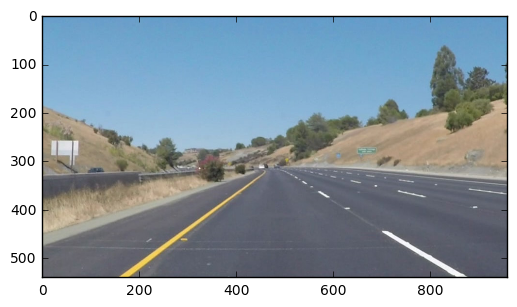

In [6]:
#reading in an image
image = mpimg.imread('test_images/'+image_name+'.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [7]:
### IGNORE THIS PART JUST SOME PERSONAL NOTES ###
# Do the color selection
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Copy the image
color_select = np.copy(image)

In [8]:
# Get familiar with an image is represented
print(image.shape)
print(image[0]) # this gives the first row of the image
print(image[0].shape) # see that each row has 960 pixels
print(image[539]) # this gives the last row of the image

(540, 960, 3)
[[104 158 202]
 [104 158 202]
 [104 158 202]
 ..., 
 [ 97 156 200]
 [ 95 154 198]
 [ 93 152 196]]
(960, 3)
[[ 99  98 106]
 [ 99  98 106]
 [ 99  98 106]
 ..., 
 [ 77  81  90]
 [ 77  81  90]
 [ 77  81  90]]


In [9]:
# Now we can do a 3 dimensional slice to get the red, green and blue channels
thresholds = (image[:,:,0] < rgb_threshold[0]) | \
            (image[:,:,1] < rgb_threshold[1])| \
            (image[:,:,2] < rgb_threshold[2])
thresholds.shape # create a 960x540 matrix

# Now make the colors that aren't "white" enough black
color_select[thresholds] = [0,0,0]

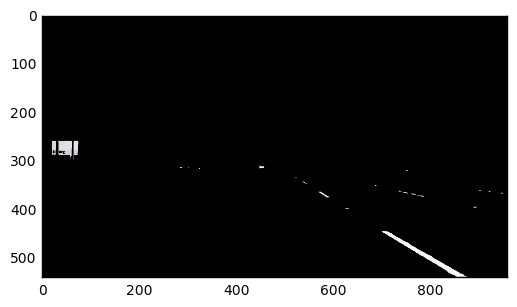

In [10]:
# Display the image
plt.imshow(color_select)

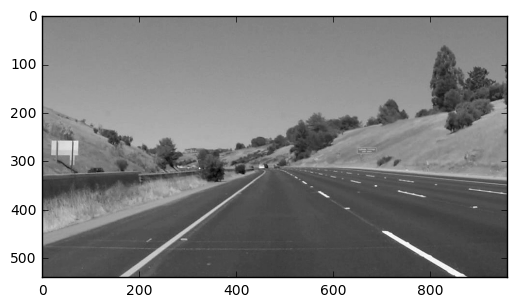

In [11]:
# Now start line detection and extrapolation

# First transform the image into a grayscale image
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

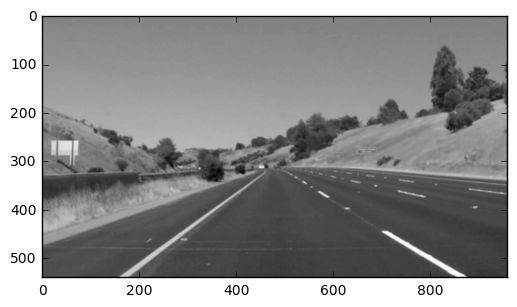

In [12]:
# Now apply Gaussian smoothing filter
kernel_size = 5 
blur_gray = gaussian_blur(gray, kernel_size)
plt.imshow(blur_gray, cmap='gray')

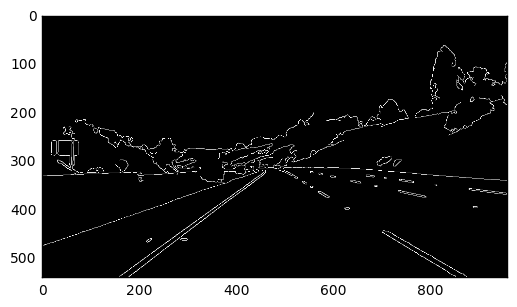

In [13]:
# Now use the Canny algorithm to detect the edges
# Note here that the higher the threshold used, the more the most obvious edges are detected
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

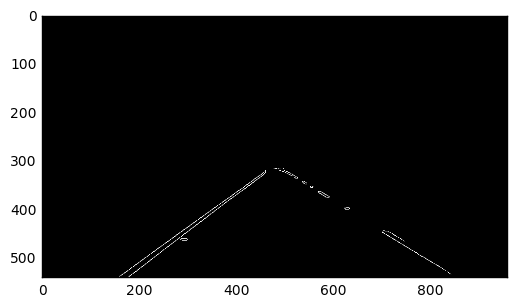

In [14]:
# Now lets include a region of interest
imshape = image.shape
y_cutoff = 315
vertices = np.array([[(150, imshape[0]),(465, y_cutoff), (535,y_cutoff), (850, imshape[0])]],dtype=np.int32)
trunc_edge = region_of_interest(edges, vertices)
plt.imshow(trunc_edge, cmap = 'gray')
trunc_edge[0:1]

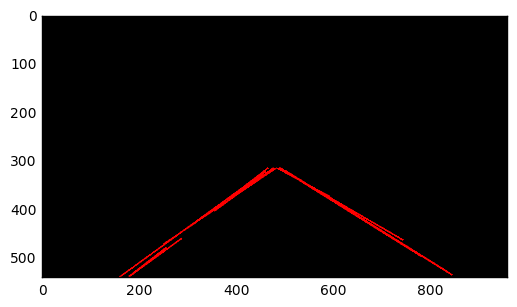

In [15]:
# Now apply the Hough Transform!

# First define how big each square in the grid is to be
rho = 5 
theta = np.pi/90

# Now specify the number of intersections needed in a square grid a candidate lines needs to have, 
# Remember here that the candidate lines (a number of points, where each point is mapped to a line in (m, b) space)
# are first transformed into a (m, b) space, and then represented by polar coordinates (rho, theta) 
# where rho is the distance from the origin a point on a line in (m, b) space and theta is the angle the line make
# with the x axis
threshold = 50 

# Now specify the minimum length that a line has to have,and the maximum gap
min_line_length = 75 
max_line_gap = 100 


# Apply Hough Transform
lines = hough_lines(trunc_edge, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(lines)

In [16]:
# But to get a better idea of the output of cv2.HoughLinesP, do it myself
lines = cv2.HoughLinesP(trunc_edge, rho, theta, threshold, np.array([]),minLineLength=min_line_length, maxLineGap=max_line_gap)

# See that we get 4-tuple which specifies the starting and ending points of the lines
# (x_0, y_0, x_1, y_1)
lines

array([[[390, 373, 465, 315]],

       [[179, 538, 255, 479]],

       [[491, 315, 844, 535]],

       [[251, 471, 480, 316]],

       [[160, 539, 460, 321]],

       [[355, 403, 476, 315]],

       [[488, 315, 743, 463]],

       [[496, 319, 781, 497]],

       [[180, 538, 287, 460]],

       [[483, 315, 592, 373]],

       [[373, 389, 455, 325]],

       [[502, 321, 837, 530]],

       [[372, 391, 460, 322]]], dtype=int32)

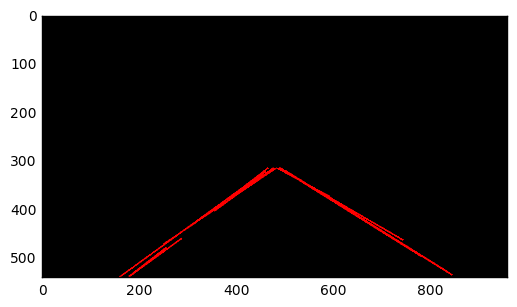

In [17]:
# Create a blank to draw lines on
line_img = np.copy(image)*0
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1,y1), (x2,y2), color=[255,0,0], thickness = 2)
        
# Now see that we get the same result good!
plt.imshow(line_img)

In [18]:
# Now we start the extrapolation

# First create a data frame to store the lines
lines_df = pd.DataFrame(columns="x_0 y_0 x_1 y_1".split(" "))

# As lines is a 3 dimensional array 8 x 1 x 4
lines
for i in range(lines.shape[0]):
    lines_df.loc[i] = lines[i,0]
lines_df

,x_0,y_0,x_1,y_1
0,390.0,373.0,465.0,315.0
1,179.0,538.0,255.0,479.0
2,491.0,315.0,844.0,535.0
3,251.0,471.0,480.0,316.0
4,160.0,539.0,460.0,321.0
5,355.0,403.0,476.0,315.0
6,488.0,315.0,743.0,463.0
7,496.0,319.0,781.0,497.0
8,180.0,538.0,287.0,460.0
9,483.0,315.0,592.0,373.0


In [19]:
# pre-allocate empty slope, and distance column
lines_df["slope"] = np.nan
lines_df["length"] = np.nan
lines_df["lane"] = ""

In [20]:
# define the slope function
def slope(row):
    return (row["y_1"] - row["y_0"])/(row["x_1"] - row["x_0"])

def length(row):
    y1y0_diff = row["y_1"] - row["y_0"]
    x1x0_diff = row["x_1"] - row["x_0"]
    return((y1y0_diff**2 + x1x0_diff)**0.5)
# Can use a for loop
# for i in range(lines_df.shape[0]):
#     line_slope = slope(lines_df.loc[i])
#     lines_df.loc[i,"slope"] = line_slope
    
# Or use lambda functions
lines_df["slope"] = lines_df.apply(slope, axis = 1)
lines_df["length"] = lines_df.apply(length, axis = 1)

In [21]:
# Now determine whether this line is on the left lane or the right line, and create a weight
# for each slope to be used later for extrapolation
slope_avg = np.average(lines_df["slope"])

# Allocate empty columns 
for i in range(lines_df.shape[0]):
    if lines_df.loc[i,"slope"] > 0:
        lines_df.loc[i,"lane"] = "Right"
    else:
        lines_df.loc[i,"lane"] = "Left"
lines_df

,x_0,y_0,x_1,y_1,slope,length,lane
0,390.0,373.0,465.0,315.0,-0.773333,58.642988,Left
1,179.0,538.0,255.0,479.0,-0.776316,59.640590,Left
2,491.0,315.0,844.0,535.0,0.623229,220.800815,Right
3,251.0,471.0,480.0,316.0,-0.676856,155.736958,Left
4,160.0,539.0,460.0,321.0,-0.726667,218.686991,Left
5,355.0,403.0,476.0,315.0,-0.727273,88.684835,Left
6,488.0,315.0,743.0,463.0,0.580392,148.858994,Right
7,496.0,319.0,781.0,497.0,0.624561,178.798770,Right
8,180.0,538.0,287.0,460.0,-0.728972,78.682908,Left
9,483.0,315.0,592.0,373.0,0.532110,58.932164,Right


In [22]:
# First get the left hand data
left_lane_data = lines_df[lines_df.lane == "Left"]
left_lane_x = left_lane_data[["x_0","x_1"]].values
left_lane_y = left_lane_data[["y_0","y_1"]].values
count_left = left_lane_x.shape[0] * left_lane_x.shape[1]

# Get the start coordinates for the lines
left_lane_x = left_lane_x.reshape(count_left)
left_lane_y = left_lane_y.reshape(count_left)

In [23]:
# # Now the right hand data
right_lane_data = lines_df[lines_df.lane == "Right"]
right_lane_x = right_lane_data[["x_0","x_1"]].values
right_lane_y = right_lane_data[["y_0","y_1"]].values
count_right = right_lane_x.shape[0] * right_lane_x.shape[1]

right_lane_x = right_lane_x.reshape(count_right)
right_lane_y = right_lane_y.reshape(count_right)

In [24]:
# # Now get the slopes for left hand line
left_lane_fit = np.polyfit(left_lane_x, left_lane_y, 1)
slope_left = left_lane_fit[0]
intercept_left = left_lane_fit[1]

In [25]:
# Now the right hand line
right_lane_fit = np.polyfit(right_lane_x, right_lane_y, 1)
slope_right = right_lane_fit[0]
intercept_right = right_lane_fit[1]

In [26]:
print(slope_left)
print(intercept_left)

print(slope_right)
print(intercept_right)

-0.745825343237
666.883141965
0.615029055069
13.4763202436


In [27]:
# To find the extrapolated lines:
# image.shape[1] = slope_left * x_left + intercept_left
y_left_start = image.shape[0]
x_left_start = (y_left_start - intercept_left)/slope_left
print(y_left_start)
print(x_left_start)

# y_cutoff = slope_left * x_left + intercept_left
y_left_end = y_cutoff
x_left_end = (y_left_end - intercept_left)/slope_left
print(y_left_end)
print(x_left_end)

left_line = [[int(i) for i in [x_left_start, y_left_start, x_left_end, y_left_end]]]
print(left_line)

540
170.124470985
315
471.803680521
[[170, 540, 471, 315]]


In [28]:
# To find the extrapolated lines:
# image.shape[1] = slope_right * x_right + intercept_right
y_right_start = image.shape[0]
x_right_start = (y_right_start - intercept_right)/slope_right
print(y_right_start)
print(x_right_start)
y_right_end = y_cutoff 
x_right_end = (y_right_end - intercept_right)/slope_right
print(y_right_end)
print(x_right_end)

right_line = [[int(i) for i in [x_right_start, y_right_start, x_right_end, y_right_end]]]

print(right_line)

540
856.095619251
315
490.259244293
[[856, 540, 490, 315]]


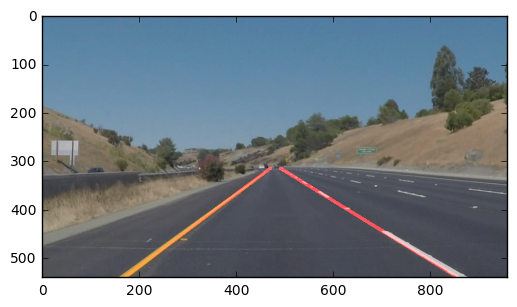

In [29]:
# Now draw the lines on the original image
final_lines = [left_line, right_line]

# Create an empty image
final_lines_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(final_lines_img, final_lines, thickness = 5)
plt.imshow(final_lines_img)

final_image = weighted_img(final_lines_img, image)
plt.imshow(final_image)
# finally save the image
plt.savefig('test_images/' + image_name + 'WithLines.jpg')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    

    # Now start line detection and extrapolation

    # First transform the image into a grayscale image
    gray = grayscale(image)
    plt.imshow(gray, cmap='gray')


    # In[460]:

    # Now apply Gaussian smoothing filter
    kernel_size = 5 
    blur_gray = gaussian_blur(gray, kernel_size)
    plt.imshow(blur_gray, cmap='gray')


    # In[461]:

    # Now use the Canny algorithm to detect the edges
    # Note here that the higher the threshold used, the more the most obvious edges are detected
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    plt.imshow(edges, cmap='Greys_r')


    # In[462]:

    # Now lets include a region of interest
    imshape = image.shape
    y_cutoff = 320 
    vertices = np.array([[(0, imshape[0]),(465, y_cutoff), (535,y_cutoff), (850, imshape[0])]],dtype=np.int32)
    trunc_edge = region_of_interest(edges, vertices)
    plt.imshow(trunc_edge, cmap = 'gray')


    # In[463]:

    # First define how big each square in the grid is to be
    rho = 5 
    theta = np.pi/90

    # Now specify the number of intersections needed in a square grid a candidate lines needs to have, 
    # Remember here that the candidate lines (a number of points, where each point is mapped to a line in (m, b) space)
    # are first transformed into a (m, b) space, and then represented by polar coordinates (rho, theta) 
    # where rho is the distance from the origin a point on a line in (m, b) space and theta is the angle the line make
    # with the x axis
    threshold = 50 

    # Now specify the minimum length that a line has to have,and the maximum gap
    min_line_length = 75 
    max_line_gap = 100 

    # Apply Hough Transform
    lines = hough_lines(trunc_edge, rho, theta, threshold, min_line_length, max_line_gap)
    plt.imshow(lines)


    # In[464]:

    # But to get a better idea of the output of cv2.HoughLinesP, do it myself
    lines = cv2.HoughLinesP(trunc_edge, rho, theta, threshold, np.array([]),minLineLength=min_line_length, maxLineGap=max_line_gap)

    # See that we get 4-tuple which specifies the starting and ending points of the lines
    # (x_0, y_0, x_1, y_1)
    lines


    # In[465]:

    # Create a blank to draw lines on
    line_img = np.copy(image)*0
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1,y1), (x2,y2), color=[255,0,0], thickness = 2)

    # Now see that we get the same result good!
    plt.imshow(line_img)


    # In[466]:

    # Now we start the extrapolation

    # First create a data frame to store the lines
    lines_df = pd.DataFrame(columns="x_0 y_0 x_1 y_1".split(" "))

    # As lines is a 3 dimensional array 8 x 1 x 4
    lines
    for i in range(lines.shape[0]):
        lines_df.loc[i] = lines[i,0]
    lines_df


    # In[467]:

    # pre-allocate empty slope, and distance column
    lines_df["slope"] = np.nan
    lines_df["length"] = np.nan
    lines_df["lane"] = ""

 

    # Or use lambda functions
    lines_df["slope"] = lines_df.apply(slope, axis = 1)
    lines_df["length"] = lines_df.apply(length, axis = 1)


    # In[469]:

    # Now determine whether this line is on the left lane or the right line, and create a weight
    # for each slope to be used later for extrapolation
    slope_avg = np.average(lines_df["slope"])

    # Allocate empty columns 
    for i in range(lines_df.shape[0]):
        if lines_df.loc[i,"slope"] > 0:
            lines_df.loc[i,"lane"] = "Right"
        else:
            lines_df.loc[i,"lane"] = "Left"
    lines_df


    # In[470]:

    # First get the left hand data
    left_lane_data = lines_df[lines_df.lane == "Left"]
    left_lane_x = left_lane_data[["x_0","x_1"]].values
    left_lane_y = left_lane_data[["y_0","y_1"]].values
    count_left = left_lane_x.shape[0] * left_lane_x.shape[1]

    # Get the start coordinates for the lines
    left_lane_x = left_lane_x.reshape(count_left)
    left_lane_y = left_lane_y.reshape(count_left)

    print("Left Lane")
    print(left_lane_x)
    print(left_lane_y)

    # In[471]:

    # # Now the right hand data
    right_lane_data = lines_df[lines_df.lane == "Right"]
    right_lane_x = right_lane_data[["x_0","x_1"]].values
    right_lane_y = right_lane_data[["y_0","y_1"]].values
    count_right = right_lane_x.shape[0] * right_lane_x.shape[1]

    right_lane_x = right_lane_x.reshape(count_right)
    right_lane_y = right_lane_y.reshape(count_right)
    print("Right Lane")
    print(right_lane_x)
    print(right_lane_y)

    # In[472]:

    left_line = []
    # # Now get the slopes for left hand line
    if (len(left_lane_x) & len(left_lane_y)):
        left_lane_fit = np.polyfit(left_lane_x, left_lane_y, 1)
        slope_left = left_lane_fit[0]
        intercept_left = left_lane_fit[1]
        
        # To find the extrapolated lines:
    
        # image.shape[1] = slope_left * x_left + intercept_left
        y_left_start = image.shape[0]
        x_left_start = (y_left_start - intercept_left)/slope_left

        # y_cutoff = slope_left * x_left + intercept_left
        y_left_end = y_cutoff
        x_left_end = (y_left_end - intercept_left)/slope_left

        left_line = [[int(i) for i in [x_left_start, y_left_start, x_left_end, y_left_end]]]
    else:
        plt.imshow(trunc_edge, cmap = "gray")
        return

    # In[473]:
    
    right_line = []
    # Now the right hand line
    if (len(right_lane_x) & len(right_lane_y)):
        right_lane_fit = np.polyfit(right_lane_x, right_lane_y, 1)
        slope_right = right_lane_fit[0]
        intercept_right = right_lane_fit[1]
    
        # To find the extrapolated lines:
        # image.shape[1] = slope_right * x_right + intercept_right
        y_right_start = image.shape[0]
        x_right_start = (y_right_start - intercept_right)/slope_right

        y_right_end = y_cutoff 
        x_right_end = (y_right_end - intercept_right)/slope_right

        right_line = [[int(i) for i in [x_right_start, y_right_start, x_right_end, y_right_end]]]


   





    # In[477]:

    # Now draw the lines on the original image
    final_lines = [left_line, right_line]

    # Create an empty image
    final_lines_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(final_lines_img, final_lines, thickness = 5)
    plt.imshow(final_lines_img)

    result = weighted_img(final_lines_img, image)

    return result

Let's try the one with the solid white lane on the right first ...

Left Lane
[ 213.  431.  187.  429.  267.  406.  189.  266.  307.  396.  200.  279.
  305.  445.]
[ 507.  337.  514.  338.  454.  360.  515.  455.  430.  361.  515.  457.
  430.  329.]
Right Lane
[ 503.  685.  571.  735.  592.  723.  691.  805.  537.  667.  502.  663.
  503.  717.]
[ 320.  434.  358.  468.  370.  451.  430.  512.  337.  424.  320.  413.
  321.  455.]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 1/222 [00:00<00:32,  6.88it/s]

Left Lane
[ 213.  431.  187.  429.  267.  406.  189.  266.  307.  396.  200.  279.
  305.  445.]
[ 507.  337.  514.  338.  454.  360.  515.  455.  430.  361.  515.  457.
  430.  329.]
Right Lane
[ 503.  685.  571.  735.  592.  723.  691.  805.  537.  667.  502.  663.
  503.  717.]
[ 320.  434.  358.  468.  370.  451.  430.  512.  337.  424.  320.  413.
  321.  455.]


  1%|          | 2/222 [00:00<00:33,  6.64it/s]

Left Lane
[ 151.  349.  170.  398.  170.  413.  284.  444.  287.  454.  355.  441.]
[ 539.  395.  538.  360.  539.  349.  446.  330.  446.  325.  398.  331.]
Right Lane
[ 582.  678.  501.  740.  507.  585.  707.  833.  685.  800.  638.  731.
  585.  674.  572.  724.  598.  689.]
[ 365.  424.  320.  470.  320.  368.  440.  531.  427.  510.  398.  465.
  372.  420.  359.  461.  380.  429.]


  1%|▏         | 3/222 [00:00<00:34,  6.42it/s]

Left Lane
[ 171.  411.  251.  425.  253.  441.  340.  454.  252.  346.  156.  249.
  336.  450.  151.  346.  250.  399.]
[ 538.  351.  467.  341.  467.  331.  403.  326.  467.  404.  533.  479.
  404.  327.  538.  406.  467.  366.]
Right Lane
[ 502.  667.  587.  753.  613.  720.  528.  640.  599.  791.  689.  808.
  572.  712.  508.  611.  501.  761.]
[ 320.  423.  368.  479.  383.  449.  332.  407.  375.  504.  429.  515.
  359.  453.  320.  389.  320.  483.]


  2%|▏         | 4/222 [00:00<00:34,  6.31it/s]

Left Lane
[ 332.  441.  323.  442.  322.  426.  195.  386.  328.  456.]
[ 416.  331.  417.  331.  416.  341.  518.  369.  417.  324.]
Right Lane
[ 696.  847.  507.  712.  523.  644.  612.  693.  507.  593.  633.  723.
  631.  717.  508.  611.]
[ 443.  538.  324.  443.  329.  410.  383.  441.  320.  378.  395.  451.
  394.  456.  320.  389.]


  2%|▏         | 5/222 [00:00<00:33,  6.42it/s]

Left Lane
[ 301.  456.  311.  419.  312.  455.  314.  439.  305.  405.]
[ 428.  324.  429.  345.  429.  325.  429.  332.  427.  355.]
Right Lane
[ 717.  848.  501.  702.  507.  603.  535.  665.  751.  841.  556.  642.]
[ 456.  538.  320.  436.  320.  384.  336.  423.  477.  533.  349.  407.]


  3%|▎         | 6/222 [00:00<00:32,  6.66it/s]

Left Lane
[ 291.  400.  284.  384.  288.  422.  286.  443.  290.  448.]
[ 443.  358.  443.  376.  440.  343.  444.  330.  443.  328.]
Right Lane
[ 568.  842.  511.  712.  511.  629.  752.  848.  573.  690.  502.  685.]
[ 362.  534.  326.  443.  321.  394.  478.  538.  360.  438.  320.  426.]


  3%|▎         | 7/222 [00:01<00:32,  6.61it/s]

Left Lane
[ 257.  377.  339.  419.  263.  451.  256.  397.]
[ 462.  381.  403.  345.  463.  327.  462.  360.]
Right Lane
[ 590.  848.  502.  687.  538.  683.  587.  697.  514.  827.  510.  787.
  560.  641.]
[ 376.  538.  320.  427.  337.  434.  374.  433.  328.  524.  325.  498.
  351.  401.]


  4%|▎         | 8/222 [00:01<00:31,  6.69it/s]

Left Lane
[ 223.  437.  228.  450.  216.  411.  229.  452.]
[ 488.  333.  488.  327.  491.  350.  488.  326.]
Right Lane
[ 502.  825.  509.  632.  653.  746.  636.  721.  606.  712.  511.  702.]
[ 320.  522.  320.  396.  407.  474.  397.  458.  386.  443.  326.  436.]


  4%|▍         | 9/222 [00:01<00:33,  6.42it/s]

Left Lane
[ 316.  454.  310.  413.  310.  387.  321.  435.]
[ 425.  325.  424.  349.  423.  367.  423.  334.]
Right Lane
[ 515.  841.  508.  619.  511.  658.  586.  664.  706.  813.  605.  848.]
[ 329.  533.  320.  389.  321.  412.  373.  415.  440.  517.  386.  538.]
Left Lane
[ 289.  416.  327.  456.  295.  458.  300.  401.  299.  410.  291.  445.
  297.  462.]
[ 441.  355.  411.  324.  441.  323.  432.  359.  440.  353.  441.  329.
  441.  321.]
Right Lane
[ 508.  666.  508.  654.  585.  835.  520.  735.  499.  608.  724.  833.
  742.  817.  659.  752.  728.  804.]
[ 321.  427.  326.  411.  375.  532.  334.  459.  320.  383.  453.  532.
  464.  522.  414.  481.  455.  514.]


  5%|▍         | 11/222 [00:01<00:34,  6.06it/s]

Left Lane
[ 263.  448.  311.  465.  272.  466.  271.  460.  263.  467.]
[ 459.  334.  424.  320.  461.  320.  461.  324.  458.  320.]
Right Lane
[ 601.  795.  501.  675.  687.  790.  564.  772.  514.  620.  496.  585.
  641.  728.  674.  766.  748.  826.]
[ 388.  510.  320.  428.  434.  508.  364.  485.  332.  399.  320.  376.
  406.  469.  426.  493.  470.  531.]


  5%|▌         | 12/222 [00:01<00:34,  6.18it/s]

Left Lane
[ 290.  466.  239.  461.  230.  311.  237.  443.  261.  405.  374.  456.]
[ 439.  320.  485.  324.  484.  425.  485.  336.  471.  359.  388.  324.]
Right Lane
[ 500.  683.  517.  682.  705.  834.  501.  763.  691.  777.  523.  606.
  694.  781.  701.  787.  679.  762.  682.  835.]
[ 320.  443.  331.  434.  457.  538.  320.  483.  448.  490.  339.  391.
  450.  493.  454.  496.  440.  481.  442.  538.]


  6%|▌         | 13/222 [00:02<00:33,  6.30it/s]

Left Lane
[ 235.  466.  263.  402.  190.  269.  304.  446.  223.  306.  183.  289.
  261.  465.]
[ 476.  320.  468.  360.  516.  463.  432.  329.  485.  433.  515.  438.
  468.  320.]
Right Lane
[ 538.  674.  502.  815.  711.  833.  621.  724.  508.  598.  583.  680.
  582.  714.]
[ 346.  437.  320.  515.  461.  538.  395.  469.  328.  385.  371.  441.
  376.  453.]


  6%|▋         | 14/222 [00:02<00:32,  6.47it/s]

Left Lane
[ 188.  445.  163.  460.  171.  432.  235.  455.  241.  393.  176.  349.]
[ 507.  333.  538.  322.  519.  343.  474.  325.  482.  364.  530.  395.]
Right Lane
[ 505.  620.  504.  740.  524.  809.  754.  834.  545.  656.  540.  685.]
[ 320.  392.  320.  479.  333.  511.  488.  538.  350.  415.  346.  443.]


  7%|▋         | 15/222 [00:02<00:31,  6.59it/s]

Left Lane
[ 258.  444.  234.  386.  155.  244.  162.  338.  141.  429.  186.  444.
  254.  425.]
[ 465.  330.  485.  367.  530.  466.  538.  401.  538.  343.  519.  331.
  464.  340.]
Right Lane
[ 525.  615.  556.  739.  645.  772.  522.  795.  521.  610.  711.  787.
  618.  759.  502.  586.  687.  804.]
[ 336.  393.  354.  477.  406.  498.  330.  501.  332.  384.  449.  508.
  395.  490.  320.  369.  434.  519.]


  7%|▋         | 16/222 [00:02<00:31,  6.60it/s]

Left Lane
[ 324.  426.  326.  413.  322.  443.  321.  439.  142.  222.  320.  427.
  328.  442.]
[ 413.  339.  412.  353.  412.  331.  412.  332.  535.  492.  411.  339.
  409.  332.]
Right Lane
[ 554.  767.  510.  670.  657.  804.  728.  821.  514.  765.  599.  779.
  635.  760.]
[ 351.  494.  320.  420.  412.  518.  457.  529.  323.  480.  377.  490.
  399.  489.]


  8%|▊         | 17/222 [00:02<00:29,  6.93it/s]

Left Lane
[ 313.  442.  304.  439.  304.  425.  310.  426.]
[ 424.  331.  423.  332.  422.  340.  424.  340.]
Right Lane
[ 511.  826.  615.  756.  506.  590.  606.  684.  572.  766.  524.  649.
  598.  674.  574.  738.]
[ 320.  532.  392.  474.  320.  369.  386.  428.  359.  481.  333.  406.
  381.  422.  364.  474.]


  8%|▊         | 18/222 [00:02<00:28,  7.09it/s]

Left Lane
[ 291.  437.  293.  442.  282.  415.]
[ 439.  333.  439.  331.  437.  348.]
Right Lane
[ 510.  825.  584.  721.  507.  600.  535.  765.  523.  598.  731.  824.
  554.  634.  576.  673.]
[ 320.  532.  372.  452.  322.  376.  336.  480.  333.  380.  459.  531.
  347.  405.  361.  431.]


  9%|▊         | 19/222 [00:02<00:30,  6.72it/s]

Left Lane
[ 261.  378.  260.  397.  339.  423.  350.  435.]
[ 459.  380.  459.  360.  400.  347.  400.  334.]
Right Lane
[ 508.  811.  585.  719.  518.  596.  597.  748.  502.  590.  612.  770.
  536.  788.]
[ 320.  524.  374.  452.  331.  380.  382.  470.  320.  371.  392.  484.
  338.  496.]
Left Lane
[ 364.  440.  222.  352.  234.  456.  227.  435.  326.  449.]
[ 392.  337.  486.  392.  485.  324.  486.  335.  411.  328.]
Right Lane
[ 506.  795.  519.  614.  507.  797.  549.  639.  588.  680.  599.  698.
  614.  758.]
[ 320.  501.  333.  393.  320.  515.  351.  411.  372.  438.  379.  450.
  394.  478.]


  9%|▉         | 21/222 [00:03<00:37,  5.42it/s]

Left Lane
[ 310.  460.  313.  446.  338.  465.  319.  464.]
[ 423.  322.  425.  329.  412.  320.  425.  320.]
Right Lane
[ 504.  812.  528.  614.  505.  741.  557.  683.]
[ 320.  513.  340.  394.  320.  479.  357.  441.]
Left Lane
[ 298.  452.  294.  446.  351.  454.  293.  417.  292.  382.  290.  465.
  349.  462.]
[ 439.  327.  439.  329.  399.  325.  439.  355.  439.  374.  438.  320.
  403.  321.]
Right Lane
[ 504.  812.  531.  629.  525.  700.  641.  737.  560.  663.]
[ 320.  513.  342.  404.  334.  452.  405.  475.  359.  428.]


 11%|█         | 24/222 [00:03<00:29,  6.82it/s]

Left Lane
[ 277.  465.  328.  452.  264.  464.  273.  457.  264.  437.]
[ 456.  320.  410.  326.  455.  320.  457.  324.  456.  339.]
Right Lane
[ 504.  811.  520.  610.  718.  800.  505.  750.  500.  577.]
[ 320.  512.  334.  391.  464.  516.  320.  485.  320.  371.]
Left Lane
[ 232.  462.  267.  396.  244.  436.  238.  454.]
[ 476.  321.  463.  363.  479.  340.  471.  325.]
Right Lane
[ 507.  802.  574.  744.  509.  724.  615.  729.]
[ 321.  506.  367.  481.  322.  467.  388.  470.]


 11%|█▏        | 25/222 [00:03<00:28,  6.95it/s]

Left Lane
[ 308.  445.  199.  454.  305.  421.  190.  458.  203.  433.  195.  291.
  189.  298.  200.  434.]
[ 429.  330.  510.  325.  429.  351.  504.  323.  509.  342.  501.  445.
  509.  430.  510.  340.]
Right Lane
[ 506.  795.  532.  630.  754.  833.  694.  798.  529.  751.  504.  594.
  508.  829.]
[ 320.  501.  341.  403.  487.  537.  447.  503.  335.  485.  321.  381.
  320.  536.]
Left Lane
[ 141.  433.  162.  458.  255.  398.  163.  432.  220.  359.  271.  452.
  141.  403.]
[ 539.  342.  538.  323.  472.  361.  539.  343.  484.  397.  448.  326.
  538.  361.]
Right Lane
[ 528.  802.  511.  635.  707.  833.  572.  654.  567.  685.  622.  819.
  570.  696.]
[ 334.  506.  325.  408.  454.  539.  367.  419.  363.  431.  398.  530.
  365.  438.]


 13%|█▎        | 28/222 [00:04<00:28,  6.70it/s]

Left Lane
[ 142.  432.  164.  347.  164.  416.  239.  460.  149.  398.]
[ 539.  343.  539.  406.  538.  355.  471.  322.  535.  367.]
Right Lane
[ 506.  788.  539.  637.  705.  833.  595.  683.  509.  798.  588.  673.]
[ 320.  496.  346.  408.  453.  539.  376.  439.  322.  503.  376.  433.]
Left Lane
[ 325.  427.  324.  458.  142.  219.  332.  429.  328.  452.  167.  327.
  324.  430.  323.  443.  144.  220.]
[ 416.  347.  413.  323.  538.  490.  416.  345.  416.  326.  537.  412.
  415.  344.  413.  332.  537.  490.]
Right Lane
[ 507.  791.  516.  617.  587.  750.  567.  718.  506.  788.  566.  668.
  603.  703.]
[ 320.  511.  330.  389.  377.  472.  364.  452.  320.  496.  362.  430.
  386.  453.]


 14%|█▎        | 30/222 [00:04<00:28,  6.85it/s]

Left Lane
[ 315.  428.  308.  390.  306.  454.  307.  460.]
[ 428.  346.  428.  373.  425.  325.  425.  322.]
Right Lane
[ 506.  798.  539.  623.  507.  821.  618.  721.  502.  599.  612.  699.]
[ 320.  503.  346.  399.  320.  531.  391.  465.  320.  385.  387.  450.]
Left Lane
[ 285.  458.  296.  451.  299.  437.]
[ 439.  323.  441.  328.  441.  333.]
Right Lane
[ 508.  810.  524.  630.  609.  779.  677.  824.  572.  702.  558.  636.
  503.  606.  546.  625.  672.  803.]
[ 320.  523.  335.  397.  391.  490.  426.  532.  367.  443.  353.  402.
  320.  389.  350.  400.  423.  518.]


 14%|█▍        | 31/222 [00:04<00:26,  7.19it/s]

Left Lane
[ 268.  452.  263.  437.  270.  454.  262.  397.]
[ 459.  326.  459.  333.  459.  325.  459.  361.]
Right Lane
[ 504.  760.  605.  687.  515.  604.  511.  785.  507.  610.  731.  835.
  568.  647.]
[ 320.  479.  388.  440.  323.  387.  322.  494.  322.  391.  469.  539.
  364.  414.]
Left Lane
[ 328.  454.  237.  422.  228.  435.]
[ 410.  325.  483.  349.  484.  334.]
Right Lane
[ 738.  836.  531.  779.  631.  721.  508.  778.  504.  630.  594.  681.]
[ 473.  539.  335.  490.  405.  462.  320.  489.  320.  404.  381.  436.]


 15%|█▌        | 34/222 [00:05<00:25,  7.40it/s]

Left Lane
[ 311.  448.  314.  437.  319.  420.  312.  433.  316.  394.]
[ 422.  329.  422.  333.  423.  350.  422.  335.  423.  370.]
Right Lane
[ 698.  782.  530.  778.  506.  639.  517.  607.  658.  752.  519.  668.
  668.  788.]
[ 447.  503.  334.  489.  321.  410.  324.  384.  421.  484.  329.  429.
  420.  507.]
Left Lane
[ 292.  454.  303.  433.  301.  416.]
[ 434.  325.  436.  335.  437.  353.]
Right Lane
[ 531.  788.  744.  834.  503.  624.  737.  827.  584.  667.  685.  778.
  548.  633.]
[ 335.  496.  479.  536.  320.  401.  473.  533.  369.  429.  431.  489.
  345.  406.]


 16%|█▌        | 35/222 [00:05<00:25,  7.44it/s]

Left Lane
[ 267.  457.  277.  415.  289.  433.]
[ 452.  324.  455.  355.  448.  336.]
Right Lane
[ 537.  799.  665.  757.  504.  653.  713.  795.  744.  834.  655.  761.]
[ 340.  504.  429.  487.  321.  421.  460.  512.  479.  539.  422.  479.]
Left Lane
[ 270.  464.  248.  368.  246.  412.  236.  312.  237.  432.  254.  435.
  253.  402.  242.  318.]
[ 451.  320.  478.  384.  478.  358.  478.  423.  478.  337.  462.  340.
  475.  359.  471.  427.]
Right Lane
[ 538.  811.  501.  650.  696.  791.  717.  804.  567.  667.  523.  610.
  502.  685.]
[ 341.  512.  320.  420.  450.  510.  462.  520.  359.  431.  330.  388.
  320.  443.]


 17%|█▋        | 38/222 [00:05<00:27,  6.62it/s]

Left Lane
[ 289.  464.  193.  301.  228.  391.  247.  426.  192.  408.  362.  453.
  206.  360.]
[ 438.  320.  508.  430.  494.  367.  480.  341.  506.  360.  392.  326.
  509.  389.]
Right Lane
[ 503.  807.  501.  653.  717.  815.  617.  724.  679.  790.  754.  832.
  566.  662.  526.  657.]
[ 321.  510.  320.  422.  464.  526.  391.  468.  438.  498.  488.  537.
  359.  428.  336.  424.]
Left Lane
[ 167.  404.  229.  399.  286.  444.  167.  289.  146.  405.  217.  464.]
[ 523.  363.  493.  361.  445.  330.  538.  449.  538.  363.  500.  320.]
Right Lane
[ 502.  818.  530.  752.  507.  596.  741.  828.  516.  623.  511.  608.
  566.  686.  527.  607.  611.  687.]
[ 320.  517.  338.  487.  320.  384.  478.  536.  325.  402.  322.  392.
  364.  434.  332.  385.  393.  444.]


 18%|█▊        | 40/222 [00:06<00:26,  6.84it/s]

Left Lane
[ 192.  415.  235.  411.  195.  399.  145.  401.  174.  258.  166.  264.
  165.  348.]
[ 505.  354.  488.  351.  516.  367.  538.  365.  533.  463.  538.  467.
  538.  405.]
Right Lane
[ 544.  802.  503.  695.  701.  783.  709.  802.  748.  833.  504.  581.
  551.  655.  699.  832.]
[ 344.  506.  320.  449.  453.  505.  457.  519.  482.  539.  322.  367.
  347.  422.  442.  538.]
Left Lane
[ 331.  453.  330.  454.  143.  224.  163.  325.  329.  443.  205.  379.
  142.  222.  182.  329.  223.  390.]
[ 415.  326.  415.  325.  538.  488.  538.  412.  415.  332.  509.  374.
  538.  488.  526.  411.  496.  366.]
Right Lane
[ 545.  792.  517.  761.  699.  783.  523.  622.  619.  723.  583.  698.
  627.  739.  521.  631.  574.  785.  513.  613.  504.  643.]
[ 344.  499.  328.  492.  441.  506.  328.  394.  391.  466.  374.  441.
  396.  477.  327.  406.  363.  495.  322.  394.  320.  407.]


 19%|█▉        | 42/222 [00:06<00:24,  7.21it/s]

Left Lane
[ 309.  424.  309.  410.  306.  441.  311.  443.  315.  452.]
[ 425.  341.  426.  357.  425.  334.  426.  331.  426.  326.]
Right Lane
[ 505.  802.  528.  605.  507.  590.]
[ 320.  506.  331.  382.  322.  377.]
Left Lane
[ 361.  441.  284.  421.  284.  422.]
[ 393.  331.  441.  342.  442.  342.]
Right Lane
[ 504.  811.  537.  802.  529.  719.  548.  638.  719.  817.  628.  746.]
[ 320.  512.  341.  519.  336.  464.  345.  402.  453.  529.  396.  481.]


 20%|█▉        | 44/222 [00:06<00:29,  6.12it/s]

Left Lane
[ 259.  420.  350.  435.  267.  441.  257.  423.  275.  421.]
[ 460.  343.  400.  334.  458.  332.  458.  346.  457.  343.]
Right Lane
[ 680.  832.  504.  811.  540.  669.  570.  674.  559.  684.  552.  646.
  505.  753.  514.  594.]
[ 437.  539.  320.  512.  338.  431.  364.  425.  351.  441.  352.  407.
  320.  487.  322.  375.]
Left Lane
[ 223.  415.  337.  419.  348.  434.  225.  418.]
[ 484.  345.  409.  345.  402.  335.  484.  344.]
Right Lane
[ 532.  827.  505.  798.  552.  684.  504.  699.  597.  722.  516.  785.]
[ 337.  535.  320.  503.  346.  441.  320.  451.  376.  466.  327.  508.]


 21%|██        | 46/222 [00:06<00:25,  7.03it/s]

Left Lane
[ 314.  413.  324.  432.  361.  448.  319.  438.]
[ 419.  347.  420.  336.  387.  328.  421.  334.]
Right Lane
[ 516.  831.  509.  590.  504.  645.]
[ 327.  539.  320.  371.  320.  408.]
Left Lane
[ 304.  413.  295.  437.  295.  408.  333.  431.]
[ 434.  349.  431.  335.  432.  350.  413.  337.]
Right Lane
[ 505.  802.  520.  773.  508.  637.  544.  832.]
[ 320.  506.  330.  500.  320.  401.  345.  539.]


 22%|██▏       | 48/222 [00:07<00:23,  7.32it/s]

Left Lane
[ 288.  445.  282.  411.  270.  408.  300.  381.]
[ 435.  329.  450.  350.  450.  350.  437.  374.]
Right Lane
[ 516.  769.  711.  805.  529.  701.]
[ 327.  497.  449.  508.  335.  451.]
Left Lane
[ 279.  445.  251.  329.  240.  445.]
[ 441.  329.  472.  415.  469.  330.]
Right Lane
[ 596.  798.  523.  831.  513.  612.  509.  595.  711.  799.  705.  790.]
[ 376.  503.  332.  539.  327.  385.  320.  374.  449.  517.  445.  511.]


 23%|██▎       | 50/222 [00:07<00:23,  7.26it/s]

Left Lane
[ 197.  302.  210.  312.  311.  432.  309.  429.  207.  446.  305.  415.
  200.  310.]
[ 501.  425.  502.  428.  425.  338.  424.  337.  502.  329.  425.  345.
  498.  429.]
Right Lane
[ 510.  682.  524.  789.  718.  816.  546.  831.  508.  594.]
[ 322.  430.  333.  511.  453.  529.  347.  539.  320.  374.]
Left Lane
[ 179.  272.  238.  397.  157.  401.  161.  292.  347.  430.  347.  429.
  153.  249.]
[ 512.  445.  482.  358.  526.  361.  538.  442.  393.  337.  392.  337.
  529.  473.]
Right Lane
[ 581.  799.  524.  830.  509.  831.  502.  588.  508.  635.  611.  730.
  567.  679.]
[ 367.  504.  333.  539.  321.  538.  320.  370.  320.  400.  392.  461.
  358.  428.]


 23%|██▎       | 52/222 [00:07<00:22,  7.54it/s]

Left Lane
[ 160.  266.  177.  254.  166.  444.  260.  424.  140.  266.  264.  428.
  336.  439.]
[ 538.  461.  513.  458.  519.  331.  458.  339.  537.  458.  458.  339.
  401.  332.]
Right Lane
[ 661.  815.  544.  831.  509.  615.  565.  673.  514.  751.  502.  591.]
[ 418.  515.  346.  539.  325.  387.  361.  424.  327.  486.  320.  372.]
Left Lane
[ 321.  424.  143.  218.  227.  388.  157.  443.  231.  427.  137.  223.
  230.  427.]
[ 409.  339.  533.  482.  481.  364.  538.  331.  482.  340.  539.  481.
  482.  339.]
Right Lane
[ 668.  811.  532.  831.  502.  585.  577.  697.  628.  769.  509.  615.
  586.  711.  611.  732.]
[ 422.  512.  338.  539.  320.  368.  369.  439.  395.  497.  325.  387.
  375.  448.  385.  472.]


 24%|██▍       | 54/222 [00:08<00:21,  7.74it/s]

Left Lane
[ 304.  424.  303.  423.  308.  416.  314.  441.  304.  440.  303.  421.]
[ 422.  341.  421.  340.  423.  345.  423.  331.  423.  332.  422.  342.]
Right Lane
[ 578.  798.  533.  825.  507.  608.  510.  831.  502.  591.  528.  672.]
[ 365.  503.  339.  535.  324.  383.  322.  539.  320.  372.  333.  423.]
Left Lane
[ 294.  436.  282.  440.  281.  422.  281.  421.]
[ 437.  334.  439.  333.  437.  342.  436.  342.]
Right Lane
[ 508.  728.  545.  831.  615.  749.  624.  772.  507.  672.  596.  723.]
[ 321.  459.  347.  539.  395.  473.  401.  487.  320.  423.  382.  456.]


 25%|██▌       | 56/222 [00:08<00:22,  7.52it/s]

Left Lane
[ 265.  419.  268.  434.  256.  448.  261.  394.  254.  417.]
[ 455.  344.  455.  335.  457.  328.  455.  359.  454.  344.]
Right Lane
[ 508.  760.  503.  654.  686.  788.  566.  831.  671.  761.]
[ 321.  479.  320.  421.  442.  497.  361.  539.  432.  480.]
Left Lane
[ 322.  415.  231.  416.  226.  366.  219.  448.  228.  355.]
[ 409.  346.  480.  346.  480.  385.  482.  328.  480.  394.]
Right Lane
[ 505.  802.  512.  830.  508.  590.  580.  693.  696.  828.  601.  733.
  544.  815.]
[ 320.  506.  325.  539.  326.  378.  372.  438.  448.  537.  386.  463.
  345.  515.]


 26%|██▌       | 58/222 [00:08<00:22,  7.24it/s]

Left Lane
[ 309.  458.  307.  433.  314.  436.  306.  435.]
[ 423.  323.  420.  335.  423.  335.  421.  334.]
Right Lane
[ 676.  829.  606.  831.  529.  611.  500.  596.  511.  595.  540.  623.
  511.  821.]
[ 436.  539.  385.  526.  335.  394.  321.  377.  329.  382.  342.  402.
  325.  519.]
Left Lane
[ 291.  414.  288.  456.  286.  445.  287.  446.  289.  462.]
[ 431.  354.  437.  324.  436.  329.  437.  330.  437.  321.]
Right Lane
[ 503.  828.  508.  838.  511.  598.  553.  663.  540.  713.  529.  640.]
[ 320.  539.  324.  531.  330.  385.  351.  430.  347.  463.  341.  406.]


 27%|██▋       | 60/222 [00:08<00:23,  7.01it/s]

Left Lane
[ 289.  410.  265.  406.  272.  442.  260.  432.  263.  458.]
[ 432.  356.  455.  353.  454.  331.  453.  337.  454.  323.]
Right Lane
[ 499.  721.  514.  841.  551.  803.  647.  849.  533.  651.]
[ 320.  469.  328.  533.  354.  523.  412.  539.  344.  413.]
Left Lane
[ 240.  431.  226.  319.  291.  420.  226.  429.  235.  321.]
[ 476.  337.  474.  416.  430.  349.  475.  338.  476.  418.]
Right Lane
[ 553.  826.  672.  848.  505.  601.  532.  640.  705.  842.  582.  784.]
[ 355.  539.  428.  538.  325.  381.  343.  406.  448.  534.  375.  511.]


 28%|██▊       | 62/222 [00:09<00:25,  6.39it/s]

Left Lane
[ 301.  399.  181.  428.  197.  439.  360.  457.  198.  297.]
[ 429.  358.  505.  339.  507.  332.  390.  324.  506.  429.]
Right Lane
[ 553.  824.  514.  692.  674.  844.  578.  705.]
[ 356.  538.  328.  440.  430.  537.  369.  449.]
Left Lane
[ 132.  439.  154.  233.  280.  394.  131.  248.  278.  460.  161.  424.
  136.  343.  132.  425.]
[ 539.  332.  535.  481.  444.  361.  538.  470.  444.  322.  532.  341.
  534.  394.  538.  340.]
Right Lane
[ 501.  824.  499.  737.  499.  574.]
[ 321.  538.  320.  469.  321.  365.]


 29%|██▉       | 64/222 [00:09<00:22,  6.94it/s]

Left Lane
[ 132.  439.  177.  426.  248.  458.  151.  247.  229.  335.  152.  421.]
[ 539.  332.  521.  341.  464.  323.  539.  464.  483.  401.  538.  343.]
Right Lane
[ 562.  823.  499.  707.  725.  844.  504.  587.  674.  796.  500.  822.]
[ 362.  538.  320.  450.  463.  538.  320.  380.  430.  507.  321.  538.]
Left Lane
[ 316.  423.  327.  440.  192.  319.  131.  208.  324.  421.  323.  460.
  318.  425.]
[ 414.  342.  414.  332.  510.  411.  538.  490.  414.  344.  414.  322.
  414.  342.]
Right Lane
[ 497.  822.  509.  687.  626.  739.  674.  751.  634.  709.  503.  729.
  616.  746.  578.  694.]
[ 320.  539.  325.  437.  406.  472.  429.  480.  404.  462.  323.  465.
  393.  487.  368.  452.]


 30%|██▉       | 66/222 [00:09<00:21,  7.27it/s]

Left Lane
[ 301.  438.  308.  460.  299.  418.]
[ 425.  333.  425.  322.  425.  345.]
Right Lane
[ 498.  820.  699.  780.  519.  613.  513.  621.  618.  716.  497.  821.]
[ 320.  537.  445.  499.  336.  391.  328.  396.  395.  457.  320.  539.]
Left Lane
[ 287.  417.  289.  420.  277.  449.  279.  380.  283.  412.]
[ 439.  345.  439.  344.  437.  329.  439.  376.  435.  348.]
Right Lane
[ 497.  769.  500.  821.  499.  721.]
[ 320.  490.  321.  538.  320.  459.]


 30%|███       | 67/222 [00:09<00:20,  7.39it/s]

Left Lane
[ 249.  419.  248.  415.  345.  432.]
[ 458.  344.  458.  345.  399.  336.]
Right Lane
[ 500.  824.  513.  603.  762.  844.  506.  585.]
[ 320.  538.  326.  383.  484.  539.  320.  373.]
Left Lane

 31%|███       | 68/222 [00:10<00:27,  5.69it/s]


[ 214.  415.  335.  431.  212.  413.  336.  416.]
[ 481.  346.  406.  337.  482.  346.  404.  346.]
Right Lane
[ 508.  824.  501.  667.  654.  823.  593.  704.  630.  734.  505.  824.
  500.  687.]
[ 326.  539.  320.  424.  416.  538.  383.  448.  408.  468.  323.  538.
  320.  437.]


 32%|███▏      | 70/222 [00:10<00:26,  5.84it/s]

Left Lane
[ 307.  435.  308.  411.  313.  446.  309.  443.]
[ 420.  334.  417.  348.  420.  330.  420.  330.]
Right Lane
[ 499.  794.  501.  639.  578.  658.  501.  702.  500.  646.]
[ 320.  519.  320.  406.  373.  420.  321.  447.  320.  411.]
Left Lane
[ 288.  434.  286.  409.  294.  411.  286.  445.]
[ 433.  335.  433.  350.  433.  354.  431.  331.]
Right Lane
[ 499.  822.  680.  757.  568.  722.  500.  666.  653.  735.  538.  646.]
[ 320.  538.  433.  484.  363.  460.  320.  424.  417.  469.  342.  420.]


 32%|███▏      | 72/222 [00:10<00:23,  6.32it/s]

Left Lane
[ 276.  427.  261.  406.  370.  445.  288.  446.  273.  394.]
[ 447.  338.  449.  352.  375.  329.  429.  330.  449.  361.]
Right Lane
[ 499.  821.  656.  737.  570.  708.  501.  648.  509.  779.]
[ 320.  537.  417.  471.  364.  451.  320.  412.  327.  509.]
Left Lane
[ 261.  426.  283.  445.  243.  402.  362.  441.  231.  407.]
[ 457.  338.  432.  330.  469.  354.  380.  331.  466.  356.]
Right Lane
[ 506.  592.  705.  835.  611.  776.  511.  822.  507.  749.  503.  599.]
[ 320.  378.  450.  532.  389.  508.  328.  538.  325.  477.  321.  381.]


 33%|███▎      | 74/222 [00:11<00:22,  6.51it/s]

Left Lane
[ 226.  403.  353.  444.  197.  361.  250.  403.  226.  395.  187.  353.]
[ 470.  359.  388.  331.  499.  388.  454.  358.  481.  359.  498.  386.]
Right Lane
[ 499.  821.  696.  777.  500.  609.  504.  698.]
[ 320.  538.  443.  497.  320.  388.  323.  445.]
Left Lane
[ 242.  351.  133.  350.  141.  284.  277.  427.  128.  352.  236.  424.
  143.  220.  140.  281.  343.  450.  146.  260.  237.  399.]
[ 469.  395.  531.  395.  538.  442.  440.  339.  535.  395.  465.  339.
  538.  474.  538.  443.  394.  327.  537.  448.  463.  361.]
Right Lane
[ 727.  841.  499.  762.  591.  738.  541.  626.  634.  720.  505.  631.
  506.  637.  685.  771.  511.  782.  516.  819.  500.  577.]
[ 465.  537.  320.  498.  377.  483.  350.  400.  413.  459.  320.  411.
  320.  408.  438.  505.  329.  499.  333.  538.  320.  368.]


 34%|███▍      | 76/222 [00:11<00:20,  7.30it/s]

Left Lane
[ 212.  389.  131.  341.  142.  256.  123.  340.  339.  426.  211.  377.
  123.  340.]
[ 491.  363.  532.  401.  538.  461.  539.  403.  403.  340.  481.  370.
  538.  402.]
Right Lane
[ 498.  819.  506.  652.  519.  820.  499.  593.  505.  624.]
[ 320.  537.  320.  418.  335.  538.  320.  379.  320.  400.]
Left Lane
[ 124.  209.  221.  403.  185.  376.  317.  422.  140.  220.  322.  420.
  317.  415.  326.  424.]
[ 535.  482.  484.  352.  508.  370.  411.  340.  538.  484.  412.  341.
  410.  344.  412.  341.]
Right Lane
[ 512.  684.  570.  728.  635.  781.  505.  635.  517.  742.  527.  818.
  761.  841.]
[ 329.  437.  363.  477.  414.  499.  320.  407.  333.  474.  340.  537.
  486.  539.]


 35%|███▌      | 78/222 [00:11<00:18,  7.67it/s]

Left Lane
[ 299.  440.  303.  416.  301.  384.  304.  439.]
[ 421.  333.  419.  343.  422.  370.  423.  332.]
Right Lane
[ 607.  819.  511.  654.  533.  783.  500.  611.  509.  587.  519.  683.
  514.  684.]
[ 395.  538.  328.  418.  344.  501.  320.  390.  321.  381.  334.  437.
  325.  448.]
Left Lane
[ 285.  438.  287.  414.  288.  417.  278.  394.]
[ 436.  333.  436.  344.  436.  343.  435.  357.]
Right Lane
[ 524.  715.  618.  818.  512.  658.  500.  597.  520.  678.  620.  735.
  499.  623.  660.  767.  647.  760.  641.  755.]
[ 338.  458.  403.  538.  329.  421.  320.  381.  335.  434.  404.  471.
  320.  398.  431.  493.  422.  488.  418.  484.]


 36%|███▌      | 80/222 [00:11<00:17,  8.19it/s]

Left Lane
[ 260.  437.  333.  432.  256.  418.  259.  437.]
[ 454.  335.  397.  336.  454.  345.  454.  334.]
Right Lane
[ 513.  640.  644.  816.  749.  837.  615.  721.  742.  820.  505.  690.
  506.  649.  630.  738.  556.  740.]
[ 330.  410.  422.  538.  483.  538.  401.  463.  478.  527.  320.  444.
  321.  425.  411.  474.  355.  488.]
Left Lane
[ 223.  435.  217.  324.  217.  411.  225.  435.]
[ 477.  334.  475.  403.  477.  346.  477.  335.]
Right Lane
[ 543.  753.  508.  725.  644.  772.  505.  676.  687.  764.  631.  743.]
[ 352.  484.  321.  478.  422.  509.  320.  435.  441.  492.  404.  479.]


 37%|███▋      | 82/222 [00:12<00:17,  7.97it/s]

Left Lane
[ 310.  435.  303.  409.  302.  435.  303.  406.]
[ 419.  335.  419.  348.  419.  336.  418.  349.]
Right Lane
[ 565.  675.  558.  760.  505.  724.  508.  716.  719.  820.  640.  763.
  708.  803.  506.  667.  520.  615.  750.  831.  510.  589.]
[ 367.  442.  362.  489.  320.  467.  321.  472.  474.  528.  419.  491.
  466.  517.  321.  438.  331.  395.  495.  535.  326.  383.]
Left Lane
[ 282.  433.  289.  433.  291.  433.]
[ 430.  336.  432.  335.  432.  337.]
Right Lane
[ 539.  649.  508.  744.  656.  792.  520.  633.  623.  729.  750.  825.
  501.  598.  664.  788.  505.  698.]
[ 349.  424.  321.  492.  421.  512.  331.  407.  399.  481.  495.  532.
  320.  390.  436.  508.  320.  450.]


 38%|███▊      | 84/222 [00:12<00:17,  7.76it/s]

Left Lane
[ 268.  443.  258.  366.  257.  432.]
[ 448.  330.  448.  375.  446.  337.]
Right Lane
[ 505.  684.  508.  606.  506.  784.  698.  795.  501.  601.  511.  728.
  524.  640.]
[ 320.  450.  326.  388.  320.  507.  460.  526.  320.  392.  324.  481.
  338.  411.]
Left Lane
[ 236.  431.  227.  386.  226.  310.  229.  413.  316.  428.  225.  443.]
[ 469.  337.  469.  362.  469.  412.  469.  345.  411.  341.  466.  330.]
Right Lane
[ 506.  721.  526.  661.  673.  832.  571.  669.  709.  808.  541.  651.
  670.  799.  501.  577.  628.  713.]
[ 320.  476.  339.  424.  432.  539.  371.  438.  466.  537.  345.  419.
  430.  530.  320.  375.  411.  469.]


 39%|███▊      | 86/222 [00:12<00:20,  6.72it/s]

Left Lane
[ 182.  430.  286.  411.  197.  350.  214.  300.  194.  443.  182.  264.
  190.  292.]
[ 495.  340.  437.  347.  497.  386.  474.  424.  498.  330.  497.  442.
  498.  424.]
Right Lane
[ 505.  729.  559.  745.  509.  727.  500.  575.  690.  778.  734.  810.
  527.  711.]
[ 320.  482.  363.  480.  322.  469.  320.  374.  453.  516.  484.  539.
  335.  459.]
Left Lane
[ 233.  442.  340.  439.  137.  428.  123.  254.  230.  413.  177.  281.
  140.  429.  200.  395.]
[ 462.  331.  393.  332.  537.  341.  537.  449.  464.  350.  499.  438.
  536.  341.  484.  362.]
Right Lane
[ 548.  710.  505.  709.  536.  637.  501.  622.  705.  832.  617.  715.
  622.  725.  512.  656.  521.  717.]
[ 355.  457.  320.  468.  342.  410.  320.  407.  454.  539.  396.  472.
  399.  479.  327.  431.  331.  463.]


 40%|███▉      | 88/222 [00:12<00:19,  6.96it/s]

Left Lane
[ 331.  441.  169.  427.  166.  330.  133.  254.  136.  440.  233.  388.
  137.  337.]
[ 400.  332.  504.  342.  519.  400.  527.  457.  538.  333.  474.  362.
  538.  403.]
Right Lane
[ 506.  756.  551.  702.  569.  748.  565.  649.  547.  694.  503.  633.
  705.  784.  711.  831.  512.  588.]
[ 320.  501.  357.  452.  370.  482.  361.  426.  349.  448.  321.  415.
  454.  520.  458.  539.  323.  378.]
Left Lane
[ 125.  208.  176.  320.  219.  436.  218.  424.  321.  448.  137.  219.
  321.  426.  315.  450.]
[ 533.  481.  513.  409.  480.  334.  480.  341.  413.  328.  538.  483.
  409.  344.  411.  327.]
Right Lane
[ 500.  593.  656.  741.  567.  739.  544.  682.  733.  810.  535.  618.
  532.  691.]
[ 320.  382.  430.  491.  369.  477.  352.  439.  484.  539.  340.  404.
  339.  446.]


 40%|████      | 89/222 [00:13<00:20,  6.58it/s]

Left Lane
[ 299.  422.  297.  450.  307.  452.  298.  399.  306.  441.]
[ 424.  347.  422.  327.  424.  326.  424.  356.  424.  333.]
Right Lane
[ 524.  791.  649.  728.  512.  692.  677.  776.  683.  830.  522.  628.
  570.  708.  647.  736.]
[ 333.  513.  427.  481.  327.  457.  445.  516.  440.  539.  330.  412.
  370.  457.  424.  488.]
Left Lane
[ 286.  450.  274.  438.  282.  422.  344.  439.]
[ 437.  327.  437.  334.  434.  347.  391.  332.]
Right Lane
[ 538.  734.  689.  768.  501.  662.  695.  831.  658.  768.  572.  739.
  720.  809.  567.  669.  649.  770.]
[ 343.  475.  455.  509.  320.  436.  459.  538.  433.  497.  372.  477.
  475.  539.  362.  441.  425.  512.]


 41%|████▏     | 92/222 [00:13<00:19,  6.83it/s]

Left Lane
[ 248.  372.  334.  446.  260.  460.  257.  434.]
[ 458.  381.  399.  329.  456.  322.  456.  337.]
Right Lane
[ 500.  636.  598.  774.  629.  741.  539.  772.  674.  756.  581.  759.
  715.  800.  501.  619.  669.  777.  627.  723.  545.  646.  533.  628.]
[ 320.  411.  391.  501.  405.  492.  344.  501.  445.  501.  379.  491.
  474.  532.  321.  406.  441.  504.  410.  479.  347.  425.  338.  412.]
Left Lane
[ 225.  454.  220.  437.  218.  357.  321.  436.]
[ 479.  325.  479.  333.  478.  385.  410.  338.]
Right Lane
[ 715.  829.  660.  785.  501.  655.  607.  718.  512.  701.  636.  745.
  585.  829.]
[ 462.  538.  433.  523.  320.  431.  390.  476.  327.  454.  416.  495.
  375.  539.]


 42%|████▏     | 94/222 [00:13<00:17,  7.38it/s]

Left Lane
[ 308.  445.  314.  460.  306.  435.  305.  383.  307.  415.]
[ 421.  329.  420.  322.  421.  334.  420.  368.  421.  353.]
Right Lane
[ 528.  828.  501.  648.  656.  786.  508.  587.  649.  776.  650.  769.
  533.  640.  517.  620.  661.  795.  652.  741.  701.  796.  643.  734.]
[ 335.  538.  320.  426.  423.  524.  320.  377.  418.  517.  419.  512.
  337.  420.  326.  400.  426.  530.  428.  480.  462.  517.  422.  475.]
Left Lane
[ 286.  462.  308.  433.  323.  434.]
[ 431.  321.  425.  335.  415.  335.]
Right Lane
[ 502.  677.  666.  802.  585.  723.  558.  664.  503.  828.  519.  619.
  510.  684.  723.  808.]
[ 320.  438.  437.  535.  380.  467.  355.  437.  320.  539.  327.  405.
  325.  451.  477.  538.]


 43%|████▎     | 96/222 [00:14<00:17,  7.19it/s]

Left Lane
[ 261.  455.  288.  407.  272.  456.  263.  371.]
[ 446.  325.  438.  352.  448.  324.  448.  375.]
Right Lane
[ 512.  718.  508.  605.  648.  769.  664.  793.  596.  750.  551.  830.
  503.  666.  609.  699.]
[ 325.  474.  320.  386.  416.  510.  427.  527.  387.  484.  350.  538.
  320.  438.  390.  460.]
Left Lane
[ 231.  447.  243.  409.  284.  402.  238.  444.  266.  391.  231.  422.]
[ 465.  330.  468.  356.  440.  355.  469.  330.  452.  362.  466.  347.]
Right Lane
[ 506.  730.  507.  831.  577.  829.  508.  697.]
[ 320.  482.  321.  539.  367.  537.  322.  459.]


 44%|████▍     | 98/222 [00:14<00:16,  7.66it/s]

Left Lane
[ 202.  454.  262.  447.  190.  305.  192.  420.  200.  446.  302.  429.]
[ 495.  325.  445.  329.  492.  425.  490.  347.  495.  329.  423.  337.]
Right Lane
[ 513.  638.  506.  726.  556.  832.  729.  813.  663.  752.  688.  812.
  597.  697.]
[ 322.  407.  320.  479.  352.  538.  481.  538.  433.  485.  442.  539.
  385.  448.]
Left Lane
[ 133.  275.  147.  454.  145.  446.  136.  217.  132.  236.  219.  416.
  280.  427.]
[ 532.  437.  532.  325.  532.  329.  532.  474.  531.  461.  473.  350.
  437.  338.]
Right Lane
[ 658.  831.  507.  757.  527.  615.  595.  720.  636.  783.  521.  831.
  528.  811.]
[ 422.  539.  320.  501.  329.  392.  377.  474.  405.  519.  329.  538.
  334.  539.]


 45%|████▌     | 100/222 [00:14<00:15,  7.73it/s]

Left Lane
[ 140.  429.  255.  426.  116.  415.  137.  234.  258.  441.  256.  430.
  136.  445.]
[ 522.  341.  453.  338.  538.  351.  539.  473.  454.  331.  454.  337.
  538.  330.]
Right Lane
[ 511.  832.  508.  707.  564.  662.  526.  603.  524.  671.]
[ 322.  538.  320.  464.  355.  431.  328.  383.  331.  437.]
Left Lane
[ 136.  224.  320.  445.  116.  215.  131.  214.  137.  223.  319.  420.]
[ 538.  478.  407.  329.  538.  476.  528.  476.  538.  480.  407.  344.]
Right Lane
[ 570.  833.  656.  813.  543.  658.  514.  591.  527.  810.  515.  705.
  520.  601.]
[ 360.  538.  425.  539.  339.  428.  320.  380.  332.  537.  322.  451.
  324.  387.]


 46%|████▌     | 102/222 [00:14<00:14,  8.25it/s]

Left Lane
[ 305.  427.  303.  409.  306.  390.  303.  444.  306.  453.]
[ 421.  339.  421.  355.  421.  369.  418.  330.  418.  326.]
Right Lane
[ 575.  832.  520.  795.  746.  832.  637.  769.]
[ 364.  538.  328.  527.  481.  539.  405.  508.]
Left Lane
[ 350.  453.  287.  373.  363.  442.  283.  464.]
[ 390.  326.  436.  382.  388.  331.  433.  320.]
Right Lane
[ 723.  812.  510.  831.  692.  811.  699.  811.]
[ 474.  538.  320.  537.  452.  538.  458.  539.]


 46%|████▋     | 103/222 [00:15<00:14,  8.00it/s]

Left Lane
[ 262.  452.  258.  439.  357.  438.  268.  465.  349.  463.]
[ 454.  326.  454.  332.  394.  336.  453.  320.  393.  321.]
Right Lane
[ 509.  832.  703.  812.  649.  771.  553.  663.]
[ 320.  538.  460.  539.  422.  510.  348.  433.]


 47%|████▋     | 105/222 [00:15<00:18,  6.34it/s]

Left Lane
[ 221.  450.  236.  398.  326.  419.  217.  397.  327.  442.]
[ 481.  327.  476.  367.  409.  351.  479.  367.  408.  336.]
Right Lane
[ 656.  777.  509.  833.  502.  583.  724.  812.  567.  644.]
[ 427.  514.  320.  539.  320.  375.  475.  538.  360.  420.]
Left Lane
[ 311.  451.  328.  414.  316.  464.  317.  465.  332.  415.  311.  438.
  312.  450.]
[ 418.  330.  415.  348.  420.  320.  420.  320.  404.  348.  419.  334.
  420.  327.]
Right Lane
[ 687.  794.  513.  750.  521.  599.  503.  587.  510.  776.  735.  814.]
[ 448.  525.  323.  483.  327.  387.  320.  377.  320.  499.  482.  539.]


 48%|████▊     | 106/222 [00:15<00:21,  5.31it/s]

Left Lane
[ 296.  457.  339.  424.  293.  436.  300.  387.  295.  447.]
[ 432.  324.  407.  341.  430.  334.  432.  373.  432.  330.]
Right Lane
[ 512.  589.  510.  713.  662.  787.  581.  771.  736.  832.  720.  812.
  511.  836.  540.  673.]
[ 320.  372.  320.  467.  422.  519.  368.  496.  483.  535.  472.  535.
  320.  539.  343.  439.]


 49%|████▊     | 108/222 [00:16<00:21,  5.22it/s]

Left Lane
[ 274.  464.  268.  436.  270.  450.  273.  460.  268.  422.]
[ 448.  320.  447.  334.  448.  327.  448.  322.  446.  342.]
Right Lane
[ 512.  837.  511.  711.  721.  818.  531.  671.  748.  838.  683.  804.
  726.  807.]
[ 320.  539.  320.  465.  472.  538.  336.  437.  490.  538.  436.  530.
  474.  532.]
Left Lane
[ 248.  329.  238.  375.  240.  419.  238.  375.  250.  432.]
[ 468.  414.  466.  380.  465.  344.  465.  379.  468.  336.]
Right Lane
[ 513.  838.  512.  723.  671.  792.  691.  776.  563.  669.  518.  640.
  680.  806.  690.  815.  511.  683.]
[ 320.  539.  320.  473.  427.  521.  449.  510.  359.  426.  329.  406.
  433.  531.  440.  537.  320.  445.]


 50%|████▉     | 110/222 [00:16<00:20,  5.55it/s]

Left Lane
[ 197.  431.  233.  433.  294.  444.  210.  418.  309.  458.]
[ 495.  337.  481.  336.  439.  330.  496.  345.  423.  323.]
Right Lane
[ 511.  770.  505.  607.  705.  839.  554.  644.  734.  812.  560.  650.
  682.  812.  675.  786.  543.  835.  649.  759.  515.  684.]
[ 320.  494.  320.  389.  460.  538.  347.  417.  479.  535.  351.  421.
  444.  520.  439.  503.  340.  536.  419.  498.  323.  445.]
Left Lane
[ 163.  400.  142.  414.  154.  293.  288.  464.  147.  256.  191.  268.
  175.  428.  142.  430.]
[ 530.  358.  531.  348.  534.  440.  438.  320.  534.  455.  511.  447.
  522.  339.  532.  338.]
Right Lane
[ 547.  838.  513.  723.  684.  783.  571.  701.  558.  677.  660.  754.
  503.  643.  704.  786.  720.  803.  584.  713.]
[ 343.  539.  321.  473.  444.  515.  365.  447.  356.  431.  427.  495.
  320.  408.  449.  517.  460.  529.  374.  455.]


 50%|█████     | 112/222 [00:16<00:18,  5.92it/s]

Left Lane
[ 132.  412.  170.  267.  263.  464.  198.  430.  176.  260.  152.  413.]
[ 539.  350.  524.  458.  456.  320.  507.  339.  522.  456.  539.  350.]
Right Lane
[ 510.  681.  638.  714.  585.  739.  503.  631.  654.  757.  511.  828.
  656.  735.  506.  619.  596.  744.]
[ 320.  435.  413.  465.  375.  472.  320.  400.  423.  497.  320.  533.
  426.  480.  321.  398.  383.  476.]
Left Lane
[ 133.  223.  154.  426.  227.  464.  323.  441.  133.  218.  179.  427.]
[ 539.  479.  539.  341.  479.  320.  410.  331.  538.  481.  521.  341.]
Right Lane
[ 535.  748.  689.  787.  510.  679.  671.  791.  688.  815.  592.  732.
  503.  648.  713.  839.  509.  613.]
[ 336.  479.  449.  516.  320.  442.  436.  506.  448.  522.  380.  468.
  320.  411.  465.  538.  320.  395.]


 51%|█████▏    | 114/222 [00:16<00:15,  6.91it/s]

Left Lane
[ 309.  385.  311.  464.  308.  445.  309.  384.]
[ 423.  368.  423.  320.  421.  329.  422.  368.]
Right Lane
[ 504.  633.  540.  753.  700.  839.  645.  751.  535.  730.  588.  732.
  514.  680.]
[ 320.  407.  339.  482.  456.  537.  417.  479.  336.  477.  370.  467.
  322.  442.]
Left Lane
[ 291.  462.  290.  379.  292.  465.  285.  423.]
[ 436.  321.  436.  372.  436.  320.  436.  343.]
Right Lane
[ 627.  706.  521.  704.  719.  841.  535.  708.  551.  733.  634.  750.
  523.  642.  622.  733.  502.  585.]
[ 404.  458.  332.  447.  457.  539.  336.  461.  346.  468.  400.  490.
  328.  414.  392.  478.  320.  368.]


 52%|█████▏    | 116/222 [00:17<00:15,  7.01it/s]

Left Lane
[ 268.  464.  259.  445.  260.  414.]
[ 452.  320.  454.  329.  451.  348.]
Right Lane
[ 549.  722.  506.  658.  559.  677.  527.  721.  505.  687.  594.  776.
  706.  838.  748.  844.  538.  696.  520.  615.]
[ 344.  469.  320.  415.  350.  429.  335.  457.  320.  443.  373.  495.
  457.  534.  487.  538.  337.  451.  329.  393.]
Left Lane
[ 226.  392.  245.  440.  235.  464.  228.  448.]
[ 474.  362.  473.  332.  474.  320.  476.  328.]
Right Lane
[ 535.  667.  618.  797.  663.  757.  509.  665.  733.  824.  581.  720.
  505.  711.]
[ 335.  430.  388.  508.  427.  491.  322.  427.  476.  538.  364.  457.
  320.  459.]


 53%|█████▎    | 118/222 [00:17<00:14,  7.25it/s]

Left Lane
[ 321.  464.  314.  437.  315.  438.  324.  462.]
[ 416.  320.  416.  333.  416.  333.  415.  322.]
Right Lane
[ 549.  686.  654.  821.  744.  825.  509.  684.  525.  655.  653.  788.
  770.  846.  505.  584.]
[ 344.  443.  411.  523.  483.  538.  322.  440.  330.  412.  420.  512.
  488.  539.  321.  371.]
Left Lane
[ 304.  465.  296.  382.  297.  445.  301.  462.]
[ 428.  320.  427.  369.  428.  329.  429.  321.]
Right Lane
[ 505.  724.  566.  718.  530.  690.  663.  811.  717.  826.  531.  661.
  723.  804.  506.  767.]
[ 320.  457.  355.  465.  336.  444.  417.  516.  464.  538.  334.  416.
  468.  511.  321.  497.]


 54%|█████▍    | 120/222 [00:17<00:13,  7.71it/s]

Left Lane
[ 280.  464.  274.  376.  285.  433.  274.  402.]
[ 444.  320.  442.  373.  443.  336.  443.  357.]
Right Lane
[ 640.  754.  524.  708.  505.  810.  510.  607.  680.  764.  509.  590.]
[ 404.  476.  332.  456.  320.  526.  320.  381.  428.  484.  320.  371.]
Left Lane
[ 247.  449.  250.  465.  244.  323.  256.  408.]
[ 465.  329.  465.  320.  462.  409.  464.  354.]
Right Lane
[ 650.  780.  507.  827.  550.  731.  503.  582.  528.  624.]
[ 411.  493.  322.  538.  350.  472.  320.  366.  333.  393.]


 55%|█████▍    | 121/222 [00:17<00:12,  8.01it/s]

Left Lane
[ 361.  456.  299.  467.  205.  305.  220.  310.  213.  456.  234.  311.
  364.  464.  366.  461.]
[ 385.  325.  425.  320.  489.  422.  491.  421.  492.  328.  481.  421.
  388.  321.  388.  324.]
Right Lane
[ 545.  779.  516.  827.  514.  589.  524.  664.  509.  611.]
[ 345.  492.  328.  538.  327.  371.  331.  419.  321.  385.]
Left Lane
[ 152.  286.  216.  401.  294.  456.  206.  291.  274.  468.  160.  360.
  166.  282.  186.  289.  292.  458.]
[ 525.  435.  494.  360.  435.  326.  501.  435.  451.  320.  529.  394.
  528.  438.  515.  435.  435.  323.]
Right Lane
[ 517.  818.  553.  828.  506.  827.  685.  831.  574.  687.]
[ 329.  517.  353.  538.  320.  537.  434.  526.  368.  434.]


 56%|█████▌    | 124/222 [00:18<00:13,  7.28it/s]

Left Lane
[ 178.  396.  263.  381.  161.  261.  163.  266.  265.  454.  254.  402.
  341.  468.  227.  349.]
[ 521.  363.  452.  373.  519.  452.  531.  451.  452.  325.  457.  365.
  399.  320.  485.  402.]
Right Lane
[ 506.  663.  535.  829.  509.  691.  700.  793.  548.  656.]
[ 320.  418.  341.  539.  322.  436.  451.  501.  347.  415.]
Left Lane
[ 231.  450.  181.  398.  181.  338.  327.  467.  131.  237.  148.  238.
  380.  458.  130.  224.]
[ 474.  327.  504.  368.  516.  410.  408.  320.  538.  477.  526.  474.
  380.  323.  538.  475.]
Right Lane
[ 506.  703.  614.  753.  509.  830.  508.  598.  717.  812.  601.  830.
  549.  791.]
[ 320.  443.  394.  475.  322.  539.  325.  382.  462.  513.  384.  538.
  347.  499.]


 57%|█████▋    | 126/222 [00:18<00:12,  7.62it/s]

Left Lane
[ 312.  454.  314.  389.  312.  446.  313.  393.  315.  448.]
[ 421.  325.  421.  374.  419.  329.  421.  371.  418.  328.]
Right Lane
[ 508.  832.  536.  786.  515.  591.  504.  603.  531.  725.]
[ 320.  538.  338.  495.  323.  378.  320.  386.  334.  456.]
Left Lane
[ 296.  452.  365.  457.  294.  454.  295.  465.]
[ 431.  326.  391.  324.  434.  326.  435.  320.]
Right Lane
[ 508.  833.  505.  589.  509.  778.  550.  788.  514.  606.]
[ 320.  539.  322.  375.  321.  489.  347.  496.  326.  388.]


 58%|█████▊    | 128/222 [00:18<00:11,  8.08it/s]

Left Lane
[ 266.  457.  272.  466.  354.  457.  266.  452.]
[ 453.  324.  451.  320.  399.  325.  451.  326.]
Right Lane
[ 699.  835.  511.  778.  511.  766.  757.  835.]
[ 447.  538.  322.  489.  321.  481.  487.  539.]
Left Lane
[ 354.  465.  234.  455.  344.  459.  237.  467.  252.  456.]
[ 394.  320.  474.  325.  407.  323.  475.  320.  472.  324.]
Right Lane
[ 692.  837.  508.  772.  502.  594.  565.  655.  509.  778.]
[ 442.  539.  320.  485.  320.  378.  361.  418.  321.  489.]


 59%|█████▊    | 130/222 [00:19<00:10,  8.38it/s]

Left Lane
[ 321.  467.  328.  452.  322.  466.  320.  464.  319.  456.]
[ 418.  320.  418.  328.  418.  321.  418.  321.  416.  324.]
Right Lane
[ 509.  717.  541.  661.  511.  766.  699.  825.  509.  727.  667.  767.]
[ 320.  460.  345.  415.  321.  481.  447.  531.  321.  457.  426.  493.]
Left Lane
[ 303.  459.  305.  460.  310.  460.  306.  420.  356.  436.]
[ 429.  324.  431.  326.  431.  322.  431.  354.  395.  337.]
Right Lane
[ 507.  687.  508.  775.  513.  589.  644.  726.  539.  760.]
[ 320.  441.  320.  487.  326.  377.  413.  465.  340.  478.]


 59%|█████▉    | 132/222 [00:19<00:10,  8.30it/s]

Left Lane
[ 280.  467.  282.  452.  311.  413.  290.  458.  291.  460.  338.  460.]
[ 446.  320.  447.  332.  433.  354.  447.  325.  447.  325.  405.  322.]
Right Lane
[ 740.  824.  507.  778.  521.  612.  653.  735.  700.  793.  550.  635.
  740.  829.  608.  696.]
[ 474.  530.  320.  489.  331.  392.  419.  471.  448.  510.  346.  407.
  464.  533.  384.  447.]
Left Lane
[ 252.  467.  263.  439.  257.  410.  315.  423.  256.  373.  259.  456.]
[ 465.  320.  467.  340.  467.  356.  431.  347.  467.  382.  467.  324.]
Right Lane
[ 508.  701.  507.  779.  703.  785.  502.  580.  716.  837.  618.  705.
  519.  619.  676.  791.]
[ 321.  451.  320.  490.  452.  504.  320.  372.  451.  538.  395.  453.
  330.  397.  426.  509.]


 60%|██████    | 134/222 [00:19<00:11,  7.99it/s]

Left Lane
[ 215.  468.  224.  308.  373.  458.  228.  465.  221.  431.  227.  450.]
[ 491.  320.  493.  436.  389.  323.  493.  321.  493.  341.  493.  331.]
Right Lane
[ 507.  779.  581.  663.  508.  778.  503.  578.  706.  781.  529.  612.]
[ 320.  490.  372.  424.  320.  489.  320.  370.  454.  501.  336.  391.]
Left Lane
[ 164.  460.  301.  456.  171.  303.  298.  418.  299.  450.  251.  364.
  174.  260.  359.  435.]
[ 525.  325.  436.  324.  528.  439.  436.  349.  436.  327.  465.  394.
  528.  470.  395.  343.]
Right Lane
[ 510.  770.  546.  675.  510.  775.  587.  677.  521.  641.]
[ 320.  495.  348.  423.  321.  487.  375.  432.  330.  410.]


 61%|██████▏   | 136/222 [00:19<00:10,  8.46it/s]

Left Lane
[ 143.  457.  162.  456.  162.  464.  276.  431.  148.  271.]
[ 538.  326.  538.  324.  539.  320.  451.  339.  534.  451.]
Right Lane
[ 631.  718.  511.  755.  527.  663.  512.  706.]
[ 401.  459.  320.  473.  332.  423.  320.  450.]
Left Lane
[ 141.  462.  161.  456.  247.  443.  341.  429.]
[ 538.  321.  538.  324.  472.  330.  408.  339.]
Right Lane
[ 745.  841.  512.  739.  513.  698.  538.  630.  508.  613.  521.  603.
  665.  794.  679.  780.]
[ 474.  538.  320.  462.  320.  445.  335.  401.  320.  390.  324.  383.
  415.  508.  431.  499.]


 62%|██████▏   | 138/222 [00:19<00:09,  8.53it/s]

Left Lane
[ 325.  458.  317.  457.  318.  447.  317.  447.  323.  427.]
[ 419.  323.  418.  324.  419.  332.  417.  329.  415.  340.]
Right Lane
[ 748.  842.  513.  735.  664.  746.  571.  677.  522.  655.]
[ 476.  539.  320.  459.  423.  475.  360.  431.  328.  417.]
Left Lane
[ 301.  388.  299.  446.  309.  460.  367.  443.]
[ 433.  374.  429.  330.  432.  322.  389.  330.]
Right Lane
[ 512.  684.  702.  779.  514.  735.  723.  829.  619.  706.  696.  822.]
[ 320.  436.  446.  497.  321.  459.  461.  528.  392.  450.  434.  525.]


 63%|██████▎   | 140/222 [00:20<00:09,  8.47it/s]

Left Lane
[ 350.  454.  284.  454.  286.  464.]
[ 395.  325.  449.  326.  449.  320.]
Right Lane
[ 519.  596.  653.  735.  511.  746.  531.  620.  512.  618.  505.  581.]
[ 328.  379.  417.  469.  320.  467.  331.  395.  325.  392.  320.  368.]
Left Lane
[ 253.  454.  255.  464.  366.  442.  245.  454.  338.  453.  257.  465.]
[ 471.  325.  471.  320.  385.  333.  470.  329.  405.  327.  471.  320.]
Right Lane
[ 510.  688.  509.  765.  719.  841.  504.  615.  764.  840.  592.  696.]
[ 321.  441.  320.  480.  461.  538.  321.  391.  490.  538.  371.  446.]


 64%|██████▍   | 142/222 [00:20<00:10,  7.85it/s]

Left Lane
[ 326.  467.  325.  453.  333.  429.  334.  438.  324.  456.]
[ 415.  320.  418.  331.  417.  342.  417.  336.  415.  326.]
Right Lane
[ 508.  724.  517.  775.  501.  586.  714.  839.  637.  738.  711.  801.
  515.  605.]
[ 320.  465.  325.  487.  320.  373.  449.  539.  401.  474.  456.  513.
  329.  386.]
Left Lane
[ 307.  468.  319.  439.  312.  393.  311.  394.  307.  457.  316.  416.]
[ 428.  320.  429.  336.  430.  375.  430.  374.  429.  328.  430.  352.]
Right Lane
[ 510.  766.  500.  615.  667.  797.  508.  778.  507.  782.  700.  784.]
[ 321.  493.  320.  392.  419.  513.  320.  489.  320.  492.  450.  503.]


 64%|██████▍   | 143/222 [00:20<00:11,  6.72it/s]

Left Lane
[ 313.  438.  289.  460.  288.  388.  287.  467.  297.  458.  286.  419.
  291.  458.]
[ 434.  337.  446.  322.  446.  379.  443.  321.  445.  328.  446.  356.
  446.  325.]
Right Lane
[ 507.  690.  565.  704.  617.  732.  668.  794.  506.  785.  511.  778.]
[ 320.  443.  361.  442.  388.  471.  427.  511.  320.  494.  322.  489.]


 65%|██████▌   | 145/222 [00:21<00:12,  6.12it/s]

Left Lane
[ 261.  454.  283.  463.  271.  381.  259.  338.  301.  468.  259.  339.]
[ 465.  325.  446.  324.  464.  384.  465.  415.  433.  320.  463.  413.]
Right Lane
[ 509.  701.  553.  678.  639.  779.  500.  638.  676.  816.  508.  769.
  507.  649.  607.  689.]
[ 320.  449.  352.  425.  407.  501.  320.  400.  424.  525.  320.  483.
  320.  415.  388.  440.]
Left Lane
[ 234.  468.  226.  458.  227.  311.  239.  319.  224.  411.  273.  399.
  285.  462.  241.  405.]
[ 490.  320.  491.  323.  491.  426.  489.  422.  488.  362.  464.  366.
  445.  325.  488.  360.]
Right Lane
[ 531.  615.  509.  765.  524.  666.  507.  634.]
[ 337.  393.  320.  480.  330.  425.  320.  405.]


 66%|██████▌   | 147/222 [00:21<00:10,  6.97it/s]

Left Lane
[ 176.  405.  184.  467.  193.  390.  361.  460.  362.  456.  183.  297.
  280.  359.  191.  305.  175.  293.]
[ 521.  366.  525.  320.  523.  370.  395.  323.  392.  324.  525.  436.
  458.  392.  524.  435.  523.  438.]
Right Lane
[ 510.  749.  595.  690.  700.  782.  503.  593.  674.  753.  724.  806.
  502.  658.]
[ 320.  469.  379.  439.  447.  499.  320.  376.  430.  480.  452.  516.
  320.  418.]
Left Lane
[ 153.  357.  271.  466.  198.  400.  152.  272.  279.  447.  252.  417.]
[ 537.  399.  462.  320.  519.  362.  539.  452.  451.  329.  478.  350.]
Right Lane
[ 716.  799.  514.  687.  504.  618.  612.  705.  539.  760.  564.  708.
  511.  651.  722.  835.]
[ 455.  510.  321.  437.  320.  386.  389.  439.  336.  485.  357.  441.
  320.  414.  450.  532.]


 67%|██████▋   | 149/222 [00:21<00:10,  6.90it/s]

Left Lane
[ 152.  345.  203.  420.  171.  339.  251.  450.  171.  340.  168.  256.
  253.  457.  254.  449.  335.  457.  154.  241.  152.  243.]
[ 539.  409.  501.  354.  538.  407.  477.  332.  539.  407.  526.  475.
  472.  324.  472.  330.  408.  325.  537.  474.  538.  485.]
Right Lane
[ 733.  847.  512.  678.  518.  663.  506.  583.  531.  667.]
[ 466.  538.  320.  423.  324.  421.  320.  368.  331.  422.]
Left Lane
[ 321.  434.  328.  449.  327.  452.  320.  463.  372.  456.]
[ 421.  344.  421.  333.  417.  326.  419.  322.  385.  324.]
Right Lane
[ 752.  842.  507.  603.  584.  672.  616.  705.  607.  696.  528.  686.
  648.  740.  517.  704.  506.  615.]
[ 477.  534.  320.  380.  363.  426.  383.  447.  384.  432.  329.  435.
  403.  469.  322.  438.  320.  388.]


 68%|██████▊   | 151/222 [00:21<00:09,  7.76it/s]

Left Lane
[ 371.  456.  304.  459.  304.  454.  308.  461.  307.  452.]
[ 391.  325.  435.  323.  434.  325.  435.  324.  431.  326.]
Right Lane
[ 633.  821.  517.  704.  512.  638.  515.  646.  638.  768.]
[ 401.  519.  322.  438.  320.  404.  321.  409.  403.  485.]
Left Lane
[ 284.  458.  280.  454.  288.  446.  287.  455.]
[ 451.  324.  451.  325.  451.  336.  451.  329.]
Right Lane
[ 506.  629.  516.  708.  504.  675.  697.  801.  690.  793.  548.  712.]
[ 320.  397.  322.  441.  320.  427.  433.  508.  429.  503.  341.  443.]


 69%|██████▉   | 153/222 [00:22<00:08,  8.13it/s]

Left Lane
[ 259.  376.  257.  466.  251.  456.  350.  460.  255.  466.]
[ 473.  382.  473.  321.  473.  324.  408.  322.  473.  320.]
Right Lane
[ 684.  848.  503.  668.  513.  721.  524.  670.  599.  691.  569.  647.
  545.  726.]
[ 435.  538.  320.  416.  321.  450.  328.  426.  373.  439.  354.  410.
  340.  453.]
Left Lane
[ 335.  452.  328.  451.  334.  444.  361.  466.]
[ 418.  327.  416.  327.  418.  338.  391.  320.]
Right Lane
[ 504.  662.  545.  743.  557.  722.  538.  704.]
[ 320.  419.  340.  473.  347.  450.  336.  448.]


 70%|██████▉   | 155/222 [00:22<00:08,  8.34it/s]

Left Lane
[ 312.  460.  315.  461.  311.  450.  322.  453.  364.  465.]
[ 429.  322.  430.  324.  428.  327.  428.  326.  393.  320.]
Right Lane
[ 680.  770.  582.  712.  515.  713.  512.  614.  763.  848.  718.  845.
  582.  668.  506.  651.  590.  682.  521.  657.]
[ 431.  488.  367.  443.  321.  444.  320.  388.  485.  538.  456.  536.
  361.  423.  320.  404.  366.  432.  325.  416.]
Left Lane
[ 289.  450.  339.  452.  300.  438.  289.  385.  296.  420.]
[ 444.  327.  415.  327.  444.  336.  442.  373.  445.  355.]
Right Lane
[ 726.  806.  510.  654.  515.  643.  719.  806.  557.  632.  506.  677.]
[ 459.  512.  322.  412.  321.  400.  456.  511.  346.  392.  320.  427.]


 71%|███████   | 157/222 [00:22<00:08,  7.54it/s]

Left Lane
[ 274.  438.  263.  379.  293.  452.  292.  450.]
[ 463.  335.  461.  377.  438.  330.  450.  327.]
Right Lane
[ 516.  616.  741.  822.  625.  718.  590.  673.  527.  692.  611.  707.
  542.  693.  632.  729.  506.  595.  603.  686.  710.  794.]
[ 321.  388.  469.  520.  387.  454.  365.  425.  333.  429.  378.  447.
  337.  438.  391.  461.  320.  368.  373.  433.  449.  502.]
Left Lane
[ 240.  434.  227.  379.  227.  450.  274.  441.  236.  417.  370.  464.]
[ 489.  338.  486.  384.  489.  327.  452.  339.  489.  357.  383.  320.]
Right Lane
[ 556.  722.  506.  683.  540.  655.  724.  811.  763.  838.  522.  623.
  564.  640.  510.  658.]
[ 345.  456.  320.  423.  336.  413.  457.  512.  481.  531.  326.  385.
  355.  396.  321.  407.]


 72%|███████▏  | 159/222 [00:22<00:08,  7.14it/s]

Left Lane
[ 235.  448.  225.  415.  178.  363.  198.  422.  178.  300.]
[ 494.  328.  488.  359.  523.  389.  522.  347.  522.  434.]
Right Lane
[ 509.  733.  506.  789.  512.  594.  592.  669.]
[ 321.  461.  320.  497.  320.  368.  372.  413.]
Left Lane
[ 176.  421.  188.  363.  156.  446.  157.  278.  231.  422.  176.  399.]
[ 539.  348.  514.  396.  539.  329.  538.  450.  497.  348.  538.  364.]
Right Lane
[ 517.  741.  512.  643.  651.  750.  679.  785.  506.  673.  566.  652.]
[ 325.  465.  320.  396.  401.  472.  427.  494.  320.  416.  356.  402.]


 73%|███████▎  | 161/222 [00:23<00:09,  6.46it/s]

Left Lane
[ 178.  447.  251.  454.  158.  342.  243.  407.  158.  239.  342.  423.
  257.  466.]
[ 539.  329.  473.  325.  539.  405.  476.  365.  538.  479.  408.  353.
  472.  320.]
Right Lane
[ 554.  759.  512.  645.  548.  666.  505.  598.]
[ 348.  476.  320.  397.  342.  411.  320.  374.]
Left Lane
[ 334.  456.  332.  457.  325.  451.  328.  460.  335.  467.  327.  458.
  331.  468.]
[ 419.  324.  419.  328.  418.  327.  419.  323.  416.  320.  418.  323.
  419.  320.]
Right Lane
[ 512.  677.  604.  741.  530.  624.  506.  618.  513.  745.  525.  650.]
[ 320.  423.  373.  465.  335.  390.  321.  381.  321.  466.  327.  400.]


 73%|███████▎  | 163/222 [00:23<00:08,  7.33it/s]

Left Lane
[ 314.  467.  317.  399.  307.  435.  306.  462.  313.  434.]
[ 433.  321.  433.  374.  432.  346.  434.  321.  434.  347.]
Right Lane
[ 511.  745.  539.  650.  503.  580.  582.  659.]
[ 320.  466.  341.  400.  320.  361.  365.  406.]
Left Lane
[ 285.  465.  370.  458.  298.  459.  284.  454.  300.  457.  293.  414.]
[ 451.  321.  396.  323.  449.  324.  451.  328.  449.  326.  450.  362.]
Right Lane
[ 511.  739.  510.  656.  503.  633.  580.  656.]
[ 320.  462.  320.  404.  320.  395.  365.  409.]


 74%|███████▍  | 165/222 [00:23<00:07,  7.51it/s]

Left Lane
[ 256.  466.  273.  454.  255.  461.  272.  459.]
[ 473.  321.  471.  330.  473.  323.  471.  325.]
Right Lane
[ 515.  736.  542.  659.  532.  659.  504.  607.  528.  647.]
[ 322.  460.  343.  406.  337.  411.  320.  375.  334.  398.]
Left Lane
[ 344.  466.  336.  461.  337.  469.  233.  462.  369.  458.]
[ 416.  321.  414.  323.  416.  320.  500.  321.  392.  323.]
Right Lane
[ 510.  697.  615.  723.  503.  596.  502.  616.  573.  648.  551.  673.
  612.  702.]
[ 320.  436.  380.  452.  320.  374.  320.  381.  362.  399.  349.  420.
  379.  439.]


 75%|███████▌  | 167/222 [00:24<00:07,  7.13it/s]

Left Lane
[ 327.  462.  331.  470.  321.  396.  355.  458.  321.  464.  328.  460.]
[ 429.  324.  428.  320.  428.  370.  409.  323.  426.  323.  429.  326.]
Right Lane
[ 542.  655.  523.  736.  507.  669.]
[ 344.  410.  327.  460.  320.  413.]
Left Lane
[ 301.  465.  309.  468.  312.  440.  301.  390.]
[ 442.  323.  445.  321.  444.  337.  444.  375.]
Right Lane
[ 499.  632.  518.  749.  506.  679.]
[ 320.  397.  325.  469.  320.  420.]


 76%|███████▌  | 169/222 [00:24<00:07,  7.44it/s]

Left Lane
[ 287.  470.  277.  464.  279.  462.  275.  469.]
[ 463.  320.  459.  323.  464.  321.  461.  320.]
Right Lane
[ 558.  671.  507.  673.  499.  600.  500.  640.  512.  755.]
[ 355.  421.  320.  416.  320.  374.  321.  402.  322.  473.]
Left Lane
[ 376.  456.  251.  467.  338.  460.  242.  326.  312.  438.  250.  460.
  330.  454.  275.  469.]
[ 385.  327.  489.  321.  424.  322.  489.  423.  444.  339.  489.  325.
  430.  326.  472.  320.]
Right Lane
[ 512.  762.  506.  665.  555.  676.  539.  651.  507.  598.  586.  670.]
[ 322.  478.  320.  419.  353.  418.  343.  403.  323.  379.  366.  422.]


 77%|███████▋  | 170/222 [00:24<00:06,  7.62it/s]

Left Lane
[ 200.  470.  318.  464.  212.  320.  196.  415.  266.  410.  209.  468.
  317.  457.]
[ 517.  320.  434.  320.  523.  438.  521.  362.  480.  360.  524.  321.
  434.  324.]
Right Lane
[ 512.  762.  505.  593.  606.  696.  513.  596.  616.  706.]
[ 322.  478.  322.  376.  378.  438.  326.  377.  384.  444.]
Left Lane
[ 282.  469.  240.  406.  295.  462.  216.  294.  357.  461.  188.  280.
  205.  298.  358.  470.  201.  299.  364.  468.  205.  297.  196.  300.]
[ 456.  320.  502.  363.  451.  321.  521.  451.  399.  324.  528.  470.
  514.  451.  401.  320.  518.  452.  401.  320.  513.  451.  534.  453.]
Right Lane
[ 516.  755.  517.  653.  577.  658.  530.  606.  499.  591.  571.  660.]

 78%|███████▊  | 173/222 [00:24<00:06,  7.09it/s]


[ 324.  473.  328.  412.  361.  415.  337.  378.  320.  369.  363.  415.]
Left Lane
[ 264.  458.  271.  462.  194.  273.  177.  402.  272.  469.  349.  431.
  206.  423.]
[ 474.  323.  473.  324.  538.  476.  537.  373.  473.  320.  407.  343.
  514.  356.]
Right Lane
[ 508.  765.  500.  596.  507.  619.  549.  680.  515.  590.]
[ 320.  480.  320.  372.  323.  392.  345.  421.  327.  370.]
Left Lane
[ 194.  396.  337.  454.  332.  468.  383.  462.]
[ 539.  370.  416.  325.  418.  320.  385.  323.]
Right Lane
[ 517.  605.  628.  727.  541.  626.  518.  678.  629.  719.  507.  679.]
[ 324.  378.  397.  455.  343.  389.  328.  427.  391.  451.  320.  420.]


 79%|███████▉  | 175/222 [00:25<00:06,  7.61it/s]

Left Lane
[ 316.  449.  323.  413.  326.  432.  321.  456.]
[ 431.  334.  432.  357.  432.  343.  432.  327.]
Right Lane
[ 680.  756.  501.  577.  511.  683.  556.  648.  502.  587.  597.  696.
  658.  745.]
[ 427.  474.  320.  364.  324.  423.  347.  409.  321.  366.  372.  438.
  415.  466.]
Left Lane
[ 306.  469.  364.  463.  309.  456.  295.  468.]
[ 448.  320.  395.  323.  447.  324.  446.  320.]
Right Lane
[ 542.  638.  522.  706.  523.  617.  635.  746.  511.  594.  628.  731.
  519.  609.]
[ 338.  397.  330.  444.  327.  385.  394.  468.  321.  376.  390.  459.
  325.  385.]


 80%|███████▉  | 177/222 [00:25<00:05,  8.21it/s]

Left Lane
[ 279.  467.  268.  458.  280.  470.  267.  411.]
[ 468.  321.  471.  323.  468.  320.  469.  364.]
Right Lane
[ 507.  679.  518.  710.  517.  613.  639.  762.]
[ 320.  420.  328.  447.  324.  383.  402.  478.]
Left Lane
[ 356.  469.  350.  425.  234.  465.  245.  471.  232.  458.]
[ 402.  320.  416.  349.  500.  320.  496.  320.  500.  323.]
Right Lane
[ 506.  746.  524.  626.  632.  743.  518.  614.  510.  689.  530.  624.]
[ 320.  469.  328.  391.  393.  467.  325.  389.  324.  427.  332.  395.]


 81%|████████  | 179/222 [00:25<00:05,  8.06it/s]

Left Lane
[ 325.  459.  328.  462.  334.  462.  331.  469.  333.  471.]
[ 427.  323.  428.  324.  428.  321.  428.  320.  428.  320.]
Right Lane
[ 508.  752.  501.  590.  520.  680.  507.  600.  573.  648.  633.  718.]
[ 320.  472.  320.  372.  329.  421.  323.  373.  357.  403.  400.  450.]
Left Lane
[ 392.  468.  326.  470.  344.  430.  307.  424.  315.  458.  322.  412.]
[ 375.  320.  425.  320.  421.  344.  440.  355.  443.  323.  439.  358.]
Right Lane
[ 508.  686.  606.  714.  503.  591.  644.  755.  653.  737.]
[ 320.  431.  376.  448.  320.  367.  399.  473.  410.  462.]


 82%|████████▏ | 181/222 [00:25<00:04,  8.21it/s]

Left Lane
[ 291.  451.  300.  423.  314.  411.  295.  459.  283.  437.  296.  457.]
[ 461.  327.  445.  355.  445.  358.  460.  323.  459.  338.  460.  325.]
Right Lane
[ 511.  716.  512.  610.  613.  718.  622.  731.  504.  580.]
[ 320.  448.  320.  377.  379.  449.  384.  457.  320.  364.]
Left Lane
[ 301.  406.  250.  454.  251.  460.  261.  343.  257.  469.  254.  467.
  259.  410.  265.  459.]
[ 456.  362.  484.  325.  486.  323.  486.  422.  486.  320.  486.  320.
  486.  360.  485.  323.]
Right Lane
[ 511.  736.  538.  627.  514.  639.  568.  657.  503.  608.  542.  636.]
[ 320.  460.  339.  387.  321.  394.  357.  405.  320.  381.  336.  399.]


 82%|████████▏ | 183/222 [00:26<00:05,  7.51it/s]

Left Lane
[ 207.  458.  217.  326.  319.  459.  324.  469.  223.  452.  322.  467.]
[ 519.  323.  521.  436.  433.  324.  433.  320.  520.  328.  433.  320.]
Right Lane
[ 530.  706.  512.  650.  620.  731.  596.  695.  505.  603.]
[ 333.  442.  320.  400.  383.  457.  369.  435.  320.  377.]
Left Lane
[ 200.  452.  181.  454.  257.  458.  302.  394.  200.  458.  369.  457.]
[ 538.  326.  538.  325.  492.  324.  449.  372.  539.  323.  399.  326.]
Right Lane
[ 511.  736.  513.  637.  553.  633.]
[ 320.  460.  320.  392.  342.  391.]


 83%|████████▎ | 185/222 [00:26<00:04,  7.81it/s]

Left Lane
[ 181.  456.  223.  457.  273.  459.  200.  277.  276.  468.  201.  452.
  181.  454.]
[ 539.  324.  520.  324.  470.  325.  539.  470.  470.  320.  537.  326.
  538.  325.]
Right Lane
[ 514.  735.  504.  620.  561.  650.]
[ 321.  459.  320.  382.  352.  400.]
Left Lane
[ 200.  454.  335.  450.  341.  466.  337.  454.  339.  456.]
[ 538.  325.  417.  327.  418.  320.  418.  327.  415.  324.]
Right Lane
[ 512.  735.  511.  656.  554.  646.]
[ 320.  459.  320.  404.  348.  397.]


 84%|████████▍ | 187/222 [00:26<00:04,  7.64it/s]

Left Lane
[ 331.  459.  317.  450.  321.  436.  317.  419.  321.  453.  319.  458.
  320.  451.]
[ 430.  323.  430.  327.  428.  344.  432.  358.  430.  327.  433.  325.
  429.  327.]
Right Lane
[ 512.  729.  504.  613.  518.  650.]
[ 320.  455.  320.  378.  323.  400.]
Left Lane
[ 296.  454.  304.  467.  306.  444.  303.  462.  296.  384.]
[ 448.  325.  447.  320.  447.  331.  447.  323.  446.  378.]
Right Lane
[ 515.  735.  502.  636.  526.  619.  556.  653.  503.  607.]
[ 322.  459.  320.  392.  328.  382.  350.  402.  320.  380.]


 85%|████████▌ | 189/222 [00:26<00:04,  7.38it/s]

Left Lane
[ 282.  443.  281.  427.  269.  420.  279.  466.  269.  444.  284.  445.]
[ 466.  331.  466.  344.  467.  349.  466.  320.  468.  331.  466.  331.]
Right Lane
[ 516.  716.  503.  636.  529.  621.  512.  658.  612.  693.]
[ 322.  446.  320.  391.  329.  382.  320.  411.  377.  431.]
Left Lane
[ 234.  450.  249.  442.  358.  453.  244.  375.  253.  428.  242.  359.]
[ 496.  327.  493.  331.  405.  326.  493.  383.  492.  345.  493.  395.]
Right Lane
[ 505.  636.  580.  670.  515.  596.  557.  638.  530.  689.  541.  627.]
[ 320.  390.  356.  416.  325.  365.  343.  397.  328.  427.  334.  384.]


 86%|████████▌ | 191/222 [00:27<00:03,  8.25it/s]

Left Lane
[ 330.  436.  325.  434.  329.  443.  327.  444.  325.  431.  325.  443.]
[ 422.  339.  421.  336.  422.  333.  422.  331.  420.  337.  422.  330.]
Right Lane
[ 524.  666.  510.  592.  517.  597.  543.  659.]
[ 323.  411.  320.  360.  324.  363.  333.  406.]
Left Lane
[ 306.  434.  317.  439.  312.  459.  314.  441.  307.  464.]
[ 435.  342.  438.  336.  438.  323.  438.  331.  434.  320.]
Right Lane
[ 523.  653.  514.  604.]
[ 327.  402.  320.  368.]


 87%|████████▋ | 193/222 [00:27<00:03,  8.65it/s]

Left Lane
[ 296.  452.  282.  439.  291.  440.  285.  460.  283.  422.]
[ 457.  326.  456.  334.  459.  334.  459.  323.  455.  354.]
Right Lane
[ 537.  660.  504.  604.  512.  676.  522.  666.  511.  616.]
[ 336.  407.  320.  369.  323.  418.  328.  411.  320.  376.]
Left Lane
[ 268.  432.  275.  456.  250.  328.  263.  450.  256.  469.  258.  470.]
[ 469.  349.  477.  325.  484.  423.  486.  329.  486.  320.  486.  320.]
Right Lane
[ 517.  692.  506.  631.  530.  646.  507.  593.]
[ 328.  429.  320.  387.  336.  397.  320.  366.]


 88%|████████▊ | 195/222 [00:27<00:03,  8.17it/s]

Left Lane
[ 205.  448.  218.  307.  321.  466.  219.  313.  324.  470.  322.  465.
  205.  325.  225.  447.  323.  461.]
[ 520.  331.  521.  451.  433.  320.  508.  435.  434.  320.  433.  321.
  517.  436.  518.  332.  433.  325.]
Right Lane
[ 506.  643.  507.  607.  625.  722.  518.  601.  502.  649.  506.  584.]
[ 321.  401.  321.  375.  385.  450.  326.  373.  321.  400.  325.  367.]
Left Lane
[ 201.  446.  258.  434.  226.  414.  273.  472.  363.  471.  245.  448.
  178.  269.]
[ 537.  332.  478.  341.  501.  364.  465.  320.  398.  320.  501.  331.
  539.  468.]
Right Lane
[ 542.  713.  506.  586.  567.  659.  527.  636.  502.  651.  637.  712.]
[ 339.  445.  325.  368.  353.  406.  331.  393.  320.  406.  399.  443.]


 89%|████████▊ | 197/222 [00:27<00:03,  7.99it/s]

Left Lane
[ 199.  445.  178.  359.  348.  450.  191.  269.  387.  466.  272.  465.
  354.  454.  360.  463.]
[ 539.  333.  538.  407.  408.  334.  528.  471.  378.  320.  471.  320.
  406.  328.  409.  323.]
Right Lane
[ 502.  663.  532.  684.  502.  675.  550.  742.  502.  602.  502.  586.]
[ 323.  409.  335.  429.  322.  422.  345.  464.  321.  379.  320.  365.]
Left Lane
[ 198.  443.  341.  467.  333.  431.  231.  457.  236.  448.  334.  464.]
[ 538.  333.  419.  321.  419.  342.  500.  324.  499.  334.  421.  320.]
Right Lane
[ 501.  650.  541.  712.  503.  660.  505.  584.  519.  612.  640.  732.
  631.  727.]
[ 320.  406.  339.  445.  323.  407.  321.  363.  327.  385.  395.  457.
  390.  454.]


 90%|████████▉ | 199/222 [00:28<00:02,  8.07it/s]

Left Lane
[ 317.  400.  316.  454.  316.  469.  316.  444.  323.  426.]
[ 434.  374.  434.  326.  431.  320.  432.  332.  431.  345.]
Right Lane
[ 502.  689.  506.  590.  628.  718.  561.  700.  612.  689.]
[ 321.  429.  321.  366.  388.  448.  351.  437.  379.  430.]
Left Lane
[ 310.  458.  295.  442.  295.  395.  363.  468.  363.  452.]
[ 447.  323.  448.  333.  450.  377.  396.  320.  397.  327.]
Right Lane
[ 524.  659.  502.  630.  503.  621.]
[ 329.  406.  320.  394.  321.  389.]


 91%|█████████ | 201/222 [00:28<00:02,  7.89it/s]

Left Lane
[ 268.  450.  270.  463.  281.  441.  285.  458.  278.  469.  277.  468.]
[ 470.  328.  473.  323.  468.  334.  468.  323.  469.  320.  469.  320.]
Right Lane
[ 550.  666.  521.  660.  505.  581.  626.  722.  517.  628.  491.  600.
  504.  579.]
[ 344.  411.  328.  414.  320.  367.  394.  450.  326.  395.  320.  373.
  324.  361.]
Left Lane
[ 232.  451.  245.  382.  234.  459.  232.  460.  252.  383.  339.  467.]
[ 498.  327.  495.  388.  500.  324.  500.  322.  490.  388.  413.  320.]
Right Lane
[ 503.  624.  528.  680.  601.  685.  506.  585.  502.  652.  626.  719.]
[ 320.  390.  331.  425.  372.  428.  324.  363.  320.  407.  386.  448.]


 91%|█████████▏| 203/222 [00:28<00:02,  7.91it/s]

Left Lane
[ 324.  450.  331.  467.  334.  454.  324.  440.  330.  466.  183.  258.
  335.  456.]
[ 426.  327.  426.  320.  426.  325.  425.  334.  426.  320.  535.  522.
  426.  324.]
Right Lane
[ 553.  712.  506.  650.  504.  646.  526.  673.  508.  584.]
[ 344.  443.  323.  400.  321.  397.  329.  420.  320.  367.]
Left Lane
[ 310.  420.  318.  467.  317.  458.  305.  439.  320.  460.]
[ 442.  350.  429.  320.  441.  323.  440.  335.  439.  322.]
Right Lane
[ 508.  599.  503.  631.  506.  662.  623.  713.  524.  653.]
[ 320.  376.  320.  388.  322.  412.  384.  444.  328.  402.]


 92%|█████████▏| 205/222 [00:28<00:02,  6.48it/s]

Left Lane
[ 280.  451.  294.  456.  281.  448.  284.  456.  326.  417.]
[ 460.  327.  460.  324.  459.  328.  461.  326.  434.  352.]
Right Lane
[ 527.  655.  534.  611.  612.  695.  506.  643.  550.  703.]
[ 329.  408.  338.  376.  377.  432.  322.  395.  342.  437.]
Left Lane
[ 248.  450.  264.  454.  249.  438.  254.  465.  271.  451.]
[ 484.  327.  484.  325.  482.  335.  485.  320.  479.  328.]
Right Lane
[ 505.  633.  548.  692.  521.  628.  506.  637.]
[ 320.  388.  340.  429.  325.  391.  321.  391.]


 93%|█████████▎| 207/222 [00:29<00:02,  7.44it/s]

Left Lane
[ 279.  456.  205.  450.  204.  436.  229.  321.  224.  319.  230.  379.
  231.  439.]
[ 472.  324.  519.  328.  517.  336.  513.  430.  517.  431.  496.  387.
  512.  337.]
Right Lane
[ 510.  590.  505.  680.  508.  597.  567.  686.]
[ 320.  363.  320.  421.  323.  367.  351.  425.]
Left Lane
[ 176.  434.  196.  436.  196.  448.  361.  463.  188.  370.  305.  435.
  243.  452.  247.  410.]
[ 538.  337.  538.  337.  539.  328.  396.  322.  528.  395.  446.  337.
  501.  326.  484.  357.]
Right Lane
[ 512.  616.  507.  673.  524.  622.]
[ 321.  377.  320.  416.  326.  382.]


 94%|█████████▍| 209/222 [00:29<00:01,  8.40it/s]

Left Lane
[ 233.  452.  270.  449.  201.  446.  208.  424.  176.  433.]
[ 510.  326.  468.  328.  520.  329.  530.  349.  539.  338.]
Right Lane
[ 511.  613.  506.  676.  511.  588.]
[ 320.  375.  320.  418.  324.  362.]
Left Lane
[ 337.  433.  199.  452.  235.  449.  236.  459.  337.  450.  341.  455.
  337.  429.]
[ 414.  339.  538.  326.  497.  330.  497.  323.  415.  327.  416.  327.
  413.  341.]
Right Lane
[ 509.  587.]
[ 323.  365.]


 95%|█████████▌| 211/222 [00:29<00:01,  8.73it/s]

Left Lane
[ 326.  431.  321.  456.  331.  466.  318.  426.  324.  461.  320.  452.]
[ 429.  341.  429.  324.  426.  320.  428.  344.  429.  322.  429.  326.]
Right Lane
[ 506.  679.  532.  620.  509.  619.]
[ 320.  420.  331.  381.  320.  379.]
Left Lane
[ 305.  428.  309.  453.  299.  464.  297.  456.  296.  429.  304.  465.]
[ 446.  343.  446.  326.  448.  320.  448.  324.  447.  343.  446.  321.]
Right Lane
[ 526.  609.  505.  683.  506.  585.]
[ 329.  380.  320.  423.  320.  362.]


 96%|█████████▌| 213/222 [00:29<00:01,  8.99it/s]

Left Lane
[ 277.  466.  273.  425.  284.  443.  280.  423.  276.  464.]
[ 468.  321.  465.  346.  467.  334.  468.  348.  468.  321.]
Right Lane
[ 505.  686.  513.  631.  533.  614.  512.  599.]
[ 320.  425.  324.  387.  338.  378.  327.  370.]
Left Lane
[ 360.  444.  244.  470.  233.  424.  235.  463.  233.  423.  250.  425.
  245.  350.  359.  464.]
[ 396.  339.  496.  320.  497.  348.  499.  321.  496.  348.  495.  348.
  496.  414.  405.  323.]
Right Lane
[ 507.  696.  509.  594.  505.  640.  537.  641.  505.  636.]
[ 323.  432.  320.  373.  321.  393.  336.  400.  320.  396.]


 97%|█████████▋| 215/222 [00:30<00:00,  8.70it/s]

Left Lane
[ 333.  470.  325.  459.  325.  470.  325.  420.  331.  465.]
[ 427.  320.  427.  323.  426.  321.  425.  351.  427.  323.]
Right Lane
[ 507.  604.  559.  679.  506.  646.  509.  596.  506.  650.  523.  703.]
[ 324.  380.  349.  423.  322.  397.  321.  371.  323.  400.  333.  437.]
Left Lane
[ 311.  464.  305.  470.  318.  458.  312.  419.  313.  468.]
[ 442.  322.  441.  321.  441.  324.  435.  352.  442.  321.]
Right Lane
[ 506.  702.  506.  591.  598.  693.  507.  653.]
[ 323.  436.  321.  367.  371.  430.  324.  402.]


 98%|█████████▊| 217/222 [00:30<00:00,  8.70it/s]

Left Lane
[ 313.  466.  280.  441.  292.  384.  293.  385.  288.  469.  289.  418.
  307.  405.  281.  469.]
[ 434.  323.  460.  343.  462.  379.  462.  379.  463.  321.  463.  355.
  451.  363.  459.  322.]
Right Lane
[ 506.  612.  497.  710.  509.  658.  507.  620.]
[ 320.  381.  320.  442.  320.  406.  324.  389.]
Left Lane
[ 256.  409.  376.  466.  250.  418.  264.  449.  265.  473.  252.  467.
  304.  384.  253.  462.  248.  412.  257.  411.]
[ 488.  360.  386.  320.  483.  360.  486.  331.  471.  320.  488.  320.
  440.  386.  488.  325.  486.  358.  488.  359.]
Right Lane
[ 507.  712.  495.  575.  514.  591.  498.  713.]
[ 324.  443.  320.  359.  330.  368.  320.  444.]


 99%|█████████▊| 219/222 [00:30<00:00,  8.39it/s]

Left Lane
[ 321.  409.  283.  468.  218.  411.  205.  306.  231.  436.  322.  462.
  316.  410.  320.  463.  219.  398.]
[ 433.  360.  456.  321.  522.  360.  522.  438.  513.  341.  434.  325.
  433.  360.  433.  321.  508.  368.]
Right Lane
[ 507.  607.  508.  713.  520.  597.  506.  624.]
[ 324.  377.  325.  444.  334.  372.  320.  388.]
Left Lane
[ 198.  430.  293.  406.  210.  400.  358.  462.  246.  453.  199.  367.
  178.  282.  177.  357.]
[ 539.  344.  450.  362.  512.  373.  398.  323.  484.  333.  521.  398.
  539.  469.  538.  398.]
Right Lane
[ 508.  682.  546.  693.  510.  713.  507.  597.]
[ 324.  425.  342.  433.  326.  444.  323.  371.]


100%|█████████▉| 221/222 [00:31<00:00,  5.48it/s]

Left Lane
[ 196.  428.  350.  466.  193.  397.  176.  346.  196.  276.  385.  469.]
[ 539.  345.  405.  321.  524.  375.  538.  406.  538.  471.  377.  320.]
Right Lane
[ 509.  627.  511.  657.  608.  683.  568.  719.  511.  666.  507.  596.]
[ 324.  393.  321.  412.  377.  427.  354.  448.  322.  411.  321.  376.]
Left Lane
[ 342.  456.  340.  431.  333.  468.  335.  457.  343.  444.  333.  414.
  332.  461.]
[ 419.  324.  419.  343.  419.  320.  419.  324.  418.  333.  418.  355.
  417.  324.]
Right Lane
[ 510.  699.  507.  584.  640.  719.  513.  709.]
[ 325.  435.  322.  363.  395.  448.  328.  442.]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 26.1 s, sys: 1.95 s, total: 28 s
Wall time: 32 s


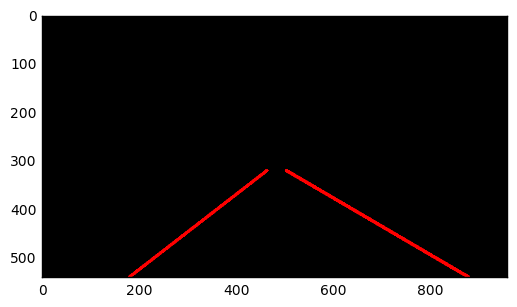

In [33]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Left Lane
[ 243.  398.  254.  440.  218.  441.  195.  325.  123.  246.  310.  449.
  112.  208.  217.  329.  338.  453.  126.  245.  111.  186.  124.  227.]
[ 464.  360.  447.  339.  478.  338.  493.  418.  528.  452.  413.  332.
  533.  486.  479.  414.  396.  329.  539.  453.  534.  500.  538.  464.]
Right Lane
[ 523.  663.  515.  775.  658.  762.  664.  757.  517.  744.  666.  758.]
[ 331.  425.  322.  497.  427.  497.  425.  497.  324.  488.  425.  497.]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]  0%|          | 1/682 [00:00<02:56,  3.85it/s]

Left Lane
[ 243.  398.  254.  440.  218.  441.  195.  325.  123.  246.  310.  449.
  112.  208.  217.  329.  338.  453.  126.  245.  111.  186.  124.  227.]
[ 464.  360.  447.  339.  478.  338.  493.  418.  528.  452.  413.  332.
  533.  486.  479.  414.  396.  329.  539.  453.  534.  500.  538.  464.]
Right Lane
[ 523.  663.  515.  775.  658.  762.  664.  757.  517.  744.  666.  758.]
[ 331.  425.  322.  497.  427.  497.  425.  497.  324.  488.  425.  497.]


  0%|          | 2/682 [00:00<02:59,  3.79it/s]

Left Lane
[ 299.  460.  276.  446.  220.  313.  194.  313.  118.  214.  125.  296.
  106.  189.  218.  316.  232.  311.  137.  244.  193.  424.]
[ 422.  322.  442.  335.  479.  412.  484.  420.  530.  483.  538.  431.
  538.  487.  470.  430.  461.  426.  520.  454.  495.  350.]
Right Lane
[ 511.  830.  681.  832.  576.  813.  529.  717.  730.  831.  535.  729.
  752.  827.  685.  775.  523.  683.  617.  818.  523.  681.]
[ 320.  535.  444.  532.  363.  535.  333.  469.  478.  532.  326.  477.
  481.  535.  439.  509.  331.  439.  396.  522.  332.  439.]


  0%|          | 3/682 [00:00<03:13,  3.51it/s]

Left Lane
[ 211.  450.  266.  438.  127.  294.  209.  306.  277.  460.  225.  311.
  349.  458.  176.  290.  213.  291.]
[ 476.  327.  449.  341.  538.  433.  477.  425.  436.  322.  467.  421.
  392.  324.  496.  440.  483.  445.]
Right Lane
[ 513.  753.  622.  823.  515.  797.  510.  713.  714.  819.  723.  803.
  515.  710.  623.  839.  719.  798.  524.  634.  707.  783.]
[ 320.  494.  401.  527.  320.  525.  320.  457.  457.  539.  461.  528.
  325.  457.  403.  538.  459.  525.  332.  401.  457.  501.]


  1%|          | 4/682 [00:01<03:54,  2.89it/s]

Left Lane
[ 164.  379.  293.  434.  143.  265.  220.  450.  205.  402.  262.  377.
  153.  265.  261.  370.  223.  460.  134.  249.  238.  341.  196.  271.
  172.  269.  292.  457.]
[ 505.  380.  426.  344.  530.  453.  482.  327.  480.  366.  464.  375.
  524.  464.  464.  379.  470.  322.  524.  462.  469.  404.  497.  460.
  512.  460.  428.  325.]
Right Lane
[ 510.  747.  749.  838.  739.  820.  515.  769.  513.  636.  518.  744.
  563.  796.  748.  840.  526.  648.]
[ 320.  480.  480.  536.  480.  538.  320.  504.  323.  412.  323.  487.
  354.  523.  480.  538.  334.  411.]


  1%|          | 5/682 [00:03<11:05,  1.02it/s]  1%|          | 6/682 [00:03<08:13,  1.37it/s]

Left Lane
[ 202.  455.  321.  435.  133.  241.  115.  460.  260.  399.  190.  265.
  321.  456.  345.  452.  115.  457.]
[ 485.  327.  416.  344.  538.  470.  538.  322.  456.  369.  503.  453.
  417.  326.  402.  330.  539.  325.]
Right Lane
[ 519.  655.  517.  661.  526.  658.  580.  662.  510.  663.  515.  656.]
[ 324.  423.  326.  423.  334.  423.  372.  423.  320.  423.  320.  423.]
Left Lane
[ 117.  458.  294.  400.  187.  307.  309.  453.  220.  314.  346.  452.
  301.  455.  225.  324.  118.  344.]
[ 538.  325.  435.  368.  507.  427.  427.  330.  484.  416.  397.  326.
  432.  328.  481.  410.  539.  398.]
Right Lane
[ 514.  680.  514.  684.  515.  599.  510.  670.  527.  616.]
[ 324.  436.  321.  435.  320.  385.  320.  436.  334.  390.]


  1%|          | 7/682 [00:04<06:52,  1.63it/s]

Left Lane
[ 119.  455.  221.  390.  357.  460.  344.  445.  138.  214.  311.  394.
  290.  449.  305.  395.]
[ 538.  328.  484.  378.  391.  322.  405.  337.  538.  490.  425.  377.
  440.  333.  429.  377.]
Right Lane
[ 513.  708.  511.  692.  529.  710.]
[ 321.  452.  320.  451.  336.  449.]


  1%|          | 8/682 [00:04<05:48,  1.94it/s]

Left Lane
[ 120.  449.  251.  386.  323.  448.  342.  456.  231.  383.  334.  441.
  248.  326.]
[ 538.  332.  464.  379.  418.  328.  400.  324.  477.  382.  411.  339.
  467.  415.]
Right Lane
[ 529.  731.  516.  722.  539.  721.  531.  720.  513.  634.  538.  725.]
[ 335.  471.  320.  470.  324.  466.  321.  468.  320.  407.  324.  470.]


  1%|▏         | 9/682 [00:04<04:57,  2.26it/s]

Left Lane
[ 283.  443.  120.  445.  141.  309.  229.  378.  352.  444.]
[ 445.  337.  538.  335.  539.  426.  479.  386.  393.  331.]
Right Lane
[ 512.  654.  531.  652.  518.  657.  516.  658.  531.  649.]
[ 320.  416.  335.  417.  320.  414.  321.  417.  336.  416.]


  1%|▏         | 10/682 [00:05<04:56,  2.27it/s]

Left Lane
[ 141.  216.  120.  445.  278.  372.  306.  446.  355.  454.  369.  456.
  263.  372.  270.  373.  332.  445.  371.  450.]
[ 538.  488.  538.  335.  447.  388.  430.  329.  391.  325.  392.  324.
  457.  389.  454.  390.  412.  330.  392.  330.]
Right Lane
[ 532.  669.  520.  678.  533.  666.  518.  678.]
[ 336.  428.  327.  426.  337.  427.  320.  428.]


  2%|▏         | 11/682 [00:05<04:36,  2.42it/s]

Left Lane
[ 133.  441.  144.  433.  229.  429.  277.  442.  210.  362.]
[ 531.  338.  539.  344.  482.  347.  440.  337.  483.  395.]
Right Lane
[ 533.  689.  520.  701.  525.  697.  559.  698.]
[ 337.  442.  327.  440.  326.  442.  355.  442.]


  2%|▏         | 12/682 [00:06<04:24,  2.53it/s]

Left Lane
[ 144.  443.  305.  443.  159.  353.  254.  351.  223.  355.  246.  371.
  284.  438.  144.  430.  240.  354.  369.  445.]
[ 538.  336.  424.  331.  515.  403.  455.  403.  475.  405.  460.  387.
  436.  339.  539.  346.  464.  404.  382.  334.]
Right Lane
[ 523.  717.  521.  730.  653.  729.  562.  720.]
[ 329.  460.  327.  458.  409.  460.  354.  460.]


  2%|▏         | 13/682 [00:06<03:58,  2.80it/s]

Left Lane
[ 208.  431.  146.  419.  306.  454.  281.  440.  202.  339.  179.  274.
  154.  341.  340.  451.  186.  337.]
[ 485.  345.  538.  354.  424.  325.  440.  333.  489.  409.  504.  453.
  520.  412.  415.  328.  499.  412.]
Right Lane
[ 524.  751.  522.  762.  612.  738.  659.  766.  514.  755.  523.  766.]
[ 330.  483.  328.  478.  383.  474.  422.  484.  321.  484.  329.  481.]


  2%|▏         | 14/682 [00:06<03:38,  3.05it/s]

Left Lane
[ 147.  415.  328.  439.  256.  440.  289.  454.  246.  328.  133.  243.
  127.  235.  356.  447.  284.  393.]
[ 538.  357.  409.  339.  457.  333.  436.  325.  472.  424.  534.  475.
  538.  480.  398.  332.  439.  371.]
Right Lane
[ 523.  801.  524.  765.  514.  803.  537.  685.  689.  811.]
[ 329.  516.  329.  480.  321.  516.  340.  432.  433.  515.]


  2%|▏         | 15/682 [00:06<03:23,  3.27it/s]

Left Lane
[ 298.  430.  201.  385.  249.  345.  184.  308.  268.  452.  149.  349.
  339.  452.]
[ 436.  346.  504.  371.  462.  406.  503.  437.  450.  326.  538.  403.
  409.  327.]
Right Lane
[ 514.  790.  528.  755.  713.  838.  515.  838.  512.  791.  524.  729.
  538.  708.]
[ 322.  508.  331.  473.  448.  539.  320.  538.  320.  508.  330.  458.
  341.  447.]


  2%|▏         | 16/682 [00:07<03:20,  3.33it/s]

Left Lane
[ 267.  418.  275.  443.  151.  331.  206.  291.  348.  436.  228.  452.
  312.  414.  190.  283.]
[ 450.  355.  457.  335.  538.  416.  491.  434.  396.  341.  477.  326.
  421.  357.  512.  454.]
Right Lane
[ 513.  795.  516.  839.  541.  743.  512.  783.  542.  739.]
[ 320.  510.  321.  538.  342.  468.  320.  503.  344.  467.]


  2%|▏         | 17/682 [00:07<03:36,  3.07it/s]

Left Lane
[ 184.  452.  153.  268.  244.  448.  319.  427.  133.  261.  174.  299.
  252.  443.  132.  232.  155.  248.  359.  437.  211.  386.]
[ 506.  326.  538.  460.  479.  330.  416.  348.  538.  464.  511.  438.
  479.  330.  538.  484.  523.  473.  396.  335.  487.  377.]
Right Lane
[ 515.  656.  518.  661.  542.  650.  516.  660.  525.  652.]
[ 323.  418.  321.  418.  344.  417.  321.  418.  331.  417.]


  3%|▎         | 18/682 [00:07<03:32,  3.13it/s]

Left Lane
[ 203.  447.  151.  452.  203.  449.  348.  443.  148.  268.  364.  441.
  135.  210.  136.  222.  235.  382.]
[ 509.  331.  529.  326.  508.  329.  404.  330.  530.  460.  387.  331.
  538.  510.  538.  507.  472.  380.]
Right Lane
[ 526.  670.  517.  684.  528.  668.  527.  682.]
[ 332.  429.  325.  429.  334.  429.  332.  429.]


  3%|▎         | 19/682 [00:08<03:55,  2.82it/s]

Left Lane
[ 199.  447.  192.  284.  180.  261.  359.  436.  350.  438.  200.  304.
  312.  392.  170.  280.  154.  249.]
[ 497.  330.  512.  449.  522.  464.  396.  340.  402.  333.  495.  434.
  428.  374.  515.  451.  538.  474.]
Right Lane
[ 527.  691.  527.  706.  519.  684.]
[ 332.  443.  331.  443.  322.  442.]


  3%|▎         | 20/682 [00:08<03:28,  3.17it/s]

Left Lane
[ 193.  336.  136.  447.  136.  446.  177.  263.  351.  434.  324.  435.]
[ 513.  410.  539.  329.  538.  329.  524.  462.  401.  336.  420.  334.]
Right Lane
[ 527.  719.  517.  736.  519.  727.]
[ 332.  461.  324.  460.  321.  461.]


  3%|▎         | 21/682 [00:08<03:14,  3.39it/s]

Left Lane
[ 134.  445.  334.  437.  254.  384.  155.  243.  357.  435.  246.  349.
  322.  439.  202.  324.  259.  361.]
[ 538.  329.  412.  337.  467.  379.  538.  475.  390.  334.  474.  394.
  420.  335.  506.  411.  465.  386.]
Right Lane
[ 520.  642.  550.  657.  513.  642.  535.  647.  550.  654.]
[ 321.  409.  348.  410.  320.  401.  335.  411.  347.  412.]


  3%|▎         | 22/682 [00:08<03:05,  3.55it/s]

Left Lane
[ 134.  443.  260.  377.  311.  396.  154.  256.  193.  294.  228.  379.
  233.  329.]
[ 538.  330.  462.  383.  426.  368.  539.  465.  511.  438.  474.  379.
  483.  414.]
Right Lane
[ 530.  676.  553.  672.  519.  622.  555.  670.  530.  673.  521.  627.
  518.  676.  522.  669.  562.  638.]
[ 332.  423.  349.  423.  321.  390.  351.  423.  333.  423.  321.  392.
  323.  421.  324.  423.  356.  404.]


  3%|▎         | 23/682 [00:09<02:56,  3.74it/s]

Left Lane
[ 133.  428.  308.  436.  225.  310.  160.  271.  220.  395.  324.  399.
  277.  409.  341.  432.]
[ 538.  339.  430.  337.  488.  427.  534.  454.  479.  369.  410.  366.
  442.  359.  407.  336.]
Right Lane
[ 518.  696.  518.  686.  522.  637.  519.  676.]
[ 324.  435.  323.  436.  322.  405.  325.  431.]


  4%|▎         | 24/682 [00:09<02:52,  3.82it/s]

Left Lane
[ 167.  445.  166.  251.  304.  436.  132.  259.  165.  288.  222.  394.
  203.  360.  349.  431.  337.  428.]
[ 516.  329.  528.  470.  433.  337.  538.  464.  516.  444.  478.  370.
  502.  396.  395.  336.  410.  344.]
Right Lane
[ 519.  725.  540.  709.  559.  718.]
[ 324.  453.  338.  452.  354.  453.]


  4%|▎         | 25/682 [00:09<02:48,  3.90it/s]

Left Lane
[ 293.  432.  155.  238.  134.  277.  269.  367.  214.  440.  252.  438.
  345.  433.  209.  309.  249.  343.  348.  431.]
[ 442.  341.  539.  479.  539.  443.  459.  383.  486.  334.  471.  336.
  409.  335.  501.  423.  473.  400.  406.  336.]
Right Lane
[ 513.  735.  657.  747.  521.  612.  520.  733.  520.  742.]
[ 320.  459.  418.  474.  324.  381.  325.  468.  326.  464.]


  4%|▍         | 26/682 [00:09<02:48,  3.90it/s]

Left Lane
[ 263.  431.  137.  442.  158.  331.  338.  436.  296.  424.  173.  298.
  183.  301.  137.  251.]
[ 465.  343.  539.  333.  537.  420.  405.  334.  442.  349.  528.  431.
  521.  429.  538.  472.]
Right Lane
[ 515.  772.  566.  719.  516.  786.  573.  722.]
[ 321.  494.  360.  449.  320.  502.  365.  451.]


  4%|▍         | 27/682 [00:10<02:46,  3.93it/s]

Left Lane
[ 159.  315.  139.  433.  316.  437.  210.  318.  315.  404.  317.  431.]
[ 539.  426.  539.  340.  432.  337.  501.  428.  431.  357.  432.  336.]
Right Lane
[ 631.  848.  516.  733.  514.  625.  571.  699.  738.  848.  629.  830.
  537.  626.  633.  737.]
[ 393.  539.  320.  466.  321.  396.  362.  442.  469.  538.  393.  528.
  338.  393.  393.  468.]


  4%|▍         | 28/682 [00:10<02:45,  3.96it/s]

Left Lane
[ 165.  428.  139.  431.  299.  429.  304.  443.  272.  406.  229.  416.]
[ 535.  344.  538.  341.  446.  337.  446.  330.  459.  355.  490.  354.]
Right Lane
[ 599.  778.  523.  733.  586.  812.  515.  642.  539.  647.  526.  635.
  728.  831.]
[ 373.  493.  327.  458.  371.  513.  320.  399.  338.  401.  324.  403.
  461.  526.]


  4%|▍         | 29/682 [00:10<02:40,  4.07it/s]

Left Lane
[ 140.  421.  161.  414.  299.  429.  333.  421.  272.  443.  139.  433.
  170.  282.]
[ 539.  349.  539.  355.  431.  337.  408.  344.  464.  330.  538.  339.
  531.  461.]
Right Lane
[ 524.  661.  525.  600.]
[ 326.  411.  325.  379.]


  4%|▍         | 30/682 [00:10<02:31,  4.30it/s]

Left Lane
[ 142.  423.  162.  398.  309.  389.  157.  251.  247.  351.  238.  333.]
[ 537.  347.  539.  367.  423.  373.  488.  485.  489.  402.  489.  415.]
Right Lane
[ 586.  674.  529.  675.  516.  666.]
[ 369.  423.  325.  423.  320.  421.]
Left Lane
[ 194.  379.  141.  417.  326.  418.  162.  406.  227.  429.]
[ 517.  382.  538.  352.  413.  346.  539.  361.  479.  342.]
Right Lane

  5%|▍         | 31/682 [00:11<02:29,  4.36it/s]  5%|▍         | 32/682 [00:11<03:05,  3.51it/s]


[ 517.  620.  527.  619.  518.  693.]
[ 320.  390.  328.  390.  320.  430.]
Left Lane
[ 183.  422.  166.  374.  143.  247.  331.  425.  348.  429.  342.  427.
  163.  378.  142.  416.]
[ 510.  348.  537.  386.  539.  468.  417.  339.  397.  342.  409.  338.
  538.  382.  538.  353.]
Right Lane
[ 521.  714.  599.  716.  548.  639.  599.  718.]
[ 320.  450.  377.  450.  343.  395.  376.  450.]


  5%|▍         | 33/682 [00:11<03:50,  2.81it/s]

Left Lane
[ 163.  382.  144.  414.  348.  423.  339.  427.  310.  434.  323.  411.
  162.  262.]
[ 538.  379.  537.  354.  398.  340.  412.  338.  433.  336.  415.  351.
  525.  467.]
Right Lane
[ 519.  646.  521.  648.  633.  745.  541.  650.  529.  652.]
[ 320.  405.  320.  405.  391.  466.  337.  405.  328.  405.]


  5%|▍         | 34/682 [00:12<03:55,  2.76it/s]

Left Lane
[ 350.  429.  202.  410.  293.  441.  254.  388.  160.  243.  192.  386.
  176.  256.  329.  437.  309.  388.  165.  383.  144.  265.]
[ 395.  341.  498.  357.  446.  331.  473.  382.  527.  482.  505.  383.
  516.  473.  411.  333.  433.  383.  538.  380.  538.  456.]
Right Lane
[ 517.  631.  521.  670.  522.  661.  527.  621.  530.  666.  553.  663.]
[ 320.  397.  321.  414.  322.  415.  322.  390.  330.  415.  346.  410.]


  5%|▌         | 35/682 [00:12<03:44,  2.88it/s]

Left Lane
[ 285.  439.  223.  406.  166.  376.  301.  413.  193.  381.  257.  392.
  162.  261.  204.  381.  190.  286.]
[ 452.  332.  484.  360.  539.  386.  430.  354.  505.  387.  462.  364.
  526.  469.  497.  386.  507.  451.]
Right Lane
[ 531.  626.  519.  639.  519.  676.  518.  653.  523.  682.]
[ 330.  394.  321.  402.  320.  418.  320.  411.  320.  427.]


  5%|▌         | 36/682 [00:13<04:08,  2.60it/s]

Left Lane
[ 220.  421.  273.  439.  199.  395.  246.  337.  148.  233.  166.  325.
  261.  403.  146.  224.  334.  426.]
[ 488.  342.  461.  332.  501.  368.  480.  404.  536.  490.  538.  422.
  458.  362.  538.  485.  415.  338.]
Right Lane
[ 519.  674.  547.  694.  520.  676.  533.  707.  522.  701.]
[ 320.  424.  338.  437.  321.  418.  332.  441.  320.  441.]


  5%|▌         | 37/682 [00:13<03:54,  2.75it/s]

Left Lane
[ 187.  286.  289.  436.  166.  300.  220.  422.  183.  357.  326.  417.]
[ 511.  440.  449.  334.  538.  440.  488.  341.  527.  400.  421.  350.]
Right Lane
[ 652.  733.  520.  605.  524.  693.  535.  670.]
[ 410.  460.  321.  378.  322.  436.  330.  414.]


  6%|▌         | 38/682 [00:13<03:54,  2.75it/s]

Left Lane
[ 265.  434.  282.  433.  226.  405.  167.  345.  184.  275.  253.  352.
  277.  352.]
[ 467.  335.  444.  335.  484.  354.  538.  409.  512.  459.  474.  412.
  456.  409.]
Right Lane
[ 564.  669.  535.  670.  524.  704.  536.  614.  523.  612.]
[ 353.  418.  333.  417.  320.  441.  334.  383.  320.  380.]


  6%|▌         | 39/682 [00:14<04:13,  2.54it/s]

Left Lane
[ 311.  425.  202.  418.  173.  339.  167.  330.  243.  340.  190.  329.
  156.  335.  241.  431.  316.  418.  234.  339.  256.  334.]
[ 431.  342.  500.  343.  519.  423.  538.  420.  482.  421.  507.  420.
  531.  419.  484.  336.  427.  342.  476.  420.  472.  419.]
Right Lane
[ 577.  755.  521.  622.  523.  703.]
[ 361.  473.  320.  388.  320.  441.]


  6%|▌         | 40/682 [00:14<03:57,  2.70it/s]

Left Lane
[ 202.  418.  190.  269.  259.  335.  232.  397.  311.  427.  298.  374.
  159.  323.  277.  352.]
[ 499.  342.  521.  460.  468.  412.  476.  364.  435.  338.  438.  382.
  528.  433.  454.  399.]
Right Lane
[ 572.  735.  521.  640.  525.  715.  537.  641.]
[ 357.  459.  320.  394.  320.  448.  334.  394.]


  6%|▌         | 41/682 [00:15<04:03,  2.63it/s]

Left Lane
[ 190.  306.  251.  404.  296.  397.  145.  253.  289.  396.  291.  412.
  291.  401.  285.  429.  166.  250.  301.  369.  323.  419.]
[ 519.  434.  462.  358.  441.  357.  539.  461.  452.  363.  434.  352.
  453.  354.  449.  337.  539.  474.  453.  378.  421.  346.]
Right Lane
[ 524.  604.  525.  647.  522.  601.  542.  645.]
[ 325.  372.  321.  403.  321.  374.  338.  403.]


  6%|▌         | 42/682 [00:15<04:06,  2.59it/s]

Left Lane
[ 278.  395.  319.  429.  145.  227.  164.  294.  145.  246.  261.  418.
  306.  403.  260.  416.  288.  431.]
[ 445.  360.  424.  338.  538.  479.  538.  443.  539.  466.  474.  342.
  424.  358.  474.  343.  447.  336.]
Right Lane
[ 523.  606.  522.  609.  523.  603.  523.  670.]
[ 323.  379.  324.  375.  324.  378.  322.  414.]


  6%|▋         | 43/682 [00:15<04:16,  2.49it/s]

Left Lane
[ 164.  320.  152.  256.  260.  410.  302.  429.  222.  416.  270.  350.
  150.  239.  205.  391.]
[ 537.  423.  531.  460.  457.  348.  436.  337.  484.  343.  459.  400.
  533.  504.  494.  368.]
Right Lane
[ 523.  671.  524.  672.  524.  621.]
[ 325.  424.  324.  424.  323.  383.]


  6%|▋         | 44/682 [00:16<04:05,  2.59it/s]

Left Lane
[ 163.  311.  143.  224.  268.  407.  323.  433.  304.  431.  310.  418.
  206.  283.]
[ 538.  430.  538.  483.  452.  351.  421.  335.  435.  336.  421.  342.
  495.  450.]
Right Lane
[ 594.  700.  544.  632.  527.  632.]
[ 373.  439.  340.  391.  329.  390.]


  7%|▋         | 45/682 [00:16<03:53,  2.72it/s]

Left Lane
[ 283.  435.  226.  394.  185.  279.  226.  331.  213.  317.  236.  381.]
[ 452.  334.  481.  367.  510.  455.  482.  416.  504.  417.  475.  377.]
Right Lane
[ 517.  643.  514.  635.  548.  729.]
[ 321.  399.  320.  401.  345.  458.]


  7%|▋         | 46/682 [00:16<03:40,  2.89it/s]

Left Lane
[ 217.  398.  308.  437.  249.  344.  161.  304.  225.  328.  210.  323.
  187.  280.]
[ 487.  364.  433.  333.  477.  397.  526.  436.  482.  417.  492.  421.
  508.  454.]
Right Lane
[ 518.  755.  528.  660.  549.  641.  518.  660.]
[ 320.  480.  332.  409.  346.  404.  322.  411.]


  7%|▋         | 47/682 [00:17<04:21,  2.43it/s]

Left Lane
[ 279.  432.  261.  407.  262.  382.  154.  258.  186.  301.  336.  439.
  145.  244.  166.  283.  162.  240.  179.  256.  146.  229.  211.  424.]
[ 455.  336.  458.  352.  466.  385.  531.  460.  524.  428.  412.  332.
  538.  481.  539.  441.  526.  484.  529.  460.  537.  492.  493.  339.]
Right Lane
[ 516.  678.  519.  659.  517.  669.  515.  637.  551.  678.]
[ 320.  422.  323.  417.  320.  422.  321.  403.  348.  421.]


  7%|▋         | 48/682 [00:17<04:33,  2.31it/s]

Left Lane
[ 209.  424.  241.  369.  235.  314.  146.  231.  267.  405.  165.  268.
  145.  224.]
[ 495.  339.  482.  389.  488.  427.  539.  478.  464.  357.  538.  463.
  538.  484.]
Right Lane
[ 592.  690.  513.  695.  519.  667.  561.  699.  554.  693.  512.  594.
  554.  683.]
[ 369.  435.  321.  435.  322.  422.  355.  435.  349.  430.  320.  371.
  350.  431.]


  7%|▋         | 49/682 [00:18<04:27,  2.37it/s]

Left Lane
[ 289.  433.  221.  422.  146.  300.  249.  342.  249.  359.  149.  224.
  220.  361.]
[ 447.  335.  486.  340.  539.  428.  477.  399.  476.  396.  535.  495.
  498.  395.]
Right Lane
[ 518.  684.  543.  686.  557.  717.  516.  723.  517.  671.]
[ 320.  432.  342.  425.  351.  451.  322.  451.  321.  417.]


  7%|▋         | 50/682 [00:18<04:29,  2.35it/s]

Left Lane
[ 295.  430.  182.  397.  239.  347.  164.  350.  196.  354.  230.  372.
  211.  352.  354.  435.]
[ 442.  337.  513.  357.  484.  394.  538.  403.  502.  403.  479.  376.
  491.  403.  397.  334.]
Right Lane
[ 522.  701.  531.  750.  602.  692.  607.  747.]
[ 322.  442.  334.  471.  377.  429.  377.  471.]


  7%|▋         | 51/682 [00:19<04:24,  2.38it/s]

Left Lane
[ 271.  411.  164.  333.  326.  416.  182.  339.  340.  437.  214.  420.
  322.  433.  162.  341.  208.  301.  165.  337.]
[ 448.  353.  538.  415.  418.  343.  511.  413.  399.  333.  490.  341.
  421.  335.  525.  413.  505.  437.  538.  413.]
Right Lane
[ 520.  675.  549.  788.  518.  679.  534.  775.]
[ 322.  426.  346.  496.  323.  423.  336.  487.]


  8%|▊         | 52/682 [00:19<03:58,  2.64it/s]

Left Lane
[ 258.  413.  199.  301.  282.  419.  314.  398.  171.  321.  317.  420.
  180.  415.  176.  251.  312.  434.  332.  418.  196.  312.  145.  324.]
[ 457.  352.  512.  437.  440.  347.  427.  357.  519.  425.  428.  341.
  514.  344.  531.  473.  419.  336.  414.  342.  501.  428.  537.  425.]
Right Lane
[ 518.  696.  539.  788.  524.  701.  519.  702.  520.  703.]
[ 320.  440.  340.  496.  327.  437.  323.  437.  323.  437.]


  8%|▊         | 53/682 [00:19<03:31,  2.97it/s]

Left Lane
[ 215.  404.  194.  272.  299.  436.  299.  417.  177.  307.  213.  344.
  236.  413.  298.  420.  188.  309.  302.  396.  339.  438.]
[ 487.  359.  517.  457.  428.  335.  442.  343.  514.  432.  501.  405.
  472.  352.  443.  341.  506.  430.  444.  359.  400.  333.]
Right Lane
[ 541.  798.  512.  730.  536.  773.  514.  641.]
[ 342.  503.  320.  456.  338.  486.  320.  399.]


  8%|▊         | 54/682 [00:19<03:15,  3.21it/s]

Left Lane
[ 208.  357.  166.  402.  283.  424.  163.  276.  148.  288.  187.  277.
  206.  410.  361.  437.  181.  272.  165.  283.  176.  280.]
[ 504.  395.  521.  361.  441.  339.  538.  462.  534.  459.  520.  459.
  493.  355.  392.  333.  511.  458.  522.  459.  528.  458.]
Right Lane
[ 540.  647.  512.  655.  537.  649.  515.  603.]
[ 342.  409.  320.  409.  339.  409.  321.  376.]


  8%|▊         | 55/682 [00:20<03:06,  3.37it/s]

Left Lane
[ 163.  303.  212.  411.  242.  392.  160.  305.  357.  437.  315.  394.
  242.  378.  173.  307.  325.  437.  150.  275.  263.  426.]
[ 538.  436.  489.  354.  487.  362.  525.  434.  387.  333.  417.  367.
  484.  378.  516.  432.  410.  334.  532.  447.  465.  338.]
Right Lane
[ 541.  672.  512.  670.  521.  605.  512.  612.]
[ 343.  419.  321.  420.  328.  384.  320.  382.]


  8%|▊         | 56/682 [00:20<02:55,  3.58it/s]

Left Lane
[ 141.  224.  161.  339.  287.  426.  142.  403.  199.  364.  199.  354.
  292.  379.  193.  294.  201.  323.]
[ 538.  482.  538.  408.  438.  338.  537.  360.  517.  388.  516.  395.
  433.  378.  516.  432.  520.  411.]
Right Lane
[ 522.  687.  513.  689.  512.  615.  513.  614.]
[ 329.  432.  321.  431.  321.  390.  322.  390.]


  8%|▊         | 57/682 [00:20<02:49,  3.69it/s]

Left Lane
[ 311.  427.  226.  420.  245.  395.  194.  318.  344.  435.  184.  313.
  165.  301.  171.  306.]
[ 427.  342.  492.  341.  467.  359.  501.  423.  402.  335.  508.  427.
  521.  436.  517.  432.]
Right Lane
[ 513.  712.  523.  625.  516.  631.  629.  710.  515.  630.  524.  628.
  543.  706.]
[ 322.  446.  329.  397.  320.  397.  392.  446.  320.  397.  327.  397.
  344.  446.]


  9%|▊         | 58/682 [00:20<02:44,  3.80it/s]

Left Lane
[ 160.  264.  162.  304.  293.  440.  323.  399.  239.  428.  248.  420.
  142.  223.  162.  245.]
[ 525.  454.  538.  434.  432.  332.  420.  357.  470.  342.  476.  342.
  538.  483.  539.  478.]
Right Lane
[ 510.  636.  511.  744.  544.  734.  629.  844.]
[ 320.  405.  320.  466.  346.  465.  393.  538.]


  9%|▊         | 59/682 [00:21<02:46,  3.75it/s]

Left Lane
[ 142.  229.  161.  299.  296.  441.  251.  353.  292.  426.  172.  249.
  272.  365.  258.  422.  347.  433.  201.  370.  336.  435.]
[ 537.  478.  538.  437.  429.  331.  461.  397.  442.  338.  516.  464.
  446.  388.  468.  340.  400.  337.  510.  378.  401.  334.]
Right Lane
[ 511.  621.  548.  662.  514.  652.  511.  643.]
[ 321.  395.  347.  413.  321.  414.  320.  409.]


  9%|▉         | 60/682 [00:21<02:43,  3.80it/s]

Left Lane
[ 210.  422.  192.  284.  344.  426.  230.  313.  246.  412.  314.  397.
  236.  320.  311.  441.  235.  310.]
[ 501.  346.  503.  437.  397.  338.  487.  418.  476.  347.  416.  364.
  483.  413.  426.  331.  473.  419.]
Right Lane
[ 510.  652.  519.  680.  527.  675.  549.  672.  515.  680.]
[ 320.  415.  325.  426.  334.  426.  349.  426.  322.  425.]


  9%|▉         | 61/682 [00:21<02:41,  3.85it/s]

Left Lane
[ 160.  420.  251.  441.  158.  265.  294.  421.  201.  427.  139.  283.
  207.  424.]
[ 538.  349.  460.  331.  525.  452.  440.  341.  495.  342.  538.  448.
  503.  345.]
Right Lane
[ 519.  691.  553.  705.  554.  695.  567.  699.]
[ 324.  440.  351.  439.  353.  441.  359.  435.]


  9%|▉         | 62/682 [00:21<02:39,  3.89it/s]

Left Lane
[ 164.  437.  282.  420.  158.  423.  157.  438.  213.  439.]
[ 519.  334.  448.  341.  538.  345.  538.  333.  485.  332.]
Right Lane
[ 530.  725.  510.  732.  555.  723.  516.  733.  644.  721.]
[ 336.  458.  320.  458.  353.  458.  323.  458.  410.  458.]


  9%|▉         | 63/682 [00:22<02:39,  3.88it/s]

Left Lane
[ 151.  439.  155.  437.  156.  413.  270.  392.  219.  435.  285.  406.]
[ 527.  332.  538.  333.  539.  353.  456.  361.  480.  334.  445.  351.]
Right Lane
[ 660.  756.  513.  765.  558.  719.  513.  714.  661.  757.]
[ 420.  480.  322.  480.  355.  448.  321.  446.  420.  480.]


  9%|▉         | 64/682 [00:22<02:38,  3.90it/s]

Left Lane
[ 135.  291.  156.  439.  156.  420.  136.  433.  332.  407.]
[ 539.  433.  538.  332.  539.  347.  537.  336.  403.  356.]
Right Lane
[ 564.  806.  511.  687.  515.  716.  521.  614.  513.  690.]
[ 359.  510.  320.  430.  320.  446.  327.  389.  320.  439.]


 10%|▉         | 65/682 [00:22<02:37,  3.92it/s]

Left Lane
[ 279.  439.  156.  434.  136.  436.  339.  424.  156.  441.]
[ 440.  332.  539.  337.  538.  335.  400.  339.  538.  331.]
Right Lane
[ 704.  845.  509.  709.  533.  627.  567.  832.  513.  712.  510.  710.]
[ 448.  536.  320.  445.  338.  396.  361.  527.  321.  445.  320.  445.]


 10%|▉         | 66/682 [00:23<03:37,  2.83it/s]

Left Lane
[ 272.  441.  211.  341.  156.  433.  137.  440.  157.  434.]
[ 445.  331.  487.  405.  539.  338.  537.  332.  538.  337.]
Right Lane
[ 572.  848.  510.  635.  516.  638.  510.  593.  641.  742.  509.  740.]
[ 365.  538.  320.  404.  322.  404.  321.  377.  401.  464.  320.  464.]


 10%|▉         | 67/682 [00:23<03:34,  2.87it/s]

Left Lane
[ 158.  434.  138.  441.  138.  290.  157.  252.]
[ 539.  338.  537.  332.  538.  435.  538.  469.]
Right Lane
[ 536.  653.  773.  848.  511.  600.  509.  659.  513.  598.]
[ 341.  414.  491.  538.  322.  382.  320.  414.  320.  377.]


 10%|▉         | 68/682 [00:23<03:30,  2.92it/s]

Left Lane
[ 158.  434.  279.  445.  303.  435.  127.  231.  314.  444.]
[ 539.  338.  441.  329.  426.  337.  507.  503.  418.  330.]
Right Lane
[ 514.  668.  522.  672.  540.  669.  510.  675.  509.  671.  538.  671.]
[ 321.  425.  331.  425.  344.  425.  322.  425.  320.  421.  342.  425.]


 10%|█         | 69/682 [00:24<03:24,  3.00it/s]

Left Lane
[ 157.  294.  138.  437.  317.  429.  168.  380.  172.  322.  298.  406.
  158.  421.  276.  445.  221.  446.]
[ 538.  439.  538.  336.  424.  337.  537.  372.  537.  412.  428.  360.
  539.  348.  443.  329.  481.  329.]
Right Lane
[ 507.  617.  508.  697.  527.  696.]
[ 320.  394.  320.  438.  333.  439.]


 10%|█         | 70/682 [00:24<03:16,  3.12it/s]

Left Lane
[ 158.  436.  158.  446.  138.  354.  177.  323.]
[ 539.  337.  524.  329.  538.  392.  512.  420.]
Right Lane
[ 514.  716.  508.  707.  514.  726.  513.  722.  594.  714.  524.  724.]
[ 320.  456.  320.  454.  323.  455.  325.  455.  379.  454.  330.  455.]


 10%|█         | 71/682 [00:24<03:12,  3.18it/s]

Left Lane
[ 157.  254.  138.  437.  165.  446.  274.  385.  288.  405.  158.  438.
  295.  421.]
[ 538.  468.  538.  336.  519.  329.  455.  369.  445.  354.  538.  335.
  440.  342.]
Right Lane
[ 510.  738.  508.  640.  544.  649.  507.  736.  539.  640.]
[ 321.  474.  320.  409.  347.  408.  320.  474.  339.  402.]


 11%|█         | 72/682 [00:25<03:06,  3.28it/s]

Left Lane
[ 157.  446.  238.  368.  332.  429.  229.  365.  299.  377.  137.  441.
  305.  424.  281.  395.  298.  375.]
[ 539.  329.  469.  387.  407.  337.  475.  390.  428.  386.  538.  333.
  433.  340.  440.  368.  437.  385.]
Right Lane
[ 507.  656.  581.  663.  515.  630.  525.  613.  511.  640.]
[ 320.  420.  365.  420.  324.  396.  334.  388.  323.  410.]


 11%|█         | 73/682 [00:25<03:01,  3.35it/s]

Left Lane
[ 157.  446.  157.  240.  351.  431.  188.  362.  137.  436.  137.  440.
  286.  416.  296.  422.]
[ 539.  329.  538.  478.  394.  336.  503.  394.  539.  337.  538.  333.
  447.  346.  440.  342.]
Right Lane
[ 513.  679.  507.  666.  550.  686.  508.  675.]
[ 320.  432.  320.  427.  351.  430.  320.  432.]


 11%|█         | 74/682 [00:25<02:53,  3.50it/s]

Left Lane
[ 177.  443.  346.  433.  137.  448.  157.  242.  294.  389.  283.  368.
  223.  359.]
[ 525.  332.  398.  335.  538.  328.  539.  468.  433.  373.  441.  388.
  491.  399.]
Right Lane
[ 508.  665.  559.  711.  511.  701.  512.  635.  553.  704.  508.  699.
  507.  711.]
[ 321.  427.  358.  446.  320.  448.  320.  403.  354.  448.  320.  448.
  320.  448.]


 11%|█         | 75/682 [00:25<02:50,  3.57it/s]

Left Lane
[ 138.  443.  158.  448.  316.  446.  348.  429.  346.  423.  283.  427.
  277.  404.  158.  241.]
[ 538.  332.  539.  328.  417.  329.  410.  337.  410.  341.  450.  338.
  454.  355.  538.  469.]
Right Lane
[ 507.  743.  508.  696.  652.  728.  516.  740.  512.  723.  559.  743.]
[ 320.  467.  321.  447.  412.  467.  328.  467.  321.  464.  358.  465.]


 11%|█         | 76/682 [00:26<02:44,  3.68it/s]

Left Lane
[ 172.  449.  349.  435.  139.  450.  291.  389.  158.  290.  289.  378.]
[ 529.  328.  396.  334.  537.  327.  435.  373.  539.  436.  437.  381.]
Right Lane
[ 510.  752.  512.  778.  661.  769.  559.  665.  517.  669.  506.  783.]
[ 321.  484.  323.  489.  426.  493.  358.  424.  329.  424.  320.  493.]


 11%|█▏        | 77/682 [00:26<02:45,  3.66it/s]

Left Lane
[ 219.  420.  138.  449.  196.  319.  328.  448.  159.  437.]
[ 496.  350.  538.  328.  511.  428.  409.  328.  539.  337.]
Right Lane
[ 513.  756.  693.  801.  507.  778.  681.  823.  511.  610.  505.  681.
  536.  687.]
[ 322.  486.  437.  515.  320.  489.  438.  527.  320.  392.  320.  439.
  343.  437.]


 11%|█▏        | 78/682 [00:26<02:42,  3.71it/s]

Left Lane
[ 158.  448.  325.  429.  185.  333.  139.  312.  138.  443.  292.  394.
  297.  413.  165.  435.]
[ 539.  328.  412.  337.  506.  413.  538.  421.  538.  332.  442.  363.
  439.  349.  534.  338.]
Right Lane
[ 513.  800.  506.  778.  706.  841.  533.  630.  523.  621.  512.  618.]
[ 321.  514.  320.  489.  454.  538.  340.  396.  328.  399.  321.  398.]


 12%|█▏        | 79/682 [00:26<02:39,  3.78it/s]

Left Lane
[ 158.  447.  335.  431.  171.  314.  289.  448.  288.  406.]
[ 539.  329.  405.  336.  529.  418.  436.  328.  437.  363.]
Right Lane
[ 511.  746.  742.  840.  512.  641.  534.  638.  520.  640.  506.  643.]
[ 322.  480.  477.  538.  325.  406.  341.  406.  331.  406.  320.  406.]


 12%|█▏        | 80/682 [00:27<02:39,  3.77it/s]

Left Lane
[ 157.  243.  236.  427.  137.  444.  138.  446.  157.  419.  243.  387.
  245.  406.  235.  335.  247.  364.]
[ 538.  476.  487.  338.  538.  331.  537.  329.  539.  349.  488.  367.
  488.  353.  487.  403.  488.  383.]
Right Lane
[ 513.  652.  536.  654.  511.  657.  506.  658.]
[ 321.  415.  342.  415.  324.  415.  320.  415.]


 12%|█▏        | 81/682 [00:27<02:32,  3.93it/s]

Left Lane
[ 236.  423.  256.  381.  137.  447.  136.  446.  161.  448.  323.  408.
   99.  215.]
[ 483.  347.  468.  371.  538.  329.  538.  329.  536.  328.  411.  353.
  521.  517.]
Right Lane
[ 506.  675.  512.  609.  513.  605.]
[ 320.  426.  320.  390.  322.  389.]


 12%|█▏        | 82/682 [00:27<02:30,  4.00it/s]

Left Lane
[ 200.  443.  181.  446.  200.  282.  156.  445.  135.  356.]
[ 494.  330.  521.  329.  507.  439.  539.  329.  538.  389.]
Right Lane
[ 506.  697.  513.  610.  595.  692.  512.  615.]
[ 320.  440.  322.  392.  375.  440.  320.  395.]


 12%|█▏        | 83/682 [00:27<02:32,  3.93it/s]

Left Lane
[ 134.  443.  198.  445.  163.  249.  178.  261.  290.  387.  155.  308.]
[ 538.  330.  508.  329.  533.  461.  522.  453.  442.  376.  539.  420.]
Right Lane
[ 510.  724.  511.  619.  522.  722.  513.  628.  542.  719.  516.  716.]
[ 323.  457.  320.  398.  332.  457.  320.  403.  346.  457.  323.  458.]


 12%|█▏        | 84/682 [00:28<02:31,  3.95it/s]

Left Lane
[ 134.  445.  167.  431.  224.  443.  134.  368.  337.  419.  350.  426.]
[ 539.  329.  530.  339.  490.  331.  538.  380.  400.  348.  391.  343.]
Right Lane
[ 513.  749.  507.  651.  525.  633.  514.  747.  506.  746.]
[ 320.  479.  320.  410.  334.  407.  325.  482.  320.  482.]


 12%|█▏        | 85/682 [00:28<02:30,  3.96it/s]

Left Lane
[ 155.  383.  134.  409.  305.  421.  291.  374.  216.  359.  173.  445.
  237.  388.]
[ 538.  373.  537.  351.  431.  341.  440.  388.  482.  392.  526.  329.
  468.  366.]
Right Lane
[ 506.  669.  507.  659.  512.  667.  515.  656.  510.  662.  516.  663.]
[ 320.  421.  321.  423.  320.  424.  327.  422.  321.  424.  324.  423.]
Left Lane
[ 133.  388.  190.  443.  296.  445.  239.  363.  338.  433.  357.  441.
  216.  332.]
[ 538.  366.  513.  330.  437.  329.  476.  392.  399.  339.  386.  333.
  493.  403.]


 13%|█▎        | 86/682 [00:28<02:21,  4.22it/s]

Right Lane
[ 506.  690.  542.  646.  507.  680.  512.  677.]
[ 320.  435.  341.  416.  320.  437.  325.  436.]


 13%|█▎        | 87/682 [00:28<02:17,  4.33it/s]

Left Lane
[ 152.  242.  131.  425.  347.  426.  270.  443.  201.  355.  238.  357.
  307.  400.]
[ 538.  473.  539.  340.  398.  344.  455.  330.  503.  399.  476.  401.
  428.  356.]
Right Lane
[ 552.  712.  513.  593.  506.  716.  628.  706.  511.  708.  628.  715.]
[ 353.  453.  322.  376.  320.  451.  404.  453.  320.  453.  403.  453.]


 13%|█▎        | 88/682 [00:29<02:20,  4.23it/s]

Left Lane
[ 130.  425.  208.  337.  153.  260.  339.  427.  339.  435.  205.  429.]
[ 539.  340.  498.  405.  537.  460.  407.  338.  411.  336.  488.  337.]
Right Lane
[ 507.  736.  508.  751.  512.  596.  506.  748.  512.  644.]
[ 320.  474.  321.  472.  320.  381.  320.  471.  325.  414.]


 13%|█▎        | 89/682 [00:29<02:31,  3.91it/s]

Left Lane
[ 201.  333.  129.  426.  243.  383.  252.  381.  341.  438.  234.  337.
  164.  295.  264.  394.  147.  429.  189.  325.  322.  399.  330.  412.]
[ 503.  408.  538.  338.  462.  374.  467.  374.  396.  335.  479.  399.
  529.  427.  448.  366.  527.  337.  510.  418.  421.  361.  421.  352.]
Right Lane
[ 509.  778.  533.  670.  507.  785.  511.  779.]
[ 320.  501.  340.  426.  320.  494.  320.  501.]


 13%|█▎        | 90/682 [00:29<02:27,  4.01it/s]

Left Lane
[ 154.  427.  246.  322.  195.  307.  331.  415.  191.  315.  340.  445.
  220.  342.]
[ 523.  339.  470.  418.  506.  430.  411.  346.  509.  431.  405.  329.
  490.  402.]
Right Lane
[ 511.  835.  531.  693.  677.  809.  506.  788.  521.  611.  512.  835.]
[ 320.  538.  339.  441.  437.  520.  320.  496.  327.  392.  321.  539.]


 13%|█▎        | 91/682 [00:29<02:33,  3.86it/s]

Left Lane
[ 221.  335.  185.  430.  282.  447.  286.  435.  193.  292.  153.  288.
  213.  295.  284.  425.  288.  443.]
[ 490.  408.  503.  338.  449.  329.  450.  334.  508.  446.  537.  446.
  494.  450.  450.  340.  443.  331.]
Right Lane
[ 508.  798.  505.  798.  507.  709.  589.  835.  510.  835.  534.  618.]
[ 320.  516.  320.  503.  322.  458.  372.  538.  320.  539.  342.  399.]


 13%|█▎        | 92/682 [00:30<02:32,  3.86it/s]

Left Lane
[ 241.  450.  152.  237.  255.  452.  171.  291.  181.  436.  159.  248.
  271.  382.  141.  263.  168.  282.]
[ 467.  327.  538.  480.  469.  326.  512.  442.  507.  335.  520.  472.
  456.  376.  532.  467.  514.  448.]
Right Lane
[ 639.  755.  595.  834.  508.  595.  508.  833.  505.  795.  504.  744.
  506.  644.]
[ 406.  484.  377.  538.  324.  379.  320.  539.  320.  515.  320.  482.
  321.  408.]


 14%|█▎        | 93/682 [00:30<02:32,  3.85it/s]

Left Lane
[ 178.  292.  261.  456.  135.  284.  337.  439.  354.  443.  231.  384.
  176.  298.  177.  435.  154.  236.  288.  374.]
[ 523.  441.  455.  324.  538.  438.  411.  332.  399.  330.  499.  371.
  524.  429.  511.  337.  538.  482.  445.  383.]
Right Lane
[ 509.  654.  508.  657.  512.  645.  503.  649.  507.  655.  502.  651.]
[ 322.  420.  320.  420.  329.  419.  321.  420.  320.  420.  320.  420.]


 14%|█▍        | 94/682 [00:30<02:29,  3.94it/s]

Left Lane
[ 258.  456.  136.  434.  220.  302.  349.  443.  136.  236.  156.  253.
   66.  192.]
[ 467.  324.  539.  338.  494.  435.  403.  330.  538.  471.  539.  469.
  538.  534.]
Right Lane
[ 513.  664.  507.  678.  502.  668.  512.  665.]
[ 330.  432.  325.  432.  320.  432.  329.  432.]


 14%|█▍        | 95/682 [00:30<02:32,  3.85it/s]

Left Lane
[ 213.  458.  262.  456.  158.  249.  341.  443.  152.  245.  136.  226.
  327.  455.  167.  281.  229.  332.  136.  438.]
[ 488.  323.  465.  324.  523.  474.  409.  330.  527.  477.  538.  490.
  419.  326.  517.  451.  487.  407.  539.  335.]
Right Lane
[ 514.  683.  506.  701.  507.  694.  587.  695.  511.  686.]
[ 331.  445.  324.  446.  321.  447.  380.  447.  328.  446.]


 14%|█▍        | 96/682 [00:31<02:26,  4.01it/s]

Left Lane
[ 254.  458.  137.  438.  171.  293.  247.  358.  236.  349.  157.  241.
  355.  445.  213.  352.  265.  364.]
[ 471.  323.  538.  335.  529.  434.  476.  390.  484.  396.  539.  469.
  399.  329.  488.  401.  463.  391.]
Right Lane
[ 511.  711.  502.  732.  505.  730.]
[ 328.  463.  320.  464.  323.  464.]


 14%|█▍        | 97/682 [00:31<02:24,  4.06it/s]

Left Lane
[ 215.  454.  137.  432.  374.  456.  136.  441.  221.  314.  354.  443.]
[ 498.  325.  538.  339.  388.  324.  538.  332.  493.  426.  399.  330.]
Right Lane
[ 508.  755.  528.  603.  506.  647.  526.  637.]
[ 322.  488.  340.  387.  323.  411.  338.  413.]


 14%|█▍        | 98/682 [00:31<02:21,  4.11it/s]

Left Lane
[ 137.  454.  157.  312.  367.  452.  137.  430.  198.  370.  366.  446.]
[ 539.  325.  539.  427.  394.  327.  538.  340.  510.  386.  393.  331.]
Right Lane
[ 514.  653.  508.  661.  508.  663.  505.  612.  516.  656.]
[ 329.  423.  320.  423.  324.  421.  320.  392.  330.  424.]


 15%|█▍        | 99/682 [00:31<02:22,  4.08it/s]

Left Lane
[ 138.  454.  157.  323.  137.  431.  358.  435.  250.  452.  362.  437.
  208.  364.]
[ 538.  325.  539.  419.  538.  339.  399.  339.  473.  327.  401.  333.
  503.  390.]
Right Lane
[ 515.  684.  559.  670.  544.  655.  513.  683.  564.  675.]
[ 329.  435.  354.  434.  344.  424.  327.  433.  361.  436.]


 15%|█▍        | 100/682 [00:32<02:20,  4.14it/s]

Left Lane
[ 157.  338.  137.  452.  348.  448.  347.  435.  286.  388.  209.  357.
  348.  439.  154.  421.]
[ 539.  408.  538.  326.  407.  329.  407.  334.  447.  368.  502.  395.
  408.  332.  526.  346.]
Right Lane
[ 507.  708.  510.  697.  511.  702.]
[ 322.  448.  325.  451.  322.  451.]


 15%|█▍        | 101/682 [00:32<02:23,  4.04it/s]

Left Lane
[ 157.  289.  211.  375.  327.  433.  328.  435.  352.  453.  163.  343.
  269.  355.  136.  449.  157.  330.  336.  414.  358.  441.]
[ 538.  443.  487.  384.  409.  342.  417.  334.  394.  326.  519.  415.
  448.  398.  539.  328.  539.  414.  416.  355.  396.  331.]
Right Lane
[ 504.  727.  513.  741.  505.  605.  516.  740.  508.  738.  557.  737.
  531.  741.]
[ 320.  470.  327.  470.  320.  382.  330.  470.  322.  466.  358.  470.
  337.  468.]


 15%|█▍        | 102/682 [00:32<02:22,  4.07it/s]

Left Lane
[ 362.  439.  135.  429.  322.  453.  165.  450.]
[ 393.  337.  539.  340.  421.  326.  519.  327.]
Right Lane
[ 505.  782.  510.  685.  672.  777.  507.  782.  681.  770.  517.  664.
  509.  764.]
[ 320.  493.  325.  443.  426.  496.  322.  494.  440.  496.  326.  425.
  323.  495.]


 15%|█▌        | 103/682 [00:32<02:24,  4.01it/s]

Left Lane
[ 135.  438.  156.  294.  305.  419.  328.  435.  135.  450.  338.  436.
  239.  314.]
[ 538.  333.  539.  439.  424.  352.  417.  334.  539.  327.  410.  339.
  478.  427.]
Right Lane
[ 507.  815.  696.  825.  505.  754.  513.  821.  682.  827.  510.  615.]
[ 322.  515.  450.  531.  320.  488.  323.  531.  441.  531.  320.  396.]


 15%|█▌        | 104/682 [00:33<02:28,  3.90it/s]

Left Lane
[ 331.  448.  185.  450.  264.  346.  163.  281.  186.  282.  190.  305.
  142.  290.  206.  291.  134.  427.  167.  284.  311.  453.]
[ 415.  330.  505.  327.  460.  404.  518.  455.  515.  455.  500.  433.
  532.  460.  501.  443.  539.  341.  529.  456.  429.  326.]
Right Lane
[ 506.  811.  709.  809.  510.  589.  511.  730.  512.  815.]
[ 321.  512.  459.  522.  320.  377.  325.  472.  326.  515.]


 15%|█▌        | 105/682 [00:33<02:55,  3.29it/s]

Left Lane
[ 196.  420.  265.  450.  232.  329.  154.  250.  357.  452.  255.  413.
  288.  405.  180.  258.]
[ 497.  346.  461.  327.  482.  416.  537.  477.  390.  326.  482.  350.
  436.  357.  519.  477.]
Right Lane
[ 506.  781.  506.  649.  512.  833.  505.  645.  511.  587.  747.  833.]
[ 320.  505.  321.  410.  323.  539.  320.  407.  325.  376.  476.  538.]


 16%|█▌        | 106/682 [00:33<02:45,  3.48it/s]

Left Lane
[ 204.  450.  152.  245.  255.  446.  264.  378.  133.  428.  247.  322.]
[ 492.  327.  538.  475.  468.  330.  451.  380.  539.  340.  472.  421.]
Right Lane
[ 512.  659.  506.  658.  521.  661.  511.  605.  512.  651.  510.  660.]
[ 322.  421.  320.  422.  333.  421.  320.  383.  326.  420.  320.  421.]


 16%|█▌        | 107/682 [00:34<02:36,  3.67it/s]

Left Lane
[ 210.  448.  268.  452.  237.  319.  297.  398.]
[ 488.  328.  459.  326.  479.  423.  430.  362.]
Right Lane
[ 522.  682.  511.  610.  505.  686.  528.  675.  512.  675.  506.  672.]
[ 334.  433.  320.  392.  320.  433.  335.  434.  320.  430.  321.  433.]


 16%|█▌        | 108/682 [00:34<02:35,  3.70it/s]

Left Lane
[ 321.  454.  195.  426.  153.  233.  151.  278.  167.  292.  215.  321.
  316.  451.  160.  260.  292.  389.  139.  242.  139.  268.  152.  237.]
[ 422.  325.  498.  342.  538.  484.  526.  452.  515.  442.  496.  414.
  418.  327.  533.  465.  441.  380.  484.  477.  534.  459.  486.  480.]
Right Lane
[ 513.  605.  505.  710.  514.  617.  511.  619.]
[ 323.  390.  321.  449.  328.  398.  320.  392.]


 16%|█▌        | 109/682 [00:34<02:30,  3.81it/s]

Left Lane
[ 156.  267.  231.  454.  134.  239.  196.  275.  302.  399.  358.  443.
  154.  424.  276.  439.]
[ 539.  459.  475.  325.  538.  468.  509.  455.  436.  361.  396.  330.
  526.  344.  454.  336.]
Right Lane
[ 503.  735.  597.  728.  510.  630.  514.  740.]
[ 320.  465.  385.  466.  320.  407.  328.  469.]


 16%|█▌        | 110/682 [00:34<02:29,  3.83it/s]

Left Lane
[ 233.  458.  186.  374.  135.  434.  303.  460.  262.  377.  310.  389.
  282.  376.]
[ 474.  323.  516.  389.  539.  337.  436.  322.  463.  391.  429.  375.
  449.  390.]
Right Lane
[ 503.  654.  526.  653.  547.  652.  509.  620.  548.  650.  526.  653.
  508.  611.]
[ 320.  414.  338.  417.  352.  417.  320.  400.  353.  417.  337.  416.
  320.  389.]


 16%|█▋        | 111/682 [00:35<02:32,  3.74it/s]

Left Lane
[ 268.  460.  348.  441.  212.  328.  210.  385.  249.  347.  145.  276.
  184.  310.  204.  368.  323.  462.  159.  280.  172.  288.]
[ 461.  322.  398.  331.  500.  410.  488.  378.  474.  398.  531.  455.
  520.  422.  492.  397.  422.  321.  522.  452.  528.  438.]
Right Lane
[ 502.  672.  579.  665.  580.  666.  504.  615.  529.  670.  508.  668.]
[ 320.  426.  374.  428.  374.  428.  320.  395.  340.  428.  320.  428.]


 16%|█▋        | 112/682 [00:35<02:32,  3.74it/s]

Left Lane
[ 157.  239.  174.  458.  192.  356.  344.  443.  258.  359.  279.  358.
  356.  445.  356.  438.  266.  358.  200.  314.  326.  434.  184.  419.]
[ 539.  480.  514.  323.  513.  402.  407.  330.  467.  404.  452.  402.
  399.  329.  406.  338.  461.  403.  509.  427.  420.  336.  507.  348.]
Right Lane
[ 512.  656.  508.  687.  554.  688.  503.  694.  529.  691.  595.  683.]
[ 327.  424.  324.  436.  357.  441.  320.  439.  340.  441.  378.  441.]


 17%|█▋        | 113/682 [00:35<02:26,  3.89it/s]

Left Lane
[ 137.  458.  329.  449.  209.  429.  201.  345.  288.  461.  136.  216.]
[ 539.  323.  418.  331.  503.  344.  507.  410.  447.  322.  538.  485.]
Right Lane
[ 509.  714.  505.  707.  504.  722.  592.  714.  556.  716.]
[ 324.  452.  321.  457.  320.  456.  382.  458.  358.  458.]


 17%|█▋        | 114/682 [00:35<02:27,  3.86it/s]

Left Lane
[ 220.  462.  216.  458.  330.  441.  137.  415.  158.  273.  326.  406.
  331.  443.  196.  326.  332.  424.]
[ 484.  321.  498.  323.  424.  331.  539.  351.  539.  456.  423.  361.
  424.  330.  512.  418.  420.  343.]
Right Lane
[ 504.  756.  653.  746.  510.  604.  513.  601.  560.  750.  659.  742.]
[ 320.  477.  421.  479.  320.  388.  327.  387.  360.  479.  419.  479.]


 17%|█▋        | 115/682 [00:36<02:28,  3.81it/s]

Left Lane
[ 250.  460.  137.  429.  183.  312.  251.  358.  220.  336.  157.  314.
  363.  445.  263.  393.  290.  370.]
[ 474.  322.  538.  341.  521.  421.  473.  390.  495.  405.  538.  432.
  388.  329.  454.  372.  436.  389.]
Right Lane
[ 510.  789.  519.  678.  505.  792.  672.  793.  681.  788.  710.  790.
  506.  709.]
[ 320.  508.  331.  430.  320.  499.  433.  508.  431.  508.  458.  508.
  321.  457.]


 17%|█▋        | 116/682 [00:36<02:35,  3.64it/s]

Left Lane
[ 278.  462.  339.  431.  223.  343.  158.  244.  220.  334.  157.  293.
  137.  216.  294.  405.  256.  385.  202.  296.  146.  458.  304.  461.
  192.  298.]
[ 454.  321.  404.  338.  493.  400.  538.  466.  495.  406.  538.  447.
  538.  485.  433.  363.  459.  378.  506.  447.  533.  323.  436.  322.
  513.  447.]
Right Lane
[ 511.  774.  535.  699.  701.  799.  504.  745.  752.  837.  695.  814.
  619.  782.  511.  620.  715.  836.  745.  833.]
[ 322.  499.  342.  444.  444.  515.  320.  470.  472.  538.  448.  523.
  398.  492.  320.  399.  450.  538.  469.  537.]


 17%|█▋        | 117/682 [00:36<02:38,  3.56it/s]

Left Lane
[ 241.  458.  142.  450.  264.  461.  156.  238.  136.  265.  291.  462.
  158.  272.  354.  441.  236.  337.]
[ 480.  323.  535.  328.  466.  322.  538.  482.  539.  452.  445.  321.
  537.  466.  394.  331.  483.  405.]
Right Lane
[ 511.  836.  508.  788.  576.  725.  640.  751.  516.  630.  542.  727.
  519.  732.  506.  595.  510.  796.]
[ 320.  539.  321.  496.  370.  463.  404.  484.  324.  406.  347.  463.
  330.  463.  320.  380.  320.  513.]


 17%|█▋        | 118/682 [00:37<02:38,  3.55it/s]

Left Lane
[ 257.  460.  238.  349.  137.  452.  137.  225.  162.  247.  141.  235.
  240.  401.  239.  398.]
[ 469.  322.  482.  396.  539.  327.  538.  491.  534.  476.  535.  472.
  495.  360.  495.  362.]
Right Lane
[ 511.  656.  518.  599.  510.  654.  660.  796.  522.  645.  504.  659.]
[ 320.  417.  327.  385.  320.  417.  414.  512.  333.  416.  320.  416.]


 17%|█▋        | 119/682 [00:37<02:34,  3.66it/s]

Left Lane
[ 202.  464.  177.  452.  137.  458.  184.  457.  157.  238.  300.  387.
   78.  197.]
[ 496.  320.  526.  327.  539.  323.  523.  325.  538.  483.  438.  370.
  534.  530.]
Right Lane
[ 511.  672.  512.  607.  505.  677.  584.  669.]
[ 320.  428.  321.  390.  320.  427.  375.  428.]


 18%|█▊        | 120/682 [00:37<02:30,  3.75it/s]

Left Lane
[ 138.  457.  159.  285.  327.  443.  296.  417.  235.  460.]
[ 539.  324.  539.  448.  420.  330.  442.  348.  485.  322.]
Right Lane
[ 504.  700.  513.  618.  571.  693.  514.  593.]
[ 320.  442.  321.  397.  360.  442.  324.  381.]


 18%|█▊        | 121/682 [00:37<02:34,  3.62it/s]

Left Lane
[ 139.  460.  186.  453.  159.  263.  326.  443.  237.  370.  261.  387.
  275.  432.]
[ 538.  322.  520.  327.  539.  464.  421.  330.  484.  381.  467.  369.
  457.  343.]
Right Lane
[ 514.  728.  516.  726.  505.  709.  548.  729.  610.  720.  511.  616.]
[ 324.  458.  328.  459.  320.  457.  351.  456.  385.  459.  320.  396.]


 18%|█▊        | 122/682 [00:38<02:33,  3.65it/s]

Left Lane
[ 140.  464.  184.  441.  327.  419.  277.  354.  231.  450.  356.  441.
  221.  347.]
[ 538.  320.  522.  336.  411.  353.  456.  392.  489.  330.  392.  331.
  495.  397.]
Right Lane
[ 548.  757.  511.  742.  505.  652.  604.  753.  521.  614.]
[ 351.  481.  320.  475.  320.  411.  388.  481.  327.  394.]


 18%|█▊        | 123/682 [00:38<02:29,  3.75it/s]

Left Lane
[ 341.  442.  162.  462.  140.  326.  229.  371.  226.  465.  213.  356.]
[ 401.  332.  539.  321.  539.  413.  491.  381.  493.  320.  502.  391.]
Right Lane
[ 506.  670.  580.  663.  551.  664.  585.  667.]
[ 321.  423.  372.  424.  353.  424.  369.  424.]


 18%|█▊        | 124/682 [00:38<02:27,  3.78it/s]

Left Lane
[ 141.  398.  180.  462.  142.  321.  260.  464.  304.  409.]
[ 538.  364.  526.  322.  538.  417.  469.  321.  427.  356.]
Right Lane
[ 503.  688.  559.  648.  506.  691.  585.  684.  510.  587.]
[ 320.  435.  353.  417.  321.  436.  376.  438.  320.  376.]


 18%|█▊        | 125/682 [00:38<02:28,  3.75it/s]

Left Lane
[ 369.  445.  141.  463.  201.  347.  217.  356.  352.  446.  163.  465.
  191.  352.  142.  312.]
[ 384.  329.  538.  321.  498.  406.  499.  405.  402.  329.  539.  320.
  505.  404.  538.  423.]
Right Lane
[ 502.  716.  516.  704.  521.  717.  506.  717.  520.  670.  511.  592.]
[ 320.  453.  326.  453.  329.  451.  321.  452.  330.  431.  320.  379.]


 18%|█▊        | 126/682 [00:39<02:31,  3.67it/s]

Left Lane
[ 164.  465.  143.  287.  205.  282.  236.  367.  145.  241.  341.  429.
  374.  460.  189.  437.]
[ 539.  320.  538.  440.  497.  442.  486.  384.  537.  472.  402.  347.
  379.  325.  520.  340.]
Right Lane
[ 547.  746.  517.  707.  503.  750.  662.  747.  514.  740.  509.  737.
  509.  718.]
[ 350.  474.  327.  455.  320.  474.  417.  474.  322.  474.  320.  474.
  323.  453.]


 19%|█▊        | 127/682 [00:39<02:32,  3.63it/s]

Left Lane
[ 225.  458.  164.  448.  316.  466.  251.  332.  248.  393.  237.  358.]
[ 481.  323.  538.  332.  429.  320.  474.  427.  466.  368.  474.  398.]
Right Lane
[ 513.  779.  504.  673.  518.  795.  685.  789.  507.  788.  667.  771.
  503.  609.]
[ 322.  501.  322.  428.  328.  501.  441.  501.  320.  496.  430.  495.
  320.  391.]


 19%|█▉        | 128/682 [00:39<02:34,  3.60it/s]

Left Lane
[ 144.  240.  164.  304.  165.  466.  192.  424.  144.  372.  165.  443.]
[ 538.  473.  538.  436.  539.  320.  504.  347.  537.  383.  538.  336.]
Right Lane
[ 622.  836.  518.  742.  688.  840.  536.  694.  704.  785.  508.  584.
  502.  698.  688.  838.]
[ 394.  538.  329.  468.  443.  538.  343.  442.  443.  494.  320.  375.
  320.  442.  444.  538.]


 19%|█▉        | 129/682 [00:39<02:26,  3.78it/s]

Left Lane
[ 142.  421.  164.  466.  165.  443.  143.  350.]
[ 538.  349.  539.  320.  538.  336.  538.  398.]
Right Lane
[ 521.  780.  507.  785.  627.  748.  715.  825.  502.  590.  726.  806.]
[ 328.  502.  320.  494.  404.  480.  460.  529.  320.  379.  460.  518.]


 19%|█▉        | 130/682 [00:40<02:20,  3.93it/s]

Left Lane
[ 142.  418.  196.  467.  163.  325.  165.  446.  271.  432.]
[ 538.  351.  516.  320.  538.  421.  538.  334.  450.  341.]
Right Lane
[ 646.  839.  540.  647.  500.  649.  508.  646.  750.  838.  749.  839.
  516.  652.  509.  642.]
[ 409.  539.  346.  413.  320.  413.  320.  413.  483.  538.  482.  538.
  328.  412.  324.  413.]


 19%|█▉        | 131/682 [00:40<02:14,  4.09it/s]

Left Lane
[ 151.  421.  164.  466.  143.  381.  166.  436.]
[ 532.  349.  539.  320.  538.  377.  537.  341.]
Right Lane
[ 506.  661.  567.  664.  544.  662.  507.  668.  509.  604.]
[ 320.  424.  358.  423.  349.  423.  321.  422.  324.  388.]


 19%|█▉        | 132/682 [00:40<02:19,  3.93it/s]

Left Lane
[ 142.  466.  163.  440.  250.  467.  370.  460.]
[ 538.  320.  539.  338.  477.  320.  383.  326.]
Right Lane
[ 503.  687.  515.  608.  506.  688.  499.  683.  517.  620.]
[ 321.  435.  324.  391.  320.  434.  320.  435.  328.  392.]


 20%|█▉        | 133/682 [00:41<02:24,  3.81it/s]

Left Lane
[ 142.  466.  163.  314.  373.  456.  349.  447.  319.  434.  288.  394.
  204.  465.  240.  366.  368.  455.]
[ 538.  320.  538.  429.  388.  324.  397.  335.  427.  338.  449.  367.
  510.  321.  471.  392.  384.  325.]
Right Lane
[ 511.  713.  507.  697.  515.  607.  507.  713.  510.  622.]
[ 324.  450.  321.  449.  324.  390.  320.  449.  325.  400.]


 20%|█▉        | 134/682 [00:41<02:22,  3.84it/s]

Left Lane
[ 143.  455.  164.  466.  370.  460.  227.  364.  188.  296.  195.  333.
  240.  400.]
[ 537.  326.  539.  320.  383.  322.  481.  395.  507.  444.  516.  409.
  472.  364.]
Right Lane
[ 507.  744.  511.  620.  603.  736.  529.  742.]
[ 321.  469.  326.  399.  387.  470.  336.  469.]


 20%|█▉        | 135/682 [00:41<02:20,  3.89it/s]

Left Lane
[ 145.  418.  168.  466.  163.  429.  143.  393.]
[ 536.  351.  536.  320.  539.  346.  538.  369.]
Right Lane
[ 505.  659.  507.  650.  504.  658.  517.  660.  506.  652.]
[ 320.  416.  321.  418.  322.  418.  329.  418.  320.  418.]


 20%|█▉        | 136/682 [00:41<02:16,  4.00it/s]

Left Lane
[ 143.  467.  241.  468.  164.  438.  350.  453.  322.  433.]
[ 538.  320.  484.  320.  539.  340.  397.  332.  425.  339.]
Right Lane
[ 505.  678.  510.  618.  497.  674.  585.  673.  584.  672.]
[ 320.  428.  326.  398.  320.  430.  375.  430.  375.  430.]


 20%|██        | 137/682 [00:42<02:16,  3.98it/s]

Left Lane
[ 144.  467.  165.  439.  367.  457.  369.  458.  358.  433.  296.  417.]
[ 538.  320.  539.  340.  386.  329.  392.  323.  400.  341.  445.  351.]
Right Lane
[ 504.  689.  510.  701.  533.  640.  555.  702.  539.  690.]
[ 320.  444.  323.  443.  342.  404.  357.  442.  342.  444.]


 20%|██        | 138/682 [00:42<02:19,  3.91it/s]

Left Lane
[ 144.  468.  352.  433.  165.  443.  366.  460.  347.  461.  172.  421.]
[ 538.  320.  397.  339.  539.  337.  386.  322.  414.  325.  533.  352.]
Right Lane
[ 506.  729.  643.  720.  510.  596.  499.  726.  515.  716.  505.  726.]
[ 320.  459.  413.  461.  325.  383.  320.  461.  326.  461.  320.  458.]


 20%|██        | 139/682 [00:42<02:19,  3.89it/s]

Left Lane
[ 158.  452.  205.  467.  164.  441.  142.  466.]
[ 527.  328.  510.  320.  539.  338.  538.  320.]
Right Lane
[ 507.  766.  603.  755.  505.  687.  511.  676.  664.  744.  562.  695.
  526.  740.]
[ 321.  482.  388.  483.  320.  442.  327.  438.  421.  479.  360.  437.
  333.  477.]


 21%|██        | 140/682 [00:42<02:25,  3.72it/s]

Left Lane
[ 162.  258.  142.  466.  241.  372.  313.  454.  315.  406.  263.  392.
  315.  429.  163.  442.  141.  381.  277.  461.]
[ 538.  469.  538.  320.  483.  381.  435.  325.  433.  357.  467.  367.
  436.  341.  539.  337.  538.  376.  457.  324.]
Right Lane
[ 621.  801.  503.  682.  520.  749.  719.  797.  505.  746.  677.  803.
  720.  806.  497.  621.  696.  807.  697.  809.]
[ 393.  514.  322.  433.  328.  482.  452.  513.  320.  470.  435.  514.
  452.  514.  320.  391.  454.  513.  454.  513.]


 21%|██        | 141/682 [00:43<02:25,  3.73it/s]

Left Lane
[ 142.  467.  163.  436.  365.  454.  294.  413.  333.  455.  226.  464.
  143.  394.]
[ 539.  320.  539.  341.  386.  330.  452.  352.  408.  325.  494.  321.
  537.  367.]
Right Lane
[ 543.  779.  701.  832.  503.  622.  519.  778.  505.  626.  502.  631.
  727.  833.]
[ 343.  502.  451.  533.  320.  400.  328.  489.  320.  401.  322.  397.
  473.  534.]


 21%|██        | 142/682 [00:43<02:31,  3.56it/s]

Left Lane
[ 144.  448.  266.  444.  163.  266.  188.  467.  164.  429.  143.  359.
  367.  444.  191.  279.]
[ 537.  331.  471.  332.  538.  469.  522.  320.  538.  346.  538.  392.
  385.  337.  472.  472.]
Right Lane
[ 517.  638.  495.  594.  640.  837.  559.  779.  523.  774.  501.  586.
  598.  836.  643.  779.  507.  637.]
[ 328.  409.  320.  381.  405.  538.  354.  502.  331.  487.  320.  377.
  378.  538.  405.  490.  322.  409.]


 21%|██        | 143/682 [00:43<02:31,  3.57it/s]

Left Lane
[ 142.  386.  163.  435.  225.  467.  362.  456.  143.  340.]
[ 538.  373.  539.  342.  495.  320.  388.  329.  538.  405.]
Right Lane
[ 518.  652.  496.  654.  545.  650.  563.  655.  513.  656.  564.  660.
  503.  659.]
[ 328.  418.  320.  418.  345.  415.  356.  418.  329.  418.  356.  416.
  320.  417.]


 21%|██        | 144/682 [00:43<02:24,  3.74it/s]

Left Lane
[ 376.  456.  274.  398.  143.  303.  164.  432.  164.  466.  143.  238.
   83.  205.]
[ 378.  324.  458.  374.  538.  430.  538.  344.  539.  320.  537.  473.
  532.  532.]
Right Lane
[ 505.  677.  502.  663.  496.  671.]
[ 321.  428.  320.  428.  320.  429.]


 21%|██▏       | 145/682 [00:44<02:20,  3.81it/s]

Left Lane
[ 326.  460.  215.  393.  290.  393.  165.  466.  164.  425.  144.  334.
  200.  376.]
[ 413.  322.  489.  378.  438.  373.  539.  320.  538.  349.  538.  409.
  499.  380.]
Right Lane
[ 506.  699.  494.  692.  501.  609.  505.  614.]
[ 322.  442.  320.  443.  320.  392.  325.  388.]


 21%|██▏       | 146/682 [00:44<02:23,  3.74it/s]

Left Lane
[ 142.  361.  164.  428.  386.  467.  172.  466.  363.  455.  330.  436.
  143.  296.]
[ 538.  390.  538.  347.  371.  320.  534.  320.  387.  329.  410.  343.
  539.  435.]
Right Lane
[ 494.  730.  513.  711.  508.  727.  495.  720.  501.  637.]
[ 320.  457.  326.  459.  323.  459.  320.  461.  323.  402.]


 22%|██▏       | 147/682 [00:44<02:22,  3.74it/s]

Left Lane
[ 181.  463.  300.  458.  283.  383.  223.  298.  204.  342.  371.  454.
  378.  459.  251.  365.  234.  380.]
[ 526.  322.  430.  323.  442.  379.  484.  433.  509.  402.  381.  325.
  388.  325.  464.  392.  476.  385.]
Right Lane
[ 512.  651.  504.  625.  497.  645.  513.  630.]
[ 325.  411.  321.  402.  321.  413.  326.  399.]


 22%|██▏       | 148/682 [00:45<02:35,  3.43it/s]

Left Lane
[ 142.  289.  166.  463.  391.  466.  233.  366.  365.  465.  142.  272.
  379.  457.  272.  373.  164.  401.]
[ 539.  439.  537.  322.  367.  320.  476.  393.  385.  322.  538.  450.
  377.  328.  459.  391.  538.  366.]
Right Lane
[ 500.  665.  495.  661.  545.  669.  534.  669.  515.  658.]
[ 320.  423.  320.  423.  344.  421.  338.  422.  327.  423.]


 22%|██▏       | 149/682 [00:45<02:38,  3.37it/s]

Left Lane
[ 263.  460.  346.  447.  215.  361.  262.  364.  171.  332.  242.  364.
  163.  262.  234.  364.  325.  466.  180.  424.  253.  456.  192.  363.]
[ 455.  322.  405.  336.  488.  397.  466.  397.  518.  417.  481.  399.
  539.  456.  475.  393.  422.  320.  527.  350.  462.  325.  504.  397.]
Right Lane
[ 548.  690.  517.  639.  594.  686.  505.  684.  560.  682.  535.  668.
  493.  568.]
[ 346.  434.  328.  410.  374.  436.  325.  436.  354.  436.  339.  428.
  320.  360.]


 22%|██▏       | 150/682 [00:45<02:37,  3.38it/s]

Left Lane
[ 226.  458.  336.  443.  201.  346.  147.  262.  346.  452.  260.  353.
  253.  356.  346.  454.  238.  327.  262.  355.  376.  461.]
[ 480.  323.  412.  339.  497.  406.  534.  467.  404.  332.  467.  404.
  462.  407.  398.  325.  472.  420.  456.  406.  383.  325.]
Right Lane
[ 558.  716.  535.  702.  507.  708.  500.  710.  524.  715.  494.  710.]
[ 358.  449.  339.  451.  326.  451.  320.  451.  332.  451.  320.  445.]


 22%|██▏       | 151/682 [00:45<02:35,  3.42it/s]

Left Lane
[ 164.  449.  143.  462.  164.  466.  344.  465.  343.  467.  150.  446.]
[ 538.  331.  537.  321.  539.  320.  417.  323.  417.  320.  533.  333.]
Right Lane
[ 562.  749.  552.  733.  553.  748.  511.  602.  651.  739.  651.  738.
  494.  580.  537.  711.]
[ 361.  469.  349.  471.  349.  471.  325.  386.  417.  472.  418.  472.
  321.  367.  345.  445.]


 22%|██▏       | 152/682 [00:46<02:34,  3.42it/s]

Left Lane
[ 142.  453.  365.  456.  195.  328.  263.  393.  220.  327.  164.  408.]
[ 538.  328.  392.  330.  515.  425.  468.  367.  497.  425.  539.  362.]
Right Lane
[ 669.  778.  578.  759.  498.  685.  499.  671.  501.  672.  571.  774.
  565.  750.  530.  674.]
[ 430.  498.  371.  476.  322.  430.  320.  427.  320.  427.  361.  497.
  363.  470.  321.  433.]


 22%|██▏       | 153/682 [00:46<02:34,  3.42it/s]

Left Lane
[ 298.  462.  192.  467.  221.  353.  164.  460.  143.  296.  310.  440.
  359.  457.  288.  412.  143.  440.]
[ 432.  321.  519.  320.  485.  402.  538.  323.  539.  435.  424.  342.
  391.  329.  439.  361.  538.  337.]
Right Lane
[ 691.  836.  523.  630.  506.  630.  496.  590.  708.  841.  502.  694.
  739.  827.  492.  740.  711.  815.]
[ 443.  533.  334.  396.  326.  397.  321.  375.  443.  533.  321.  440.
  462.  530.  320.  463.  447.  522.]


 23%|██▎       | 154/682 [00:46<02:30,  3.52it/s]

Left Lane
[ 144.  467.  166.  406.  166.  464.  289.  427.  271.  385.  165.  462.]
[ 538.  320.  538.  364.  537.  320.  439.  352.  451.  380.  538.  322.]
Right Lane
[ 718.  843.  499.  719.  495.  739.  504.  721.  492.  749.  503.  592.]
[ 460.  538.  320.  457.  321.  462.  322.  457.  320.  469.  325.  373.]


 23%|██▎       | 155/682 [00:47<02:27,  3.57it/s]

Left Lane
[ 220.  464.  146.  468.  296.  436.  254.  383.  167.  461.  261.  385.
  330.  488.  177.  254.  256.  349.  290.  410.]
[ 499.  321.  538.  321.  435.  347.  484.  376.  538.  324.  459.  381.
  412.  320.  531.  479.  484.  406.  439.  364.]
Right Lane
[ 753.  844.  515.  657.  496.  656.  565.  657.  511.  599.]
[ 481.  538.  330.  412.  322.  414.  357.  414.  320.  384.]


 23%|██▎       | 156/682 [00:47<02:29,  3.51it/s]

Left Lane
[ 167.  464.  365.  476.  379.  464.  238.  370.  213.  347.  344.  477.
  214.  365.  207.  358.  213.  354.  451.  537.]
[ 538.  322.  395.  320.  381.  320.  476.  393.  506.  402.  410.  320.
  515.  389.  512.  394.  515.  397.  331.  322.]
Right Lane
[ 497.  665.  507.  675.  517.  668.  528.  670.  532.  671.  513.  664.]
[ 320.  425.  328.  425.  331.  425.  337.  425.  341.  422.  331.  425.]


 23%|██▎       | 157/682 [00:47<02:32,  3.44it/s]

Left Lane
[ 148.  468.  390.  473.  327.  424.  149.  247.  190.  336.  154.  265.
  307.  467.  241.  350.  263.  371.  243.  353.  459.  540.]
[ 538.  322.  380.  320.  423.  357.  539.  482.  510.  418.  534.  469.
  439.  323.  485.  400.  470.  386.  484.  398.  326.  323.]
Right Lane
[ 499.  574.  485.  625.  496.  686.  500.  696.  512.  696.]
[ 320.  364.  320.  394.  320.  438.  325.  438.  331.  437.]


 23%|██▎       | 158/682 [00:47<02:26,  3.57it/s]

Left Lane
[ 177.  472.  150.  272.  338.  478.  222.  357.  151.  467.  170.  387.]
[ 534.  320.  539.  456.  409.  321.  501.  396.  537.  323.  539.  381.]
Right Lane
[ 517.  723.  513.  711.  501.  723.  578.  720.]
[ 333.  452.  332.  455.  326.  454.  366.  454.]


 23%|██▎       | 159/682 [00:48<02:23,  3.64it/s]

Left Lane
[ 206.  472.  183.  337.  171.  473.  392.  474.  188.  282.  380.  465.
  199.  439.]
[ 500.  320.  516.  419.  539.  320.  380.  321.  513.  458.  383.  322.
  505.  343.]
Right Lane
[ 497.  744.  501.  749.  485.  651.  492.  651.  463.  541.  501.  650.
  555.  744.]
[ 321.  475.  320.  474.  321.  410.  320.  412.  321.  324.  326.  412.
  358.  476.]


 23%|██▎       | 160/682 [00:48<02:24,  3.62it/s]

Left Lane
[ 153.  239.  172.  472.  154.  275.  373.  478.  380.  468.  377.  468.
  320.  463.  192.  473.  364.  449.  376.  467.  412.  503.]
[ 538.  480.  539.  321.  537.  455.  387.  321.  395.  321.  396.  320.
  424.  321.  525.  321.  393.  340.  396.  320.  361.  320.]
Right Lane
[ 497.  665.  497.  661.  498.  659.  506.  666.  485.  639.  538.  650.]
[ 321.  418.  320.  422.  322.  422.  320.  420.  322.  404.  346.  416.]


 24%|██▎       | 161/682 [00:48<02:18,  3.76it/s]

Left Lane
[ 168.  475.  173.  473.  174.  473.  382.  462.  237.  442.]
[ 528.  321.  538.  320.  538.  321.  388.  321.  480.  341.]
Right Lane
[ 493.  687.  497.  679.  496.  676.  485.  572.  498.  596.  502.  684.]
[ 320.  432.  320.  433.  321.  433.  321.  363.  325.  377.  320.  433.]


 24%|██▍       | 162/682 [00:49<02:25,  3.58it/s]

Left Lane
[ 297.  473.  174.  474.  226.  467.  375.  468.]
[ 439.  320.  538.  320.  488.  325.  388.  321.]
Right Lane
[ 497.  711.  511.  639.  508.  667.  496.  698.  500.  703.  600.  701.
  533.  663.]
[ 321.  445.  331.  410.  320.  427.  320.  446.  320.  447.  379.  447.
  323.  424.]


 24%|██▍       | 163/682 [00:49<02:21,  3.66it/s]

Left Lane
[ 334.  473.  174.  475.  203.  467.  350.  460.  352.  468.  261.  373.]
[ 414.  320.  538.  320.  504.  325.  417.  325.  417.  320.  465.  395.]
Right Lane
[ 500.  742.  499.  730.  509.  740.  508.  708.  497.  728.]
[ 325.  464.  320.  464.  320.  464.  326.  441.  320.  464.]


 24%|██▍       | 164/682 [00:49<02:17,  3.77it/s]

Left Lane
[ 154.  309.  174.  475.  357.  468.  304.  415.  285.  488.  379.  468.
  257.  387.  251.  339.]
[ 538.  433.  538.  320.  400.  320.  435.  365.  448.  321.  385.  321.
  467.  385.  471.  424.]
Right Lane
[ 498.  765.  680.  756.  515.  708.  501.  616.  688.  766.]
[ 320.  486.  425.  480.  329.  441.  325.  391.  430.  486.]


 24%|██▍       | 165/682 [00:49<02:13,  3.86it/s]

Left Lane
[ 175.  475.  211.  476.  324.  468.  326.  468.  253.  371.  321.  463.
  167.  327.  355.  461.  271.  375.]
[ 538.  320.  499.  320.  440.  320.  440.  321.  471.  397.  440.  321.
  530.  437.  402.  325.  459.  394.]
Right Lane
[ 545.  691.  515.  815.  512.  592.  498.  707.  698.  816.  497.  694.]
[ 345.  436.  329.  516.  330.  376.  320.  441.  436.  516.  323.  436.]


 24%|██▍       | 166/682 [00:50<02:24,  3.57it/s]

Left Lane
[ 174.  452.  278.  461.  211.  354.  303.  460.  199.  343.  155.  276.
  295.  465.  296.  489.  170.  476.  299.  468.]
[ 538.  336.  453.  329.  499.  409.  455.  324.  507.  417.  538.  456.
  454.  321.  441.  320.  527.  320.  454.  322.]
Right Lane
[ 516.  799.  499.  721.  519.  811.  494.  643.]
[ 329.  505.  323.  451.  330.  512.  321.  401.]


 24%|██▍       | 167/682 [00:50<02:17,  3.75it/s]

Left Lane
[ 176.  424.  156.  447.  331.  465.  277.  422.  268.  454.  155.  250.
  174.  437.]
[ 538.  358.  537.  340.  418.  321.  474.  353.  460.  334.  538.  474.
  539.  348.]
Right Lane
[ 529.  799.  495.  657.  516.  602.]
[ 336.  504.  321.  407.  330.  383.]


 25%|██▍       | 168/682 [00:50<02:13,  3.86it/s]

Left Lane
[ 176.  436.  224.  447.  297.  465.  158.  280.  368.  468.]
[ 538.  349.  491.  340.  442.  320.  537.  454.  393.  321.]
Right Lane
[ 499.  670.  495.  673.  549.  666.  550.  667.  519.  664.]
[ 320.  419.  321.  416.  347.  420.  347.  420.  330.  420.]


 25%|██▍       | 169/682 [00:50<02:12,  3.87it/s]

Left Lane
[ 324.  468.  158.  245.  345.  468.  177.  427.  314.  465.  193.  288.
  200.  292.  319.  447.   92.  210.]
[ 432.  320.  538.  479.  410.  321.  538.  356.  431.  321.  528.  448.
  523.  446.  427.  340.  538.  534.]
Right Lane
[ 494.  685.  493.  625.  513.  607.  521.  616.  499.  576.]
[ 321.  431.  321.  391.  330.  380.  332.  392.  320.  361.]


 25%|██▍       | 170/682 [00:51<02:11,  3.90it/s]

Left Lane
[ 221.  441.  359.  468.  179.  423.  280.  448.  168.  271.  353.  468.
  207.  324.]
[ 494.  345.  407.  322.  537.  359.  453.  339.  531.  471.  403.  320.
  505.  432.]
Right Lane
[ 500.  711.  500.  637.  506.  624.  494.  636.]
[ 323.  445.  320.  399.  326.  389.  321.  396.]


 25%|██▌       | 171/682 [00:51<02:13,  3.84it/s]

Left Lane
[ 315.  468.  179.  359.  242.  434.  387.  462.  183.  323.  367.  464.
  233.  311.  253.  464.  159.  254.]
[ 431.  320.  538.  407.  480.  350.  386.  323.  521.  433.  401.  320.
  488.  432.  485.  321.  538.  483.]
Right Lane
[ 501.  585.  504.  646.  518.  647.  529.  632.  582.  738.  513.  649.
  493.  739.]
[ 321.  366.  325.  407.  332.  406.  321.  401.  365.  462.  326.  404.
  320.  462.]


 25%|██▌       | 172/682 [00:51<02:16,  3.74it/s]

Left Lane
[ 193.  417.  252.  465.  212.  410.  180.  387.  299.  391.  160.  248.
  357.  450.  318.  491.  386.  464.  246.  328.  309.  391.  259.  335.
  342.  446.]
[ 515.  363.  486.  320.  516.  362.  538.  388.  441.  388.  538.  478.
  409.  331.  428.  320.  391.  320.  478.  430.  434.  390.  469.  425.
  411.  340.]
Right Lane
[ 493.  664.  524.  658.  508.  665.  518.  656.]
[ 320.  411.  332.  415.  323.  413.  329.  415.]


 25%|██▌       | 173/682 [00:51<02:14,  3.79it/s]

Left Lane
[ 324.  467.  308.  468.  169.  282.  249.  341.  180.  330.  370.  464.
  261.  429.  215.  420.  199.  385.]
[ 434.  323.  437.  321.  532.  455.  489.  412.  538.  429.  393.  320.
  468.  354.  500.  361.  512.  395.]
Right Lane
[ 492.  663.  549.  677.  536.  676.  550.  684.]
[ 320.  411.  346.  426.  339.  426.  346.  424.]


 26%|██▌       | 174/682 [00:52<02:13,  3.80it/s]

Left Lane
[ 305.  467.  169.  405.  377.  462.  244.  342.  264.  378.  182.  371.
  161.  242.  186.  286.  375.  460.]
[ 448.  322.  532.  372.  387.  321.  493.  411.  477.  400.  537.  400.
  538.  483.  535.  451.  395.  324.]
Right Lane
[ 494.  663.  550.  698.  501.  704.  502.  641.  505.  596.  498.  648.]
[ 320.  410.  346.  438.  320.  438.  320.  400.  321.  377.  321.  401.]


 26%|██▌       | 175/682 [00:52<02:11,  3.86it/s]

Left Lane
[ 274.  467.  192.  456.  220.  334.  358.  446.  320.  466.  267.  370.
  211.  320.  182.  284.  244.  352.  186.  295.]
[ 472.  321.  519.  327.  512.  417.  401.  333.  437.  323.  477.  391.
  518.  427.  538.  453.  494.  404.  536.  445.]
Right Lane
[ 506.  667.  540.  722.  572.  673.  511.  670.]
[ 325.  418.  340.  453.  358.  416.  324.  415.]


 26%|██▌       | 176/682 [00:52<02:09,  3.91it/s]

Left Lane
[ 188.  267.  165.  467.  221.  468.  350.  466.  256.  348.  368.  462.
  302.  412.  349.  446.  191.  436.]
[ 537.  476.  539.  320.  513.  320.  420.  323.  485.  418.  394.  321.
  441.  366.  419.  338.  521.  343.]
Right Lane
[ 506.  684.  557.  749.  505.  672.  497.  620.]
[ 325.  428.  349.  469.  321.  417.  321.  386.]


 26%|██▌       | 177/682 [00:53<03:03,  2.75it/s]

Left Lane
[ 370.  464.  200.  381.  187.  339.  168.  342.  363.  462.  323.  427.
  260.  466.  244.  365.  376.  468.  357.  433.  248.  345.]
[ 393.  320.  514.  391.  538.  428.  537.  428.  398.  321.  426.  355.
  484.  323.  496.  395.  387.  320.  402.  350.  492.  431.]
Right Lane
[ 508.  624.  560.  739.  514.  594.  509.  715.  492.  583.]
[ 325.  392.  351.  462.  331.  370.  327.  446.  320.  364.]


 26%|██▌       | 178/682 [00:53<03:03,  2.75it/s]

Left Lane
[ 179.  467.  318.  463.  189.  320.  280.  400.  319.  468.  181.  330.
  320.  430.  251.  373.  323.  417.  318.  412.  189.  287.  248.  378.
  171.  468.  301.  429.]
[ 532.  323.  444.  322.  538.  443.  470.  370.  445.  320.  529.  443.
  446.  347.  492.  390.  442.  357.  445.  366.  539.  463.  481.  393.
  537.  321.  454.  354.]
Right Lane
[ 495.  641.  512.  736.  528.  632.  518.  594.]
[ 321.  398.  320.  460.  334.  398.  329.  376.]


 26%|██▌       | 179/682 [00:53<03:01,  2.77it/s]

Left Lane
[ 170.  467.  281.  428.  380.  465.  190.  306.  194.  298.  298.  467.
  189.  265.  337.  464.]
[ 539.  323.  470.  355.  386.  320.  538.  460.  535.  460.  463.  321.
  538.  482.  426.  320.]
Right Lane
[ 501.  598.  502.  645.  508.  655.  519.  648.]
[ 321.  373.  324.  406.  326.  404.  332.  406.]


 26%|██▋       | 180/682 [00:54<02:42,  3.09it/s]

Left Lane
[ 178.  328.  237.  461.  362.  465.  171.  467.  203.  280.  200.  281.]
[ 534.  425.  504.  329.  400.  320.  538.  323.  530.  482.  532.  482.]
Right Lane
[ 509.  615.  530.  611.  512.  666.  544.  662.  516.  661.]
[ 327.  383.  336.  386.  329.  411.  347.  415.  332.  415.]


 27%|██▋       | 181/682 [00:54<02:27,  3.39it/s]

Left Lane
[ 171.  322.  192.  465.  290.  468.  192.  434.  171.  464.]
[ 539.  429.  538.  325.  451.  321.  539.  350.  538.  325.]
Right Lane
[ 510.  625.  502.  680.  506.  624.  517.  677.  496.  575.]
[ 327.  388.  322.  425.  324.  387.  332.  424.  322.  360.]


 27%|██▋       | 182/682 [00:54<02:18,  3.61it/s]

Left Lane
[ 192.  465.  171.  453.  192.  427.  213.  466.]
[ 538.  324.  538.  333.  539.  355.  507.  323.]
Right Lane
[ 520.  636.  533.  627.  492.  579.  491.  634.]
[ 333.  394.  337.  395.  320.  362.  320.  396.]


 27%|██▋       | 183/682 [00:54<02:14,  3.71it/s]

Left Lane
[ 171.  309.  192.  463.  171.  464.  348.  423.  193.  422.  459.  537.
  172.  465.]
[ 539.  438.  538.  326.  538.  325.  408.  357.  538.  359.  324.  321.
  537.  324.]
Right Lane
[ 510.  649.  507.  723.  499.  583.  513.  648.  530.  722.]
[ 327.  401.  327.  451.  320.  365.  329.  401.  339.  450.]


 27%|██▋       | 184/682 [00:55<02:09,  3.86it/s]

Left Lane
[ 390.  467.  193.  459.  253.  465.  192.  463.  200.  455.]
[ 377.  321.  538.  330.  478.  323.  538.  326.  518.  332.]
Right Lane
[ 494.  663.  508.  663.  528.  627.  507.  582.  521.  654.]
[ 322.  412.  328.  410.  335.  396.  324.  370.  335.  411.]


 27%|██▋       | 185/682 [00:55<02:09,  3.84it/s]

Left Lane
[ 173.  473.  193.  458.  367.  463.  267.  394.]
[ 538.  320.  538.  331.  396.  321.  482.  376.]
Right Lane
[ 505.  652.  514.  670.  495.  670.  496.  594.  522.  662.]
[ 327.  411.  331.  414.  320.  421.  320.  372.  322.  416.]


 27%|██▋       | 186/682 [00:55<02:07,  3.89it/s]

Left Lane
[ 173.  460.  221.  385.  193.  446.  337.  471.  244.  397.  291.  426.
  183.  455.]
[ 538.  329.  518.  381.  538.  340.  425.  320.  500.  372.  463.  350.
  530.  332.]
Right Lane
[ 497.  693.  504.  679.  489.  637.  498.  635.  488.  569.  520.  652.]
[ 320.  433.  327.  420.  321.  399.  320.  399.  321.  364.  322.  411.]


 27%|██▋       | 187/682 [00:55<02:08,  3.85it/s]

Left Lane
[ 174.  472.  194.  421.  357.  464.  387.  465.  282.  434.  173.  297.
  300.  441.]
[ 537.  320.  538.  360.  409.  325.  381.  320.  470.  343.  538.  448.
  456.  338.]
Right Lane
[ 494.  716.  509.  680.  493.  673.]
[ 320.  448.  330.  421.  320.  416.]


 28%|██▊       | 188/682 [00:56<02:02,  4.04it/s]

Left Lane
[ 189.  472.  306.  460.  283.  440.  195.  409.  382.  463.  188.  272.
  173.  302.  199.  452.]
[ 526.  320.  451.  322.  469.  338.  537.  369.  383.  324.  527.  478.
  538.  444.  533.  335.]
Right Lane
[ 497.  662.  494.  733.  501.  664.  498.  727.]
[ 320.  415.  320.  458.  320.  414.  321.  454.]


 28%|██▊       | 189/682 [00:56<02:14,  3.66it/s]

Left Lane
[ 174.  458.  260.  429.  313.  460.  194.  354.  332.  492.  173.  254.
  341.  465.  187.  264.  174.  256.  298.  388.  340.  415.  295.  441.]
[ 537.  330.  487.  346.  445.  322.  538.  413.  420.  320.  538.  491.
  426.  322.  528.  483.  538.  478.  445.  384.  426.  358.  459.  337.]
Right Lane
[ 498.  729.  493.  703.  502.  585.  513.  705.  574.  679.]
[ 321.  455.  320.  441.  320.  372.  322.  442.  362.  427.]


 28%|██▊       | 190/682 [00:56<02:15,  3.63it/s]

Left Lane
[ 256.  426.  213.  457.  290.  438.  325.  463.  253.  328.  222.  336.
  332.  445.  193.  311.  455.  540.  197.  306.]
[ 490.  348.  508.  330.  463.  339.  439.  323.  491.  440.  515.  438.
  436.  334.  538.  446.  326.  323.  534.  449.]
Right Lane
[ 496.  726.  512.  594.  503.  587.  629.  732.]
[ 320.  453.  333.  373.  327.  375.  394.  458.]


 28%|██▊       | 191/682 [00:57<02:14,  3.66it/s]

Left Lane
[ 313.  462.  305.  422.  196.  455.  193.  381.  184.  447.  351.  460.
  198.  314.  174.  275.]
[ 434.  325.  456.  351.  535.  332.  538.  391.  530.  338.  407.  322.
  520.  453.  538.  464.]
Right Lane
[ 520.  644.  499.  732.  489.  588.  494.  646.  458.  539.  494.  736.]
[ 333.  404.  322.  457.  322.  375.  323.  404.  323.  326.  320.  460.]


 28%|██▊       | 192/682 [00:57<02:15,  3.62it/s]

Left Lane
[ 173.  447.  246.  415.  326.  408.  271.  435.  279.  464.  449.  537.
  286.  395.  261.  423.  287.  373.  372.  456.  197.  278.]
[ 538.  338.  498.  356.  424.  368.  478.  341.  476.  321.  331.  321.
  477.  372.  486.  350.  472.  389.  391.  325.  534.  475.]
Right Lane
[ 491.  602.  492.  661.  496.  599.  500.  655.]
[ 320.  384.  320.  410.  324.  383.  323.  412.]


 28%|██▊       | 193/682 [00:57<02:16,  3.59it/s]

Left Lane
[ 234.  456.  265.  429.  233.  361.  246.  458.  321.  489.  215.  310.
  173.  261.  192.  366.  351.  493.  329.  461.  367.  463.  219.  299.
  178.  253.  445.  534.]
[ 492.  330.  482.  345.  493.  406.  501.  323.  427.  322.  506.  446.
  538.  499.  538.  402.  405.  323.  421.  325.  401.  321.  504.  445.
  534.  490.  333.  321.]
Right Lane
[ 507.  665.  498.  606.  485.  607.]
[ 329.  420.  322.  380.  321.  381.]


 28%|██▊       | 194/682 [00:57<02:12,  3.69it/s]

Left Lane
[ 244.  455.  316.  456.  272.  431.  172.  265.  192.  345.  190.  313.
  456.  538.  341.  457.]
[ 484.  330.  441.  324.  476.  343.  538.  470.  538.  418.  524.  434.
  325.  322.  421.  324.]
Right Lane
[ 505.  619.  500.  625.  613.  691.  497.  573.  488.  604.]
[ 328.  393.  323.  390.  384.  432.  324.  361.  322.  379.]


 29%|██▊       | 195/682 [00:58<02:13,  3.66it/s]

Left Lane
[ 356.  456.  308.  419.  199.  339.  200.  306.  241.  422.  190.  384.
  321.  459.  233.  324.  351.  453.]
[ 407.  328.  437.  351.  517.  422.  532.  437.  500.  349.  538.  386.
  426.  325.  506.  424.  405.  326.]
Right Lane
[ 497.  714.  487.  605.  493.  629.  549.  632.  505.  635.  498.  709.]
[ 320.  445.  321.  379.  322.  394.  348.  399.  326.  395.  324.  445.]


 29%|██▊       | 196/682 [00:58<02:09,  3.75it/s]

Left Lane
[ 190.  445.  291.  459.  255.  455.  367.  461.  191.  344.  354.  462.]
[ 538.  338.  448.  325.  475.  329.  391.  322.  538.  418.  401.  322.]
Right Lane
[ 497.  646.  506.  739.  504.  650.  495.  650.]
[ 320.  406.  327.  462.  327.  404.  323.  405.]


 29%|██▉       | 197/682 [00:58<02:09,  3.73it/s]

Left Lane
[ 191.  384.  308.  461.  170.  447.  345.  450.  320.  427.  294.  388.
  303.  443.  287.  388.  190.  376.]
[ 538.  387.  435.  323.  538.  336.  417.  329.  428.  345.  446.  387.
  450.  333.  451.  388.  538.  392.]
Right Lane
[ 495.  650.  505.  656.  587.  665.  509.  666.]
[ 323.  412.  328.  415.  368.  413.  329.  413.]


 29%|██▉       | 198/682 [00:58<02:08,  3.75it/s]

Left Lane
[ 170.  453.  275.  431.  373.  461.  342.  453.  267.  378.  327.  404.
  266.  442.]
[ 538.  332.  473.  343.  393.  324.  420.  327.  478.  397.  432.  363.
  479.  341.]
Right Lane
[ 498.  678.  490.  676.  492.  682.  497.  592.]
[ 323.  427.  320.  427.  323.  424.  321.  372.]


 29%|██▉       | 199/682 [00:59<02:11,  3.68it/s]

Left Lane
[ 189.  456.  289.  391.  245.  456.  368.  454.  330.  448.  285.  372.
  331.  461.  255.  373.  281.  434.]
[ 538.  329.  451.  372.  482.  328.  403.  325.  429.  330.  464.  400.
  418.  323.  487.  401.  457.  346.]
Right Lane
[ 503.  697.  494.  692.  497.  599.]
[ 327.  439.  324.  429.  322.  377.]


 29%|██▉       | 200/682 [00:59<02:12,  3.63it/s]

Left Lane
[ 188.  467.  291.  383.  294.  431.  287.  454.  244.  363.  319.  461.
  323.  454.  267.  362.  234.  363.  445.  535.]
[ 538.  320.  449.  378.  457.  343.  452.  331.  495.  408.  427.  323.
  434.  325.  477.  408.  503.  409.  333.  323.]
Right Lane
[ 575.  722.  488.  706.  490.  607.  489.  726.  530.  697.  497.  573.]
[ 364.  455.  323.  439.  323.  381.  320.  456.  344.  433.  326.  363.]


 29%|██▉       | 201/682 [00:59<02:10,  3.70it/s]

Left Lane
[ 187.  456.  255.  330.  295.  371.  299.  425.  167.  301.  350.  434.
  343.  427.]
[ 538.  328.  475.  417.  445.  386.  452.  347.  538.  440.  421.  340.
  420.  350.]
Right Lane
[ 502.  700.  562.  706.  504.  722.  506.  696.  505.  581.]
[ 320.  443.  362.  439.  320.  456.  331.  432.  330.  367.]


 30%|██▉       | 202/682 [01:00<02:11,  3.65it/s]

Left Lane
[ 187.  323.  167.  274.  167.  327.  328.  417.  342.  436.  358.  451.
  328.  450.  329.  419.  329.  432.  296.  412.  186.  456.  330.  422.]
[ 539.  432.  538.  460.  537.  420.  432.  352.  407.  343.  395.  332.
  431.  328.  432.  351.  417.  347.  453.  356.  538.  327.  432.  349.]
Right Lane
[ 682.  765.  492.  624.  497.  686.  496.  688.  503.  624.  689.  768.
  489.  584.]
[ 432.  480.  323.  393.  321.  430.  320.  430.  328.  392.  430.  483.
  323.  373.]


 30%|██▉       | 203/682 [01:00<02:11,  3.65it/s]

Left Lane
[ 186.  456.  315.  450.  271.  410.  166.  284.  291.  397.  309.  450.
  187.  305.  351.  448.]
[ 538.  327.  427.  328.  460.  366.  538.  452.  445.  373.  445.  327.
  539.  446.  401.  335.]
Right Lane
[ 512.  748.  506.  706.  508.  782.  493.  709.  507.  707.]
[ 325.  472.  330.  445.  321.  492.  320.  444.  329.  444.]


 30%|██▉       | 204/682 [01:00<02:29,  3.20it/s]

Left Lane
[ 187.  455.  315.  453.  277.  405.  269.  408.  313.  460.]
[ 538.  329.  427.  326.  456.  369.  462.  368.  429.  322.]
Right Lane
[ 509.  795.  487.  649.  511.  593.  489.  737.]
[ 322.  501.  320.  406.  330.  381.  320.  463.]


 30%|███       | 205/682 [01:00<02:22,  3.34it/s]

Left Lane
[ 187.  467.  279.  460.  189.  336.  271.  353.  242.  404.  247.  464.
  171.  266.]
[ 538.  320.  454.  322.  521.  421.  460.  408.  482.  373.  478.  320.
  492.  486.]
Right Lane
[ 486.  654.  492.  660.  487.  664.  500.  656.  491.  657.]
[ 320.  417.  320.  417.  320.  414.  320.  417.  321.  417.]


 30%|███       | 206/682 [01:01<02:14,  3.53it/s]

Left Lane
[ 186.  464.  237.  460.  166.  271.  188.  459.]
[ 538.  320.  485.  322.  538.  461.  537.  325.]
Right Lane
[ 494.  683.  495.  607.  491.  683.  505.  675.  491.  678.]
[ 326.  426.  321.  391.  325.  427.  322.  428.  320.  428.]


 30%|███       | 207/682 [01:01<02:12,  3.58it/s]

Left Lane
[ 185.  464.  167.  447.  317.  394.  268.  411.  197.  316.]
[ 538.  320.  536.  332.  434.  378.  461.  364.  528.  435.]
Right Lane
[ 486.  627.  484.  695.  529.  703.  512.  617.]
[ 321.  395.  320.  441.  341.  441.  332.  397.]


 30%|███       | 208/682 [01:01<02:20,  3.38it/s]

Left Lane
[ 187.  453.  379.  467.  257.  390.  183.  460.  259.  393.  323.  486.
  163.  464.  319.  465.  186.  342.]
[ 520.  326.  388.  320.  480.  383.  539.  322.  468.  377.  430.  320.
  538.  320.  434.  320.  537.  415.]
Right Lane
[ 488.  639.  496.  601.  492.  722.  509.  724.  495.  731.]
[ 324.  404.  323.  383.  325.  457.  323.  457.  320.  457.]


 31%|███       | 209/682 [01:02<02:16,  3.47it/s]

Left Lane
[ 162.  450.  274.  464.  183.  460.  387.  485.  351.  447.  228.  344.
  418.  500.  243.  388.]
[ 538.  328.  468.  320.  539.  322.  375.  323.  401.  336.  503.  406.
  353.  320.  478.  380.]
Right Lane
[ 488.  582.  524.  649.  486.  646.  508.  758.  516.  650.  514.  629.]
[ 320.  369.  340.  412.  320.  412.  322.  478.  335.  412.  332.  398.]


 31%|███       | 210/682 [01:02<02:09,  3.64it/s]

Left Lane
[ 160.  261.  241.  460.  257.  416.  229.  350.  161.  448.  294.  458.
  244.  376.]
[ 538.  465.  493.  322.  468.  360.  502.  401.  539.  330.  453.  325.
  489.  393.]
Right Lane
[ 493.  670.  497.  660.  496.  669.  514.  646.]
[ 325.  419.  320.  422.  321.  421.  332.  414.]


 31%|███       | 211/682 [01:02<02:06,  3.73it/s]

Left Lane
[ 160.  451.  221.  459.  271.  458.  196.  323.  344.  465.  217.  332.]
[ 539.  327.  508.  323.  470.  324.  527.  421.  414.  320.  511.  415.]
Right Lane
[ 487.  689.  486.  684.  512.  680.  513.  689.  516.  639.  530.  671.
  501.  593.]
[ 323.  431.  320.  434.  321.  434.  332.  433.  321.  410.  341.  429.
  320.  377.]


 31%|███       | 212/682 [01:02<02:08,  3.67it/s]

Left Lane
[ 159.  452.  234.  459.  331.  458.  298.  458.  194.  317.  179.  259.
  159.  238.  202.  305.  435.  513.]
[ 539.  326.  498.  323.  424.  325.  449.  324.  528.  425.  539.  477.
  538.  481.  522.  442.  340.  321.]
Right Lane
[ 498.  594.  486.  710.  597.  715.  495.  683.  499.  706.  601.  715.
  533.  715.  491.  685.]
[ 324.  383.  320.  449.  379.  447.  320.  437.  320.  449.  380.  446.
  343.  448.  325.  437.]


 31%|███       | 213/682 [01:03<02:09,  3.63it/s]

Left Lane
[ 169.  451.  178.  346.  340.  437.  319.  403.  182.  348.  211.  447.
  343.  455.  458.  535.  186.  267.  159.  295.  311.  395.]
[ 532.  327.  538.  416.  415.  344.  433.  363.  521.  417.  515.  331.
  416.  328.  323.  320.  534.  471.  538.  440.  439.  369.]
Right Lane
[ 496.  733.  500.  735.  650.  737.  497.  608.  600.  735.  487.  571.]
[ 320.  468.  325.  460.  418.  468.  327.  386.  387.  459.  320.  365.]


 31%|███▏      | 214/682 [01:03<02:12,  3.53it/s]

Left Lane
[ 188.  451.  317.  408.  220.  458.  270.  459.  314.  458.  218.  335.
  326.  452.  170.  254.  290.  440.  159.  244.  349.  456.]
[ 518.  327.  433.  366.  508.  323.  470.  323.  428.  324.  508.  429.
  430.  331.  530.  481.  445.  336.  538.  489.  410.  327.]
Right Lane
[ 494.  576.  499.  746.  511.  725.  668.  779.  495.  668.  667.  777.]
[ 323.  374.  325.  467.  320.  464.  429.  493.  327.  427.  429.  493.]


 32%|███▏      | 215/682 [01:03<02:14,  3.47it/s]

Left Lane
[ 224.  449.  229.  419.  323.  483.  308.  451.  333.  413.  158.  266.
  307.  409.  325.  491.  177.  313.  289.  378.  342.  451.  322.  444.
  210.  301.]
[ 504.  328.  486.  357.  428.  320.  443.  331.  420.  366.  538.  460.
  443.  358.  418.  322.  538.  440.  455.  381.  406.  332.  421.  338.
  513.  446.]
Right Lane
[ 497.  618.  710.  802.  503.  749.  492.  697.  741.  831.  485.  692.]
[ 324.  399.  455.  509.  327.  469.  322.  440.  474.  526.  320.  439.]


 32%|███▏      | 216/682 [01:04<02:14,  3.47it/s]

Left Lane
[ 306.  444.  285.  457.  203.  324.  179.  446.  235.  337.  202.  289.
  159.  297.  254.  329.  334.  450.  233.  334.  156.  294.  308.  392.
  192.  298.  215.  450.]
[ 431.  337.  459.  325.  504.  428.  537.  329.  481.  417.  505.  454.
  535.  448.  468.  424.  411.  332.  483.  420.  537.  457.  430.  377.
  512.  460.  510.  327.]
Right Lane
[ 498.  836.  492.  718.  500.  749.  541.  812.  491.  717.]
[ 320.  531.  325.  455.  325.  469.  348.  517.  325.  455.]


 32%|███▏      | 217/682 [01:04<02:17,  3.39it/s]

Left Lane
[ 226.  448.  302.  445.  257.  363.  271.  432.  195.  317.  266.  445.
  191.  268.  155.  272.  268.  360.  250.  423.  155.  233.  257.  458.
  371.  491.  179.  256.  169.  271.]
[ 501.  328.  433.  336.  465.  398.  455.  346.  509.  432.  471.  331.
  526.  478.  538.  481.  482.  399.  470.  353.  539.  482.  480.  323.
  385.  321.  482.  477.  527.  478.]
Right Lane
[ 492.  640.  651.  786.  772.  848.  490.  654.  497.  643.]
[ 321.  413.  410.  501.  491.  538.  324.  411.  323.  414.]


 32%|███▏      | 218/682 [01:04<02:16,  3.41it/s]

Left Lane
[ 218.  456.  190.  329.  300.  443.  154.  245.  218.  440.  220.  357.
  251.  336.  367.  446.  219.  358.  164.  293.  217.  322.  351.  445.]
[ 510.  324.  514.  414.  434.  337.  539.  473.  509.  335.  508.  401.
  481.  410.  395.  329.  510.  394.  532.  439.  509.  427.  407.  329.]
Right Lane
[ 494.  657.  486.  671.  498.  664.  499.  660.  488.  609.]
[ 322.  423.  323.  421.  320.  424.  324.  424.  323.  387.]


 32%|███▏      | 219/682 [01:04<02:18,  3.34it/s]

Left Lane
[ 175.  251.  342.  456.  301.  447.  261.  388.  174.  289.  195.  277.
  194.  309.  190.  269.  212.  427.  353.  457.  175.  296.]
[ 522.  470.  414.  325.  435.  329.  472.  379.  538.  442.  509.  461.
  524.  428.  527.  456.  496.  350.  399.  324.  539.  437.]
Right Lane
[ 495.  676.  486.  692.  493.  600.  501.  692.]
[ 322.  435.  323.  433.  325.  382.  325.  435.]


 32%|███▏      | 220/682 [01:05<02:14,  3.44it/s]

Left Lane
[ 196.  419.  190.  406.  197.  349.  294.  447.  233.  432.  207.  329.
  174.  250.  353.  458.]
[ 507.  356.  527.  359.  520.  409.  440.  329.  481.  346.  500.  423.
  539.  480.  399.  323.]
Right Lane
[ 496.  700.  495.  572.  490.  607.  493.  715.  499.  718.  612.  707.]
[ 323.  450.  326.  367.  324.  386.  322.  450.  324.  450.  396.  451.]


 32%|███▏      | 221/682 [01:05<02:19,  3.30it/s]

Left Lane
[ 251.  441.  340.  458.  205.  492.  205.  385.  339.  446.  370.  448.]
[ 468.  339.  415.  323.  500.  321.  513.  382.  407.  334.  385.  332.]
Right Lane
[ 527.  737.  490.  744.  490.  749.  497.  746.  505.  637.  502.  634.
  493.  743.]
[ 339.  470.  323.  469.  320.  469.  326.  469.  320.  409.  320.  409.
  321.  465.]


 33%|███▎      | 222/682 [01:05<02:17,  3.33it/s]

Left Lane
[ 172.  380.  174.  422.  324.  458.  380.  456.  201.  383.  328.  441.
  189.  383.  160.  265.  171.  364.]
[ 538.  387.  521.  353.  427.  323.  377.  325.  503.  389.  416.  334.
  511.  390.  531.  470.  538.  397.]
Right Lane
[ 526.  654.  488.  653.  493.  649.  540.  656.  551.  655.  582.  658.
  501.  652.]
[ 338.  418.  323.  418.  321.  418.  346.  418.  353.  418.  371.  418.
  324.  418.]


 33%|███▎      | 223/682 [01:06<02:15,  3.38it/s]

Left Lane
[ 175.  417.  171.  344.  364.  452.  295.  373.  312.  390.  379.  455.
  341.  455.  376.  456.  211.  376.  299.  376.  426.  508.]
[ 521.  357.  538.  412.  389.  329.  438.  393.  426.  377.  378.  326.
  414.  325.  396.  324.  497.  394.  436.  395.  344.  320.]
Right Lane
[ 494.  667.  491.  677.  486.  566.  497.  669.]
[ 321.  429.  320.  427.  322.  361.  322.  429.]


 33%|███▎      | 224/682 [01:06<02:12,  3.45it/s]

Left Lane
[ 275.  440.  312.  455.  197.  293.  361.  451.  226.  370.  222.  300.
  152.  260.  346.  449.  193.  353.  361.  448.  269.  428.]
[ 452.  340.  436.  325.  506.  450.  391.  330.  498.  400.  490.  445.
  537.  474.  402.  332.  522.  405.  401.  328.  457.  349.]
Right Lane
[ 495.  689.  491.  694.  501.  700.  500.  697.  529.  695.]
[ 321.  442.  320.  437.  327.  442.  323.  437.  339.  442.]


 33%|███▎      | 225/682 [01:06<02:19,  3.28it/s]

Left Lane
[ 373.  458.  325.  458.  164.  359.  213.  316.  273.  349.  224.  423.
  237.  360.  152.  232.  340.  438.  197.  291.  254.  354.  211.  302.]
[ 390.  324.  419.  323.  530.  408.  510.  424.  464.  408.  488.  353.
  491.  408.  538.  484.  414.  342.  507.  452.  478.  410.  497.  444.]
Right Lane
[ 494.  718.  499.  730.  595.  723.  491.  730.  499.  729.]
[ 321.  460.  323.  457.  385.  459.  320.  458.  326.  459.]


 33%|███▎      | 226/682 [01:07<02:15,  3.36it/s]

Left Lane
[ 258.  450.  339.  441.  203.  339.  216.  348.  154.  257.  174.  345.
  239.  350.  254.  346.  182.  259.  306.  458.  328.  447.  246.  349.
  271.  444.]
[ 466.  327.  414.  339.  503.  418.  506.  417.  537.  477.  523.  416.
  478.  419.  478.  416.  533.  464.  441.  323.  415.  334.  473.  418.
  467.  332.]
Right Lane
[ 500.  755.  493.  752.  488.  613.  496.  580.  530.  606.  492.  728.]
[ 323.  482.  321.  471.  322.  388.  325.  370.  340.  391.  320.  456.]


 33%|███▎      | 227/682 [01:07<02:12,  3.44it/s]

Left Lane
[ 307.  409.  263.  446.  253.  328.  265.  437.  210.  334.  214.  336.
  152.  255.  326.  418.  233.  332.  173.  272.  157.  327.  328.  446.
  199.  335.]
[ 438.  363.  462.  329.  478.  423.  459.  342.  510.  426.  496.  408.
  538.  478.  423.  356.  493.  426.  539.  429.  534.  427.  414.  334.
  518.  426.]
Right Lane
[ 499.  746.  501.  801.  506.  803.  493.  742.  534.  682.]
[ 325.  467.  323.  510.  325.  510.  320.  464.  341.  433.]


 33%|███▎      | 228/682 [01:07<02:08,  3.54it/s]

Left Lane
[ 191.  414.  236.  445.  306.  446.  152.  261.  309.  436.  231.  311.
  313.  419.  314.  428.]
[ 510.  359.  492.  329.  429.  334.  537.  463.  436.  343.  484.  426.
  443.  354.  443.  348.]
Right Lane
[ 501.  847.  493.  745.  506.  848.  488.  592.]
[ 323.  539.  320.  466.  325.  538.  321.  376.]


 34%|███▎      | 229/682 [01:07<02:06,  3.59it/s]

Left Lane
[ 171.  271.  270.  441.  152.  240.  276.  446.  356.  440.  335.  487.
  199.  281.]
[ 538.  465.  454.  338.  537.  477.  461.  329.  395.  334.  408.  320.
  517.  457.]
Right Lane
[ 511.  848.  508.  649.  501.  647.  493.  745.  488.  743.  560.  739.]
[ 328.  539.  327.  408.  325.  409.  322.  467.  320.  467.  355.  466.]


 34%|███▎      | 230/682 [01:08<02:04,  3.63it/s]

Left Lane
[ 260.  443.  254.  433.  283.  437.  181.  261.  258.  350.  164.  260.
  233.  406.  302.  443.  343.  443.]
[ 460.  336.  475.  345.  453.  341.  530.  476.  463.  397.  528.  472.
  493.  358.  432.  330.  403.  331.]
Right Lane
[ 502.  658.  496.  655.  562.  663.  545.  662.  538.  661.  507.  654.
  511.  660.]
[ 322.  419.  320.  419.  356.  419.  346.  419.  342.  419.  328.  419.
  326.  419.]


 34%|███▍      | 231/682 [01:08<02:00,  3.75it/s]

Left Lane
[ 309.  453.  202.  432.  211.  296.  356.  444.  224.  336.  226.  315.
  219.  307.]
[ 425.  327.  513.  345.  495.  434.  394.  330.  508.  407.  508.  422.
  501.  427.]
Right Lane
[ 509.  684.  508.  672.  566.  682.  513.  678.  517.  617.]
[ 327.  428.  328.  430.  358.  430.  327.  430.  329.  391.]


 34%|███▍      | 232/682 [01:08<01:56,  3.86it/s]

Left Lane
[ 372.  457.  206.  443.  148.  234.  237.  445.  167.  436.  191.  433.]
[ 382.  324.  509.  336.  539.  477.  475.  334.  538.  342.  507.  343.]
Right Lane
[ 510.  708.  513.  697.  511.  628.  507.  708.]
[ 328.  443.  331.  445.  327.  395.  328.  444.]


 34%|███▍      | 233/682 [01:09<02:14,  3.35it/s]

Left Lane
[ 167.  434.  230.  451.  201.  336.  179.  343.  148.  291.  318.  445.]
[ 538.  344.  480.  330.  500.  415.  515.  404.  537.  440.  428.  329.]
Right Lane
[ 495.  640.  494.  726.  545.  732.  498.  736.]
[ 320.  403.  320.  465.  347.  463.  322.  460.]


 34%|███▍      | 234/682 [01:09<02:05,  3.56it/s]

Left Lane
[ 147.  273.  167.  442.  221.  451.  325.  450.  278.  413.  324.  446.]
[ 538.  453.  538.  338.  487.  331.  417.  327.  459.  354.  425.  330.]
Right Lane
[ 495.  647.  547.  654.  492.  609.  513.  651.  491.  582.]
[ 321.  415.  349.  415.  320.  388.  329.  415.  323.  371.]


 34%|███▍      | 235/682 [01:09<02:00,  3.72it/s]

Left Lane
[ 167.  437.  350.  456.  327.  452.  316.  442.]
[ 539.  342.  398.  326.  415.  330.  423.  338.]
Right Lane
[ 515.  663.  586.  671.  514.  667.  512.  662.  537.  669.  548.  668.]
[ 333.  425.  372.  425.  330.  425.  332.  425.  343.  425.  350.  425.]


 35%|███▍      | 236/682 [01:09<01:57,  3.81it/s]

Left Lane
[ 296.  455.  165.  443.  316.  445.  382.  457.  290.  373.  356.  449.
  200.  293.]
[ 434.  326.  538.  336.  422.  329.  375.  324.  447.  395.  394.  331.
  500.  446.]
Right Lane
[ 493.  693.  561.  680.  495.  692.  502.  692.  501.  684.]
[ 320.  435.  356.  436.  320.  434.  323.  433.  323.  437.]


 35%|███▍      | 237/682 [01:09<01:54,  3.89it/s]

Left Lane
[ 344.  445.  271.  358.  306.  421.  144.  311.  164.  442.  167.  427.
  193.  447.]
[ 402.  329.  460.  401.  427.  355.  538.  425.  538.  336.  537.  348.
  504.  332.]
Right Lane
[ 506.  719.  564.  685.  507.  719.  505.  706.  514.  710.]
[ 327.  450.  357.  438.  325.  448.  325.  451.  330.  452.]


 35%|███▍      | 238/682 [01:10<02:03,  3.60it/s]

Left Lane
[ 235.  449.  163.  443.  194.  340.  143.  261.  345.  443.  253.  346.
  219.  363.  221.  359.  271.  353.  188.  352.  286.  386.  301.  438.
  164.  428.]
[ 475.  330.  538.  335.  503.  411.  538.  469.  412.  330.  463.  409.
  499.  387.  485.  398.  451.  411.  507.  412.  441.  378.  440.  333.
  539.  347.]
Right Lane
[ 501.  743.  654.  742.  505.  736.  505.  720.  533.  612.]
[ 325.  465.  417.  472.  326.  460.  325.  449.  342.  384.]


 35%|███▌      | 239/682 [01:10<01:56,  3.79it/s]

Left Lane
[ 142.  443.  163.  436.  215.  437.  342.  445.]
[ 538.  335.  539.  341.  502.  341.  403.  329.]
Right Lane
[ 504.  742.  508.  785.  683.  782.  507.  691.  506.  735.  615.  742.]
[ 327.  464.  325.  498.  427.  498.  325.  431.  327.  459.  388.  473.]


 35%|███▌      | 240/682 [01:10<01:58,  3.74it/s]

Left Lane
[ 355.  458.  204.  347.  268.  384.  195.  319.  153.  324.  313.  455.
  312.  410.  171.  335.  163.  321.  318.  445.  232.  320.  331.  420.
  246.  323.  284.  392.  321.  418.]
[ 393.  323.  497.  407.  453.  380.  515.  431.  531.  432.  422.  326.
  423.  361.  519.  416.  538.  431.  428.  329.  478.  431.  410.  354.
  479.  431.  442.  374.  435.  354.]
Right Lane
[ 493.  739.  626.  756.  696.  842.  497.  726.  581.  698.  508.  843.
  504.  716.]
[ 320.  462.  395.  482.  444.  535.  321.  453.  367.  440.  326.  535.
  324.  446.]


 35%|███▌      | 241/682 [01:11<01:53,  3.88it/s]

Left Lane
[ 145.  225.  350.  445.  165.  434.  344.  443.  249.  454.  164.  448.]
[ 538.  484.  398.  329.  539.  343.  402.  330.  466.  327.  538.  332.]
Right Lane
[ 551.  725.  639.  778.  510.  848.  499.  633.  503.  731.]
[ 350.  458.  402.  495.  327.  538.  322.  405.  326.  458.]


 35%|███▌      | 242/682 [01:11<01:56,  3.79it/s]

Left Lane
[ 326.  458.  164.  452.  165.  433.  165.  456.  179.  268.  171.  274.]
[ 413.  324.  524.  329.  539.  345.  538.  326.  514.  467.  520.  465.]
Right Lane
[ 578.  657.  537.  655.  501.  590.  516.  653.  658.  832.  511.  649.
  656.  761.  496.  585.]
[ 366.  415.  342.  415.  323.  378.  330.  415.  411.  528.  328.  414.
  411.  481.  321.  376.]


 36%|███▌      | 243/682 [01:11<01:53,  3.86it/s]

Left Lane
[ 148.  457.  164.  442.  164.  451.  317.  458.  151.  252.]
[ 534.  325.  539.  337.  538.  330.  419.  324.  497.  494.]
Right Lane
[ 512.  680.  572.  679.  492.  676.  580.  674.  523.  668.  505.  666.]
[ 328.  425.  368.  425.  320.  426.  368.  426.  335.  425.  325.  425.]


 36%|███▌      | 244/682 [01:11<01:51,  3.94it/s]

Left Lane
[ 143.  451.  165.  445.  164.  436.  314.  425.]
[ 538.  330.  538.  335.  538.  341.  431.  345.]
Right Lane
[ 494.  700.  512.  689.  577.  703.  486.  702.  560.  694.  500.  701.]
[ 321.  439.  329.  439.  371.  438.  321.  436.  356.  439.  323.  439.]


 36%|███▌      | 245/682 [01:12<01:47,  4.06it/s]

Left Lane
[ 145.  457.  165.  443.  165.  455.  145.  303.]
[ 537.  326.  539.  337.  538.  327.  538.  431.]
Right Lane
[ 513.  619.  507.  726.  509.  586.  508.  618.]
[ 331.  392.  331.  457.  330.  378.  331.  394.]


 36%|███▌      | 246/682 [01:12<01:44,  4.16it/s]

Left Lane
[ 146.  455.  166.  445.  339.  446.]
[ 537.  328.  539.  336.  406.  329.]
Right Lane
[ 502.  621.  487.  630.  491.  568.  488.  630.]
[ 326.  400.  323.  399.  321.  362.  323.  398.]


 36%|███▌      | 247/682 [01:12<01:44,  4.14it/s]

Left Lane
[ 144.  451.  165.  441.  350.  450.  192.  335.  335.  446.  144.  456.]
[ 539.  331.  539.  339.  399.  327.  519.  408.  409.  329.  538.  327.]
Right Lane
[ 513.  637.  542.  643.  511.  635.  518.  639.]
[ 331.  408.  352.  406.  331.  408.  333.  408.]


 36%|███▋      | 248/682 [01:12<01:45,  4.10it/s]

Left Lane
[ 144.  448.  165.  442.  345.  448.  363.  450.  283.  367.  298.  375.]
[ 538.  333.  539.  338.  402.  328.  390.  327.  443.  394.  433.  388.]
Right Lane
[ 484.  659.  501.  649.  507.  658.]
[ 322.  415.  325.  417.  328.  415.]


 37%|███▋      | 249/682 [01:13<01:46,  4.07it/s]

Left Lane
[ 143.  453.  165.  440.  311.  446.  360.  457.  165.  289.]
[ 539.  329.  539.  339.  434.  329.  401.  325.  538.  448.]
Right Lane
[ 491.  677.  489.  672.  501.  677.  494.  673.  500.  663.  519.  665.]
[ 321.  428.  323.  428.  325.  426.  325.  428.  325.  426.  321.  427.]


 37%|███▋      | 250/682 [01:13<01:46,  4.06it/s]

Left Lane
[ 143.  449.  262.  412.  164.  247.  270.  395.  342.  448.  165.  453.]
[ 539.  332.  469.  360.  538.  478.  463.  366.  405.  328.  539.  329.]
Right Lane
[ 501.  688.  493.  699.  485.  649.  486.  566.]
[ 325.  441.  321.  440.  322.  410.  322.  361.]


 37%|███▋      | 251/682 [01:13<01:49,  3.95it/s]

Left Lane
[ 379.  458.  165.  426.  143.  443.  345.  448.  336.  445.  165.  255.
  246.  341.]
[ 377.  323.  539.  349.  539.  336.  402.  328.  408.  329.  538.  462.
  479.  415.]
Right Lane
[ 494.  728.  641.  719.  485.  568.  502.  716.  490.  570.  644.  726.
  490.  596.]
[ 321.  456.  413.  458.  321.  365.  325.  458.  320.  363.  407.  458.
  323.  379.]


 37%|███▋      | 252/682 [01:13<01:54,  3.76it/s]

Left Lane
[ 166.  438.  352.  456.  144.  445.  329.  424.  305.  448.  403.  491.]
[ 539.  341.  397.  326.  538.  335.  430.  345.  439.  328.  360.  324.]
Right Lane
[ 503.  750.  532.  756.  595.  723.  496.  595.  490.  752.]
[ 326.  480.  341.  480.  385.  454.  326.  383.  320.  471.]


 37%|███▋      | 253/682 [01:14<01:57,  3.64it/s]

Left Lane
[ 206.  363.  145.  440.  310.  410.  228.  380.  308.  448.  145.  424.
  324.  450.  167.  395.  439.  534.]
[ 511.  397.  538.  339.  445.  355.  495.  377.  445.  328.  539.  351.
  418.  327.  539.  373.  334.  321.]
Right Lane
[ 496.  799.  519.  679.  666.  802.  497.  767.  673.  796.  677.  755.
  672.  784.  484.  611.  490.  565.  502.  766.  685.  769.]
[ 320.  509.  334.  433.  430.  509.  327.  482.  427.  509.  427.  475.
  427.  502.  322.  390.  321.  361.  326.  491.  434.  483.]


 37%|███▋      | 254/682 [01:14<01:57,  3.65it/s]

Left Lane
[ 168.  390.  309.  452.  146.  439.  147.  426.  213.  294.]
[ 539.  377.  429.  326.  538.  340.  538.  350.  462.  459.]
Right Lane
[ 493.  841.  697.  841.  689.  775.  490.  761.  496.  737.  694.  811.
  537.  616.  552.  687.]
[ 322.  539.  441.  538.  441.  487.  321.  478.  324.  463.  441.  519.
  344.  397.  353.  444.]


 37%|███▋      | 255/682 [01:14<02:00,  3.53it/s]

Left Lane
[ 169.  355.  171.  435.  321.  452.  265.  405.  346.  455.  249.  450.
  266.  409.  148.  283.]
[ 539.  403.  522.  343.  419.  330.  485.  359.  401.  327.  484.  327.
  485.  356.  538.  447.]
Right Lane
[ 495.  843.  490.  623.  536.  732.  493.  843.  539.  733.  490.  765.]
[ 320.  538.  324.  401.  344.  466.  320.  539.  345.  466.  321.  480.]


 38%|███▊      | 256/682 [01:15<02:10,  3.27it/s]

Left Lane
[ 210.  450.  293.  448.  261.  441.  170.  315.  195.  415.  169.  357.
  148.  400.  115.  228.]
[ 515.  327.  440.  328.  462.  332.  539.  433.  506.  357.  538.  401.
  538.  368.  521.  513.]
Right Lane
[ 747.  843.  488.  642.  519.  646.  495.  643.  486.  646.  505.  586.
  500.  638.  543.  646.]
[ 479.  539.  323.  411.  335.  408.  326.  411.  323.  409.  331.  374.
  325.  411.  347.  411.]


 38%|███▊      | 257/682 [01:15<02:07,  3.33it/s]

Left Lane
[ 150.  258.  370.  453.  274.  448.  171.  335.  270.  364.  218.  339.
  252.  440.  290.  450.]
[ 538.  465.  390.  329.  454.  328.  538.  418.  455.  396.  491.  415.
  469.  333.  452.  327.]
Right Lane
[ 495.  658.  495.  653.  487.  607.  524.  659.  503.  654.  540.  661.]
[ 320.  421.  323.  421.  323.  386.  337.  421.  327.  421.  346.  421.]


 38%|███▊      | 258/682 [01:15<02:03,  3.43it/s]

Left Lane
[ 298.  428.  355.  450.  218.  357.  155.  263.  273.  360.  267.  435.
  189.  282.  239.  419.  226.  327.]
[ 444.  349.  396.  327.  493.  393.  535.  472.  463.  399.  457.  343.
  512.  458.  477.  355.  487.  424.]
Right Lane
[ 492.  567.  488.  678.  485.  616.  522.  676.  495.  617.]
[ 321.  361.  323.  432.  322.  391.  336.  432.  326.  391.]


 38%|███▊      | 259/682 [01:15<02:01,  3.48it/s]

Left Lane
[ 256.  446.  234.  427.  217.  406.  310.  453.  151.  232.  313.  390.
  359.  457.  172.  262.]
[ 477.  329.  480.  350.  506.  358.  426.  329.  538.  483.  434.  370.
  392.  325.  538.  472.]
Right Lane
[ 493.  706.  495.  703.  524.  602.  507.  695.  502.  607.  486.  702.
  511.  697.]
[ 321.  444.  326.  446.  337.  382.  320.  447.  329.  385.  322.  446.
  321.  446.]


 38%|███▊      | 260/682 [01:16<01:54,  3.68it/s]

Left Lane
[ 186.  291.  232.  428.  358.  457.  160.  292.  263.  440.  306.  450.
  191.  312.  334.  485.  284.  451.  222.  413.  238.  440.  366.  491.]
[ 527.  450.  481.  348.  392.  325.  532.  449.  459.  339.  439.  327.
  510.  434.  409.  322.  444.  331.  502.  353.  490.  333.  387.  321.]
Right Lane
[ 489.  617.  524.  728.  508.  736.  504.  725.]
[ 323.  391.  337.  464.  329.  460.  327.  465.]


 38%|███▊      | 261/682 [01:16<01:51,  3.76it/s]

Left Lane
[ 199.  319.  254.  447.  224.  428.  247.  413.  350.  450.  183.  259.
  303.  423.]
[ 517.  429.  465.  334.  486.  348.  483.  353.  399.  327.  515.  463.
  440.  352.]
Right Lane
[ 507.  649.  491.  581.  549.  652.  510.  630.  510.  653.  527.  608.
  636.  765.]
[ 328.  416.  321.  369.  351.  415.  320.  400.  333.  415.  338.  388.
  402.  489.]


 38%|███▊      | 262/682 [01:16<01:52,  3.74it/s]

Left Lane
[ 205.  347.  225.  430.  342.  456.  356.  437.  265.  448.  298.  453.
  234.  361.  276.  447.]
[ 513.  409.  486.  347.  404.  327.  409.  336.  458.  334.  435.  330.
  492.  406.  462.  329.]
Right Lane
[ 527.  669.  497.  663.  588.  672.  497.  671.  507.  664.  587.  663.
  494.  587.]
[ 339.  427.  324.  427.  373.  425.  327.  427.  329.  427.  373.  420.
  326.  375.]


 39%|███▊      | 263/682 [01:16<01:55,  3.61it/s]

Left Lane
[ 171.  293.  242.  447.  279.  454.  298.  376.  340.  428.  271.  349.
  216.  294.  318.  394.  342.  434.  235.  342.  267.  350.  319.  450.]
[ 538.  449.  474.  335.  448.  329.  445.  380.  416.  342.  464.  415.
  492.  439.  430.  367.  415.  338.  480.  418.  467.  415.  429.  327.]
Right Lane
[ 494.  695.  489.  695.  518.  667.  503.  693.  516.  648.  507.  594.
  508.  695.]
[ 322.  438.  320.  439.  321.  429.  330.  439.  321.  417.  320.  379.
  329.  437.]


 39%|███▊      | 264/682 [01:17<01:56,  3.60it/s]

Left Lane
[ 283.  454.  231.  402.  224.  305.  189.  335.  310.  435.  167.  315.
  189.  336.  270.  355.  304.  448.  187.  275.  183.  275.  261.  431.
  225.  333.]
[ 454.  329.  494.  361.  487.  429.  523.  424.  427.  337.  525.  432.
  510.  425.  455.  394.  440.  328.  526.  428.  529.  427.  472.  340.
  497.  424.]
Right Lane
[ 493.  723.  509.  710.  640.  716.  486.  574.  505.  720.]
[ 321.  453.  320.  455.  412.  455.  322.  365.  327.  451.]


 39%|███▉      | 265/682 [01:17<01:57,  3.55it/s]

Left Lane
[ 168.  364.  225.  451.  157.  273.  311.  414.  334.  415.  369.  492.
  350.  446.  311.  408.  147.  227.  335.  450.  247.  351.]
[ 538.  395.  484.  331.  531.  452.  438.  352.  408.  361.  384.  324.
  398.  329.  437.  361.  538.  484.  416.  327.  441.  403.]
Right Lane
[ 493.  742.  607.  743.  656.  752.  486.  579.  548.  660.  659.  751.
  492.  746.]
[ 320.  464.  384.  475.  420.  475.  321.  367.  348.  423.  422.  475.
  320.  467.]


 39%|███▉      | 266/682 [01:17<01:58,  3.51it/s]

Left Lane
[ 298.  457.  253.  453.  168.  271.  147.  294.  217.  299.  260.  368.
  164.  290.  212.  295.  369.  460.  167.  450.  169.  293.  336.  426.]
[ 433.  325.  475.  329.  539.  452.  538.  453.  460.  457.  460.  392.
  526.  453.  505.  453.  384.  322.  538.  332.  537.  453.  408.  343.]
Right Lane
[ 503.  791.  492.  745.  499.  735.  534.  676.  487.  585.]
[ 325.  504.  320.  466.  323.  459.  342.  430.  321.  369.]


 39%|███▉      | 267/682 [01:18<01:59,  3.48it/s]

Left Lane
[ 168.  451.  293.  458.  327.  455.  325.  410.  275.  418.  169.  262.
  152.  266.  185.  272.]
[ 538.  332.  437.  325.  415.  328.  423.  365.  461.  350.  538.  475.
  535.  479.  477.  474.]
Right Lane
[ 512.  846.  496.  742.  589.  705.  487.  584.  539.  700.]
[ 330.  538.  322.  464.  372.  444.  322.  369.  345.  445.]


 39%|███▉      | 268/682 [01:18<01:59,  3.47it/s]

Left Lane
[ 168.  455.  372.  460.  205.  282.  249.  457.  148.  258.  234.  311.
  167.  270.  136.  225.  359.  437.  129.  242.  129.  243.  134.  222.
  351.  449.  213.  297.]
[ 538.  329.  383.  323.  500.  445.  468.  327.  538.  474.  480.  425.
  525.  465.  505.  498.  393.  337.  511.  503.  510.  506.  506.  500.
  406.  330.  494.  445.]
Right Lane
[ 517.  847.  543.  731.  561.  733.  487.  600.  546.  641.]
[ 333.  539.  346.  463.  355.  462.  322.  378.  349.  408.]


 39%|███▉      | 269/682 [01:18<01:58,  3.49it/s]

Left Lane
[ 168.  454.  342.  454.  211.  303.  187.  450.  368.  452.]
[ 538.  330.  406.  325.  509.  432.  525.  334.  388.  327.]
Right Lane
[ 768.  848.  514.  661.  498.  654.  487.  661.  770.  847.  504.  595.
  488.  585.]
[ 489.  539.  332.  417.  320.  417.  323.  416.  490.  538.  331.  376.
  323.  370.]


 40%|███▉      | 270/682 [01:18<01:53,  3.63it/s]

Left Lane
[ 170.  453.  377.  454.  183.  456.  327.  460.  258.  447.]
[ 538.  332.  382.  326.  514.  329.  415.  325.  464.  336.]
Right Lane
[ 495.  672.  567.  678.  544.  674.  490.  681.  509.  674.  521.  671.]
[ 322.  424.  359.  428.  347.  428.  323.  425.  321.  424.  335.  428.]


 40%|███▉      | 271/682 [01:19<01:49,  3.74it/s]

Left Lane
[ 169.  455.  363.  454.  341.  456.  270.  441.  249.  339.  330.  489.]
[ 538.  330.  392.  326.  407.  324.  456.  340.  482.  407.  422.  323.]
Right Lane
[ 546.  704.  502.  629.  508.  622.  549.  703.  516.  691.]
[ 348.  439.  328.  395.  320.  397.  349.  438.  332.  441.]


 40%|███▉      | 272/682 [01:19<01:49,  3.73it/s]

Left Lane
[ 234.  454.  243.  414.  171.  311.  173.  491.  170.  451.  309.  459.
  225.  302.  211.  305.]
[ 480.  331.  487.  354.  539.  437.  522.  323.  538.  334.  428.  326.
  488.  433.  496.  441.]
Right Lane
[ 497.  724.  490.  575.  517.  721.  520.  718.  496.  730.  495.  731.]
[ 323.  454.  323.  364.  321.  458.  334.  457.  322.  457.  321.  457.]


 40%|████      | 273/682 [01:19<01:48,  3.75it/s]

Left Lane
[ 203.  454.  248.  419.  172.  443.  151.  282.  378.  457.  316.  403.
  352.  458.]
[ 502.  332.  484.  351.  538.  341.  538.  449.  391.  324.  424.  369.
  400.  323.]
Right Lane
[ 553.  656.  507.  648.  505.  656.  499.  647.  490.  584.]
[ 352.  411.  331.  412.  330.  410.  320.  412.  323.  369.]


 40%|████      | 274/682 [01:19<01:49,  3.73it/s]

Left Lane
[ 188.  298.  274.  455.  283.  431.  350.  461.  248.  332.  152.  231.
  162.  265.  290.  377.  369.  459.  172.  377.  365.  458.]
[ 513.  438.  463.  331.  458.  343.  402.  322.  484.  414.  538.  496.
  531.  471.  442.  395.  393.  327.  524.  396.  391.  323.]
Right Lane
[ 490.  674.  553.  664.  492.  669.  519.  668.  517.  667.  526.  671.
  498.  661.]
[ 323.  420.  353.  422.  320.  422.  321.  422.  321.  422.  325.  422.
  320.  421.]


 40%|████      | 275/682 [01:20<01:47,  3.78it/s]

Left Lane
[ 232.  471.  349.  461.  249.  369.  176.  279.  292.  369.  367.  461.
  361.  458.  239.  364.  152.  231.  268.  451.  232.  365.  268.  367.]
[ 494.  320.  403.  322.  482.  401.  536.  450.  451.  403.  389.  325.
  394.  328.  479.  401.  538.  496.  458.  334.  484.  401.  468.  401.]
Right Lane
[ 487.  670.  496.  695.  514.  684.  488.  696.  499.  696.  493.  691.
  594.  685.]
[ 320.  418.  320.  435.  321.  435.  323.  433.  321.  435.  321.  435.
  374.  435.]


 40%|████      | 276/682 [01:20<01:44,  3.88it/s]

Left Lane
[ 172.  440.  232.  452.  380.  461.  170.  357.  183.  449.  353.  428.
  385.  525.  324.  442.  326.  408.]
[ 538.  343.  482.  333.  379.  324.  525.  408.  516.  336.  408.  345.
  376.  320.  427.  335.  417.  365.]
Right Lane
[ 548.  711.  498.  673.  488.  695.  498.  712.]
[ 349.  450.  326.  419.  322.  432.  320.  443.]


 41%|████      | 277/682 [01:20<01:45,  3.83it/s]

Left Lane
[ 254.  453.  312.  454.  171.  439.  201.  449.  343.  427.  322.  456.
  199.  337.  151.  247.  270.  347.]
[ 466.  331.  436.  325.  538.  343.  503.  335.  421.  345.  419.  328.
  506.  420.  538.  482.  465.  420.]
Right Lane
[ 552.  743.  490.  693.  496.  612.]
[ 350.  469.  322.  430.  322.  384.]


 41%|████      | 278/682 [01:21<02:00,  3.35it/s]

Left Lane
[ 171.  414.  150.  441.  322.  456.  373.  449.  325.  452.  206.  338.
  328.  415.  202.  379.  381.  460.  323.  454.  343.  453.  194.  378.]
[ 538.  362.  538.  341.  419.  328.  383.  335.  432.  326.  499.  416.
  432.  354.  515.  367.  370.  324.  427.  325.  405.  331.  521.  367.]
Right Lane
[ 554.  784.  492.  690.  509.  675.  489.  580.  680.  785.  573.  679.]
[ 352.  495.  323.  428.  330.  426.  322.  366.  425.  495.  368.  425.]


 41%|████      | 279/682 [01:21<01:59,  3.38it/s]

Left Lane
[ 171.  447.  309.  456.  151.  282.  311.  439.  302.  460.  374.  454.
  284.  452.  362.  510.  369.  454.  378.  506.  279.  424.  361.  459.
  248.  449.]
[ 538.  337.  430.  324.  538.  449.  444.  337.  446.  323.  374.  331.
  446.  332.  375.  321.  375.  326.  374.  328.  461.  348.  373.  325.
  471.  335.]
Right Lane
[ 574.  808.  490.  591.  495.  698.  495.  626.  628.  735.  557.  712.]
[ 364.  510.  323.  376.  323.  440.  322.  398.  394.  466.  354.  443.]


 41%|████      | 280/682 [01:21<01:59,  3.36it/s]

Left Lane
[ 172.  447.  152.  274.  212.  378.  382.  460.  331.  413.  369.  448.
  364.  460.  311.  485.  355.  536.  352.  434.  319.  484.  222.  397.]
[ 538.  338.  538.  455.  498.  378.  376.  324.  414.  362.  379.  337.
  392.  323.  429.  320.  379.  321.  399.  347.  423.  320.  503.  367.]
Right Lane
[ 578.  825.  489.  644.  502.  590.  534.  642.  487.  645.]
[ 368.  522.  324.  406.  326.  380.  349.  406.  320.  404.]


 41%|████      | 281/682 [01:22<02:04,  3.23it/s]

Left Lane
[ 330.  455.  251.  451.  322.  459.  205.  337.  173.  271.  213.  358.
  202.  367.  180.  278.  263.  374.  236.  362.  231.  313.  186.  365.
  369.  460.  156.  259.  173.  255.  160.  289.  259.  353.  247.  327.
  264.  359.  153.  250.  354.  499.]
[ 415.  330.  480.  334.  422.  323.  502.  419.  524.  467.  510.  380.
  518.  380.  519.  462.  473.  380.  493.  380.  484.  436.  530.  380.
  387.  325.  536.  476.  538.  487.  496.  454.  492.  381.  473.  426.
  472.  380.  538.  482.  384.  326.]
Right Lane
[ 485.  660.  487.  652.  506.  655.  510.  650.  507.  656.  489.  659.]
[ 320.  413.  320.  415.  322.  415.  334.  415.  322.  415.  324.  414.]


 41%|████▏     | 282/682 [01:22<01:59,  3.34it/s]

Left Lane
[ 154.  248.  284.  456.  173.  446.  245.  377.  371.  495.  329.  483.
  338.  528.  329.  464.  174.  431.  278.  387.  353.  466.  341.  531.]
[ 538.  474.  458.  324.  538.  339.  476.  381.  386.  320.  416.  320.
  389.  320.  425.  320.  538.  351.  453.  374.  385.  320.  389.  320.]
Right Lane
[ 487.  671.  503.  669.  565.  676.  486.  564.  484.  666.]
[ 320.  426.  330.  426.  362.  426.  320.  362.  321.  426.]


 41%|████▏     | 283/682 [01:22<02:00,  3.31it/s]

Left Lane
[ 154.  477.  299.  459.  229.  355.  178.  360.  268.  358.  270.  458.
  280.  359.  361.  451.  207.  357.  341.  482.  350.  479.  189.  291.
  228.  318.  433.  525.]
[ 538.  320.  448.  323.  499.  394.  523.  391.  460.  390.  469.  323.
  452.  391.  391.  335.  515.  390.  408.  320.  401.  320.  528.  443.
  499.  424.  343.  321.]
Right Lane
[ 480.  687.  486.  570.  504.  688.  505.  693.  496.  618.  593.  691.
  490.  697.]
[ 320.  439.  321.  365.  331.  437.  322.  439.  322.  398.  379.  440.
  320.  439.]


 42%|████▏     | 284/682 [01:23<02:47,  2.37it/s]

Left Lane
[ 290.  458.  343.  452.  175.  274.  370.  481.  175.  389.  215.  368.
  250.  454.  185.  373.  350.  445.  257.  442.  210.  383.  342.  458.]
[ 445.  323.  413.  333.  524.  466.  400.  320.  538.  382.  496.  400.
  473.  325.  517.  400.  397.  338.  477.  342.  500.  400.  398.  325.]
Right Lane
[ 507.  719.  482.  715.  482.  636.  489.  572.]
[ 333.  455.  320.  455.  321.  403.  320.  371.]


 42%|████▏     | 285/682 [01:23<02:41,  2.46it/s]

Left Lane
[ 216.  370.  253.  452.  268.  443.  311.  451.  170.  342.  300.  382.
  284.  453.  256.  366.  319.  525.  153.  231.  304.  393.  271.  364.
  301.  507.]
[ 496.  385.  481.  326.  468.  340.  428.  333.  528.  403.  406.  406.
  458.  326.  477.  403.  403.  320.  538.  485.  407.  375.  466.  403.
  405.  322.]
Right Lane
[ 505.  756.  482.  641.  493.  650.  485.  753.]
[ 329.  474.  320.  412.  326.  410.  320.  475.]


 42%|████▏     | 286/682 [01:24<02:40,  2.47it/s]

Left Lane
[ 252.  442.  370.  454.  154.  233.  174.  327.  236.  354.  283.  371.
  197.  417.  326.  441.  293.  376.  255.  378.  284.  373.  307.  447.
  315.  455.]
[ 479.  340.  386.  325.  537.  483.  538.  410.  491.  411.  414.  411.
  507.  358.  414.  336.  439.  391.  477.  394.  412.  412.  438.  336.
  423.  328.]
Right Lane
[ 491.  661.  493.  665.  563.  662.  586.  663.  487.  659.]
[ 324.  422.  322.  421.  361.  422.  373.  421.  323.  422.]


 42%|████▏     | 287/682 [01:24<02:37,  2.51it/s]

Left Lane
[ 190.  421.  172.  439.  312.  458.  267.  369.  283.  366.  268.  359.
  309.  454.  168.  369.  278.  368.  254.  339.  174.  301.  173.  420.]
[ 525.  357.  524.  343.  424.  325.  457.  398.  446.  398.  424.  421.
  427.  329.  527.  401.  450.  398.  467.  421.  539.  433.  538.  358.]
Right Lane
[ 519.  677.  491.  686.  286.  361.  490.  566.  485.  678.]
[ 336.  434.  320.  432.  420.  423.  324.  364.  323.  434.]


 42%|████▏     | 288/682 [01:24<02:40,  2.46it/s]

Left Lane
[ 294.  454.  174.  419.  280.  484.  243.  349.  202.  324.  335.  419.
  330.  454.  235.  360.  231.  323.  274.  450.  329.  454.  272.  446.
  205.  296.  186.  327.  270.  360.  189.  326.  241.  349.  449.  527.]
[ 438.  330.  538.  360.  449.  321.  437.  437.  505.  428.  418.  361.
  438.  326.  481.  408.  484.  435.  453.  334.  438.  325.  465.  338.
  517.  435.  516.  435.  457.  409.  514.  435.  438.  438.  329.  320.]
Right Lane
[ 480.  706.  488.  643.  510.  708.  492.  698.  269.  349.  509.  641.
  483.  646.]
[ 320.  450.  320.  416.  327.  450.  321.  449.  434.  436.  327.  409.
  324.  411.]


 42%|████▏     | 289/682 [01:25<02:42,  2.42it/s]

Left Lane
[ 271.  455.  332.  480.  176.  476.  294.  450.  157.  349.  214.  313.
  208.  343.  343.  457.  230.  347.  172.  307.  374.  457.  180.  296.
  270.  482.  156.  348.  215.  302.  262.  344.  451.  538.]
[ 454.  330.  421.  321.  538.  320.  449.  335.  538.  418.  454.  451.
  502.  418.  407.  325.  486.  418.  527.  455.  386.  326.  521.  454.
  454.  322.  538.  418.  451.  445.  462.  418.  328.  322.]
Right Lane
[ 487.  742.  649.  732.  474.  602.  252.  332.  473.  683.  555.  734.
  556.  708.  556.  709.]
[ 321.  468.  421.  469.  320.  388.  449.  452.  320.  432.  366.  469.
  365.  446.  366.  447.]


 43%|████▎     | 290/682 [01:25<02:35,  2.52it/s]

Left Lane
[ 224.  474.  185.  383.  226.  473.  157.  285.  205.  436.  231.  311.
  274.  395.  270.  472.  196.  272.  326.  454.  454.  538.]
[ 489.  320.  533.  379.  500.  320.  539.  446.  516.  348.  475.  475.
  472.  371.  457.  320.  473.  468.  432.  325.  326.  323.]
Right Lane
[ 492.  782.  475.  609.  183.  311.  479.  667.  694.  779.  492.  768.
  204.  311.]
[ 325.  492.  320.  397.  470.  474.  321.  429.  449.  494.  322.  494.
  469.  473.]


 43%|████▎     | 291/682 [01:26<02:39,  2.46it/s]

Left Lane
[ 358.  455.  198.  487.  230.  479.  194.  375.  205.  346.  177.  313.
  204.  473.  305.  483.  176.  305.  256.  438.  234.  457.  166.  316.
  208.  319.  175.  312.  157.  245.  255.  428.  168.  317.  219.  303.]
[ 396.  330.  501.  321.  501.  320.  526.  385.  501.  413.  522.  443.
  501.  320.  441.  321.  538.  445.  502.  339.  501.  327.  530.  443.
  497.  433.  498.  443.  499.  487.  502.  347.  529.  443.  493.  444.]
Right Lane
[ 493.  782.  475.  688.  493.  821.  133.  225.  144.  283.  139.  253.
  494.  616.  489.  626.  200.  283.  704.  827.]
[ 325.  492.  320.  443.  321.  526.  497.  503.  494.  499.  495.  502.
  326.  402.  327.  400.  494.  502.  455.  526.]


 43%|████▎     | 292/682 [01:26<02:31,  2.58it/s]

Left Lane
[ 180.  380.  153.  252.  269.  440.  293.  453.  370.  466.  152.  306.
  312.  457.  196.  294.  109.  257.  154.  296.  114.  293.  266.  345.
   83.  189.]
[ 537.  381.  538.  471.  468.  343.  442.  326.  389.  320.  531.  442.
  429.  324.  534.  440.  532.  478.  531.  449.  532.  460.  459.  413.
  533.  529.]
Right Lane
[ 493.  843.  487.  769.   65.  206.   80.  245.  636.  764.  484.  586.
  639.  779.  117.  235.   65.  245.  511.  766.  486.  770.]
[ 320.  538.  320.  483.  534.  538.  527.  538.  405.  491.  320.  383.
  406.  500.  527.  535.  531.  537.  333.  492.  320.  484.]


 43%|████▎     | 293/682 [01:26<02:35,  2.51it/s]

Left Lane
[ 173.  436.  290.  457.  317.  488.  177.  376.  259.  423.  298.  444.
  174.  277.  371.  455.  193.  289.  369.  452.  157.  256.  207.  338.
  375.  487.]
[ 523.  345.  454.  324.  424.  325.  538.  383.  486.  349.  437.  338.
  523.  463.  394.  328.  510.  454.  395.  326.  535.  482.  514.  418.
  384.  324.]
Right Lane
[ 540.  844.  510.  588.  483.  650.  488.  598.]
[ 349.  539.  332.  384.  320.  416.  324.  387.]


 43%|████▎     | 294/682 [01:27<02:21,  2.75it/s]

Left Lane
[ 209.  441.  283.  443.  240.  430.  168.  250.  360.  494.  214.  347.
  178.  303.  323.  413.  370.  492.  154.  253.  315.  457.  127.  231.
  386.  486.]
[ 498.  341.  459.  334.  489.  350.  528.  472.  394.  323.  515.  403.
  520.  435.  419.  362.  387.  322.  538.  481.  435.  324.  517.  517.
  376.  323.]
Right Lane
[ 502.  664.  504.  666.  491.  662.  507.  601.  490.  667.  495.  660.]
[ 325.  426.  325.  426.  320.  426.  333.  391.  324.  426.  323.  426.]


 43%|████▎     | 295/682 [01:27<02:08,  3.02it/s]

Left Lane
[ 235.  452.  183.  293.  308.  431.  287.  439.  203.  333.  174.  393.
  185.  322.  363.  455.  237.  488.]
[ 495.  326.  517.  442.  439.  349.  445.  342.  504.  422.  538.  379.
  516.  430.  400.  328.  481.  324.]
Right Lane
[ 491.  688.  490.  677.  499.  682.  583.  690.  502.  617.  598.  685.]
[ 324.  437.  321.  437.  324.  438.  380.  437.  320.  397.  383.  437.]


 43%|████▎     | 296/682 [01:27<01:59,  3.22it/s]

Left Lane
[ 279.  441.  225.  349.  350.  446.  180.  310.  175.  271.  201.  277.
  361.  452.  219.  493.  336.  424.  251.  333.  240.  331.]
[ 450.  340.  501.  410.  409.  329.  520.  438.  538.  468.  505.  453.
  401.  330.  493.  321.  412.  348.  470.  414.  479.  422.]
Right Lane
[ 492.  622.  495.  717.  496.  715.  598.  701.]
[ 321.  402.  322.  450.  325.  451.  382.  451.]


 44%|████▎     | 297/682 [01:28<01:56,  3.31it/s]

Left Lane
[ 265.  439.  198.  426.  370.  447.  199.  385.  234.  385.  345.  443.
  356.  446.  205.  307.  176.  308.  180.  295.  244.  430.  216.  385.
  403.  520.]
[ 459.  341.  520.  354.  394.  329.  506.  389.  481.  387.  404.  337.
  404.  329.  516.  431.  522.  439.  535.  439.  474.  348.  494.  388.
  363.  320.]
Right Lane
[ 499.  738.  497.  749.  505.  633.  491.  749.]
[ 322.  471.  325.  470.  330.  409.  320.  469.]


 44%|████▎     | 298/682 [01:28<01:52,  3.40it/s]

Left Lane
[ 209.  444.  292.  438.  176.  379.  357.  448.  250.  334.  226.  390.
  175.  288.  155.  257.  376.  456.  400.  522.  196.  300.  341.  441.
  373.  456.  224.  432.]
[ 513.  330.  441.  342.  522.  395.  404.  328.  470.  421.  499.  379.
  539.  444.  539.  465.  396.  324.  365.  321.  523.  436.  407.  339.
  395.  325.  488.  347.]
Right Lane
[ 499.  655.  491.  648.  562.  657.  542.  656.  497.  640.]
[ 322.  419.  320.  418.  359.  418.  347.  418.  325.  414.]


 44%|████▍     | 299/682 [01:28<01:46,  3.58it/s]

Left Lane
[ 193.  426.  313.  457.  215.  446.  189.  287.  166.  274.  175.  421.
  270.  435.  174.  423.  364.  457.  369.  450.]
[ 510.  352.  437.  325.  509.  329.  513.  456.  529.  466.  537.  358.
  457.  345.  538.  358.  402.  324.  395.  327.]
Right Lane
[ 497.  670.  489.  677.  502.  673.  543.  675.  531.  674.  494.  616.
  491.  584.]
[ 322.  430.  322.  430.  324.  430.  348.  430.  341.  430.  321.  397.
  320.  378.]


 44%|████▍     | 300/682 [01:28<01:41,  3.76it/s]

Left Lane
[ 248.  440.  154.  262.  340.  454.  263.  362.  220.  316.  288.  457.
  174.  418.  155.  417.]
[ 486.  336.  538.  465.  418.  329.  463.  410.  506.  426.  447.  325.
  538.  361.  537.  360.]
Right Lane
[ 491.  699.  545.  678.  491.  690.  504.  689.  560.  697.  561.  686.]
[ 324.  444.  350.  439.  321.  445.  320.  445.  359.  444.  360.  444.]


 44%|████▍     | 301/682 [01:29<01:44,  3.65it/s]

Left Lane
[ 328.  437.  184.  345.  277.  375.  253.  456.  298.  431.  216.  339.
  170.  246.  353.  454.  177.  417.  306.  456.  212.  335.  344.  455.]
[ 417.  343.  517.  416.  453.  391.  482.  324.  438.  348.  495.  418.
  527.  486.  408.  329.  536.  362.  434.  325.  498.  421.  414.  327.]
Right Lane
[ 492.  728.  547.  684.  493.  720.  533.  669.  492.  717.  496.  603.]
[ 324.  460.  351.  443.  321.  462.  343.  434.  321.  462.  322.  384.]


 44%|████▍     | 302/682 [01:29<01:42,  3.71it/s]

Left Lane
[ 351.  443.  181.  411.  373.  448.  175.  415.  305.  415.  160.  258.
  244.  445.  199.  337.  174.  415.  335.  447.  342.  492.  353.  437.]
[ 402.  331.  519.  363.  386.  328.  538.  364.  442.  362.  534.  477.
  477.  331.  507.  427.  538.  363.  430.  329.  407.  320.  399.  342.]
Right Lane
[ 488.  766.  495.  752.  495.  613.  656.  750.  494.  613.]
[ 322.  482.  324.  484.  321.  389.  426.  484.  321.  390.]


 44%|████▍     | 303/682 [01:29<01:43,  3.68it/s]

Left Lane
[ 242.  430.  292.  426.  281.  456.  264.  456.  173.  316.  313.  412.
  182.  257.  309.  449.  233.  321.  317.  454.  174.  300.]
[ 490.  343.  442.  351.  461.  325.  463.  324.  525.  435.  443.  365.
  534.  467.  442.  332.  495.  440.  434.  327.  538.  446.]
Right Lane
[ 676.  800.  486.  782.  495.  623.  675.  797.  485.  587.  490.  576.]
[ 437.  514.  321.  492.  321.  395.  437.  513.  321.  375.  322.  368.]


 45%|████▍     | 304/682 [01:29<01:46,  3.55it/s]

Left Lane
[ 288.  456.  272.  433.  172.  297.  181.  291.  226.  311.  250.  421.
  285.  369.  189.  295.  154.  229.  153.  234.  168.  294.  219.  303.
  214.  298.  290.  426.  373.  452.  209.  302.  155.  299.  194.  283.]
[ 456.  324.  456.  339.  538.  454.  518.  454.  487.  437.  470.  354.
  455.  393.  526.  454.  538.  498.  538.  494.  527.  454.  492.  443.
  496.  447.  442.  350.  390.  328.  511.  457.  537.  454.  509.  457.]
Right Lane
[ 624.  841.  539.  708.  486.  775.  494.  759.  554.  712.  632.  736.
  494.  701.  579.  765.]
[ 403.  539.  344.  449.  320.  487.  323.  476.  354.  460.  400.  475.
  320.  449.  368.  493.]


 45%|████▍     | 305/682 [01:30<01:47,  3.50it/s]

Left Lane
[ 214.  413.  233.  443.  223.  333.  263.  411.  162.  308.  175.  314.
  267.  445.  152.  275.  249.  435.  178.  316.  266.  443.]
[ 495.  360.  495.  331.  489.  420.  479.  355.  531.  439.  536.  435.
  479.  329.  538.  478.  472.  337.  520.  433.  479.  330.]
Right Lane
[ 497.  734.  559.  751.  485.  595.  757.  838.  599.  812.  645.  785.
  496.  730.  546.  741.  494.  637.]
[ 320.  468.  356.  485.  320.  383.  475.  538.  380.  523.  408.  495.
  322.  469.  348.  469.  320.  409.]


 45%|████▍     | 306/682 [01:30<01:44,  3.61it/s]

Left Lane
[ 172.  264.  234.  417.  347.  444.  198.  322.  369.  455.  361.  441.
  229.  316.  224.  352.  182.  314.  172.  270.  237.  377.  235.  336.
  193.  278.  171.  292.  238.  380.  227.  375.]
[ 538.  471.  480.  356.  400.  334.  505.  427.  392.  325.  398.  331.
  506.  422.  504.  397.  516.  433.  523.  466.  506.  380.  506.  408.
  510.  449.  538.  450.  506.  378.  506.  382.]
Right Lane
[ 497.  659.  563.  657.  506.  610.  499.  655.  579.  665.  501.  581.]
[ 320.  421.  358.  421.  325.  385.  324.  421.  373.  419.  321.  371.]


 45%|████▌     | 307/682 [01:30<02:03,  3.03it/s]

Left Lane
[ 268.  427.  272.  377.  206.  324.  253.  443.  181.  275.  356.  454.
  319.  405.  162.  245.]
[ 456.  348.  463.  386.  501.  416.  468.  330.  517.  462.  401.  325.
  428.  365.  530.  485.]
Right Lane
[ 492.  685.  568.  683.  525.  612.  498.  678.  566.  674.  588.  676.]
[ 321.  432.  360.  432.  335.  393.  320.  432.  360.  433.  374.  433.]


 45%|████▌     | 308/682 [01:31<01:54,  3.27it/s]

Left Lane
[ 169.  344.  167.  252.  342.  442.  187.  302.  223.  419.  311.  424.
  224.  441.  175.  295.  268.  427.  157.  235.]
[ 538.  410.  526.  468.  403.  335.  527.  431.  487.  354.  433.  350.
  500.  331.  536.  436.  455.  347.  533.  491.]
Right Lane
[ 497.  710.  506.  704.  549.  700.  545.  622.  509.  699.]
[ 323.  446.  324.  447.  349.  443.  347.  399.  329.  447.]


 45%|████▌     | 309/682 [01:31<01:48,  3.43it/s]

Left Lane
[ 200.  434.  216.  292.  263.  441.  307.  399.  350.  452.  223.  437.
  215.  303.  243.  439.  169.  251.  373.  454.]
[ 517.  335.  491.  439.  470.  331.  427.  369.  405.  326.  500.  333.
  493.  430.  485.  332.  524.  468.  388.  325.]
Right Lane
[ 495.  741.  549.  736.  529.  632.  576.  737.]
[ 322.  464.  349.  465.  337.  406.  365.  465.]


 45%|████▌     | 310/682 [01:31<01:42,  3.64it/s]

Left Lane
[ 283.  436.  191.  359.  149.  234.  301.  421.  169.  249.  263.  426.
  243.  437.  242.  356.  149.  239.]
[ 443.  339.  521.  398.  537.  479.  439.  351.  539.  467.  457.  347.
  484.  333.  472.  400.  539.  474.]
Right Lane
[ 503.  657.  498.  656.  507.  654.  535.  645.  502.  609.]
[ 325.  414.  323.  414.  324.  415.  345.  414.  321.  388.]


 46%|████▌     | 311/682 [01:31<01:49,  3.39it/s]

Left Lane
[ 242.  432.  166.  395.  173.  420.  289.  439.  274.  437.  246.  408.
  229.  422.]
[ 471.  342.  538.  371.  519.  352.  449.  332.  460.  333.  479.  361.
  480.  350.]
Right Lane
[ 508.  675.  512.  667.  491.  588.  498.  669.  503.  665.  588.  674.]
[ 327.  424.  329.  426.  320.  371.  320.  426.  325.  426.  372.  425.]


 46%|████▌     | 312/682 [01:32<01:45,  3.52it/s]

Left Lane
[ 145.  269.  251.  435.  325.  404.  358.  452.  287.  362.  166.  375.
  298.  439.  167.  410.]
[ 538.  454.  477.  334.  414.  364.  400.  326.  440.  396.  538.  386.
  434.  332.  537.  360.]
Right Lane
[ 496.  697.  498.  697.  557.  683.  508.  587.  489.  696.  596.  679.]
[ 323.  439.  323.  438.  354.  439.  325.  378.  320.  439.  376.  427.]


 46%|████▌     | 313/682 [01:32<01:40,  3.67it/s]

Left Lane
[ 144.  417.  165.  411.  330.  408.  328.  441.  166.  382.  151.  426.]
[ 538.  354.  538.  359.  410.  361.  413.  331.  538.  381.  533.  347.]
Right Lane
[ 497.  725.  602.  712.  492.  725.  641.  720.  560.  678.  545.  659.]
[ 323.  454.  382.  456.  321.  455.  411.  456.  356.  435.  347.  423.]


 46%|████▌     | 314/682 [01:32<01:37,  3.78it/s]

Left Lane
[ 144.  301.  244.  410.  331.  452.  284.  439.  228.  342.  200.  341.
  165.  399.  305.  441.  310.  412.]
[ 538.  432.  482.  353.  420.  326.  453.  332.  492.  421.  513.  403.
  538.  368.  429.  331.  424.  360.]
Right Lane
[ 497.  611.  495.  749.  666.  760.  499.  741.]
[ 320.  385.  320.  478.  419.  477.  324.  464.]


 46%|████▌     | 315/682 [01:32<01:35,  3.86it/s]

Left Lane
[ 146.  425.  166.  393.  165.  416.  263.  369.]
[ 537.  348.  538.  373.  538.  355.  457.  385.]
Right Lane
[ 495.  780.  498.  750.  502.  746.  504.  676.  580.  713.  687.  790.
  616.  735.]
[ 320.  498.  325.  470.  326.  467.  324.  431.  368.  457.  432.  506.
  391.  471.]


 46%|████▋     | 316/682 [01:33<01:35,  3.83it/s]

Left Lane
[ 253.  446.  166.  401.  226.  427.  295.  399.  206.  292.  178.  308.
  213.  348.  165.  309.  293.  422.  195.  284.]
[ 464.  333.  538.  367.  483.  347.  449.  362.  497.  447.  516.  447.
  492.  407.  526.  449.  445.  351.  505.  453.]
Right Lane
[ 491.  621.  498.  844.  493.  720.  494.  843.  516.  749.  630.  788.]
[ 320.  401.  322.  538.  320.  451.  321.  539.  334.  469.  398.  504.]


 46%|████▋     | 317/682 [01:33<01:37,  3.74it/s]

Left Lane
[ 204.  430.  166.  397.  342.  444.  148.  418.  272.  390.  170.  275.]
[ 498.  345.  538.  370.  404.  330.  537.  354.  469.  370.  536.  465.]
Right Lane
[ 499.  845.  494.  844.  641.  774.  497.  598.  645.  825.  491.  749.]
[ 322.  538.  321.  539.  406.  495.  325.  379.  406.  527.  320.  469.]


 47%|████▋     | 318/682 [01:33<01:36,  3.77it/s]

Left Lane
[ 341.  451.  167.  395.  287.  445.  238.  359.  276.  444.  262.  360.
  211.  305.  385.  483.  156.  253.  198.  298.]
[ 404.  329.  538.  372.  443.  329.  475.  399.  449.  335.  459.  397.
  494.  439.  373.  321.  494.  494.  502.  444.]
Right Lane
[ 496.  654.  495.  652.  491.  608.  504.  655.]
[ 321.  419.  321.  419.  323.  385.  325.  419.]


 47%|████▋     | 319/682 [01:34<01:35,  3.81it/s]

Left Lane
[ 253.  433.  146.  414.  192.  445.  181.  422.  360.  492.  167.  375.
  365.  491.  298.  445.   90.  175.]
[ 477.  337.  538.  357.  527.  329.  514.  351.  391.  321.  539.  387.
  387.  320.  434.  334.  532.  532.]
Right Lane
[ 495.  670.  494.  599.  496.  681.  496.  681.  480.  616.]
[ 321.  430.  324.  380.  320.  427.  322.  429.  320.  392.]


 47%|████▋     | 320/682 [01:34<01:35,  3.78it/s]

Left Lane
[ 245.  435.  337.  450.  146.  275.  277.  377.  167.  372.  300.  446.
  267.  443.  165.  416.]
[ 483.  335.  406.  329.  538.  451.  448.  385.  538.  389.  432.  333.
  467.  330.  525.  355.]
Right Lane
[ 493.  691.  492.  704.  496.  705.  499.  705.  495.  702.]
[ 320.  443.  320.  442.  321.  442.  322.  441.  324.  443.]


 47%|████▋     | 321/682 [01:34<01:35,  3.79it/s]

Left Lane
[ 276.  439.  166.  371.  361.  447.  318.  440.  239.  350.  146.  260.
  266.  441.  371.  452.]
[ 450.  332.  538.  389.  395.  332.  419.  336.  474.  404.  538.  461.
  467.  331.  382.  327.]
Right Lane
[ 507.  722.  496.  717.  483.  640.  499.  628.  492.  730.]
[ 326.  460.  321.  459.  320.  403.  322.  396.  323.  460.]


 47%|████▋     | 322/682 [01:34<01:35,  3.79it/s]

Left Lane
[ 274.  439.  329.  412.  166.  367.  347.  450.  187.  314.  314.  441.
  180.  282.  323.  445.]
[ 451.  332.  420.  356.  538.  392.  399.  329.  510.  430.  423.  331.
  530.  444.  417.  329.]
Right Lane
[ 496.  653.  558.  762.  491.  607.  510.  650.  487.  649.  549.  651.]
[ 324.  414.  355.  482.  320.  387.  327.  414.  321.  414.  350.  414.]


 47%|████▋     | 323/682 [01:35<01:39,  3.61it/s]

Left Lane
[ 226.  440.  278.  436.  260.  426.  193.  331.  338.  483.  252.  337.
  164.  244.  319.  445.  145.  247.  261.  412.  166.  362.]
[ 482.  337.  457.  334.  470.  341.  505.  418.  404.  320.  476.  405.
  525.  482.  427.  329.  538.  469.  469.  351.  538.  395.]
Right Lane
[ 491.  672.  494.  673.  496.  670.  490.  667.  508.  665.]
[ 320.  424.  320.  423.  324.  424.  322.  424.  326.  424.]


 48%|████▊     | 324/682 [01:35<01:41,  3.52it/s]

Left Lane
[ 145.  414.  233.  404.  146.  233.  307.  445.  307.  391.  166.  312.
  165.  363.  280.  364.  322.  441.  280.  364.]
[ 538.  356.  490.  357.  538.  479.  436.  329.  426.  373.  538.  432.
  538.  394.  445.  400.  417.  331.  446.  401.]
Right Lane
[ 492.  677.  495.  695.  491.  691.  496.  693.  515.  642.  508.  674.
  500.  696.]
[ 320.  435.  321.  436.  323.  438.  325.  438.  320.  412.  321.  433.
  323.  436.]


 48%|████▊     | 325/682 [01:35<01:38,  3.61it/s]

Left Lane
[ 145.  435.  243.  409.  306.  393.  166.  340.  165.  447.  325.  401.
  291.  416.]
[ 538.  342.  483.  354.  427.  372.  539.  412.  538.  333.  414.  366.
  439.  349.]
Right Lane
[ 492.  722.  497.  722.  503.  712.  503.  717.  496.  723.  489.  719.
  543.  709.]
[ 321.  453.  326.  455.  325.  455.  322.  455.  322.  453.  323.  455.
  351.  454.]


 48%|████▊     | 326/682 [01:35<01:37,  3.64it/s]

Left Lane
[ 145.  438.  278.  431.  235.  401.  279.  374.  166.  446.  339.  482.
  292.  384.  335.  445.  315.  418.  146.  225.  165.  448.]
[ 538.  340.  458.  339.  489.  360.  446.  386.  538.  334.  404.  321.
  437.  379.  421.  329.  422.  348.  539.  485.  538.  332.]
Right Lane
[ 492.  734.  497.  752.  512.  717.  499.  743.  488.  758.]
[ 321.  472.  323.  471.  322.  460.  324.  476.  320.  476.]


 48%|████▊     | 327/682 [01:36<01:41,  3.51it/s]

Left Lane
[ 329.  451.  166.  444.  167.  447.  300.  403.  264.  363.  327.  429.
  170.  327.  331.  450.  168.  327.]
[ 411.  328.  538.  336.  537.  333.  433.  359.  458.  387.  433.  341.
  522.  431.  417.  330.  524.  432.]
Right Lane
[ 492.  776.  493.  777.  498.  747.  669.  793.  676.  778.  671.  753.
  530.  756.  512.  727.]
[ 322.  499.  322.  499.  324.  468.  434.  505.  431.  499.  432.  472.
  344.  474.  321.  466.]


 48%|████▊     | 328/682 [01:36<01:43,  3.43it/s]

Left Lane
[ 344.  453.  247.  355.  168.  310.  146.  249.  301.  395.  355.  445.
  263.  366.  356.  451.  209.  335.  305.  442.  190.  303.  330.  482.
  303.  443.  313.  450.  223.  300.]
[ 400.  326.  468.  400.  537.  434.  538.  468.  430.  371.  394.  329.
  457.  392.  398.  329.  494.  415.  448.  333.  520.  444.  410.  322.
  448.  331.  430.  330.  496.  444.]
Right Lane
[ 500.  843.  492.  762.  483.  626.  495.  701.  497.  588.  519.  844.]
[ 325.  539.  322.  478.  322.  398.  327.  445.  327.  376.  335.  538.]


 48%|████▊     | 329/682 [01:36<01:42,  3.45it/s]

Left Lane
[ 185.  304.  244.  449.  274.  417.  240.  332.  145.  270.  259.  348.
  181.  277.  223.  319.  358.  445.  177.  276.  163.  286.  146.  277.]
[ 510.  429.  480.  331.  460.  349.  485.  408.  538.  453.  471.  397.
  526.  466.  497.  417.  390.  335.  529.  462.  526.  466.  538.  462.]
Right Lane
[ 497.  832.  493.  828.  502.  843.  743.  826.  491.  595.  730.  836.
  739.  825.  489.  822.]
[ 324.  533.  322.  531.  326.  539.  466.  531.  325.  380.  463.  534.
  464.  531.  321.  529.]


 48%|████▊     | 330/682 [01:37<01:49,  3.20it/s]

Left Lane
[ 297.  452.  163.  449.  143.  253.  296.  388.  212.  308.  359.  444.
  187.  282.  163.  254.  160.  255.  306.  450.]
[ 431.  326.  538.  330.  538.  474.  432.  374.  492.  432.  388.  330.
  522.  443.  488.  485.  489.  489.  425.  328.]
Right Lane
[ 499.  650.  765.  845.  486.  596.  491.  602.  764.  846.  769.  845.
  488.  653.  510.  602.]
[ 322.  416.  488.  538.  322.  385.  324.  383.  487.  538.  492.  539.
  320.  415.  322.  384.]


 49%|████▊     | 331/682 [01:37<01:44,  3.35it/s]

Left Lane
[ 149.  274.  162.  445.  276.  448.  329.  418.  203.  322.  148.  294.
  344.  432.  223.  339.  169.  292.  161.  447.]
[ 532.  447.  538.  332.  444.  328.  416.  347.  496.  421.  533.  441.
  405.  337.  481.  402.  519.  442.  538.  330.]
Right Lane
[ 497.  664.  563.  671.  494.  663.  562.  670.  492.  660.]
[ 322.  426.  358.  425.  321.  426.  358.  425.  320.  425.]


 49%|████▊     | 332/682 [01:37<01:37,  3.58it/s]

Left Lane
[ 181.  450.  161.  447.  236.  448.  174.  314.  189.  318.  140.  233.
  347.  430.]
[ 509.  327.  538.  330.  471.  328.  514.  426.  504.  423.  539.  485.
  402.  338.]
Right Lane
[ 498.  622.  520.  687.  495.  685.  494.  692.]
[ 322.  393.  335.  439.  321.  439.  324.  438.]


 49%|████▉     | 333/682 [01:37<01:34,  3.70it/s]

Left Lane
[ 140.  449.  160.  449.  223.  450.  160.  393.]
[ 537.  328.  539.  329.  480.  327.  538.  369.]
Right Lane
[ 497.  572.  496.  634.  489.  714.  493.  712.]
[ 326.  365.  322.  401.  323.  452.  321.  457.]


 49%|████▉     | 334/682 [01:38<01:35,  3.65it/s]

Left Lane
[ 139.  449.  297.  449.  222.  352.  287.  393.  166.  451.  322.  441.
  138.  452.]
[ 538.  329.  440.  330.  494.  393.  447.  365.  534.  327.  413.  338.
  538.  326.]
Right Lane
[ 494.  748.  487.  577.  502.  649.  488.  618.  498.  647.  527.  752.]
[ 322.  480.  320.  368.  326.  411.  323.  392.  327.  413.  338.  478.]


 49%|████▉     | 335/682 [01:38<01:32,  3.74it/s]

Left Lane
[ 138.  452.  159.  274.  350.  439.  159.  437.]
[ 538.  326.  538.  455.  401.  340.  539.  337.]
Right Lane
[ 491.  651.  495.  667.  509.  662.  498.  657.  489.  667.]
[ 322.  421.  323.  422.  329.  424.  325.  424.  321.  423.]


 49%|████▉     | 336/682 [01:38<01:29,  3.85it/s]

Left Lane
[ 138.  452.  198.  362.  332.  417.  176.  436.  326.  406.  290.  450.]
[ 538.  326.  509.  398.  414.  356.  526.  338.  420.  358.  445.  329.]
Right Lane
[ 494.  678.  505.  645.  488.  684.  505.  676.  489.  687.]
[ 323.  437.  328.  409.  324.  437.  323.  429.  321.  435.]


 49%|████▉     | 337/682 [01:39<01:27,  3.94it/s]

Left Lane
[ 215.  452.  137.  440.  297.  450.  358.  446.  270.  452.]
[ 498.  326.  539.  334.  440.  329.  397.  333.  459.  327.]
Right Lane
[ 506.  705.  530.  708.  488.  714.  492.  589.  589.  670.]
[ 328.  452.  341.  452.  321.  451.  322.  382.  381.  424.]


 50%|████▉     | 338/682 [01:39<01:30,  3.80it/s]

Left Lane
[ 157.  282.  181.  451.  330.  422.  203.  339.  255.  349.  253.  341.
  340.  445.  155.  334.  159.  234.  341.  444.]
[ 539.  449.  509.  327.  415.  352.  493.  414.  458.  403.  469.  414.
  417.  329.  525.  405.  537.  483.  417.  330.]
Right Lane
[ 506.  737.  491.  747.  659.  748.  511.  598.  648.  739.  498.  604.
  491.  748.  648.  741.]
[ 328.  472.  325.  472.  417.  472.  330.  384.  420.  472.  328.  385.
  322.  470.  418.  472.]


 50%|████▉     | 339/682 [01:39<01:34,  3.62it/s]

Left Lane
[ 156.  242.  206.  451.  171.  325.  195.  319.  325.  446.  252.  406.
  334.  435.  164.  333.  223.  452.  370.  445.]
[ 539.  477.  492.  327.  514.  425.  510.  426.  428.  333.  460.  363.
  412.  343.  519.  406.  492.  326.  383.  329.]
Right Lane
[ 494.  777.  613.  789.  679.  792.  488.  613.  486.  574.  493.  741.
  568.  719.]
[ 323.  499.  389.  499.  429.  499.  324.  390.  320.  367.  323.  466.
  364.  465.]


 50%|████▉     | 340/682 [01:39<01:34,  3.62it/s]

Left Lane
[ 136.  452.  202.  305.  313.  401.  302.  445.  333.  439.  258.  452.
  304.  450.  164.  249.  344.  443.  366.  483.  136.  221.]
[ 539.  326.  507.  433.  429.  361.  441.  329.  407.  340.  468.  327.
  442.  328.  532.  474.  407.  330.  385.  323.  538.  481.]
Right Lane
[ 495.  837.  485.  692.  539.  694.  690.  835.  495.  761.  623.  714.
  500.  585.]
[ 324.  537.  323.  442.  346.  442.  446.  537.  327.  480.  396.  452.
  329.  375.]


 50%|█████     | 341/682 [01:40<01:33,  3.66it/s]

Left Lane
[ 157.  250.  137.  452.  268.  366.  281.  450.  318.  437.  184.  441.
  277.  387.  348.  429.  278.  443.  313.  393.  279.  444.]
[ 539.  472.  539.  326.  461.  385.  460.  328.  417.  342.  520.  333.
  457.  371.  403.  348.  458.  330.  429.  367.  459.  330.]
Right Lane
[ 493.  838.  486.  765.  585.  758.  496.  636.  501.  734.  626.  722.
  485.  778.]
[ 323.  538.  320.  481.  374.  490.  323.  404.  327.  462.  404.  459.
  320.  489.]


 50%|█████     | 342/682 [01:40<01:30,  3.74it/s]

Left Lane
[ 195.  451.  170.  246.  342.  434.  164.  284.  307.  449.  173.  264.
  189.  267.  168.  264.  156.  254.  356.  444.]
[ 500.  328.  528.  476.  407.  344.  519.  449.  433.  330.  479.  479.
  516.  460.  481.  481.  538.  477.  399.  335.]
Right Lane
[ 521.  648.  755.  838.  492.  642.  511.  645.  500.  599.  509.  647.
  510.  642.]
[ 336.  415.  483.  539.  325.  412.  331.  415.  329.  382.  322.  415.
  333.  415.]


 50%|█████     | 343/682 [01:40<01:32,  3.66it/s]

Left Lane
[ 297.  450.  243.  448.  329.  429.  179.  287.  145.  270.  226.  452.
  157.  286.  171.  450.  109.  222.  112.  224.  284.  406.  105.  222.
  340.  446.]
[ 440.  329.  468.  330.  416.  348.  509.  446.  532.  459.  490.  326.
  538.  438.  529.  327.  514.  481.  512.  512.  440.  363.  519.  507.
  410.  333.]
Right Lane
[ 521.  664.  497.  668.  501.  660.  509.  662.  510.  663.  497.  659.
  510.  665.]
[ 336.  425.  327.  425.  326.  425.  322.  425.  322.  425.  324.  425.
  320.  425.]


 50%|█████     | 344/682 [01:40<01:28,  3.84it/s]

Left Lane
[ 336.  445.  136.  452.  290.  375.  235.  342.  333.  441.  229.  332.
  305.  483.  136.  269.  328.  404.  270.  363.  232.  326.]
[ 413.  334.  539.  326.  445.  379.  484.  401.  415.  331.  488.  408.
  433.  322.  538.  449.  417.  365.  459.  387.  485.  412.]
Right Lane
[ 485.  619.  496.  681.  531.  691.]
[ 322.  393.  323.  438.  342.  435.]


 51%|█████     | 345/682 [01:41<01:24,  4.00it/s]

Left Lane
[ 358.  442.  301.  380.  137.  451.  251.  386.  139.  264.  296.  388.]
[ 392.  331.  436.  382.  539.  327.  471.  380.  536.  463.  441.  375.]
Right Lane
[ 507.  599.  482.  630.  502.  708.  488.  718.  494.  706.]
[ 328.  381.  321.  400.  326.  454.  320.  453.  322.  454.]


 51%|█████     | 346/682 [01:41<01:24,  3.96it/s]

Left Lane
[ 138.  451.  216.  376.  197.  279.  330.  441.  305.  444.  350.  436.
  285.  382.  381.  481.  361.  441.]
[ 538.  327.  496.  388.  511.  452.  411.  331.  435.  334.  396.  342.
  440.  388.  388.  321.  390.  332.]
Right Lane
[ 526.  745.  513.  744.  494.  599.  498.  739.  538.  746.  501.  600.
  505.  749.  514.  743.]
[ 338.  475.  331.  475.  326.  386.  324.  474.  344.  474.  329.  386.
  322.  474.  332.  475.]


 51%|█████     | 347/682 [01:41<01:27,  3.84it/s]

Left Lane
[ 221.  449.  263.  371.  138.  263.  161.  258.  369.  444.  207.  373.
  349.  439.  372.  452.  340.  443.]
[ 484.  330.  464.  391.  538.  465.  535.  469.  393.  330.  503.  391.
  405.  340.  388.  326.  411.  330.]
Right Lane
[ 514.  657.  513.  656.  490.  661.  510.  627.  497.  653.  532.  661.]
[ 332.  421.  332.  421.  321.  420.  321.  406.  324.  421.  341.  421.]


 51%|█████     | 348/682 [01:41<01:26,  3.87it/s]

Left Lane
[ 249.  445.  257.  446.  223.  441.  157.  240.  366.  452.  191.  446.
  338.  437.  277.  367.  285.  366.]
[ 466.  334.  470.  333.  483.  336.  538.  482.  393.  326.  504.  332.
  413.  341.  455.  398.  449.  398.]
Right Lane
[ 513.  675.  487.  681.  542.  670.  495.  678.]
[ 332.  433.  320.  432.  347.  433.  323.  429.]


 51%|█████     | 349/682 [01:42<01:33,  3.56it/s]

Left Lane
[ 160.  245.  139.  449.  261.  353.  252.  370.  341.  437.  356.  480.
  227.  349.  160.  247.  354.  447.  340.  482.  362.  439.  279.  358.]
[ 538.  477.  539.  329.  466.  404.  463.  389.  411.  336.  393.  321.
  480.  403.  539.  476.  405.  332.  404.  322.  390.  334.  445.  406.]
Right Lane
[ 500.  704.  505.  693.  488.  702.  495.  698.  503.  706.]
[ 329.  446.  322.  448.  320.  443.  323.  449.  322.  449.]


 51%|█████▏    | 350/682 [01:42<01:33,  3.56it/s]

Left Lane
[ 140.  446.  337.  413.  159.  344.  232.  346.  244.  329.  338.  448.
  330.  439.  202.  343.]
[ 539.  333.  412.  360.  538.  413.  487.  415.  478.  420.  416.  330.
  419.  334.  508.  413.]
Right Lane
[ 485.  738.  505.  683.  514.  731.  602.  685.  490.  567.  487.  731.
  506.  670.]
[ 320.  466.  322.  442.  333.  468.  383.  443.  321.  362.  320.  461.
  322.  433.]


 51%|█████▏    | 351/682 [01:42<01:33,  3.55it/s]

Left Lane
[ 140.  447.  158.  327.  244.  319.  323.  451.  350.  442.  247.  325.
  340.  424.  214.  309.  333.  444.]
[ 538.  331.  538.  424.  478.  427.  427.  327.  403.  331.  477.  421.
  404.  351.  499.  425.  427.  334.]
Right Lane
[ 487.  769.  550.  721.  500.  772.  577.  763.  662.  766.  512.  613.]
[ 320.  483.  351.  466.  329.  486.  368.  493.  428.  493.  331.  389.]


 52%|█████▏    | 352/682 [01:43<01:34,  3.48it/s]

Left Lane
[ 139.  445.  305.  380.  207.  286.  178.  316.  304.  438.  363.  448.
  202.  315.  173.  310.]
[ 539.  333.  434.  383.  504.  450.  524.  437.  439.  334.  389.  328.
  508.  437.  515.  436.]
Right Lane
[ 525.  686.  486.  771.  621.  820.  683.  771.  490.  586.  717.  821.
  696.  798.  482.  620.  479.  578.  684.  822.]
[ 338.  438.  320.  485.  394.  528.  441.  496.  322.  373.  463.  528.
  440.  503.  321.  394.  320.  368.  442.  528.]


 52%|█████▏    | 353/682 [01:43<01:33,  3.50it/s]

Left Lane
[ 226.  442.  139.  443.  283.  439.  159.  295.  210.  335.  285.  448.
  295.  405.  191.  316.  207.  404.  181.  286.]
[ 492.  335.  539.  334.  455.  333.  537.  452.  503.  406.  455.  328.
  455.  363.  516.  419.  493.  360.  522.  451.]
Right Lane
[ 509.  799.  503.  776.  479.  634.  631.  836.  486.  635.  518.  712.
  710.  785.  501.  710.  713.  837.  535.  715.]
[ 320.  515.  330.  488.  320.  402.  401.  539.  322.  401.  334.  455.
  457.  494.  326.  456.  455.  538.  343.  455.]


 52%|█████▏    | 354/682 [01:43<01:34,  3.49it/s]

Left Lane
[ 358.  438.  225.  381.  174.  354.  193.  323.  226.  441.  176.  310.
  138.  445.  159.  241.  256.  427.  176.  264.  393.  490.]
[ 392.  334.  480.  382.  514.  401.  515.  414.  492.  336.  527.  423.
  539.  332.  537.  481.  477.  343.  477.  477.  368.  321.]
Right Lane
[ 509.  778.  491.  644.  487.  641.  558.  649.  744.  832.  539.  647.
  496.  641.  750.  836.]
[ 321.  502.  325.  413.  320.  409.  356.  412.  480.  535.  345.  412.
  323.  413.  477.  539.]


 52%|█████▏    | 355/682 [01:43<01:30,  3.60it/s]

Left Lane
[ 138.  447.  182.  329.  337.  433.  233.  438.  367.  484.  394.  481.
  368.  450.  135.  234.]
[ 539.  330.  523.  417.  413.  338.  487.  338.  385.  322.  367.  321.
  391.  327.  503.  503.]
Right Lane
[ 529.  663.  487.  591.  488.  666.  508.  660.  496.  657.]
[ 340.  423.  320.  376.  320.  422.  320.  423.  323.  423.]


 52%|█████▏    | 356/682 [01:44<01:28,  3.68it/s]

Left Lane
[ 139.  440.  183.  315.  337.  424.  276.  401.  165.  245.  281.  396.
  167.  250.  159.  271.  327.  418.]
[ 539.  336.  522.  427.  413.  345.  456.  366.  538.  466.  442.  370.
  538.  463.  539.  458.  420.  349.]
Right Lane
[ 482.  618.  508.  679.  494.  618.  487.  567.  495.  676.]
[ 321.  393.  330.  436.  326.  392.  323.  362.  323.  436.]


 52%|█████▏    | 357/682 [01:44<01:32,  3.52it/s]

Left Lane
[ 309.  429.  139.  447.  272.  370.  173.  302.  289.  382.  389.  480.
  214.  330.  303.  388.  226.  390.  324.  439.  310.  437.]
[ 433.  346.  538.  330.  459.  383.  529.  429.  447.  375.  382.  321.
  500.  410.  437.  371.  490.  379.  415.  332.  432.  339.]
Right Lane
[ 493.  571.  485.  712.  486.  712.  507.  703.  541.  616.  503.  623.]
[ 323.  364.  320.  451.  320.  450.  320.  452.  349.  399.  321.  402.]


 52%|█████▏    | 358/682 [01:44<01:30,  3.57it/s]

Left Lane
[ 211.  303.  156.  444.  158.  240.  362.  448.  305.  435.  352.  446.
  318.  439.  347.  480.  298.  412.]
[ 501.  435.  526.  332.  538.  479.  395.  328.  435.  334.  402.  329.
  426.  332.  398.  321.  431.  359.]
Right Lane
[ 502.  735.  484.  640.  479.  576.  535.  641.  496.  734.]
[ 327.  472.  322.  405.  320.  367.  346.  407.  324.  472.]


 53%|█████▎    | 359/682 [01:45<01:32,  3.48it/s]

Left Lane
[ 212.  293.  165.  444.  255.  438.  349.  446.  157.  253.  256.  477.
  278.  377.  344.  423.  362.  445.]
[ 500.  442.  520.  332.  470.  337.  404.  329.  539.  470.  458.  320.
  453.  391.  407.  345.  395.  330.]
Right Lane
[ 522.  653.  497.  657.  486.  628.  536.  656.  490.  649.]
[ 338.  419.  325.  417.  323.  399.  345.  419.  320.  419.]


 53%|█████▎    | 360/682 [01:45<01:32,  3.50it/s]

Left Lane
[ 279.  429.  211.  404.  135.  259.  238.  370.  270.  434.  264.  435.]
[ 453.  344.  489.  359.  539.  456.  480.  397.  459.  340.  463.  339.]
Right Lane
[ 499.  669.  513.  675.  487.  586.  505.  671.  507.  672.  503.  652.
  479.  562.]
[ 325.  431.  322.  431.  323.  375.  328.  431.  320.  431.  322.  422.
  320.  360.]


 53%|█████▎    | 361/682 [01:45<01:29,  3.59it/s]

Left Lane
[ 162.  250.  172.  442.  258.  434.  136.  446.  352.  435.  202.  301.
  355.  433.]
[ 535.  472.  515.  333.  468.  340.  538.  329.  404.  334.  507.  436.
  405.  335.]
Right Lane
[ 493.  700.  486.  700.  503.  688.  480.  568.  505.  700.  478.  641.
  496.  692.]
[ 326.  445.  320.  444.  321.  445.  320.  363.  321.  443.  320.  407.
  324.  446.]


 53%|█████▎    | 362/682 [01:45<01:29,  3.57it/s]

Left Lane
[ 137.  443.  307.  409.  165.  299.  290.  430.  261.  348.  212.  328.
  335.  414.  157.  346.  154.  437.  256.  353.  344.  424.]
[ 539.  332.  434.  360.  534.  430.  446.  337.  465.  411.  501.  411.
  406.  356.  538.  410.  528.  337.  470.  395.  414.  342.]
Right Lane
[ 484.  731.  505.  716.  486.  727.  483.  622.  610.  708.]
[ 320.  463.  322.  464.  320.  459.  323.  385.  382.  458.]


 53%|█████▎    | 363/682 [01:46<01:29,  3.56it/s]

Left Lane
[ 167.  292.  138.  438.  327.  436.  300.  435.  328.  482.  230.  326.
  261.  379.  313.  397.  209.  329.]
[ 533.  443.  538.  336.  423.  338.  439.  334.  411.  322.  487.  422.
  456.  382.  430.  369.  502.  421.]
Right Lane
[ 486.  765.  506.  717.  485.  765.  491.  620.  478.  636.  618.  738.
  622.  712.]
[ 320.  481.  322.  464.  320.  482.  322.  390.  320.  390.  390.  477.
  387.  452.]


 53%|█████▎    | 364/682 [01:46<01:36,  3.28it/s]

Left Lane
[ 180.  428.  294.  411.  139.  437.  315.  395.  332.  427.  268.  350.
  213.  333.  280.  360.  269.  404.  211.  320.]
[ 525.  345.  436.  357.  538.  337.  437.  370.  410.  341.  452.  404.
  501.  408.  444.  397.  462.  364.  502.  417.]
Right Lane
[ 492.  792.  616.  806.  507.  752.  484.  764.  504.  621.  636.  812.
  501.  638.  628.  762.  619.  801.]
[ 326.  499.  393.  521.  321.  486.  320.  482.  331.  393.  393.  521.
  329.  395.  396.  480.  393.  506.]


 54%|█████▎    | 365/682 [01:46<01:35,  3.31it/s]

Left Lane
[ 140.  429.  368.  446.  187.  288.  295.  407.  161.  269.  289.  445.
  232.  361.  290.  394.  260.  382.]
[ 539.  344.  385.  329.  519.  451.  449.  355.  539.  461.  452.  330.
  489.  389.  452.  365.  469.  374.]
Right Lane
[ 488.  798.  627.  828.  489.  644.  501.  788.  626.  798.  479.  647.
  646.  836.  588.  767.  647.  837.]
[ 324.  503.  399.  534.  321.  403.  330.  496.  399.  515.  321.  403.
  400.  538.  375.  495.  400.  538.]


 54%|█████▎    | 366/682 [01:47<01:32,  3.43it/s]

Left Lane
[ 141.  429.  161.  420.  271.  400.  266.  408.  231.  361.  249.  379.
  265.  395.]
[ 538.  344.  539.  351.  473.  365.  473.  354.  490.  389.  477.  376.
  473.  364.]
Right Lane
[ 535.  741.  485.  643.  641.  836.  497.  640.  486.  639.  556.  744.
  487.  571.  644.  754.  510.  598.]
[ 345.  473.  320.  411.  407.  539.  325.  407.  323.  411.  356.  473.
  320.  368.  407.  486.  321.  380.]


 54%|█████▍    | 367/682 [01:47<01:29,  3.51it/s]

Left Lane
[ 142.  428.  280.  478.  235.  431.  330.  445.  289.  399.  227.  446.
  141.  242.  299.  413.]
[ 538.  345.  454.  320.  500.  336.  412.  329.  448.  374.  500.  329.
  500.  500.  440.  357.]
Right Lane
[ 488.  657.  507.  605.  502.  598.  498.  583.]
[ 324.  421.  333.  385.  328.  388.  326.  379.]


 54%|█████▍    | 368/682 [01:47<01:31,  3.43it/s]

Left Lane
[ 143.  424.  177.  431.  163.  415.  298.  477.  338.  446.  259.  479.
  293.  435.   79.  197.  340.  492.]
[ 538.  348.  535.  336.  538.  355.  441.  320.  413.  329.  469.  320.
  445.  334.  535.  535.  404.  323.]
Right Lane
[ 489.  679.  503.  694.  530.  614.  499.  684.  484.  677.]
[ 324.  433.  331.  432.  342.  394.  326.  433.  322.  433.]


 54%|█████▍    | 369/682 [01:47<01:27,  3.57it/s]

Left Lane
[ 142.  422.  263.  433.  163.  395.  323.  445.]
[ 538.  349.  467.  335.  539.  370.  424.  329.]
Right Lane
[ 486.  568.  489.  704.  478.  564.  624.  701.  494.  618.  509.  699.]
[ 320.  363.  324.  448.  320.  362.  396.  448.  323.  400.  320.  448.]


 54%|█████▍    | 370/682 [01:48<01:26,  3.63it/s]

Left Lane
[ 162.  403.  141.  421.  289.  368.  314.  443.  247.  427.]
[ 539.  363.  538.  349.  448.  382.  430.  330.  478.  338.]
Right Lane
[ 520.  729.  486.  740.  490.  737.  489.  629.  502.  741.  533.  739.]
[ 337.  467.  320.  466.  324.  466.  320.  407.  327.  465.  343.  462.]


 54%|█████▍    | 371/682 [01:48<01:26,  3.59it/s]

Left Lane
[ 142.  415.  241.  429.  163.  377.  336.  482.  328.  485.  312.  428.
  142.  417.]
[ 539.  354.  483.  337.  539.  383.  405.  321.  411.  320.  432.  342.
  538.  352.]
Right Lane
[ 522.  649.  546.  652.  487.  653.  533.  650.  501.  648.  500.  646.
  486.  653.  492.  654.]
[ 338.  417.  351.  417.  320.  416.  344.  417.  321.  412.  326.  417.
  320.  417.  322.  415.]


 55%|█████▍    | 372/682 [01:48<01:25,  3.64it/s]

Left Lane
[ 347.  442.  163.  378.  143.  407.  312.  391.  294.  433.  263.  361.
  180.  364.  142.  419.]
[ 397.  332.  539.  382.  538.  360.  422.  372.  436.  335.  456.  394.
  527.  394.  538.  351.]
Right Lane
[ 505.  665.  490.  664.  503.  672.  488.  661.]
[ 329.  428.  321.  429.  328.  426.  320.  428.]


 55%|█████▍    | 373/682 [01:49<01:24,  3.66it/s]

Left Lane
[ 143.  425.  250.  431.  204.  356.  163.  395.  142.  416.  234.  360.
  314.  393.  291.  380.  163.  347.]
[ 537.  346.  477.  336.  496.  401.  538.  369.  538.  353.  487.  402.
  420.  370.  447.  373.  539.  405.]
Right Lane
[ 486.  695.  503.  682.  492.  687.  489.  685.  480.  591.]
[ 320.  441.  321.  442.  322.  443.  321.  443.  320.  379.]


 55%|█████▍    | 374/682 [01:49<01:21,  3.76it/s]

Left Lane
[ 163.  348.  142.  290.  308.  392.  340.  431.  314.  433.  143.  266.
  345.  443.]
[ 539.  404.  538.  438.  424.  371.  412.  336.  421.  335.  538.  455.
  406.  330.]
Right Lane
[ 492.  721.  487.  714.  649.  724.  502.  710.]
[ 322.  454.  320.  461.  412.  459.  331.  451.]


 55%|█████▍    | 375/682 [01:49<01:23,  3.67it/s]

Left Lane
[ 300.  444.  297.  421.  210.  334.  188.  323.  236.  338.  172.  338.
  364.  445.  179.  283.  182.  330.  288.  431.  224.  334.  154.  265.
  169.  276.  206.  391.  280.  434.]
[ 429.  331.  440.  349.  504.  420.  507.  422.  474.  420.  518.  422.
  384.  329.  528.  441.  511.  419.  439.  336.  482.  423.  530.  465.
  535.  446.  507.  372.  443.  339.]
Right Lane
[ 494.  761.  503.  701.  486.  757.  485.  749.  486.  762.]
[ 327.  481.  322.  455.  320.  476.  320.  484.  323.  482.]


 55%|█████▌    | 376/682 [01:49<01:22,  3.70it/s]

Left Lane
[ 144.  266.  162.  413.  332.  433.  173.  281.  218.  315.  190.  280.
  311.  434.]
[ 537.  454.  538.  355.  408.  335.  532.  442.  498.  432.  505.  444.
  429.  339.]
Right Lane
[ 482.  798.  615.  761.  613.  798.  500.  617.  479.  811.  686.  795.
  503.  714.  485.  757.  498.  761.]
[ 321.  503.  395.  493.  391.  515.  330.  392.  320.  512.  436.  515.
  321.  463.  320.  477.  329.  481.]


 55%|█████▌    | 377/682 [01:50<01:25,  3.55it/s]

Left Lane
[ 161.  355.  140.  255.  343.  422.  267.  444.  205.  337.  301.  413.
  221.  438.  302.  416.  299.  402.  264.  395.  286.  426.  297.  406.]
[ 538.  397.  538.  460.  397.  347.  450.  330.  493.  410.  449.  348.
  482.  335.  449.  346.  449.  356.  463.  361.  447.  338.  449.  358.]
Right Lane
[ 698.  836.  480.  794.  482.  795.  493.  628.  489.  716.]
[ 452.  538.  320.  501.  320.  501.  326.  398.  320.  462.]


 55%|█████▌    | 378/682 [01:50<01:23,  3.63it/s]

Left Lane
[ 159.  426.  307.  443.  302.  439.  191.  277.  324.  445.]
[ 538.  344.  422.  330.  427.  334.  471.  468.  411.  329.]
Right Lane
[ 495.  638.  638.  836.  489.  642.  729.  821.  481.  635.  640.  794.
  489.  636.]
[ 326.  408.  405.  538.  320.  408.  471.  529.  320.  409.  405.  501.
  323.  408.]


 56%|█████▌    | 379/682 [01:50<01:23,  3.62it/s]

Left Lane
[ 158.  444.  156.  438.  245.  389.  138.  267.  234.  379.  221.  369.
  231.  355.  271.  407.  148.  243.  231.  423.]
[ 538.  330.  525.  334.  477.  365.  538.  451.  493.  372.  494.  379.
  493.  396.  458.  352.  494.  494.  491.  341.]
Right Lane
[ 482.  601.  506.  652.  509.  650.  490.  648.  488.  591.]
[ 320.  383.  320.  418.  330.  418.  320.  418.  320.  384.]


 56%|█████▌    | 380/682 [01:50<01:19,  3.79it/s]

Left Lane
[ 158.  443.  136.  445.  137.  278.  184.  301.]
[ 538.  331.  538.  329.  538.  443.  526.  435.]
Right Lane
[ 496.  677.  489.  666.  481.  611.  515.  602.]
[ 325.  430.  320.  430.  320.  389.  337.  391.]


 56%|█████▌    | 381/682 [01:51<01:18,  3.84it/s]

Left Lane
[ 159.  443.  219.  446.  137.  445.]
[ 539.  332.  482.  329.  538.  330.]
Right Lane
[ 497.  702.  494.  701.  498.  691.  486.  700.  499.  690.]
[ 326.  444.  326.  445.  325.  445.  322.  445.  326.  445.]


 56%|█████▌    | 382/682 [01:51<01:16,  3.90it/s]

Left Lane
[ 159.  447.  172.  446.  138.  437.]
[ 539.  329.  514.  329.  538.  336.]
Right Lane
[ 484.  732.  491.  720.  567.  727.  532.  626.  488.  733.]
[ 321.  464.  321.  464.  365.  464.  344.  407.  320.  461.]


 56%|█████▌    | 383/682 [01:51<01:17,  3.88it/s]

Left Lane
[ 158.  450.  137.  448.  309.  429.  137.  444.  159.  265.]
[ 539.  327.  538.  328.  431.  338.  539.  332.  538.  461.]
Right Lane
[ 484.  649.  493.  645.  511.  646.  487.  641.  481.  648.  500.  643.]
[ 321.  416.  322.  416.  332.  416.  320.  416.  320.  416.  322.  411.]


 56%|█████▋    | 384/682 [01:51<01:16,  3.90it/s]

Left Lane
[ 195.  450.  135.  446.  157.  301.  159.  444.  362.  439.  246.  438.]
[ 512.  327.  538.  329.  539.  427.  523.  331.  397.  332.  476.  337.]
Right Lane
[ 503.  667.  498.  657.  482.  582.  488.  660.  487.  658.  493.  662.]
[ 330.  425.  328.  427.  320.  373.  320.  427.  320.  427.  322.  427.]


 56%|█████▋    | 385/682 [01:52<01:16,  3.88it/s]

Left Lane
[ 157.  446.  164.  448.  351.  433.  337.  435.  355.  437.  356.  447.
  255.  419.]
[ 539.  329.  519.  328.  403.  335.  410.  334.  397.  333.  400.  329.
  469.  350.]
Right Lane
[ 486.  689.  553.  678.  489.  681.  491.  684.  555.  653.  526.  643.]
[ 321.  438.  356.  440.  320.  440.  320.  440.  363.  416.  340.  418.]


 57%|█████▋    | 386/682 [01:52<01:20,  3.68it/s]

Left Lane
[ 242.  450.  135.  448.  237.  347.  247.  344.  352.  433.]
[ 478.  327.  539.  328.  480.  411.  473.  408.  393.  335.]
Right Lane
[ 483.  717.  542.  673.  494.  714.  490.  708.  567.  704.]
[ 320.  455.  349.  437.  325.  452.  320.  456.  364.  456.]


 57%|█████▋    | 387/682 [01:53<01:55,  2.55it/s]

Left Lane
[ 134.  409.  247.  450.  187.  332.  239.  329.  356.  431.]
[ 539.  353.  474.  327.  515.  417.  478.  417.  390.  336.]
Right Lane
[ 495.  710.  529.  651.  491.  740.  648.  754.  510.  748.  601.  753.
  491.  744.]
[ 325.  449.  341.  423.  323.  478.  419.  476.  330.  478.  384.  478.
  320.  478.]


 57%|█████▋    | 388/682 [01:53<01:55,  2.54it/s]

Left Lane
[ 134.  424.  280.  448.  216.  314.  212.  320.  155.  309.  242.  446.]
[ 538.  342.  450.  328.  494.  428.  497.  429.  538.  427.  477.  329.]
Right Lane
[ 485.  746.  607.  771.  577.  734.  688.  774.  512.  668.  492.  609.
  611.  799.  571.  732.  493.  670.  487.  787.  682.  801.  502.  605.]
[ 320.  471.  389.  499.  369.  475.  446.  488.  333.  431.  320.  393.
  389.  506.  366.  474.  320.  430.  320.  507.  432.  506.  328.  392.]


 57%|█████▋    | 389/682 [01:53<01:56,  2.52it/s]

Left Lane
[ 133.  444.  209.  400.  290.  431.  170.  301.  288.  413.  154.  252.
  174.  435.  329.  444.]
[ 539.  330.  500.  362.  446.  336.  526.  444.  446.  349.  539.  468.
  511.  334.  408.  331.]
Right Lane
[ 691.  836.  489.  625.  621.  729.  486.  709.  623.  797.  492.  583.
  574.  768.]
[ 448.  539.  321.  399.  396.  463.  320.  449.  396.  504.  320.  373.
  368.  498.]


 57%|█████▋    | 390/682 [01:54<01:53,  2.58it/s]

Left Lane
[ 132.  240.  249.  448.  168.  271.  154.  424.  212.  302.  133.  432.]
[ 538.  466.  472.  328.  529.  455.  525.  343.  498.  433.  539.  337.]
Right Lane
[ 565.  790.  719.  833.  504.  721.  484.  572.  519.  727.  581.  812.
  491.  722.]
[ 369.  499.  467.  538.  330.  465.  320.  367.  335.  464.  379.  513.
  320.  464.]


 57%|█████▋    | 391/682 [01:55<02:24,  2.02it/s]

Left Lane
[ 198.  448.  228.  452.  137.  269.  153.  237.  133.  439.  150.  243.]
[ 496.  328.  489.  326.  535.  458.  538.  486.  539.  332.  491.  491.]
Right Lane
[ 497.  645.  556.  641.  503.  645.  571.  649.  502.  646.  491.  596.]
[ 326.  418.  358.  415.  326.  414.  373.  418.  328.  418.  320.  386.]


 57%|█████▋    | 392/682 [01:55<02:17,  2.10it/s]

Left Lane
[ 185.  448.  133.  438.   91.  202.   92.  202.   89.  200.]
[ 519.  328.  539.  333.  523.  523.  522.  522.  524.  524.]
Right Lane
[ 493.  599.  488.  671.  505.  668.  496.  662.   99.  184.  491.  666.]
[ 320.  391.  321.  426.  327.  429.  326.  429.  518.  521.  320.  429.]


 58%|█████▊    | 393/682 [01:55<02:10,  2.21it/s]

Left Lane
[ 132.  436.  229.  445.  154.  286.]
[ 539.  334.  486.  330.  539.  436.]
Right Lane
[ 498.  686.  493.  683.  490.  693.  488.  684.]
[ 326.  443.  320.  438.  322.  439.  321.  443.]


 58%|█████▊    | 394/682 [01:56<02:06,  2.27it/s]

Left Lane
[ 132.  439.  243.  448.]
[ 539.  332.  476.  328.]
Right Lane
[ 502.  719.  516.  622.  487.  629.  484.  722.  498.  605.]
[ 325.  460.  334.  405.  320.  402.  320.  457.  323.  395.]


 58%|█████▊    | 395/682 [01:56<02:15,  2.11it/s]

Left Lane
[ 133.  441.  205.  370.  344.  420.  181.  311.  154.  279.  313.  424.
  136.  437.]
[ 538.  331.  503.  384.  403.  351.  520.  419.  539.  449.  418.  348.
  537.  334.]
Right Lane
[ 492.  642.  486.  637.  524.  643.  520.  632.]
[ 320.  413.  320.  414.  338.  412.  338.  413.]


 58%|█████▊    | 396/682 [01:57<02:21,  2.02it/s]

Left Lane
[ 133.  441.  226.  302.  330.  421.  359.  436.  322.  433.]
[ 539.  331.  486.  434.  412.  350.  391.  339.  418.  337.]
Right Lane
[ 495.  660.  492.  656.  514.  659.  573.  659.  517.  649.]
[ 321.  424.  323.  425.  332.  422.  374.  424.  335.  424.]


 58%|█████▊    | 397/682 [01:57<02:13,  2.14it/s]

Left Lane
[ 132.  439.  354.  450.  196.  357.  351.  438.  153.  240.  348.  423.
  270.  364.  225.  340.  257.  359.]
[ 539.  332.  398.  328.  507.  398.  401.  333.  539.  476.  401.  343.
  456.  383.  488.  399.  455.  400.]
Right Lane
[ 492.  680.  490.  677.  510.  678.  507.  680.  514.  645.]
[ 320.  437.  322.  438.  333.  438.  328.  436.  320.  422.]


 58%|█████▊    | 398/682 [01:58<02:04,  2.29it/s]

Left Lane
[ 191.  441.  304.  414.  171.  346.  147.  274.  186.  348.  154.  349.
  338.  434.  168.  348.  210.  287.  131.  435.]
[ 499.  331.  430.  355.  524.  406.  527.  453.  501.  407.  522.  409.
  406.  341.  513.  409.  498.  443.  539.  334.]
Right Lane
[ 493.  648.  488.  702.  512.  707.  592.  691.  496.  707.  555.  644.]
[ 320.  424.  321.  454.  332.  454.  380.  452.  321.  452.  357.  421.]


 59%|█████▊    | 399/682 [01:58<01:50,  2.56it/s]

Left Lane
[ 216.  443.  271.  433.  326.  454.  133.  309.  227.  329.  270.  423.
  335.  487.]
[ 494.  330.  444.  342.  418.  325.  537.  419.  485.  406.  454.  343.
  402.  321.]
Right Lane
[ 510.  725.  553.  678.  491.  739.  495.  740.  492.  736.]
[ 330.  475.  361.  434.  320.  475.  321.  474.  323.  475.]


 59%|█████▊    | 400/682 [01:58<01:40,  2.80it/s]

Left Lane
[ 168.  439.  252.  441.  310.  454.  161.  244.  315.  397.  148.  319.
  294.  443.  130.  320.  315.  447.]
[ 514.  332.  468.  331.  430.  325.  532.  472.  430.  361.  526.  427.
  430.  330.  538.  428.  427.  331.]
Right Lane
[ 510.  784.  508.  767.  557.  700.  503.  783.  660.  773.]
[ 330.  501.  329.  503.  364.  447.  326.  501.  432.  503.]


 59%|█████▉    | 401/682 [01:59<01:34,  2.97it/s]

Left Lane
[ 129.  243.  247.  439.  286.  443.  242.  422.  207.  317.  366.  495.
  172.  302.  290.  454.  202.  287.  300.  387.  358.  440.  185.  299.]
[ 539.  462.  471.  332.  444.  330.  463.  350.  499.  414.  382.  325.
  522.  441.  444.  325.  501.  443.  441.  368.  388.  337.  513.  441.]
Right Lane
[ 490.  689.  496.  843.  497.  613.  507.  614.  549.  682.  485.  684.]
[ 320.  444.  322.  538.  323.  401.  329.  401.  356.  445.  320.  444.]


 59%|█████▉    | 402/682 [01:59<01:32,  3.03it/s]

Left Lane
[ 185.  293.  245.  443.  265.  454.  200.  307.  191.  271.  318.  398.
  145.  279.  288.  445.  274.  430.  149.  276.  150.  235.  142.  281.
  271.  373.  376.  491.  181.  278.  129.  238.  364.  493.  272.  442.]
[ 502.  430.  473.  330.  462.  325.  504.  421.  509.  459.  414.  367.
  527.  462.  443.  329.  443.  345.  538.  459.  539.  478.  529.  448.
  463.  378.  376.  320.  503.  460.  539.  466.  384.  321.  463.  331.]
Right Lane
[ 517.  820.  534.  841.  494.  842.  487.  714.]
[ 335.  539.  345.  537.  321.  538.  321.  463.]


 59%|█████▉    | 403/682 [01:59<01:29,  3.11it/s]

Left Lane
[ 311.  437.  187.  358.  350.  432.  275.  443.  149.  271.  148.  237.
  364.  452.]
[ 420.  335.  511.  395.  399.  343.  443.  330.  539.  444.  538.  482.
  385.  326.]
Right Lane
[ 500.  638.  501.  648.  750.  841.  499.  589.  752.  842.  643.  755.
  164.  248.  162.  248.  510.  642.  647.  812.  749.  833.]
[ 325.  418.  325.  416.  486.  538.  326.  386.  486.  538.  414.  495.
  479.  482.  480.  486.  331.  414.  414.  534.  486.  531.]


 59%|█████▉    | 404/682 [01:59<01:26,  3.22it/s]

Left Lane
[ 283.  431.  357.  456.  226.  424.  293.  444.  129.  208.  156.  236.
  148.  344.  198.  320.  247.  323.  149.  227.  100.  206.]
[ 437.  344.  396.  324.  486.  343.  432.  330.  537.  487.  534.  467.
  538.  405.  492.  421.  460.  419.  538.  473.  518.  518.]
Right Lane
[ 492.  655.  487.  606.  496.  662.   97.  177.  490.  596.  103.  188.
  107.  205.  491.  665.]
[ 320.  430.  321.  390.  322.  425.  516.  519.  320.  391.  513.  516.
  510.  513.  320.  428.]


 59%|█████▉    | 405/682 [02:00<01:22,  3.36it/s]

Left Lane
[ 261.  445.  148.  334.  161.  259.  310.  452.  147.  227.  370.  451.
  285.  372.]
[ 453.  329.  538.  412.  516.  454.  421.  326.  525.  475.  387.  328.
  436.  385.]
Right Lane
[ 491.  687.  591.  680.  484.  616.  493.  684.]
[ 320.  442.  387.  443.  320.  396.  324.  443.]


 60%|█████▉    | 406/682 [02:00<01:19,  3.45it/s]

Left Lane
[ 243.  445.  172.  403.  148.  307.  297.  437.  141.  246.  340.  456.
  304.  423.  128.  223.]
[ 475.  329.  509.  364.  538.  431.  428.  340.  529.  463.  408.  324.
  424.  350.  538.  478.]
Right Lane
[ 492.  619.  488.  597.  491.  715.  485.  627.]
[ 320.  405.  321.  384.  320.  459.  321.  403.]


 60%|█████▉    | 407/682 [02:00<01:19,  3.47it/s]

Left Lane
[ 202.  302.  226.  443.  255.  445.  306.  454.  192.  396.  222.  316.
  376.  453.  172.  250.  209.  329.  141.  233.]
[ 492.  425.  487.  330.  467.  329.  424.  325.  497.  369.  489.  416.
  383.  327.  510.  461.  497.  416.  530.  472.]
Right Lane
[ 485.  640.  502.  737.  488.  638.  525.  621.  495.  596.]
[ 321.  411.  325.  483.  321.  414.  339.  399.  321.  389.]


 60%|█████▉    | 408/682 [02:01<01:18,  3.51it/s]

Left Lane
[ 150.  309.  204.  445.  300.  454.  313.  453.  259.  428.  288.  365.]
[ 538.  430.  491.  329.  428.  325.  427.  326.  455.  341.  444.  389.]
Right Lane
[ 491.  645.  500.  652.  488.  654.  494.  656.  525.  651.  486.  652.
  549.  639.  495.  657.]
[ 320.  423.  325.  420.  321.  424.  321.  422.  339.  424.  320.  424.
  354.  410.  321.  422.]


 60%|█████▉    | 409/682 [02:01<01:19,  3.44it/s]

Left Lane
[ 151.  358.  204.  398.  335.  441.  271.  361.  309.  435.  342.  422.
  143.  277.  311.  456.  174.  270.  289.  377.  282.  359.]
[ 538.  398.  490.  368.  404.  337.  446.  398.  421.  342.  407.  345.
  530.  452.  429.  324.  511.  447.  444.  376.  439.  398.]
Right Lane
[ 579.  676.  495.  668.  486.  582.  584.  675.  546.  656.  492.  676.]
[ 378.  434.  321.  437.  320.  375.  375.  436.  357.  421.  320.  435.]


 60%|██████    | 410/682 [02:01<01:17,  3.49it/s]

Left Lane
[ 185.  315.  315.  403.  249.  439.  303.  456.  175.  353.  310.  405.
  163.  256.  265.  351.  134.  235.]
[ 504.  417.  426.  358.  462.  334.  435.  324.  509.  406.  428.  363.
  517.  467.  460.  406.  536.  482.]
Right Lane
[ 492.  699.  493.  686.  494.  702.  488.  700.  560.  660.]
[ 320.  449.  320.  450.  320.  450.  320.  452.  360.  432.]


 60%|██████    | 411/682 [02:01<01:16,  3.57it/s]

Left Lane
[ 230.  445.  256.  412.  194.  396.  167.  249.  269.  417.  341.  425.]
[ 485.  329.  456.  358.  496.  369.  514.  462.  447.  354.  417.  347.]
Right Lane
[ 488.  731.  493.  733.  598.  720.  559.  645.  597.  719.  487.  729.
  495.  732.]
[ 320.  471.  320.  469.  383.  471.  359.  421.  383.  471.  320.  471.
  320.  468.]


 60%|██████    | 412/682 [02:02<01:14,  3.61it/s]

Left Lane
[ 198.  443.  358.  453.  259.  341.  191.  327.  143.  244.  140.  325.
  227.  431.  231.  384.]
[ 495.  330.  395.  326.  463.  407.  510.  425.  529.  475.  531.  424.
  487.  339.  472.  376.]
Right Lane
[ 505.  774.  496.  775.  679.  766.  502.  757.  501.  761.]
[ 327.  495.  320.  494.  443.  497.  324.  496.  322.  497.]


 61%|██████    | 413/682 [02:02<01:13,  3.65it/s]

Left Lane
[ 303.  435.  150.  301.  299.  446.  307.  387.  298.  454.  259.  440.]
[ 425.  336.  538.  436.  439.  332.  421.  374.  439.  325.  454.  332.]
Right Lane
[ 491.  683.  714.  831.  565.  682.  684.  816.  497.  832.  686.  833.]
[ 320.  440.  454.  532.  361.  440.  444.  533.  320.  529.  439.  531.]


 61%|██████    | 414/682 [02:02<01:15,  3.56it/s]

Left Lane
[ 192.  443.  176.  270.  274.  456.  132.  279.  152.  227.  224.  309.
  282.  388.  220.  391.  278.  370.  284.  439.  294.  432.]
[ 499.  330.  521.  457.  456.  324.  538.  453.  538.  487.  489.  428.
  457.  368.  479.  372.  457.  380.  453.  332.  430.  343.]
Right Lane
[ 499.  582.  499.  848.  569.  827.  629.  759.  503.  713.  534.  827.
  492.  585.]
[ 321.  377.  320.  538.  364.  538.  400.  494.  325.  456.  342.  539.
  320.  378.]


 61%|██████    | 415/682 [02:03<01:14,  3.61it/s]

Left Lane
[ 373.  449.  217.  445.  152.  256.  142.  276.  244.  454.  297.  426.
  371.  456.  153.  247.  170.  259.]
[ 385.  330.  483.  329.  538.  467.  531.  453.  477.  325.  430.  343.
  386.  324.  539.  476.  478.  475.]
Right Lane
[ 498.  633.  502.  645.  748.  831.  745.  828.  511.  644.  500.  642.
  646.  802.]
[ 320.  411.  322.  411.  478.  526.  479.  539.  328.  411.  324.  412.
  409.  522.]


 61%|██████    | 416/682 [02:03<01:14,  3.58it/s]

Left Lane
[ 206.  360.  212.  446.  236.  324.  368.  445.  226.  401.  115.  221.
  265.  421.  325.  455.  295.  424.]
[ 505.  393.  487.  329.  480.  420.  389.  329.  476.  366.  509.  509.
  450.  352.  419.  325.  432.  345.]
Right Lane
[ 502.  651.  490.  655.  501.  657.  498.  662.]
[ 322.  422.  320.  423.  325.  422.  320.  422.]


 61%|██████    | 417/682 [02:03<01:14,  3.57it/s]

Left Lane
[ 233.  314.  249.  456.  134.  231.  363.  446.  205.  302.  183.  262.
  223.  329.  360.  442.  177.  256.  336.  412.  154.  277.  153.  230.]
[ 484.  426.  463.  324.  538.  473.  393.  329.  502.  436.  519.  453.
  479.  417.  395.  331.  523.  457.  412.  357.  539.  443.  538.  486.]
Right Lane
[ 490.  683.  497.  603.  564.  675.  497.  618.  523.  672.  503.  669.]
[ 320.  432.  320.  391.  360.  435.  323.  393.  335.  435.  323.  435.]


 61%|██████▏   | 418/682 [02:03<01:12,  3.62it/s]

Left Lane
[ 367.  456.  154.  236.  270.  364.  257.  355.  203.  321.  232.  447.
  272.  351.  336.  418.  163.  246.  366.  441.]
[ 391.  326.  524.  472.  459.  386.  468.  392.  492.  423.  474.  329.
  456.  402.  411.  355.  519.  464.  385.  338.]
Right Lane
[ 497.  707.  489.  701.  496.  614.]
[ 320.  451.  320.  452.  320.  399.]


 61%|██████▏   | 419/682 [02:04<01:11,  3.67it/s]

Left Lane
[ 339.  459.  185.  449.  333.  412.  241.  326.  149.  246.  135.  260.
  315.  390.  291.  385.]
[ 411.  324.  506.  328.  415.  354.  478.  420.  528.  476.  539.  455.
  427.  369.  443.  379.]
Right Lane
[ 497.  741.  496.  740.  498.  602.  597.  727.  503.  736.]
[ 320.  472.  320.  472.  322.  392.  388.  470.  327.  472.]


 62%|██████▏   | 420/682 [02:04<01:12,  3.62it/s]

Left Lane
[ 300.  462.  300.  385.  147.  279.  283.  405.  156.  231.  159.  283.
  342.  459.  167.  288.  270.  460.]
[ 430.  321.  437.  379.  530.  453.  440.  363.  538.  475.  522.  450.
  409.  324.  531.  437.  450.  322.]
Right Lane
[ 497.  658.  487.  651.  496.  647.  497.  658.  498.  614.]
[ 320.  420.  320.  422.  320.  421.  321.  421.  322.  400.]


 62%|██████▏   | 421/682 [02:04<01:14,  3.52it/s]

Left Lane
[ 251.  462.  263.  370.  277.  423.  170.  259.  155.  252.  276.  406.
  161.  250.  371.  449.  352.  458.  135.  271.  367.  446.]
[ 463.  321.  463.  390.  444.  352.  515.  467.  538.  472.  446.  364.
  521.  473.  389.  328.  402.  325.  538.  459.  386.  329.]
Right Lane
[ 491.  671.  509.  667.  584.  673.  505.  666.  496.  619.  487.  678.]
[ 321.  433.  327.  433.  373.  433.  325.  433.  320.  397.  320.  431.]


 62%|██████▏   | 422/682 [02:04<01:13,  3.51it/s]

Left Lane
[ 224.  309.  135.  448.  360.  436.  325.  436.  317.  460.  378.  455.
  370.  445.  136.  268.  271.  358.  245.  358.  263.  357.]
[ 491.  430.  539.  328.  396.  337.  412.  342.  426.  322.  383.  327.
  383.  329.  538.  449.  458.  390.  475.  404.  462.  398.]
Right Lane
[ 497.  643.  512.  702.  588.  696.  529.  691.  491.  586.  503.  679.]
[ 320.  418.  328.  446.  376.  448.  339.  448.  320.  379.  323.  441.]


 62%|██████▏   | 423/682 [02:05<01:14,  3.46it/s]

Left Lane
[ 295.  460.  193.  445.  216.  323.  180.  346.  155.  237.  351.  457.
  156.  247.  233.  335.  162.  347.  134.  225.  169.  248.  304.  420.]
[ 441.  322.  500.  330.  496.  413.  507.  411.  539.  479.  402.  325.
  523.  474.  484.  405.  519.  412.  538.  477.  529.  472.  426.  353.]
Right Lane
[ 502.  703.  514.  597.  499.  733.  503.  728.  497.  731.  645.  722.
  636.  716.]
[ 322.  457.  334.  382.  320.  466.  326.  466.  320.  466.  412.  467.
  414.  464.]


 62%|██████▏   | 424/682 [02:05<01:15,  3.44it/s]

Left Lane
[ 228.  324.  184.  383.  269.  458.  327.  457.  152.  446.  175.  324.
  212.  337.  331.  422.  274.  403.]
[ 488.  419.  504.  379.  450.  323.  425.  324.  527.  329.  523.  422.
  497.  412.  421.  350.  446.  365.]
Right Lane
[ 499.  700.  498.  773.  733.  830.  569.  755.  494.  658.  605.  713.
  737.  831.  605.  693.  565.  717.  732.  831.]
[ 320.  455.  320.  491.  476.  532.  369.  477.  321.  423.  385.  463.
  467.  530.  387.  450.  366.  454.  475.  532.]


 62%|██████▏   | 425/682 [02:05<01:15,  3.40it/s]

Left Lane
[ 336.  456.  153.  310.  222.  313.  247.  460.  154.  260.  193.  315.
  270.  356.  205.  307.  179.  303.  291.  399.  293.  459.]
[ 413.  326.  525.  434.  491.  434.  465.  322.  538.  466.  499.  434.
  448.  398.  491.  432.  508.  436.  435.  367.  443.  323.]
Right Lane
[ 506.  737.  533.  829.  498.  680.  672.  815.  500.  690.  701.  812.
  494.  678.]
[ 324.  479.  341.  525.  323.  436.  437.  526.  322.  440.  446.  526.
  321.  436.]


 62%|██████▏   | 426/682 [02:06<01:15,  3.38it/s]

Left Lane
[ 136.  448.  215.  303.  334.  434.  291.  459.  193.  299.  268.  460.
  188.  298.  160.  273.]
[ 539.  328.  498.  435.  406.  343.  445.  323.  512.  451.  461.  322.
  516.  452.  535.  447.]
Right Lane
[ 536.  780.  542.  828.  507.  706.  616.  703.  490.  704.  704.  779.
  511.  749.  705.  788.  492.  591.  707.  807.]
[ 343.  507.  346.  524.  328.  452.  400.  454.  320.  453.  452.  506.
  327.  487.  452.  512.  320.  377.  452.  524.]


 63%|██████▎   | 427/682 [02:06<01:16,  3.35it/s]

Left Lane
[ 227.  330.  203.  462.  261.  448.  307.  456.  135.  263.  176.  269.
  149.  281.  183.  268.  165.  243.  284.  408.  179.  271.  373.  457.
  179.  273.]
[ 490.  416.  495.  321.  474.  328.  434.  326.  538.  470.  524.  470.
  529.  452.  519.  470.  533.  477.  440.  362.  477.  470.  387.  326.
  509.  471.]
Right Lane
[ 543.  828.  498.  639.  739.  831.  496.  638.  488.  736.  490.  593.
  727.  814.  746.  835.]
[ 347.  539.  320.  408.  473.  526.  320.  408.  320.  475.  320.  384.
  473.  528.  473.  529.]


 63%|██████▎   | 428/682 [02:06<01:15,  3.37it/s]

Left Lane
[ 335.  465.  188.  460.  157.  276.  210.  321.  137.  239.  139.  238.
  333.  462.  132.  208.  133.  233.]
[ 414.  320.  505.  322.  537.  456.  489.  424.  500.  500.  499.  499.
  415.  321.  503.  503.  502.  502.]
Right Lane
[ 517.  648.  488.  647.  498.  645.  512.  654.  505.  645.  508.  651.
  496.  653.]
[ 331.  419.  320.  419.  320.  419.  328.  416.  328.  415.  326.  415.
  320.  418.]


 63%|██████▎   | 429/682 [02:07<01:15,  3.34it/s]

Left Lane
[ 214.  328.  137.  448.  319.  430.  247.  458.  336.  442.  362.  488.
  354.  445.  371.  478.   74.  191.  156.  236.  159.  288.  257.  386.]
[ 499.  417.  538.  328.  416.  346.  476.  323.  413.  331.  387.  320.
  400.  329.  381.  320.  535.  535.  539.  472.  537.  437.  458.  377.]
Right Lane
[ 491.  667.  498.  661.  513.  590.  489.  614.]
[ 320.  430.  320.  430.  331.  376.  320.  392.]


 63%|██████▎   | 430/682 [02:07<01:11,  3.55it/s]

Left Lane
[ 189.  299.  136.  422.  355.  445.  136.  435.  229.  333.  298.  458.]
[ 516.  437.  539.  346.  399.  329.  538.  336.  488.  413.  439.  323.]
Right Lane
[ 497.  694.  495.  690.  542.  617.]
[ 320.  443.  322.  443.  347.  401.]


 63%|██████▎   | 431/682 [02:07<01:08,  3.65it/s]

Left Lane
[ 186.  300.  347.  457.  267.  458.  232.  394.  136.  446.  156.  249.
  155.  237.]
[ 518.  436.  398.  324.  451.  323.  473.  371.  538.  329.  539.  472.
  538.  482.]
Right Lane
[ 535.  713.  489.  631.  501.  708.  592.  716.  491.  617.]
[ 342.  462.  320.  402.  322.  461.  384.  461.  320.  393.]


 63%|██████▎   | 432/682 [02:07<01:06,  3.74it/s]

Left Lane
[ 330.  458.  135.  440.  264.  372.  223.  374.  312.  391.  271.  360.]
[ 416.  323.  539.  333.  461.  388.  490.  388.  427.  373.  457.  388.]
Right Lane
[ 600.  752.  494.  617.  502.  747.  503.  759.  501.  758.]
[ 389.  484.  321.  392.  322.  487.  323.  483.  322.  483.]


 63%|██████▎   | 433/682 [02:08<01:07,  3.71it/s]

Left Lane
[ 218.  358.  219.  391.  346.  438.  290.  365.  155.  241.  134.  444.
  342.  458.  277.  456.  258.  355.  299.  446.]
[ 495.  394.  481.  373.  397.  339.  434.  394.  539.  477.  539.  330.
  401.  323.  444.  324.  467.  397.  438.  332.]
Right Lane
[ 502.  664.  511.  672.  505.  618.  497.  670.  491.  669.]
[ 322.  431.  327.  428.  326.  397.  320.  428.  320.  431.]


 64%|██████▎   | 434/682 [02:08<01:07,  3.65it/s]

Left Lane
[ 323.  458.  361.  439.  239.  353.  134.  270.  155.  293.  193.  317.
  263.  365.  216.  355.  154.  272.  293.  456.  195.  308.  239.  354.]
[ 421.  323.  388.  332.  478.  401.  538.  447.  539.  432.  512.  416.
  463.  384.  495.  401.  538.  446.  442.  324.  510.  422.  468.  401.]
Right Lane
[ 511.  687.  525.  669.  503.  587.  500.  586.  507.  685.  491.  640.
  580.  696.]
[ 327.  445.  341.  425.  326.  374.  323.  373.  325.  445.  320.  406.
  376.  443.]


 64%|██████▍   | 435/682 [02:08<01:08,  3.62it/s]

Left Lane
[ 324.  455.  208.  438.  153.  236.  188.  345.  139.  346.  216.  337.
  257.  423.  142.  273.  152.  343.]
[ 420.  325.  489.  334.  538.  482.  501.  410.  533.  413.  494.  412.
  457.  345.  532.  456.  538.  410.]
Right Lane
[ 507.  712.  551.  692.  500.  593.  490.  719.  513.  726.  497.  593.
  503.  725.  491.  721.]
[ 325.  463.  357.  439.  323.  377.  320.  463.  328.  461.  320.  379.
  324.  463.  320.  463.]


 64%|██████▍   | 436/682 [02:08<01:09,  3.54it/s]

Left Lane
[ 255.  454.  358.  436.  332.  453.  198.  434.  200.  315.  242.  342.
  324.  442.  181.  331.  326.  422.  264.  356.  212.  333.  212.  376.]
[ 469.  325.  390.  334.  420.  326.  496.  337.  507.  417.  478.  400.
  423.  331.  507.  420.  424.  349.  462.  391.  497.  421.  486.  383.]
Right Lane
[ 531.  749.  596.  734.  497.  762.  528.  691.  508.  763.  490.  758.
  554.  697.]
[ 340.  487.  385.  465.  320.  485.  343.  438.  326.  485.  320.  487.
  359.  442.]


 64%|██████▍   | 437/682 [02:09<01:11,  3.43it/s]

Left Lane
[ 305.  453.  219.  431.  154.  310.  160.  311.  305.  455.  241.  384.
  190.  303.  307.  441.  267.  408.  179.  296.  220.  317.  152.  443.
  153.  306.]
[ 435.  327.  482.  339.  537.  432.  519.  432.  434.  325.  466.  376.
  500.  434.  435.  331.  458.  362.  507.  439.  480.  433.  526.  330.
  538.  435.]
Right Lane
[ 571.  792.  548.  799.  496.  678.  498.  660.  662.  769.  513.  797.
  514.  815.]
[ 364.  502.  350.  519.  322.  435.  320.  429.  426.  488.  328.  519.
  329.  517.]


 64%|██████▍   | 438/682 [02:09<01:11,  3.40it/s]

Left Lane
[ 133.  302.  154.  441.  283.  456.  289.  389.  214.  323.  255.  342.
  284.  454.  205.  309.  237.  324.  193.  286.]
[ 539.  425.  539.  331.  450.  324.  451.  367.  497.  412.  457.  406.
  450.  326.  503.  422.  470.  419.  510.  447.]
Right Lane
[ 498.  709.  521.  752.  702.  794.  680.  765.  561.  728.  682.  825.
  493.  703.  681.  784.  500.  706.]
[ 320.  451.  333.  488.  453.  502.  442.  495.  364.  461.  439.  522.
  321.  452.  443.  508.  322.  451.]


 64%|██████▍   | 439/682 [02:10<01:28,  2.73it/s]

Left Lane
[ 224.  313.  132.  441.  309.  388.  274.  406.  153.  258.  255.  452.
  287.  402.  261.  337.]
[ 489.  425.  539.  331.  428.  374.  444.  361.  539.  463.  469.  326.
  435.  363.  471.  403.]
Right Lane
[ 498.  621.  721.  799.  630.  821.  706.  819.  500.  741.  491.  719.
  490.  734.  706.  792.]
[ 320.  403.  462.  518.  400.  519.  459.  530.  321.  471.  320.  462.
  320.  472.  458.  512.]


 65%|██████▍   | 440/682 [02:10<01:22,  2.93it/s]

Left Lane
[ 258.  420.  209.  387.  151.  243.  263.  352.  219.  416.  189.  272.
  171.  296.  133.  222.  143.  232.  222.  300.  132.  254.  180.  268.]
[ 455.  346.  486.  374.  538.  475.  461.  397.  495.  352.  499.  454.
  511.  438.  537.  489.  498.  482.  496.  426.  538.  456.  519.  456.]
Right Lane
[ 502.  642.  575.  801.  492.  638.  597.  833.  539.  750.  498.  582.]
[ 324.  411.  367.  519.  320.  411.  379.  538.  344.  486.  320.  372.]


 65%|██████▍   | 441/682 [02:10<01:13,  3.29it/s]

Left Lane
[ 246.  424.  265.  363.  156.  263.  364.  452.  130.  248.  203.  433.
   77.  190.   69.  187.   75.  190.   81.  190.]
[ 462.  342.  457.  390.  533.  460.  389.  326.  538.  470.  490.  335.
  534.  530.  536.  532.  535.  531.  532.  528.]
Right Lane
[ 493.  661.  501.  650.  494.  653.  580.  656.]
[ 320.  417.  320.  420.  321.  420.  369.  420.]


 65%|██████▍   | 442/682 [02:10<01:07,  3.56it/s]

Left Lane
[ 229.  434.  207.  387.  358.  450.  291.  388.  149.  280.  299.  388.
  296.  416.]
[ 473.  335.  497.  375.  393.  327.  439.  378.  537.  448.  433.  377.
  429.  348.]
Right Lane
[ 493.  673.  522.  680.  499.  666.  492.  680.]
[ 320.  432.  333.  431.  320.  432.  320.  429.]


 65%|██████▍   | 443/682 [02:11<01:13,  3.23it/s]

Left Lane
[ 206.  435.  289.  387.  147.  264.  172.  256.  128.  252.  353.  450.
  315.  391.  127.  271.  293.  422.  167.  294.]
[ 488.  334.  440.  373.  538.  459.  509.  464.  538.  467.  397.  327.
  423.  364.  538.  454.  429.  348.  512.  438.]
Right Lane
[ 499.  614.  492.  624.  523.  692.  544.  694.]
[ 320.  397.  320.  396.  334.  448.  347.  448.]


 65%|██████▌   | 444/682 [02:11<01:18,  3.02it/s]

Left Lane
[ 158.  294.  302.  394.  213.  291.  334.  448.  207.  397.  230.  435.
  146.  250.  373.  452.]
[ 519.  428.  432.  366.  494.  438.  410.  328.  487.  359.  472.  334.
  538.  468.  388.  326.]
Right Lane
[ 491.  636.  499.  626.  508.  625.  513.  731.  498.  733.]
[ 320.  404.  320.  405.  325.  404.  331.  467.  320.  467.]


 65%|██████▌   | 445/682 [02:11<01:18,  3.02it/s]

Left Lane
[ 234.  439.  291.  366.  148.  257.  333.  409.  197.  367.  142.  269.
  188.  367.  263.  416.  163.  283.  241.  367.  270.  372.]
[ 470.  332.  439.  392.  538.  464.  410.  358.  493.  394.  529.  455.
  499.  395.  449.  353.  516.  446.  465.  392.  453.  384.]
Right Lane
[ 527.  643.  497.  645.  502.  639.  515.  627.  490.  636.]
[ 337.  415.  323.  415.  322.  414.  330.  400.  320.  411.]


 65%|██████▌   | 446/682 [02:12<01:13,  3.19it/s]

Left Lane
[ 261.  443.  215.  439.  338.  414.  201.  332.  281.  421.  296.  413.]
[ 462.  330.  483.  332.  407.  355.  502.  413.  438.  350.  430.  351.]
Right Lane
[ 491.  662.  508.  655.  494.  615.  526.  659.]
[ 321.  427.  327.  426.  320.  395.  338.  427.]


 66%|██████▌   | 447/682 [02:12<01:17,  3.04it/s]

Left Lane
[ 262.  445.  149.  343.  349.  456.  217.  319.  231.  327.  271.  348.
  202.  303.]
[ 452.  329.  538.  407.  401.  324.  480.  421.  471.  415.  454.  409.
  501.  433.]
Right Lane
[ 497.  684.  512.  679.  550.  686.  489.  683.  540.  682.  530.  680.]
[ 324.  440.  329.  441.  358.  437.  320.  441.  346.  441.  340.  441.]


 66%|██████▌   | 448/682 [02:12<01:15,  3.08it/s]

Left Lane
[ 236.  437.  315.  400.  194.  313.  279.  386.  331.  447.  184.  329.
  330.  430.  312.  410.]
[ 468.  333.  422.  364.  506.  425.  449.  372.  419.  329.  513.  416.
  419.  341.  418.  356.]
Right Lane
[ 534.  705.  552.  717.  502.  697.  491.  709.  503.  712.]
[ 341.  456.  358.  453.  322.  453.  320.  456.  326.  456.]


 66%|██████▌   | 449/682 [02:13<01:18,  2.97it/s]

Left Lane
[ 188.  429.  328.  404.  268.  382.  173.  280.  227.  433.  310.  450.
  148.  309.  217.  308.]
[ 499.  337.  412.  360.  456.  374.  520.  447.  474.  335.  429.  327.
  538.  429.  479.  426.]
Right Lane
[ 545.  737.  555.  753.  498.  596.  667.  752.  501.  696.  649.  836.
  500.  749.  506.  747.  660.  737.  658.  835.]
[ 347.  476.  359.  474.  320.  386.  432.  474.  321.  452.  418.  535.
  321.  476.  325.  476.  427.  465.  425.  535.]


 66%|██████▌   | 450/682 [02:13<01:14,  3.12it/s]

Left Lane
[ 183.  290.  144.  427.  345.  442.  297.  390.  147.  263.  353.  431.]
[ 515.  438.  528.  338.  399.  333.  435.  363.  538.  459.  389.  336.]
Right Lane
[ 532.  798.  531.  772.  547.  776.  495.  613.  493.  608.  682.  787.
  666.  785.]
[ 338.  504.  338.  500.  348.  502.  320.  388.  320.  391.  431.  496.
  431.  505.]


 66%|██████▌   | 451/682 [02:13<01:18,  2.94it/s]

Left Lane
[ 227.  431.  128.  427.  149.  268.  340.  432.  128.  278.  185.  271.
  133.  246.  150.  278.  188.  273.  362.  442.]
[ 484.  336.  539.  338.  538.  458.  403.  340.  538.  459.  512.  458.
  535.  470.  523.  460.  511.  450.  387.  333.]
Right Lane
[ 502.  732.  495.  693.  698.  829.  563.  712.  552.  795.  553.  831.
  519.  726.]
[ 320.  463.  320.  443.  450.  538.  363.  449.  350.  501.  351.  538.
  331.  470.]


 66%|██████▋   | 452/682 [02:14<01:22,  2.80it/s]

Left Lane
[ 129.  429.  198.  280.  179.  428.  328.  444.  148.  239.  259.  354.
  250.  345.  236.  357.  237.  433.  268.  346.  164.  246.  368.  446.]
[ 539.  337.  503.  447.  518.  338.  411.  332.  538.  482.  462.  388.
  468.  394.  487.  386.  477.  335.  446.  400.  527.  483.  385.  329.]
Right Lane
[ 542.  832.  520.  765.  627.  795.  493.  586.  499.  727.  742.  818.
  494.  587.  556.  798.  536.  826.  592.  817.]
[ 344.  539.  331.  496.  404.  501.  320.  378.  320.  462.  467.  531.
  320.  378.  352.  503.  341.  536.  375.  527.]


 66%|██████▋   | 453/682 [02:14<01:19,  2.88it/s]

Left Lane
[ 172.  425.  146.  262.  272.  385.  224.  431.  219.  381.   92.  205.]
[ 509.  339.  538.  459.  450.  373.  486.  336.  477.  375.  520.  516.]
Right Lane
[ 758.  836.  559.  652.  500.  639.  503.  651.  758.  837.  537.  645.
  541.  647.  494.  652.  557.  643.]
[ 486.  539.  354.  412.  320.  413.  321.  414.  485.  538.  341.  414.
  343.  414.  320.  411.  353.  411.]


 67%|██████▋   | 454/682 [02:14<01:16,  2.99it/s]

Left Lane
[ 242.  429.  126.  205.  145.  339.  145.  232.  169.  411.  317.  392.
  286.  425.]
[ 472.  337.  537.  487.  526.  396.  538.  479.  523.  348.  411.  367.
  439.  345.]
Right Lane
[ 517.  662.  513.  656.  542.  664.  539.  658.  564.  665.  513.  660.
  495.  607.]
[ 328.  425.  327.  424.  343.  425.  342.  422.  356.  424.  326.  425.
  320.  384.]


 67%|██████▋   | 455/682 [02:15<01:13,  3.09it/s]

Left Lane
[ 244.  375.  282.  444.  237.  423.  138.  222.  156.  243.  274.  426.
  269.  447.  125.  279.]
[ 468.  379.  433.  331.  463.  346.  529.  484.  517.  470.  440.  338.
  450.  329.  538.  435.]
Right Lane
[ 503.  687.  496.  685.  507.  691.  524.  680.]
[ 323.  437.  320.  438.  322.  437.  333.  438.]


 67%|██████▋   | 456/682 [02:15<01:13,  3.07it/s]

Left Lane
[ 196.  364.  353.  446.  124.  224.  305.  392.  322.  448.  144.  265.
  266.  420.  247.  423.  283.  377.  298.  375.  366.  446.  208.  378.
  155.  280.  148.  348.]
[ 501.  387.  387.  329.  538.  471.  418.  367.  407.  328.  539.  444.
  453.  342.  456.  347.  432.  382.  423.  382.  384.  330.  482.  384.
  531.  434.  536.  391.]
Right Lane
[ 503.  718.  621.  710.  495.  711.  522.  631.  503.  715.  496.  631.]
[ 320.  454.  400.  456.  320.  455.  336.  399.  323.  455.  320.  398.]


 67%|██████▋   | 457/682 [02:15<01:09,  3.24it/s]

Left Lane
[ 192.  440.  194.  296.  295.  446.  259.  441.  230.  330.]
[ 504.  336.  493.  425.  426.  331.  449.  335.  468.  405.]
Right Lane
[ 492.  646.  500.  615.  510.  742.  601.  746.  537.  629.]
[ 320.  409.  320.  397.  325.  481.  387.  478.  341.  398.]


 67%|██████▋   | 458/682 [02:16<01:07,  3.32it/s]

Left Lane
[ 247.  443.  281.  439.  144.  438.  209.  427.  125.  206.  355.  460.
  357.  492.]
[ 458.  335.  446.  332.  538.  339.  483.  346.  539.  485.  388.  322.
  387.  321.]
Right Lane
[ 503.  652.  538.  663.  492.  658.  498.  608.  509.  653.  581.  662.]
[ 323.  423.  343.  421.  320.  423.  320.  394.  326.  423.  369.  423.]


 67%|██████▋   | 459/682 [02:16<01:09,  3.23it/s]

Left Lane
[ 186.  428.  244.  413.  211.  441.  183.  348.  266.  424.  320.  416.
  131.  221.  145.  312.  350.  443.  279.  441.  145.  355.]
[ 498.  346.  472.  350.  493.  337.  500.  405.  457.  343.  412.  356.
  534.  477.  539.  426.  408.  330.  440.  331.  538.  396.]
Right Lane
[ 541.  676.  503.  665.  586.  679.  489.  677.  585.  667.  512.  683.
  502.  678.]
[ 345.  436.  323.  432.  373.  436.  320.  429.  374.  433.  328.  434.
  326.  436.]


 67%|██████▋   | 460/682 [02:16<01:07,  3.30it/s]

Left Lane
[ 155.  413.  262.  424.  143.  413.  327.  453.  236.  440.  337.  458.
  124.  261.]
[ 517.  355.  459.  342.  539.  357.  406.  327.  465.  337.  399.  323.
  537.  451.]
Right Lane
[ 499.  630.  545.  709.  500.  703.  542.  700.  509.  676.  558.  701.
  532.  707.]
[ 320.  408.  346.  448.  324.  450.  345.  451.  325.  437.  355.  451.
  339.  448.]


 68%|██████▊   | 461/682 [02:17<01:06,  3.31it/s]

Left Lane
[ 188.  419.  331.  440.  152.  316.  204.  321.  352.  456.  312.  447.
  193.  318.  228.  319.  354.  439.  202.  322.  166.  304.]
[ 496.  351.  411.  332.  519.  424.  497.  424.  389.  324.  423.  331.
  493.  420.  481.  424.  389.  332.  499.  424.  510.  430.]
Right Lane
[ 513.  727.  500.  741.  532.  742.  499.  735.  656.  738.  645.  732.]
[ 327.  471.  320.  470.  339.  470.  323.  470.  415.  470.  417.  471.]


 68%|██████▊   | 462/682 [02:17<01:13,  2.99it/s]

Left Lane
[ 269.  439.  209.  407.  164.  301.  145.  290.  328.  439.  124.  221.
  254.  350.  317.  407.  294.  401.  214.  301.  237.  363.  293.  402.
  234.  371.  293.  408.  295.  373.]
[ 444.  337.  496.  353.  512.  432.  538.  440.  406.  332.  538.  477.
  454.  398.  412.  360.  441.  358.  480.  437.  444.  388.  440.  361.
  444.  383.  428.  362.  441.  375.]
Right Lane
[ 500.  670.  568.  735.  504.  667.  707.  785.  610.  725.  662.  785.
  508.  668.  681.  758.  564.  665.  538.  770.  682.  773.  496.  606.
  501.  612.]
[ 320.  426.  366.  463.  325.  426.  457.  495.  386.  469.  428.  494.
  326.  426.  440.  478.  358.  426.  342.  498.  431.  497.  321.  389.
  320.  389.]


 68%|██████▊   | 463/682 [02:17<01:14,  2.94it/s]

Left Lane
[ 209.  385.  266.  443.  379.  456.  147.  244.  161.  275.  318.  445.
  195.  281.  171.  272.  267.  414.  135.  235.  266.  405.  127.  282.
  200.  275.]
[ 486.  368.  458.  330.  379.  324.  539.  473.  517.  456.  421.  329.
  494.  456.  510.  456.  455.  355.  533.  479.  447.  360.  538.  456.
  491.  451.]
Right Lane
[ 550.  812.  538.  800.  567.  825.  492.  623.  576.  751.  534.  715.]
[ 350.  513.  343.  519.  361.  535.  320.  396.  372.  474.  341.  463.]


 68%|██████▊   | 464/682 [02:18<01:13,  2.95it/s]

Left Lane
[ 338.  462.  282.  445.  304.  446.  137.  269.  166.  291.  160.  252.
  240.  341.  316.  401.  185.  305.  171.  249.  358.  443.  150.  233.
  160.  253.  238.  323.]
[ 400.  322.  447.  329.  424.  329.  533.  456.  528.  431.  487.  484.
  465.  406.  422.  369.  515.  422.  512.  470.  393.  336.  538.  482.
  485.  482.  481.  410.]
Right Lane
[ 514.  723.  713.  794.  624.  798.  497.  718.  512.  716.  501.  715.
  726.  812.  574.  830.  592.  812.]
[ 329.  459.  462.  513.  402.  503.  320.  458.  331.  458.  325.  458.
  459.  526.  365.  537.  376.  513.]


 68%|██████▊   | 465/682 [02:18<01:17,  2.80it/s]

Left Lane
[ 131.  338.  249.  419.  301.  446.  202.  313.  331.  408.  234.  365.
  105.  213.  316.  451.  107.  210.  379.  457.  131.  267.  230.  407.
  209.  303.  340.  496.  373.  501.]
[ 539.  400.  470.  347.  434.  329.  503.  417.  405.  360.  479.  390.
  515.  511.  415.  330.  514.  510.  380.  324.  538.  447.  483.  355.
  497.  424.  399.  323.  384.  322.]
Right Lane
[ 496.  646.  505.  649.  751.  832.  503.  644.  499.  643.  542.  650.]
[ 320.  413.  324.  413.  487.  538.  325.  413.  324.  413.  346.  413.]


 68%|██████▊   | 466/682 [02:18<01:14,  2.89it/s]

Left Lane
[ 252.  435.  241.  443.  333.  446.  306.  391.  314.  392.  182.  302.
  151.  226.  151.  235.  379.  457.  273.  445.  160.  273.  307.  437.
  300.  392.  351.  464.]
[ 457.  342.  476.  330.  405.  329.  430.  377.  424.  375.  517.  424.
  538.  475.  539.  469.  380.  324.  445.  329.  531.  454.  430.  336.
  426.  377.  392.  321.]
Right Lane
[ 491.  668.  585.  662.  507.  653.  562.  661.  560.  660.  503.  652.]
[ 320.  422.  372.  423.  325.  423.  357.  424.  357.  424.  323.  423.]


 68%|██████▊   | 467/682 [02:19<01:11,  3.03it/s]

Left Lane
[ 355.  465.  242.  441.  129.  218.  178.  294.  261.  386.  346.  462.
  149.  260.  200.  312.  291.  444.  150.  226.  310.  445.  150.  234.
  168.  286.  151.  385.]
[ 395.  320.  475.  331.  539.  479.  519.  429.  451.  378.  395.  322.
  538.  452.  504.  417.  441.  330.  538.  474.  420.  329.  539.  469.
  526.  434.  536.  378.]
Right Lane
[ 491.  690.  518.  674.  511.  684.  512.  685.  599.  683.]
[ 320.  435.  331.  436.  328.  436.  328.  436.  380.  436.]


 69%|██████▊   | 468/682 [02:19<01:08,  3.15it/s]

Left Lane
[ 277.  443.  284.  443.  299.  445.  252.  438.  148.  247.  127.  264.
  352.  464.  301.  430.  235.  324.  265.  358.]
[ 450.  330.  435.  335.  435.  329.  456.  339.  538.  471.  538.  459.
  397.  321.  432.  345.  469.  409.  457.  394.]
Right Lane
[ 504.  629.  498.  708.  493.  705.  499.  704.]
[ 326.  398.  320.  451.  320.  452.  320.  448.]


 69%|██████▉   | 469/682 [02:19<01:12,  2.93it/s]

Left Lane
[ 306.  445.  235.  425.  210.  420.  228.  330.  216.  323.  161.  285.
  250.  432.  365.  465.  156.  369.  210.  293.]
[ 423.  329.  478.  349.  484.  352.  483.  414.  493.  410.  531.  435.
  458.  344.  388.  320.  533.  389.  485.  430.]
Right Lane
[ 494.  643.  492.  737.  528.  727.  498.  576.]
[ 321.  407.  320.  473.  337.  471.  320.  365.]


 69%|██████▉   | 470/682 [02:20<01:08,  3.08it/s]

Left Lane
[ 315.  453.  222.  418.  209.  312.  361.  455.  191.  275.  345.  440.
  290.  430.  226.  320.  221.  314.  295.  448.]
[ 416.  329.  488.  355.  487.  418.  399.  326.  497.  444.  398.  334.
  441.  346.  486.  413.  489.  417.  439.  328.]
Right Lane
[ 504.  653.  517.  658.  491.  652.  494.  655.]
[ 327.  420.  331.  419.  320.  420.  322.  415.]


 69%|██████▉   | 471/682 [02:20<01:10,  3.00it/s]

Left Lane
[ 150.  349.  165.  255.  327.  465.  275.  376.  264.  448.  259.  360.
  217.  424.  340.  491.  156.  354.  302.  444.  142.  354.  346.  428.
  197.  302.  271.  364.]
[ 538.  404.  515.  458.  409.  322.  443.  384.  461.  328.  454.  395.
  481.  351.  401.  321.  521.  406.  425.  336.  530.  407.  407.  343.
  506.  435.  446.  392.]
Right Lane
[ 496.  670.  495.  587.  553.  678.  585.  672.  505.  619.  531.  621.
  494.  673.]
[ 324.  432.  320.  373.  354.  432.  373.  432.  326.  397.  341.  397.
  320.  432.]


 69%|██████▉   | 472/682 [02:20<01:13,  2.85it/s]

Left Lane
[ 202.  413.  291.  445.  155.  231.  334.  448.  194.  304.  151.  281.
  268.  437.  339.  462.  335.  450.  233.  338.]
[ 503.  360.  433.  336.  522.  474.  417.  328.  510.  425.  538.  450.
  448.  342.  417.  321.  417.  327.  483.  417.]
Right Lane
[ 495.  697.  489.  673.  557.  692.  532.  688.  590.  702.  513.  694.]
[ 321.  447.  321.  427.  357.  448.  342.  447.  377.  447.  335.  448.]


 69%|██████▉   | 473/682 [02:21<01:08,  3.05it/s]

Left Lane
[ 172.  350.  256.  436.  241.  425.  221.  405.  321.  452.  319.  425.
  218.  327.  309.  458.  249.  329.]
[ 524.  403.  456.  343.  466.  351.  492.  359.  428.  326.  427.  345.
  493.  425.  423.  323.  471.  425.]
Right Lane
[ 530.  725.  560.  719.  572.  721.  519.  679.  510.  593.  487.  695.]
[ 346.  459.  359.  466.  366.  466.  334.  441.  329.  385.  320.  441.]


 70%|██████▉   | 474/682 [02:21<01:07,  3.10it/s]

Left Lane
[ 211.  438.  209.  419.  181.  388.  253.  433.  304.  452.  158.  290.
  302.  426.  336.  458.  179.  309.  200.  317.]
[ 499.  335.  487.  355.  520.  370.  458.  345.  441.  326.  521.  444.
  434.  350.  405.  323.  507.  431.  493.  425.]
Right Lane
[ 601.  772.  563.  756.  497.  663.  487.  677.  658.  761.  490.  610.
  678.  761.  673.  760.]
[ 390.  488.  361.  491.  321.  424.  320.  430.  426.  481.  321.  390.
  431.  491.  428.  491.]


 70%|██████▉   | 475/682 [02:21<01:05,  3.15it/s]

Left Lane
[ 275.  418.  238.  331.  135.  220.  280.  434.  194.  282.  263.  454.
  185.  289.  187.  277.  133.  289.  234.  450.  400.  492.  177.  284.]
[ 453.  356.  470.  408.  537.  480.  441.  344.  509.  454.  463.  325.
  515.  455.  503.  443.  537.  454.  483.  327.  367.  322.  521.  454.]
Right Lane
[ 552.  765.  515.  710.  617.  827.  493.  681.  498.  682.  678.  815.
  562.  761.  666.  819.  502.  577.]
[ 354.  497.  331.  452.  393.  524.  320.  437.  322.  437.  440.  525.
  366.  481.  443.  524.  324.  374.]


 70%|██████▉   | 476/682 [02:22<01:05,  3.15it/s]

Left Lane
[ 153.  261.  146.  238.  233.  458.  248.  383.  179.  300.  359.  459.
  251.  365.  252.  415.  248.  338.  257.  349.  251.  360.  368.  448.
  250.  346.]
[ 538.  465.  529.  471.  474.  323.  479.  374.  520.  438.  397.  325.
  476.  387.  460.  358.  480.  410.  480.  403.  480.  395.  390.  328.
  480.  405.]
Right Lane
[ 572.  800.  629.  835.  495.  589.  712.  829.  487.  630.  511.  706.
  703.  794.  567.  762.]
[ 367.  520.  400.  529.  320.  379.  454.  539.  320.  403.  332.  454.
  457.  514.  369.  482.]


 70%|██████▉   | 477/682 [02:22<01:06,  3.10it/s]

Left Lane
[ 288.  426.  208.  462.  366.  453.  217.  458.  334.  421.  189.  307.
  141.  230.  208.  336.  158.  242.  346.  444.  213.  309.  180.  256.
  162.  285.  171.  395.]
[ 437.  350.  506.  321.  387.  329.  485.  323.  413.  354.  502.  433.
  534.  486.  505.  412.  537.  467.  399.  337.  487.  431.  508.  467.
  521.  439.  528.  366.]
Right Lane
[ 575.  773.  497.  744.  747.  838.  735.  820.  487.  645.  132.  225.
  751.  831.  130.  224.  495.  741.  497.  573.  494.  738.  134.  225.]
[ 369.  502.  321.  475.  475.  531.  478.  531.  320.  411.  504.  507.
  476.  526.  505.  509.  321.  475.  322.  373.  323.  475.  503.  506.]


 70%|███████   | 478/682 [02:22<01:02,  3.28it/s]

Left Lane
[ 242.  463.  290.  397.  144.  281.  207.  325.  373.  454.  180.  302.
  379.  465.  156.  281.]
[ 470.  321.  445.  372.  533.  453.  491.  422.  383.  325.  509.  438.
  384.  322.  525.  452.]
Right Lane
[ 508.  660.  488.  653.  487.  650.  509.  654.]
[ 328.  422.  320.  423.  320.  422.  332.  422.]


 70%|███████   | 479/682 [02:23<01:28,  2.29it/s]

Left Lane
[ 169.  462.  297.  398.  312.  452.  259.  344.  156.  261.  347.  442.
  221.  463.  218.  309.  345.  457.]
[ 518.  321.  440.  371.  431.  330.  467.  401.  538.  467.  399.  339.
  484.  321.  495.  433.  408.  327.]
Right Lane
[ 497.  679.  488.  681.  494.  602.]
[ 321.  434.  320.  431.  320.  392.]


 70%|███████   | 480/682 [02:23<01:25,  2.37it/s]

Left Lane
[ 139.  294.  375.  454.  273.  371.  213.  372.  213.  325.  229.  387.
  188.  305.  304.  393.  317.  395.  157.  264.  259.  352.  260.  396.
  139.  460.  262.  340.]
[ 538.  434.  382.  325.  457.  390.  489.  389.  501.  414.  478.  379.
  518.  427.  437.  368.  419.  373.  538.  465.  468.  396.  457.  372.
  539.  322.  465.  412.]
Right Lane
[ 488.  696.  526.  698.  494.  701.  503.  699.]
[ 320.  449.  338.  445.  320.  449.  326.  449.]


 71%|███████   | 481/682 [02:24<01:19,  2.54it/s]

Left Lane
[ 153.  420.  302.  384.  205.  290.  242.  317.  300.  455.  300.  450.]
[ 530.  350.  437.  381.  505.  447.  479.  428.  440.  328.  432.  331.]
Right Lane
[ 496.  732.  596.  735.  596.  736.  488.  737.  612.  725.  489.  727.]
[ 320.  467.  387.  467.  386.  467.  320.  464.  398.  464.  320.  468.]


 71%|███████   | 482/682 [02:24<01:18,  2.54it/s]

Left Lane
[ 278.  457.  222.  364.  140.  286.  324.  426.  366.  458.  167.  298.
  333.  462.  182.  304.  216.  301.  362.  446.  140.  464.  367.  449.
  242.  360.]
[ 447.  327.  493.  397.  538.  440.  423.  344.  400.  323.  534.  432.
  417.  324.  523.  428.  499.  438.  400.  330.  539.  320.  397.  328.
  481.  396.]
Right Lane
[ 508.  653.  496.  642.  489.  649.  511.  645.]
[ 327.  417.  320.  418.  320.  419.  329.  419.]


 71%|███████   | 483/682 [02:24<01:17,  2.56it/s]

Left Lane
[ 140.  260.  203.  302.  263.  400.  270.  451.  348.  448.  191.  308.
  296.  412.  352.  462.  159.  238.  143.  459.  164.  281.]
[ 538.  458.  509.  438.  456.  370.  462.  331.  401.  329.  517.  426.
  434.  361.  408.  322.  539.  473.  537.  324.  536.  445.]
Right Lane
[ 518.  671.  488.  666.  489.  667.  495.  671.]
[ 333.  428.  320.  431.  320.  431.  320.  429.]


 71%|███████   | 484/682 [02:25<01:16,  2.57it/s]

Left Lane
[ 242.  464.  244.  342.  340.  462.  225.  379.  362.  448.  182.  307.
  141.  229.  161.  282.  160.  242.  153.  259.]
[ 472.  323.  479.  413.  416.  321.  482.  385.  391.  329.  524.  427.
  538.  491.  538.  444.  538.  482.  531.  470.]
Right Lane
[ 488.  689.  496.  694.  568.  660.  507.  639.  590.  683.  528.  652.
  496.  693.  545.  631.]
[ 320.  445.  320.  444.  364.  430.  331.  408.  378.  445.  344.  416.
  321.  444.  349.  411.]


 71%|███████   | 485/682 [02:25<01:15,  2.60it/s]

Left Lane
[ 140.  411.  159.  329.  326.  458.  244.  320.  337.  444.  308.  466.
  253.  331.  338.  431.  139.  334.  246.  461.]
[ 539.  356.  538.  423.  426.  323.  478.  426.  414.  331.  435.  321.
  472.  423.  407.  340.  538.  425.  478.  322.]
Right Lane
[ 521.  712.  557.  700.  499.  696.  496.  599.  497.  682.  505.  592.]
[ 334.  462.  362.  445.  321.  453.  320.  385.  320.  435.  327.  385.]


 71%|███████▏  | 486/682 [02:26<01:16,  2.56it/s]

Left Lane
[ 156.  242.  208.  401.  314.  461.  139.  254.  183.  267.  312.  398.
  283.  373.]
[ 539.  477.  491.  361.  428.  322.  536.  459.  518.  461.  429.  362.
  449.  379.]
Right Lane
[ 534.  747.  501.  759.  565.  718.  494.  603.  673.  752.  654.  760.
  607.  713.  515.  758.  501.  702.]
[ 340.  483.  321.  482.  365.  454.  320.  388.  436.  475.  424.  480.
  385.  462.  328.  480.  320.  455.]


 71%|███████▏  | 487/682 [02:26<01:12,  2.67it/s]

Left Lane
[ 135.  417.  286.  458.  186.  296.  167.  277.  304.  415.  337.  419.
  223.  299.  136.  215.  356.  439.  301.  451.  155.  261.]
[ 539.  349.  449.  324.  516.  447.  529.  454.  435.  349.  405.  346.
  454.  451.  538.  485.  392.  332.  437.  328.  538.  455.]
Right Lane
[ 503.  809.  500.  673.  675.  796.  495.  614.  674.  797.  676.  755.
  570.  723.  677.  767.]
[ 321.  512.  320.  436.  437.  513.  320.  394.  436.  513.  432.  489.
  368.  457.  432.  497.]


 72%|███████▏  | 488/682 [02:26<01:07,  2.89it/s]

Left Lane
[ 221.  374.  344.  425.  154.  259.  294.  452.  200.  299.  134.  417.
  133.  259.  153.  254.  196.  402.]
[ 480.  384.  399.  341.  538.  467.  441.  327.  495.  437.  539.  348.
  538.  465.  538.  469.  498.  359.]
Right Lane
[ 502.  703.  537.  831.  619.  798.  518.  775.  706.  831.  543.  811.
  504.  732.  495.  699.]
[ 321.  447.  341.  539.  399.  503.  329.  502.  447.  538.  344.  512.
  321.  474.  320.  447.]


 72%|███████▏  | 489/682 [02:26<01:03,  3.04it/s]

Left Lane
[ 162.  448.  232.  342.  357.  443.  175.  263.  135.  220.  224.  365.
  155.  230.  227.  422.  371.  446.]
[ 521.  328.  485.  406.  397.  330.  525.  462.  538.  481.  495.  385.
  539.  485.  496.  344.  387.  329.]
Right Lane
[ 539.  829.  493.  731.  511.  823.  631.  801.  508.  733.  630.  727.
  727.  809.]
[ 343.  539.  320.  468.  327.  521.  407.  506.  328.  468.  409.  469.
  472.  524.]


 72%|███████▏  | 490/682 [02:27<01:03,  3.04it/s]

Left Lane
[ 322.  448.  362.  443.  176.  336.  178.  296.  176.  301.  166.  288.
  265.  342.  176.  357.  140.  215.  209.  384.   87.  175.   75.  194.
   92.  178.  264.  422.   75.  191.]
[ 422.  331.  388.  330.  529.  404.  509.  440.  524.  427.  517.  446.
  452.  407.  531.  390.  534.  497.  490.  372.  527.  524.  535.  531.
  525.  522.  463.  349.  536.  532.]
Right Lane
[ 525.  652.  508.  649.  498.  657.  493.  601.  500.  656.  499.  647.]
[ 335.  420.  325.  420.  320.  419.  320.  387.  320.  417.  320.  420.]


 72%|███████▏  | 491/682 [02:27<01:00,  3.17it/s]

Left Lane
[ 171.  252.  167.  456.  281.  439.  135.  450.  157.  257.  258.  351.]
[ 528.  470.  518.  324.  451.  337.  539.  327.  536.  468.  467.  400.]
Right Lane
[ 492.  613.  499.  664.  542.  669.  524.  664.]
[ 320.  390.  320.  431.  346.  431.  335.  429.]


 72%|███████▏  | 492/682 [02:27<00:57,  3.29it/s]

Left Lane
[ 136.  450.  156.  242.  262.  382.  326.  424.  361.  444.  350.  433.
  151.  456.  278.  458.]
[ 539.  327.  539.  477.  463.  382.  411.  349.  394.  330.  395.  343.
  529.  324.  453.  323.]
Right Lane
[ 493.  597.  498.  684.  511.  623.  502.  698.]
[ 320.  380.  320.  445.  332.  397.  322.  444.]


 72%|███████▏  | 493/682 [02:28<01:02,  3.03it/s]

Left Lane
[ 135.  448.  287.  438.  263.  345.  239.  375.  155.  241.]
[ 539.  328.  446.  337.  461.  405.  478.  386.  539.  477.]
Right Lane
[ 501.  712.  544.  636.  501.  637.]
[ 320.  462.  351.  404.  325.  404.]


 72%|███████▏  | 494/682 [02:28<00:58,  3.20it/s]

Left Lane
[ 245.  454.  135.  235.  136.  369.  286.  399.  306.  431.  260.  359.]
[ 476.  325.  538.  471.  539.  382.  437.  366.  433.  343.  465.  388.]
Right Lane
[ 493.  623.  500.  648.  504.  641.  551.  640.]
[ 320.  395.  320.  412.  323.  415.  350.  414.]


 73%|███████▎  | 495/682 [02:28<00:56,  3.30it/s]

Left Lane
[ 171.  454.  271.  458.  135.  448.  239.  362.  252.  358.  284.  403.]
[ 515.  325.  458.  323.  539.  328.  479.  402.  470.  399.  448.  362.]
Right Lane
[ 495.  636.  531.  662.  500.  652.  585.  668.  494.  664.  511.  659.
  584.  667.  554.  665.]
[ 321.  403.  338.  426.  320.  422.  370.  426.  320.  426.  326.  425.
  370.  426.  352.  426.]


 73%|███████▎  | 496/682 [02:29<00:56,  3.28it/s]

Left Lane
[ 236.  456.  382.  468.  186.  300.  136.  322.  343.  464.]
[ 483.  324.  378.  320.  518.  429.  538.  413.  405.  323.]
Right Lane
[ 500.  679.  496.  688.  495.  686.  546.  690.  588.  672.  533.  690.
  498.  684.]
[ 320.  431.  320.  439.  320.  439.  346.  436.  374.  435.  339.  437.
  323.  439.]


 73%|███████▎  | 497/682 [02:29<00:55,  3.36it/s]

Left Lane
[ 137.  458.  165.  381.  230.  411.  330.  448.  331.  427.]
[ 539.  323.  534.  378.  488.  357.  420.  328.  421.  346.]
Right Lane
[ 561.  717.  516.  704.  494.  710.  500.  636.  511.  718.]
[ 356.  453.  329.  455.  320.  455.  320.  411.  326.  455.]


 73%|███████▎  | 498/682 [02:29<00:53,  3.42it/s]

Left Lane
[ 160.  267.  370.  467.  195.  351.  313.  425.  137.  454.  272.  460.]
[ 537.  460.  386.  320.  499.  401.  430.  343.  539.  325.  458.  322.]
Right Lane
[ 501.  751.  652.  743.  495.  665.  663.  748.  653.  741.  535.  752.
  600.  752.]
[ 320.  476.  419.  476.  320.  419.  418.  475.  421.  476.  340.  475.
  385.  473.]


 73%|███████▎  | 499/682 [02:29<00:53,  3.42it/s]

Left Lane
[ 138.  458.  218.  460.  185.  296.  187.  305.  159.  245.  176.  383.]
[ 538.  323.  497.  322.  519.  444.  518.  444.  539.  467.  527.  377.]
Right Lane
[ 553.  780.  584.  782.  502.  608.  671.  785.  534.  701.]
[ 350.  503.  369.  492.  320.  391.  432.  504.  344.  441.]


 73%|███████▎  | 500/682 [02:30<00:53,  3.43it/s]

Left Lane
[ 139.  306.  176.  455.  333.  470.  138.  451.  270.  433.  159.  273.
  188.  276.]
[ 539.  426.  527.  325.  406.  320.  538.  327.  465.  338.  538.  467.
  517.  462.]
Right Lane
[ 693.  815.  627.  779.  502.  589.  502.  583.  624.  837.  556.  765.
  520.  723.]
[ 446.  523.  395.  490.  325.  372.  320.  374.  395.  539.  352.  493.
  336.  454.]


 73%|███████▎  | 501/682 [02:30<00:53,  3.40it/s]

Left Lane
[ 140.  290.  214.  460.  160.  314.  336.  470.  139.  462.  175.  450.
  363.  467.]
[ 538.  437.  500.  322.  539.  419.  404.  320.  538.  321.  528.  328.
  386.  321.]
Right Lane
[ 722.  827.  512.  641.  496.  640.  572.  765.  494.  641.  524.  632.
  751.  838.]
[ 464.  530.  329.  403.  320.  403.  368.  480.  320.  405.  334.  406.
  471.  539.]


 74%|███████▎  | 502/682 [02:30<00:58,  3.10it/s]

Left Lane
[ 366.  467.  304.  397.  159.  289.  138.  445.  336.  470.  173.  272.
  180.  283.  139.  254.  173.  450.  275.  388.]
[ 389.  321.  435.  363.  539.  437.  538.  331.  411.  320.  515.  458.
  510.  450.  538.  471.  529.  328.  446.  375.]
Right Lane
[ 762.  840.  513.  655.  759.  839.  542.  644.  503.  596.  494.  656.]
[ 490.  539.  329.  411.  487.  537.  345.  414.  321.  383.  320.  413.]


 74%|███████▍  | 503/682 [02:31<00:55,  3.24it/s]

Left Lane
[ 138.  462.  334.  470.  234.  358.  165.  447.  140.  425.  294.  455.
  290.  420.]
[ 539.  321.  412.  320.  485.  389.  534.  330.  537.  345.  442.  326.
  435.  353.]
Right Lane
[ 493.  674.  500.  670.  494.  665.  565.  666.  587.  667.  589.  668.]
[ 320.  425.  320.  426.  320.  426.  358.  426.  372.  426.  373.  426.]


 74%|███████▍  | 504/682 [02:31<00:54,  3.28it/s]

Left Lane
[ 158.  438.  138.  428.  324.  469.  298.  382.  158.  248.  298.  467.
  284.  366.]
[ 539.  336.  538.  342.  419.  321.  439.  374.  538.  473.  429.  323.
  449.  385.]
Right Lane
[ 493.  696.  569.  695.  513.  609.  548.  681.]
[ 320.  437.  361.  439.  328.  392.  349.  438.]


 74%|███████▍  | 505/682 [02:31<00:54,  3.23it/s]

Left Lane
[ 137.  451.  335.  467.  219.  340.  290.  382.  157.  301.  239.  355.
  245.  377.  188.  298.  220.  319.  370.  464.  229.  346.  160.  278.
  258.  381.]
[ 539.  328.  411.  322.  495.  401.  443.  385.  539.  427.  481.  391.
  465.  388.  503.  439.  482.  424.  388.  320.  488.  397.  522.  453.
  456.  385.]
Right Lane
[ 498.  716.  494.  713.  574.  720.  500.  723.  500.  712.]
[ 320.  456.  320.  456.  364.  455.  325.  454.  320.  452.]


 74%|███████▍  | 506/682 [02:32<00:52,  3.37it/s]

Left Lane
[ 160.  436.  137.  446.  332.  468.  220.  374.  136.  420.  204.  436.]
[ 537.  337.  539.  331.  413.  321.  482.  393.  538.  347.  506.  338.]
Right Lane
[ 493.  648.  514.  610.  492.  744.  499.  574.  494.  746.]
[ 320.  410.  329.  393.  320.  477.  320.  370.  320.  477.]


 74%|███████▍  | 507/682 [02:32<00:52,  3.35it/s]

Left Lane
[ 286.  452.  356.  465.  235.  347.  136.  429.  259.  444.  136.  439.
  306.  468.  389.  464.]
[ 447.  327.  390.  322.  483.  396.  538.  341.  466.  332.  539.  335.
  431.  321.  374.  320.]
Right Lane
[ 494.  656.  511.  665.  501.  662.  492.  664.  498.  659.]
[ 320.  421.  330.  419.  321.  421.  320.  419.  320.  421.]


 74%|███████▍  | 508/682 [02:32<00:50,  3.42it/s]

Left Lane
[ 338.  460.  188.  317.  156.  235.  135.  299.  304.  466.  287.  375.
  156.  275.  321.  405.  277.  354.  136.  428.  239.  351.  201.  427.]
[ 410.  322.  516.  416.  537.  483.  538.  428.  425.  323.  446.  378.
  539.  453.  422.  357.  443.  405.  539.  342.  478.  408.  507.  343.]
Right Lane
[ 493.  676.  491.  685.  543.  673.  504.  675.]
[ 320.  434.  320.  432.  347.  434.  328.  434.]


 75%|███████▍  | 509/682 [02:33<00:51,  3.34it/s]

Left Lane
[ 289.  447.  259.  440.  232.  399.  184.  339.  190.  315.  304.  466.
  156.  282.  237.  347.  177.  341.  136.  243.  176.  306.  354.  461.
  301.  463.  246.  343.]
[ 445.  331.  457.  335.  473.  368.  505.  415.  515.  418.  433.  323.
  538.  440.  482.  397.  510.  415.  538.  476.  525.  424.  394.  322.
  427.  326.  474.  418.]
Right Lane
[ 490.  698.  595.  709.  495.  597.  494.  678.  505.  710.]
[ 320.  450.  379.  450.  320.  379.  322.  429.  330.  448.]


 75%|███████▍  | 510/682 [02:33<00:51,  3.31it/s]

Left Lane
[ 253.  473.  259.  438.  267.  453.  235.  324.  184.  264.  135.  294.
  179.  317.  318.  425.  295.  443.  323.  459.]
[ 469.  320.  457.  337.  450.  333.  482.  426.  519.  452.  539.  432.
  521.  428.  429.  346.  441.  334.  430.  324.]
Right Lane
[ 503.  733.  557.  741.  600.  727.  495.  603.  489.  678.  654.  735.
  665.  740.  601.  741.  515.  736.]
[ 326.  470.  363.  469.  384.  470.  320.  387.  320.  430.  424.  464.
  431.  471.  384.  471.  337.  465.]


 75%|███████▍  | 511/682 [02:33<00:52,  3.25it/s]

Left Lane
[ 236.  431.  248.  434.  264.  437.  331.  464.  188.  303.  156.  310.
  184.  308.  276.  442.  141.  303.  278.  475.  218.  304.  136.  220.
  274.  358.]
[ 483.  342.  463.  346.  454.  338.  415.  325.  503.  436.  524.  442.
  518.  440.  455.  335.  534.  440.  443.  320.  494.  440.  539.  494.
  447.  398.]
Right Lane
[ 559.  782.  609.  768.  517.  614.  580.  765.  493.  611.  662.  778.
  530.  775.  536.  613.]
[ 365.  494.  390.  497.  339.  391.  372.  496.  320.  394.  430.  497.
  347.  489.  350.  391.]


 75%|███████▌  | 512/682 [02:33<00:54,  3.11it/s]

Left Lane
[ 224.  396.  175.  282.  388.  474.  275.  352.  248.  476.  160.  283.
  384.  465.  275.  356.  308.  404.  203.  316.  362.  440.  188.  297.
  306.  468.]
[ 479.  371.  524.  451.  370.  320.  459.  395.  463.  320.  522.  450.
  373.  322.  460.  392.  433.  364.  493.  427.  388.  342.  503.  440.
  425.  324.]
Right Lane
[ 712.  824.  683.  778.  503.  701.  738.  822.  496.  686.  623.  839.
  493.  689.  684.  825.  487.  623.  495.  575.  565.  771.]
[ 463.  533.  442.  493.  331.  446.  479.  520.  323.  442.  397.  532.
  320.  442.  445.  533.  320.  399.  322.  376.  369.  488.]


 75%|███████▌  | 513/682 [02:34<00:54,  3.10it/s]

Left Lane
[ 215.  424.  184.  322.  272.  458.  135.  226.  304.  447.  154.  256.
  328.  470.  166.  254.  260.  440.  173.  260.  134.  228.]
[ 486.  346.  517.  423.  447.  330.  538.  477.  435.  332.  538.  479.
  411.  322.  530.  479.  466.  336.  480.  480.  538.  488.]
Right Lane
[ 495.  710.  591.  778.  502.  713.  737.  816.  635.  832.  494.  717.
  622.  785.  729.  808.  569.  771.  488.  627.]
[ 325.  460.  379.  505.  326.  458.  468.  529.  404.  527.  320.  459.
  406.  508.  463.  524.  371.  488.  320.  407.]


 75%|███████▌  | 514/682 [02:34<00:52,  3.19it/s]

Left Lane
[ 172.  279.  228.  422.  259.  453.  133.  241.  311.  458.  348.  440.
  212.  315.  128.  221.]
[ 525.  452.  477.  347.  455.  333.  539.  467.  430.  324.  402.  340.
  497.  427.  508.  508.]
Right Lane
[ 490.  640.  494.  647.  649.  760.  749.  829.  489.  641.]
[ 321.  415.  320.  415.  412.  493.  479.  537.  320.  415.]


 76%|███████▌  | 515/682 [02:34<00:51,  3.22it/s]

Left Lane
[ 258.  435.  321.  469.  190.  376.  169.  250.  385.  464.  363.  469.
  192.  408.  145.  238.  166.  255.  331.  470.  170.  299.  259.  427.]
[ 466.  338.  414.  321.  500.  383.  528.  470.  375.  321.  391.  320.
  500.  355.  530.  480.  516.  468.  414.  320.  513.  438.  456.  343.]
Right Lane
[ 498.  665.  496.  598.  502.  663.  520.  656.  501.  666.]
[ 321.  425.  321.  389.  324.  425.  340.  425.  328.  424.]


 76%|███████▌  | 516/682 [02:35<00:51,  3.25it/s]

Left Lane
[ 132.  207.  220.  430.  311.  469.  335.  410.  203.  318.  170.  295.
  227.  437.  249.  433.  153.  228.  181.  413.]
[ 538.  488.  492.  340.  419.  320.  411.  353.  504.  415.  527.  430.
  477.  336.  472.  339.  538.  475.  507.  351.]
Right Lane
[ 513.  683.  491.  677.  512.  680.]
[ 330.  436.  320.  436.  331.  436.]


 76%|███████▌  | 517/682 [02:35<00:51,  3.18it/s]

Left Lane
[ 132.  220.  259.  407.  152.  258.  218.  432.  247.  376.  360.  449.
  281.  459.  201.  363.  175.  413.]
[ 539.  480.  454.  361.  538.  466.  483.  339.  473.  380.  386.  334.
  439.  327.  493.  391.  511.  351.]
Right Lane
[ 492.  704.  553.  699.  570.  701.  497.  618.  571.  711.  527.  695.
  590.  709.  498.  708.]
[ 320.  452.  354.  452.  364.  452.  320.  401.  364.  451.  338.  451.
  382.  451.  320.  451.]


 76%|███████▌  | 518/682 [02:35<00:49,  3.31it/s]

Left Lane
[ 237.  439.  134.  412.  296.  469.  371.  458.  262.  457.  317.  466.
  162.  247.]
[ 481.  335.  539.  352.  437.  320.  391.  323.  461.  329.  422.  321.
  519.  473.]
Right Lane
[ 493.  735.  497.  618.  513.  745.  499.  631.]
[ 320.  471.  320.  401.  334.  468.  320.  409.]


 76%|███████▌  | 519/682 [02:36<00:50,  3.22it/s]

Left Lane
[ 358.  456.  284.  470.  134.  344.  291.  373.  248.  355.  163.  293.
  155.  264.  213.  426.  364.  445.  306.  386.  135.  401.  363.  462.]
[ 388.  326.  446.  320.  538.  397.  433.  385.  473.  390.  533.  432.
  539.  460.  498.  344.  395.  332.  423.  376.  539.  360.  398.  321.]
Right Lane
[ 501.  648.  497.  657.  506.  656.  574.  649.  546.  657.  515.  614.]
[ 321.  420.  320.  420.  326.  420.  373.  420.  354.  418.  333.  399.]


 76%|███████▌  | 520/682 [02:36<00:49,  3.25it/s]

Left Lane
[ 254.  430.  388.  466.  135.  374.  300.  469.  155.  260.  241.  385.
  171.  357.  241.  352.]
[ 469.  342.  369.  320.  539.  378.  435.  321.  539.  463.  468.  371.
  513.  405.  477.  402.]
Right Lane
[ 527.  668.  492.  586.  587.  673.  499.  642.  502.  586.]
[ 343.  431.  320.  374.  374.  432.  321.  417.  327.  376.]


 76%|███████▋  | 521/682 [02:36<00:54,  2.98it/s]

Left Lane
[ 256.  429.  136.  358.  305.  466.  175.  274.  348.  461.  156.  239.
  253.  455.  249.  415.]
[ 467.  342.  537.  388.  431.  322.  524.  453.  401.  325.  537.  477.
  458.  331.  462.  351.]
Right Lane
[ 501.  686.  592.  699.  493.  693.  500.  699.  499.  660.  551.  690.]
[ 320.  444.  377.  443.  320.  445.  320.  444.  320.  428.  358.  445.]


 77%|███████▋  | 522/682 [02:37<00:53,  2.99it/s]

Left Lane
[ 302.  466.  133.  326.  195.  408.  162.  291.  258.  457.  154.  240.
  298.  471.  227.  332.  323.  416.  373.  457.  236.  330.]
[ 433.  322.  539.  409.  510.  356.  533.  433.  455.  330.  539.  477.
  428.  320.  476.  420.  418.  355.  379.  326.  470.  420.]
Right Lane
[ 560.  716.  499.  729.  506.  727.  496.  721.  640.  725.  494.  598.]
[ 358.  463.  320.  463.  325.  463.  322.  463.  414.  463.  320.  385.]


 77%|███████▋  | 523/682 [02:37<00:53,  2.99it/s]

Left Lane
[ 173.  308.  304.  470.  249.  456.  307.  464.  168.  314.  177.  404.
  134.  341.  296.  376.  364.  445.  210.  413.]
[ 524.  433.  424.  320.  461.  331.  434.  320.  516.  432.  523.  359.
  539.  400.  439.  377.  391.  333.  500.  353.]
Right Lane
[ 535.  709.  602.  767.  497.  759.  547.  681.  551.  767.  550.  740.
  665.  752.]
[ 342.  459.  389.  484.  322.  486.  351.  441.  351.  486.  351.  479.
  423.  486.]


 77%|███████▋  | 524/682 [02:37<00:56,  2.79it/s]

Left Lane
[ 259.  472.  291.  399.  135.  322.  337.  425.  213.  292.  292.  444.
  264.  418.  192.  298.  179.  296.  156.  258.  354.  460.  140.  333.
  293.  413.]
[ 464.  320.  435.  363.  539.  413.  405.  346.  497.  448.  452.  334.
  462.  351.  512.  450.  521.  448.  539.  465.  394.  323.  536.  406.
  448.  355.]
Right Lane
[ 498.  685.  677.  803.  611.  808.  497.  683.  562.  760.  510.  678.
  679.  758.  497.  582.  676.  771.]
[ 320.  436.  439.  518.  396.  510.  320.  436.  365.  480.  331.  436.
  440.  479.  322.  375.  436.  487.]


 77%|███████▋  | 525/682 [02:38<00:55,  2.84it/s]

Left Lane
[ 297.  472.  341.  460.  185.  300.  198.  314.  185.  306.  165.  252.
  136.  253.  313.  416.  195.  273.  175.  288.  235.  337.  258.  458.
  222.  325.  189.  273.]
[ 438.  320.  403.  323.  504.  437.  509.  419.  518.  424.  518.  471.
  538.  459.  421.  352.  468.  468.  525.  437.  483.  404.  470.  325.
  492.  412.  472.  469.]
Right Lane
[ 632.  811.  701.  815.  513.  632.  557.  784.  506.  703.  713.  827.
  516.  708.  583.  790.  730.  805.]
[ 400.  512.  453.  525.  333.  402.  355.  508.  328.  451.  452.  534.
  331.  451.  372.  511.  462.  520.]


 77%|███████▋  | 526/682 [02:38<00:53,  2.91it/s]

Left Lane
[ 241.  456.  195.  390.  348.  465.  191.  316.  343.  472.  140.  258.
  145.  240.  238.  349.  224.  316.  135.  221.  215.  303.  262.  363.
  288.  381.]
[ 467.  332.  511.  370.  397.  324.  500.  427.  407.  320.  501.  467.
  531.  496.  469.  404.  496.  419.  538.  480.  496.  436.  453.  394.
  436.  382.]
Right Lane
[ 640.  835.  502.  748.  499.  736.  499.  597.  733.  835.  643.  734.
  645.  750.]
[ 408.  539.  321.  474.  323.  471.  320.  381.  474.  538.  408.  474.
  408.  484.]


 77%|███████▋  | 527/682 [02:38<00:50,  3.05it/s]

Left Lane
[ 136.  268.  208.  410.  391.  469.  359.  467.  183.  294.  184.  339.
  296.  437.  182.  257.  370.  459.  353.  474.   82.  195.   77.  177.]
[ 539.  450.  503.  357.  376.  320.  398.  320.  535.  442.  535.  405.
  442.  340.  521.  467.  385.  325.  396.  320.  533.  533.  537.  534.]
Right Lane
[ 500.  655.  501.  660.  564.  656.  524.  654.]
[ 324.  421.  321.  420.  359.  421.  340.  421.]


 77%|███████▋  | 528/682 [02:39<00:48,  3.17it/s]

Left Lane
[ 212.  438.  269.  428.  137.  241.  198.  313.  345.  473.  350.  453.
  292.  442.  250.  344.  188.  304.  276.  447.  156.  237.]
[ 487.  345.  461.  346.  539.  469.  510.  421.  400.  320.  404.  330.
  445.  337.  474.  401.  517.  427.  446.  339.  538.  483.]
Right Lane
[ 498.  675.  500.  679.  499.  673.  516.  665.]
[ 321.  432.  320.  432.  323.  432.  331.  431.]


 78%|███████▊  | 529/682 [02:39<00:47,  3.23it/s]

Left Lane
[ 216.  414.  138.  236.  310.  472.  223.  353.  240.  428.  156.  294.
  346.  473.  136.  224.  370.  471.]
[ 498.  355.  536.  474.  431.  321.  482.  395.  482.  346.  538.  444.
  400.  320.  539.  480.  384.  321.]
Right Lane
[ 502.  689.  526.  704.  503.  697.  589.  702.  603.  693.]
[ 320.  446.  340.  443.  325.  446.  381.  446.  390.  446.]


 78%|███████▊  | 530/682 [02:39<00:45,  3.32it/s]

Left Lane
[ 171.  347.  200.  420.  370.  468.  324.  467.  222.  435.  371.  466.
  214.  461.]
[ 517.  399.  510.  351.  391.  320.  423.  320.  495.  341.  385.  321.
  489.  323.]
Right Lane
[ 510.  616.  502.  733.  517.  725.  498.  728.]
[ 327.  398.  320.  464.  334.  464.  321.  464.]


 78%|███████▊  | 531/682 [02:40<00:44,  3.38it/s]

Left Lane
[ 139.  459.  288.  472.  166.  412.  240.  435.  141.  318.  354.  470.
  328.  467.  159.  243.]
[ 539.  324.  446.  321.  534.  356.  482.  341.  537.  418.  395.  322.
  420.  320.  539.  478.]
Right Lane
[ 518.  627.  511.  653.  548.  645.  498.  583.  510.  648.  502.  653.]
[ 332.  405.  326.  415.  354.  415.  320.  369.  329.  415.  320.  414.]


 78%|███████▊  | 532/682 [02:40<00:44,  3.41it/s]

Left Lane
[ 274.  466.  356.  473.  330.  456.  246.  334.  344.  466.  255.  340.
  243.  325.]
[ 449.  320.  399.  320.  417.  332.  476.  408.  403.  321.  470.  404.
  478.  414.]
Right Lane
[ 502.  660.  499.  586.  503.  670.  498.  668.  551.  663.  588.  669.]
[ 320.  426.  322.  372.  320.  425.  320.  426.  356.  426.  372.  426.]


 78%|███████▊  | 533/682 [02:40<00:43,  3.44it/s]

Left Lane
[ 139.  459.  278.  458.  334.  467.  203.  282.  159.  256.  265.  466.
  270.  444.  314.  439.]
[ 539.  324.  455.  325.  416.  320.  506.  452.  539.  469.  455.  320.
  459.  341.  430.  339.]
Right Lane
[ 507.  660.  554.  689.  504.  692.  511.  624.  522.  682.]
[ 323.  426.  357.  435.  320.  437.  327.  403.  332.  439.]


 78%|███████▊  | 534/682 [02:40<00:44,  3.36it/s]

Left Lane
[ 264.  467.  252.  331.  158.  339.  343.  471.  201.  387.  190.  270.
  268.  430.  279.  379.  269.  374.  363.  466.  257.  462.  254.  352.
  292.  383.  183.  260.]
[ 456.  320.  472.  418.  538.  416.  420.  320.  496.  379.  504.  461.
  452.  350.  454.  391.  461.  395.  395.  321.  460.  322.  471.  414.
  444.  387.  520.  468.]
Right Lane
[ 504.  699.  511.  602.  498.  602.  638.  713.  510.  718.  521.  711.]
[ 320.  451.  329.  382.  320.  380.  409.  449.  325.  455.  336.  455.]


 78%|███████▊  | 535/682 [02:41<00:43,  3.35it/s]

Left Lane
[ 232.  461.  262.  424.  139.  292.  326.  461.  321.  405.  192.  424.
  322.  471.  273.  465.  258.  394.]
[ 488.  322.  456.  354.  539.  436.  431.  326.  431.  361.  516.  348.
  428.  320.  459.  320.  459.  374.]
Right Lane
[ 499.  749.  653.  741.  505.  753.  505.  658.  560.  713.  600.  743.
  510.  608.]
[ 320.  476.  421.  476.  320.  475.  321.  424.  361.  449.  387.  476.
  328.  385.]


 79%|███████▊  | 536/682 [02:41<00:45,  3.23it/s]

Left Lane
[ 236.  467.  321.  452.  174.  262.  151.  349.  196.  363.  185.  339.
  175.  354.  160.  246.  140.  336.  211.  366.  163.  352.  261.  366.
  294.  426.]
[ 475.  320.  424.  335.  527.  467.  530.  415.  500.  403.  520.  423.
  514.  410.  539.  467.  539.  426.  490.  400.  522.  412.  457.  401.
  435.  352.]
Right Lane
[ 618.  799.  564.  670.  554.  770.  504.  727.  497.  584.  685.  785.
  608.  788.  504.  799.]
[ 391.  504.  364.  430.  352.  497.  320.  470.  320.  370.  432.  494.
  393.  505.  321.  505.]


 79%|███████▊  | 537/682 [02:41<00:44,  3.22it/s]

Left Lane
[ 141.  466.  300.  467.  288.  428.  275.  356.  292.  440.  172.  275.
  284.  462.  286.  463.  339.  457.  179.  327.]
[ 539.  320.  441.  320.  463.  346.  463.  408.  462.  338.  531.  457.
  452.  322.  463.  325.  405.  331.  525.  432.]
Right Lane
[ 503.  780.  692.  794.  619.  785.  748.  836.  505.  630.  619.  798.
  512.  618.]
[ 320.  493.  447.  511.  398.  494.  483.  538.  326.  398.  400.  503.
  329.  400.]


 79%|███████▉  | 538/682 [02:42<00:44,  3.24it/s]

Left Lane
[ 243.  467.  326.  456.  162.  287.  142.  331.  224.  463.  173.  306.
  321.  450.  164.  259.  360.  443.  142.  217.]
[ 482.  320.  414.  332.  538.  441.  538.  411.  495.  322.  531.  428.
  418.  337.  489.  486.  398.  342.  539.  488.]
Right Lane
[ 561.  822.  512.  731.  630.  798.  501.  634.  497.  724.  750.  835.
  503.  818.]
[ 356.  532.  326.  473.  406.  503.  320.  409.  321.  463.  485.  538.
  320.  517.]


 79%|███████▉  | 539/682 [02:42<00:42,  3.33it/s]

Left Lane
[ 143.  467.  311.  433.  112.  218.  115.  224.  345.  443.  320.  457.
  257.  387.]
[ 539.  320.  432.  349.  522.  518.  520.  516.  408.  337.  426.  326.
  461.  379.]
Right Lane
[ 759.  836.  502.  657.  497.  651.  577.  654.  564.  647.  503.  648.]
[ 487.  539.  320.  417.  321.  417.  373.  417.  358.  414.  320.  417.]


 79%|███████▉  | 540/682 [02:42<00:40,  3.48it/s]

Left Lane
[ 143.  467.  350.  461.  383.  468.  215.  465.  227.  464.]
[ 538.  320.  406.  326.  383.  322.  501.  320.  493.  321.]
Right Lane
[ 506.  665.  496.  669.  567.  668.  503.  675.  504.  664.  525.  660.
  568.  665.]
[ 321.  428.  320.  428.  360.  428.  320.  427.  320.  428.  339.  424.
  360.  425.]


 79%|███████▉  | 541/682 [02:43<00:41,  3.40it/s]

Left Lane
[ 393.  472.  145.  466.  302.  390.  145.  441.  385.  471.  167.  263.]
[ 377.  320.  538.  321.  439.  379.  539.  339.  382.  320.  537.  457.]
Right Lane
[ 497.  595.  509.  602.  512.  694.  506.  690.  548.  689.]
[ 321.  378.  327.  389.  328.  442.  323.  438.  354.  442.]


 79%|███████▉  | 542/682 [02:43<00:39,  3.57it/s]

Left Lane
[ 143.  466.  229.  438.  329.  417.  163.  465.  380.  464.  232.  378.]
[ 538.  320.  492.  340.  419.  359.  539.  320.  385.  320.  477.  385.]
Right Lane
[ 508.  722.  504.  627.  547.  716.  531.  726.  507.  726.]
[ 323.  457.  320.  403.  352.  457.  341.  454.  321.  457.]


 80%|███████▉  | 543/682 [02:43<00:37,  3.68it/s]

Left Lane
[ 143.  444.  230.  370.  374.  469.  246.  370.  308.  384.  385.  464.
  170.  263.  385.  460.  371.  465.  233.  374.]
[ 538.  335.  491.  390.  394.  320.  478.  394.  434.  382.  381.  320.
  534.  456.  376.  322.  394.  320.  487.  392.]
Right Lane
[ 505.  648.  549.  751.  511.  649.  518.  639.]
[ 320.  409.  353.  479.  323.  409.  330.  411.]


 80%|███████▉  | 544/682 [02:43<00:37,  3.70it/s]

Left Lane
[ 142.  465.  373.  470.  248.  365.  163.  300.  197.  334.  262.  392.
  145.  443.]
[ 538.  320.  390.  320.  477.  398.  539.  440.  515.  416.  458.  376.
  537.  336.]
Right Lane
[ 506.  665.  553.  659.  505.  665.  522.  655.]
[ 320.  419.  355.  421.  320.  420.  332.  421.]


 80%|███████▉  | 545/682 [02:44<00:36,  3.75it/s]

Left Lane
[ 143.  439.  348.  470.  202.  356.  261.  350.  375.  460.  236.  351.
  297.  399.  324.  409.  340.  466.]
[ 539.  339.  408.  320.  510.  406.  468.  408.  388.  322.  486.  408.
  444.  365.  424.  358.  413.  322.]
Right Lane
[ 511.  685.  556.  679.  518.  681.  592.  677.  499.  682.  591.  674.
  506.  684.]
[ 324.  433.  357.  434.  332.  434.  373.  434.  320.  434.  373.  433.
  320.  431.]


 80%|████████  | 546/682 [02:44<00:36,  3.73it/s]

Left Lane
[ 219.  462.  144.  446.  325.  471.  245.  357.  145.  470.  166.  303.
  343.  448.  339.  465.]
[ 501.  325.  538.  334.  418.  320.  482.  395.  539.  320.  538.  439.
  418.  336.  418.  320.]
Right Lane
[ 505.  711.  497.  704.  512.  710.  599.  687.]
[ 320.  449.  320.  449.  326.  449.  378.  442.]


 80%|████████  | 547/682 [02:44<00:36,  3.71it/s]

Left Lane
[ 144.  466.  290.  468.  247.  323.  232.  332.  218.  333.  164.  286.
  323.  454.]
[ 538.  321.  449.  320.  478.  426.  489.  426.  499.  427.  538.  450.
  427.  325.]
Right Lane
[ 525.  728.  520.  608.  563.  742.  509.  742.  501.  738.  507.  675.
  600.  742.]
[ 331.  467.  333.  384.  361.  465.  322.  468.  320.  468.  320.  433.
  384.  466.]


 80%|████████  | 548/682 [02:44<00:35,  3.77it/s]

Left Lane
[ 144.  466.  203.  468.  221.  308.  209.  311.  351.  452.  165.  307.]
[ 538.  321.  512.  320.  497.  438.  506.  437.  399.  326.  538.  435.]
Right Lane
[ 521.  718.  566.  736.  501.  667.  507.  668.  510.  685.  696.  777.
  536.  706.  508.  765.]
[ 328.  460.  362.  460.  320.  423.  320.  428.  321.  439.  445.  492.
  343.  442.  320.  480.]


 80%|████████  | 549/682 [02:45<00:36,  3.66it/s]

Left Lane
[ 165.  467.  144.  462.  165.  283.  167.  460.  292.  389.  359.  441.]
[ 539.  320.  538.  323.  538.  452.  537.  324.  457.  376.  392.  340.]
Right Lane
[ 545.  733.  701.  820.  508.  697.  619.  755.  686.  826.  514.  687.
  503.  689.]
[ 343.  469.  439.  525.  320.  438.  394.  473.  439.  526.  328.  436.
  320.  436.]


 81%|████████  | 550/682 [02:45<00:35,  3.68it/s]

Left Lane
[ 143.  467.  204.  468.  164.  371.  377.  452.  183.  265.]
[ 538.  320.  511.  320.  539.  389.  380.  326.  478.  475.]
Right Lane
[ 509.  633.  714.  844.  572.  745.  513.  719.  638.  736.  540.  718.
  523.  713.  502.  639.]
[ 320.  403.  457.  538.  366.  466.  324.  453.  399.  460.  342.  453.
  334.  453.  320.  399.]


 81%|████████  | 551/682 [02:45<00:35,  3.69it/s]

Left Lane
[ 165.  462.  144.  468.  145.  263.  356.  454.  165.  455.]
[ 538.  323.  538.  320.  539.  459.  401.  325.  539.  329.]
Right Lane
[ 524.  747.  746.  842.  509.  653.  509.  644.  747.  843.  513.  753.]
[ 335.  475.  477.  537.  325.  408.  320.  411.  478.  538.  324.  474.]


 81%|████████  | 552/682 [02:45<00:33,  3.87it/s]

Left Lane
[ 241.  462.  165.  467.  146.  458.  184.  317.]
[ 472.  323.  539.  320.  537.  326.  525.  422.]
Right Lane
[ 501.  663.  507.  658.  503.  660.  516.  608.]
[ 320.  421.  320.  421.  320.  418.  325.  383.]


 81%|████████  | 553/682 [02:46<00:32,  3.97it/s]

Left Lane
[ 167.  468.  220.  457.  349.  432.]
[ 539.  320.  487.  327.  399.  343.]
Right Lane
[ 506.  690.  509.  688.  526.  614.]
[ 320.  434.  322.  434.  334.  393.]


 81%|████████  | 554/682 [02:46<00:31,  4.06it/s]

Left Lane
[ 148.  470.  168.  469.  295.  436.  180.  269.]
[ 537.  320.  539.  321.  437.  341.  530.  456.]
Right Lane
[ 509.  713.  505.  625.  528.  717.  506.  715.  509.  714.]
[ 323.  451.  320.  401.  339.  448.  320.  450.  322.  450.]


 81%|████████▏ | 555/682 [02:46<00:32,  3.96it/s]

Left Lane
[ 149.  292.  169.  471.  365.  464.  223.  361.  356.  457.  222.  369.
  297.  372.  281.  361.]
[ 538.  441.  539.  320.  391.  320.  499.  392.  397.  324.  501.  387.
  436.  392.  447.  400.]
Right Lane
[ 508.  745.  511.  647.  531.  739.  500.  741.]
[ 322.  470.  328.  407.  341.  471.  320.  470.]


 82%|████████▏ | 556/682 [02:46<00:31,  3.97it/s]

Left Lane
[ 149.  229.  169.  469.  364.  460.  332.  458.  310.  395.  317.  460.]
[ 538.  484.  538.  320.  391.  322.  412.  327.  428.  375.  423.  326.]
Right Lane
[ 506.  663.  507.  663.  519.  662.]
[ 320.  418.  320.  417.  329.  418.]


 82%|████████▏ | 557/682 [02:47<00:33,  3.70it/s]

Left Lane
[ 167.  459.  148.  251.  231.  468.  329.  454.  168.  457.  160.  469.
  360.  456.  361.  458.]
[ 538.  326.  538.  468.  480.  320.  422.  325.  538.  328.  529.  320.
  404.  324.  404.  323.]
Right Lane
[ 520.  681.  556.  673.  594.  678.  530.  682.  501.  677.  504.  623.]
[ 329.  430.  356.  429.  373.  429.  339.  427.  320.  430.  321.  395.]


 82%|████████▏ | 558/682 [02:47<00:34,  3.64it/s]

Left Lane
[ 230.  467.  166.  456.  348.  445.  204.  350.  146.  304.  347.  431.
  302.  423.  353.  456.  167.  465.]
[ 480.  320.  538.  328.  411.  330.  498.  406.  538.  431.  411.  341.
  441.  347.  411.  324.  538.  322.]
Right Lane
[ 504.  700.  572.  697.  601.  704.  512.  679.  502.  699.  509.  705.]
[ 320.  442.  359.  443.  376.  440.  321.  433.  320.  443.  320.  443.]


 82%|████████▏ | 559/682 [02:47<00:33,  3.72it/s]

Left Lane
[ 199.  467.  166.  459.  335.  436.  201.  343.  155.  286.  338.  450.
  339.  452.]
[ 501.  320.  538.  326.  421.  337.  500.  418.  532.  443.  421.  327.
  414.  326.]
Right Lane
[ 563.  724.  607.  736.  502.  608.  514.  687.  577.  719.]
[ 359.  460.  380.  460.  320.  381.  322.  438.  366.  448.]


 82%|████████▏ | 560/682 [02:47<00:32,  3.75it/s]

Left Lane
[ 181.  469.  265.  458.  167.  468.  310.  467.  176.  326.]
[ 529.  320.  456.  326.  538.  320.  427.  321.  517.  430.]
Right Lane
[ 664.  761.  508.  769.  536.  703.  550.  723.  526.  768.]
[ 423.  483.  320.  483.  341.  438.  351.  451.  332.  483.]


 82%|████████▏ | 561/682 [02:48<00:32,  3.68it/s]

Left Lane
[ 168.  468.  234.  468.  146.  469.  184.  312.  157.  306.  188.  302.
  308.  438.  202.  299.  300.  460.]
[ 539.  321.  478.  320.  538.  320.  513.  445.  531.  445.  510.  444.
  445.  336.  513.  447.  447.  322.]
Right Lane
[ 572.  810.  508.  689.  553.  732.  503.  628.  541.  719.]
[ 365.  514.  320.  433.  353.  457.  320.  392.  345.  448.]


 82%|████████▏ | 562/682 [02:48<00:32,  3.70it/s]

Left Lane
[ 186.  470.  170.  468.  353.  458.  157.  290.  163.  269.  282.  445.
  170.  462.  193.  454.]
[ 512.  320.  539.  322.  398.  327.  532.  467.  528.  466.  468.  332.
  538.  326.  506.  330.]
Right Lane
[ 504.  842.  501.  639.  513.  717.  507.  628.]
[ 322.  534.  320.  400.  322.  449.  320.  401.]


 83%|████████▎ | 563/682 [02:48<00:32,  3.67it/s]

Left Lane
[ 169.  469.  373.  462.  146.  470.  152.  440.  162.  260.  163.  283.
  169.  466.]
[ 539.  321.  385.  321.  538.  320.  535.  341.  492.  492.  526.  456.
  538.  323.]
Right Lane
[ 560.  835.  502.  653.  510.  601.  503.  831.]
[ 357.  529.  320.  407.  320.  381.  321.  526.]


 83%|████████▎ | 564/682 [02:49<00:30,  3.83it/s]

Left Lane
[ 289.  470.  170.  469.  344.  467.  265.  436.]
[ 442.  320.  538.  321.  404.  321.  460.  344.]
Right Lane
[ 502.  661.  503.  670.  509.  599.]
[ 320.  419.  320.  416.  320.  380.]


 83%|████████▎ | 565/682 [02:49<00:29,  3.92it/s]

Left Lane
[ 171.  469.  352.  462.  150.  432.  319.  455.  199.  433.  253.  460.]
[ 538.  321.  400.  321.  538.  347.  423.  325.  504.  346.  467.  327.]
Right Lane
[ 503.  690.  510.  616.  531.  676.]
[ 320.  428.  320.  391.  333.  430.]


 83%|████████▎ | 566/682 [02:49<00:32,  3.60it/s]

Left Lane
[ 151.  313.  347.  469.  328.  462.  229.  324.  301.  455.  151.  252.
  214.  376.  379.  456.  181.  321.  159.  267.  358.  453.  172.  386.
  151.  263.]
[ 537.  427.  409.  320.  425.  321.  497.  418.  445.  325.  539.  480.
  508.  382.  380.  328.  517.  429.  532.  469.  395.  326.  538.  382.
  538.  462.]
Right Lane
[ 502.  634.  511.  624.  504.  634.  509.  598.]
[ 320.  396.  320.  396.  320.  395.  320.  380.]


 83%|████████▎ | 567/682 [02:49<00:31,  3.65it/s]

Left Lane
[ 172.  378.  281.  470.  372.  467.  360.  438.  230.  429.  236.  342.
  327.  469.]
[ 538.  388.  448.  320.  385.  321.  401.  336.  484.  349.  481.  414.
  416.  320.]
Right Lane
[ 520.  646.  503.  646.  533.  638.  519.  632.]
[ 331.  404.  320.  402.  334.  404.  325.  401.]


 83%|████████▎ | 568/682 [02:50<00:30,  3.77it/s]

Left Lane
[ 258.  432.  229.  440.  227.  351.  174.  359.  352.  465.  191.  323.
  153.  256.  308.  440.]
[ 465.  347.  499.  335.  487.  409.  538.  403.  408.  320.  512.  429.
  538.  468.  430.  341.]
Right Lane
[ 503.  662.  512.  627.  502.  652.  556.  653.]
[ 320.  412.  321.  398.  320.  413.  348.  413.]


 83%|████████▎ | 569/682 [02:50<00:28,  3.90it/s]

Left Lane
[ 253.  452.  223.  418.  308.  462.  219.  322.  247.  423.  330.  465.
  306.  468.  216.  374.]
[ 482.  327.  490.  358.  441.  321.  507.  421.  473.  354.  425.  320.
  432.  322.  495.  396.]
Right Lane
[ 503.  680.  546.  657.  538.  645.  545.  671.]
[ 320.  422.  342.  416.  337.  409.  345.  424.]


 84%|████████▎ | 570/682 [02:50<00:29,  3.84it/s]

Left Lane
[ 207.  412.  326.  466.  262.  347.  297.  460.  199.  280.]
[ 502.  363.  429.  320.  465.  404.  450.  323.  509.  451.]
Right Lane
[ 501.  694.  558.  701.  514.  698.  508.  692.  526.  693.]
[ 320.  431.  354.  437.  323.  437.  323.  437.  333.  430.]


 84%|████████▎ | 571/682 [02:50<00:29,  3.81it/s]

Left Lane
[ 232.  452.  194.  336.  364.  471.  190.  404.  247.  415.  296.  466.
  158.  243.  351.  465.]
[ 487.  328.  526.  422.  392.  320.  515.  370.  475.  361.  452.  320.
  539.  478.  417.  321.]
Right Lane
[ 506.  693.  502.  665.  607.  719.  579.  693.  509.  722.  605.  705.]
[ 322.  430.  320.  421.  378.  453.  362.  438.  320.  453.  378.  445.]


 84%|████████▍ | 572/682 [02:51<00:28,  3.86it/s]

Left Lane
[ 161.  239.  339.  470.  178.  312.  333.  455.  214.  329.  299.  376.
  343.  466.  256.  333.]
[ 537.  481.  410.  321.  538.  440.  428.  326.  500.  417.  439.  391.
  416.  320.  482.  422.]
Right Lane
[ 524.  666.  503.  663.  555.  668.  508.  752.]
[ 328.  416.  320.  419.  346.  416.  320.  472.]


 84%|████████▍ | 573/682 [02:51<00:28,  3.89it/s]

Left Lane
[ 176.  451.  236.  465.  304.  423.  359.  468.  220.  297.  204.  287.
  286.  411.  264.  392.  168.  249.]
[ 528.  329.  498.  320.  436.  355.  403.  323.  510.  441.  522.  458.
  449.  364.  465.  378.  532.  477.]
Right Lane
[ 501.  688.  508.  772.  575.  686.  502.  617.  621.  714.]
[ 320.  428.  320.  485.  359.  433.  320.  391.  388.  450.]


 84%|████████▍ | 574/682 [02:51<00:28,  3.86it/s]

Left Lane
[ 197.  335.  235.  467.  163.  451.  238.  466.  297.  450.  381.  471.
  186.  463.]
[ 529.  422.  488.  320.  539.  330.  498.  320.  459.  331.  381.  320.
  523.  322.]
Right Lane
[ 501.  636.  509.  778.  514.  628.  634.  745.  506.  637.]
[ 320.  398.  321.  489.  327.  398.  395.  469.  320.  395.]


 84%|████████▍ | 575/682 [02:51<00:29,  3.62it/s]

Left Lane
[ 165.  467.  186.  458.  165.  453.  275.  383.  186.  316.  276.  388.]
[ 539.  320.  539.  327.  538.  329.  483.  386.  538.  437.  483.  382.]
Right Lane
[ 505.  650.  502.  641.  507.  778.]
[ 320.  404.  320.  406.  320.  489.]


 84%|████████▍ | 576/682 [02:52<00:28,  3.78it/s]

Left Lane
[ 166.  466.  278.  448.  165.  464.  186.  463.  148.  251.]
[ 538.  320.  468.  336.  538.  321.  539.  323.  512.  512.]
Right Lane
[ 508.  665.  506.  657.  582.  665.  502.  664.  521.  660.]
[ 320.  411.  320.  414.  369.  413.  321.  414.  328.  414.]


 85%|████████▍ | 577/682 [02:52<00:27,  3.86it/s]

Left Lane
[ 185.  465.  390.  471.  257.  388.  350.  429.  174.  358.  301.  377.
  165.  466.  337.  439.  188.  465.]
[ 539.  320.  379.  320.  471.  382.  405.  344.  531.  406.  439.  391.
  538.  320.  422.  337.  537.  321.]
Right Lane
[ 508.  621.  507.  674.  530.  681.]
[ 320.  385.  320.  424.  337.  424.]


 85%|████████▍ | 578/682 [02:52<00:25,  4.14it/s]

Left Lane
[ 186.  466.  165.  465.  165.  458.]
[ 539.  320.  538.  320.  539.  326.]
Right Lane
[ 507.  630.  503.  702.  508.  696.  514.  631.  514.  621.]
[ 320.  391.  321.  436.  320.  437.  323.  391.  326.  392.]


 85%|████████▍ | 579/682 [02:53<00:37,  2.74it/s]

Left Lane
[ 185.  465.  165.  464.  165.  343.  325.  438.  184.  264.  367.  449.]
[ 538.  320.  538.  321.  539.  409.  431.  337.  538.  476.  398.  330.]
Right Lane
[ 508.  719.  503.  611.  510.  643.  507.  639.]
[ 320.  451.  320.  378.  320.  397.  323.  399.]


 85%|████████▌ | 580/682 [02:53<00:35,  2.89it/s]

Left Lane
[ 230.  463.  355.  446.  164.  464.  377.  470.  185.  465.]
[ 504.  322.  398.  332.  538.  320.  388.  320.  539.  320.]
Right Lane
[ 509.  657.  508.  645.  512.  656.  512.  749.]
[ 320.  405.  320.  405.  324.  407.  321.  469.]


 85%|████████▌ | 581/682 [02:53<00:34,  2.92it/s]

Left Lane
[ 186.  465.  165.  463.  166.  342.  342.  438.]
[ 538.  320.  538.  321.  538.  410.  418.  338.]
Right Lane
[ 514.  673.  515.  666.  512.  666.  502.  670.]
[ 326.  417.  323.  417.  322.  411.  320.  417.]


 85%|████████▌ | 582/682 [02:54<00:34,  2.87it/s]

Left Lane
[ 349.  458.  364.  469.  232.  384.  378.  471.  295.  465.  282.  373.
  279.  447.]
[ 411.  331.  399.  322.  504.  377.  388.  320.  444.  320.  464.  402.
  468.  337.]
Right Lane
[ 508.  664.  502.  691.  512.  683.  534.  654.  506.  633.]
[ 320.  417.  320.  429.  322.  428.  339.  403.  320.  393.]


 85%|████████▌ | 583/682 [02:54<00:32,  3.03it/s]

Left Lane
[ 188.  467.  372.  472.  169.  278.  353.  465.]
[ 538.  320.  393.  320.  537.  469.  408.  326.]
Right Lane
[ 541.  708.  501.  600.  527.  707.  518.  666.]
[ 339.  443.  320.  377.  331.  443.  326.  411.]


 86%|████████▌ | 584/682 [02:54<00:32,  2.98it/s]

Left Lane
[ 168.  320.  188.  467.  237.  396.  322.  462.  251.  346.  304.  408.
  306.  419.  221.  305.]
[ 538.  427.  538.  320.  502.  369.  424.  329.  489.  420.  449.  362.
  436.  359.  513.  437.]
Right Lane
[ 556.  739.  537.  669.  501.  614.  655.  732.  517.  660.]
[ 348.  462.  342.  413.  321.  381.  412.  457.  327.  410.]


 86%|████████▌ | 585/682 [02:55<00:31,  3.05it/s]

Left Lane
[ 282.  466.  190.  440.  307.  407.  212.  352.  299.  398.  350.  466.
  206.  332.  326.  439.  195.  467.]
[ 454.  320.  538.  343.  436.  368.  506.  411.  442.  375.  411.  326.
  512.  433.  435.  340.  533.  320.]
Right Lane
[ 547.  745.  506.  623.  519.  616.  499.  623.]
[ 343.  466.  325.  387.  328.  388.  320.  386.]


 86%|████████▌ | 586/682 [02:55<00:31,  3.03it/s]

Left Lane
[ 189.  466.  363.  468.  387.  472.  382.  473.  219.  318.  208.  312.
  244.  320.]
[ 538.  321.  401.  324.  382.  320.  386.  320.  516.  449.  524.  448.
  451.  451.]
Right Lane
[ 499.  634.  505.  695.  550.  742.  504.  632.]
[ 320.  392.  324.  433.  345.  464.  320.  394.]


 86%|████████▌ | 587/682 [02:55<00:32,  2.95it/s]

Left Lane
[ 171.  324.  189.  468.  326.  466.  307.  456.  222.  309.]
[ 536.  424.  538.  320.  421.  326.  435.  334.  498.  434.]
Right Lane
[ 511.  646.  499.  640.  564.  739.  522.  641.]
[ 328.  400.  320.  401.  353.  462.  329.  397.]


 86%|████████▌ | 588/682 [02:56<00:32,  2.90it/s]

Left Lane
[ 169.  467.  189.  468.  364.  472.  338.  469.  250.  422.  315.  461.
  249.  427.  190.  464.]
[ 537.  320.  538.  320.  393.  320.  412.  323.  495.  351.  429.  330.
  497.  348.  537.  323.]
Right Lane
[ 499.  659.  522.  653.]
[ 320.  406.  330.  405.]


 86%|████████▋ | 589/682 [02:56<00:31,  2.96it/s]

Left Lane
[ 264.  433.  189.  468.  168.  466.  284.  467.]
[ 467.  344.  538.  320.  538.  321.  453.  320.]
Right Lane
[ 503.  617.  520.  610.  521.  676.]
[ 323.  384.  330.  386.  330.  419.]


 87%|████████▋ | 590/682 [02:56<00:30,  3.01it/s]

Left Lane
[ 169.  467.  189.  468.  376.  454.  362.  451.]
[ 537.  320.  538.  320.  385.  336.  395.  339.]
Right Lane
[ 511.  627.  504.  620.  548.  627.  548.  627.]
[ 329.  391.  320.  392.  350.  392.  348.  390.]


 87%|████████▋ | 591/682 [02:57<00:29,  3.10it/s]

Left Lane
[ 220.  465.  189.  469.  363.  452.  391.  470.  181.  464.]
[ 500.  322.  538.  320.  395.  339.  380.  323.  529.  323.]
Right Lane
[ 497.  581.  504.  629.  504.  637.  555.  710.  499.  712.  504.  707.
  623.  715.]
[ 320.  365.  321.  399.  325.  396.  350.  446.  320.  443.  320.  446.
  389.  446.]


 87%|████████▋ | 592/682 [02:57<00:27,  3.27it/s]

Left Lane
[ 191.  470.  171.  469.  191.  466.]
[ 538.  320.  537.  320.  539.  324.]
Right Lane
[ 496.  651.  503.  646.  495.  650.  502.  652.  502.  745.  505.  627.]
[ 320.  409.  320.  409.  320.  409.  320.  407.  325.  466.  323.  399.]


 87%|████████▋ | 593/682 [02:57<00:27,  3.23it/s]

Left Lane
[ 170.  470.  373.  471.  193.  468.  340.  459.  249.  369.]
[ 538.  320.  396.  324.  537.  322.  423.  330.  481.  400.]
Right Lane
[ 494.  664.  503.  586.  557.  660.  501.  658.  505.  663.]
[ 320.  418.  322.  374.  358.  413.  320.  418.  323.  414.]


 87%|████████▋ | 594/682 [02:58<00:26,  3.28it/s]

Left Lane
[ 221.  474.  171.  470.  192.  462.  192.  470.  173.  419.  375.  473.
  376.  474.]
[ 517.  320.  538.  320.  539.  328.  538.  321.  537.  358.  404.  322.
  404.  322.]
Right Lane
[ 504.  677.  499.  666.  559.  686.  494.  570.  513.  676.]
[ 324.  424.  320.  424.  360.  428.  321.  365.  320.  430.]


 87%|████████▋ | 595/682 [02:58<00:25,  3.39it/s]

Left Lane
[ 194.  473.  378.  472.  321.  461.  366.  460.  353.  469.  195.  473.]
[ 538.  320.  388.  324.  431.  322.  404.  335.  407.  322.  538.  321.]
Right Lane
[ 517.  709.  509.  703.  495.  708.  518.  598.  527.  665.]
[ 332.  443.  332.  444.  322.  445.  333.  383.  337.  423.]


 87%|████████▋ | 596/682 [02:58<00:25,  3.44it/s]

Left Lane
[ 196.  473.  253.  470.  175.  459.  353.  472.  195.  447.  354.  473.]
[ 538.  322.  480.  322.  538.  331.  423.  323.  538.  341.  423.  323.]
Right Lane
[ 501.  722.  502.  734.  501.  727.  496.  737.  611.  715.  505.  723.]
[ 322.  450.  327.  461.  320.  461.  322.  461.  385.  455.  325.  451.]


 88%|████████▊ | 597/682 [02:58<00:24,  3.45it/s]

Left Lane
[ 194.  423.  255.  466.  175.  291.  340.  471.  339.  469.  339.  440.
  212.  455.  343.  473.]
[ 538.  360.  478.  324.  538.  453.  433.  323.  416.  321.  433.  348.
  510.  333.  430.  321.]
Right Lane
[ 545.  762.  506.  719.  505.  616.  577.  763.  500.  696.  668.  766.]
[ 346.  481.  325.  448.  328.  392.  365.  481.  320.  442.  424.  481.]


 88%|████████▊ | 598/682 [02:59<00:24,  3.44it/s]

Left Lane
[ 195.  473.  257.  457.  175.  316.  321.  462.  320.  467.  222.  450.]
[ 538.  321.  477.  331.  538.  435.  448.  330.  447.  323.  503.  337.]
Right Lane
[ 545.  767.  493.  692.  504.  689.  561.  795.  502.  580.]
[ 346.  484.  320.  434.  327.  434.  355.  501.  320.  372.]


 88%|████████▊ | 599/682 [02:59<00:24,  3.35it/s]

Left Lane
[ 196.  470.  273.  472.  176.  271.  276.  389.  295.  466.  363.  446.
  212.  473.  297.  427.  294.  424.  392.  501.]
[ 539.  324.  466.  321.  538.  469.  464.  387.  465.  322.  406.  345.
  511.  321.  463.  338.  464.  355.  378.  320.]
Right Lane
[ 546.  753.  510.  713.  502.  713.  502.  633.  564.  788.]
[ 346.  475.  331.  448.  325.  447.  321.  403.  356.  496.]


 88%|████████▊ | 600/682 [02:59<00:23,  3.45it/s]

Left Lane
[ 195.  471.  309.  458.  364.  446.  192.  282.  342.  472.]
[ 538.  322.  438.  329.  404.  344.  487.  484.  415.  320.]
Right Lane
[ 504.  649.  506.  657.  509.  600.  504.  645.  568.  769.]
[ 320.  410.  327.  408.  325.  382.  321.  409.  357.  483.]


 88%|████████▊ | 601/682 [03:00<00:22,  3.55it/s]

Left Lane
[ 196.  472.  270.  472.  355.  438.  138.  244.  141.  247.]
[ 537.  321.  467.  320.  411.  350.  520.  520.  518.  515.]
Right Lane
[ 504.  608.  497.  572.  511.  673.  572.  667.]
[ 321.  386.  320.  360.  330.  416.  359.  419.]


 88%|████████▊ | 602/682 [03:00<00:22,  3.53it/s]

Left Lane
[ 287.  414.  219.  470.  195.  462.  176.  260.  325.  503.  383.  465.
  198.  295.  331.  471.  249.  337.  213.  322.]
[ 466.  360.  504.  321.  537.  328.  537.  475.  425.  322.  384.  320.
  520.  449.  429.  320.  496.  417.  525.  427.]
Right Lane
[ 506.  678.  506.  624.  505.  617.  499.  576.]
[ 320.  427.  325.  388.  320.  390.  320.  361.]


 88%|████████▊ | 603/682 [03:00<00:22,  3.48it/s]

Left Lane
[ 239.  470.  361.  437.  242.  402.  172.  286.  295.  420.  193.  297.
  218.  400.  385.  465.  214.  306.  194.  468.]
[ 488.  320.  405.  349.  486.  378.  538.  466.  459.  355.  539.  457.
  504.  381.  382.  320.  507.  449.  537.  322.]
Right Lane
[ 507.  636.  510.  629.  507.  636.  509.  623.  514.  599.]
[ 320.  394.  322.  396.  321.  396.  326.  387.  326.  379.]


 89%|████████▊ | 604/682 [03:00<00:22,  3.53it/s]

Left Lane
[ 230.  470.  303.  395.  193.  466.  215.  397.  267.  469.  194.  283.
  229.  308.  375.  461.  313.  399.]
[ 495.  320.  450.  383.  538.  324.  506.  383.  467.  320.  538.  468.
  497.  447.  394.  322.  443.  385.]
Right Lane
[ 511.  647.  506.  649.  513.  606.  506.  643.]
[ 324.  403.  320.  403.  325.  383.  324.  403.]


 89%|████████▊ | 605/682 [03:01<00:20,  3.67it/s]

Left Lane
[ 224.  471.  194.  462.  187.  285.  200.  295.  264.  469.  205.  348.]
[ 500.  320.  538.  328.  528.  466.  518.  458.  482.  321.  514.  410.]
Right Lane
[ 512.  664.  505.  627.  506.  654.  570.  655.]
[ 329.  410.  320.  396.  320.  412.  359.  412.]


 89%|████████▉ | 606/682 [03:01<00:20,  3.72it/s]

Left Lane
[ 218.  471.  196.  455.  176.  335.  355.  466.  224.  466.  365.  471.]
[ 505.  321.  538.  335.  537.  421.  413.  320.  515.  325.  397.  320.]
Right Lane
[ 559.  680.  504.  656.  508.  648.  505.  681.  504.  675.]
[ 356.  421.  320.  414.  327.  402.  321.  423.  324.  423.]


 89%|████████▉ | 607/682 [03:01<00:20,  3.65it/s]

Left Lane
[ 197.  466.  339.  465.  346.  471.  323.  467.  195.  305.  196.  446.
  372.  463.]
[ 537.  326.  419.  321.  412.  321.  430.  325.  523.  454.  539.  343.
  405.  323.]
Right Lane
[ 497.  603.  503.  696.  503.  692.  498.  698.  526.  665.  507.  694.]
[ 320.  376.  324.  435.  320.  429.  320.  435.  334.  420.  327.  435.]


 89%|████████▉ | 608/682 [03:02<00:28,  2.63it/s]

Left Lane
[ 176.  460.  198.  437.  335.  469.  177.  309.  271.  416.  359.  465.
  309.  467.]
[ 538.  331.  538.  351.  421.  323.  538.  442.  482.  361.  416.  321.
  452.  320.]
Right Lane
[ 499.  720.  503.  652.  496.  648.  510.  649.]
[ 322.  450.  321.  407.  320.  407.  326.  407.]


 89%|████████▉ | 609/682 [03:02<00:26,  2.78it/s]

Left Lane
[ 200.  289.  181.  305.  276.  458.  331.  497.  309.  466.  348.  436.
  355.  467.  273.  440.  356.  446.  179.  272.  341.  465.  199.  322.]
[ 538.  468.  536.  445.  478.  326.  424.  320.  442.  320.  424.  345.
  428.  320.  479.  348.  428.  341.  538.  470.  418.  321.  538.  441.]
Right Lane
[ 496.  678.  558.  735.  556.  711.  505.  668.  671.  749.]
[ 320.  426.  351.  461.  351.  447.  322.  416.  416.  469.]


 89%|████████▉ | 610/682 [03:03<00:24,  2.88it/s]

Left Lane
[ 204.  432.  300.  462.  268.  347.  179.  273.  338.  470.  387.  467.
  309.  466.  226.  344.  240.  342.  334.  411.  234.  384.  258.  453.]
[ 533.  354.  448.  322.  472.  411.  537.  468.  439.  320.  389.  322.
  451.  320.  516.  436.  505.  436.  438.  364.  511.  385.  478.  336.]
Right Lane
[ 505.  708.  548.  724.  544.  687.  543.  620.  498.  628.  627.  721.
  504.  589.]
[ 325.  443.  345.  454.  343.  432.  343.  391.  320.  389.  389.  452.
  320.  373.]


 90%|████████▉ | 611/682 [03:03<00:23,  2.97it/s]

Left Lane
[ 379.  470.  272.  454.  194.  328.  313.  466.  199.  319.  255.  353.
  245.  333.  201.  292.  314.  431.  180.  310.  231.  314.  356.  457.
  227.  314.  243.  321.]
[ 396.  320.  468.  335.  527.  436.  448.  320.  538.  451.  495.  407.
  490.  422.  537.  465.  453.  348.  538.  450.  499.  455.  406.  327.
  502.  447.  490.  452.]
Right Lane
[ 502.  703.  563.  745.  512.  639.  504.  590.  505.  630.]
[ 323.  440.  353.  466.  330.  398.  320.  370.  320.  398.]


 90%|████████▉ | 612/682 [03:03<00:23,  2.94it/s]

Left Lane
[ 209.  285.  349.  454.  361.  448.  201.  306.  296.  399.  224.  403.
  291.  447.  290.  377.  292.  455.  187.  267.]
[ 516.  460.  418.  335.  403.  335.  537.  454.  450.  380.  520.  370.
  475.  335.  474.  390.  453.  334.  534.  472.]
Right Lane
[ 501.  651.  512.  589.  498.  645.  508.  650.]
[ 322.  402.  326.  374.  320.  405.  323.  405.]


 90%|████████▉ | 613/682 [03:04<00:22,  3.03it/s]

Left Lane
[ 211.  287.  250.  465.  294.  453.  201.  297.  391.  466.  368.  458.
  193.  327.  264.  396.  224.  364.  380.  466.  265.  380.  326.  440.]
[ 515.  459.  500.  320.  452.  336.  538.  462.  387.  320.  406.  325.
  529.  438.  504.  376.  519.  409.  396.  324.  499.  388.  428.  345.]
Right Lane
[ 497.  604.  500.  614.  503.  608.  516.  666.]
[ 320.  377.  322.  383.  320.  385.  333.  413.]


 90%|█████████ | 614/682 [03:04<00:21,  3.13it/s]

Left Lane
[ 247.  436.  244.  465.  205.  339.  232.  378.  293.  449.  374.  450.
  243.  365.  118.  206.  389.  466.  227.  352.  214.  292.]
[ 488.  350.  505.  320.  520.  429.  513.  398.  453.  339.  401.  333.
  491.  408.  535.  535.  389.  320.  503.  418.  529.  454.]
Right Lane
[ 497.  613.  503.  614.  498.  623.  507.  675.]
[ 320.  382.  320.  389.  321.  388.  327.  424.]


 90%|█████████ | 615/682 [03:04<00:21,  3.14it/s]

Left Lane
[ 231.  465.  348.  449.  209.  346.  306.  404.  246.  367.  202.  278.
  261.  389.  184.  260.  328.  410.  211.  287.  376.  463.  347.  442.]
[ 516.  320.  413.  339.  517.  424.  444.  377.  489.  407.  539.  465.
  490.  389.  536.  480.  428.  372.  532.  458.  399.  321.  414.  345.]
Right Lane
[ 517.  633.  516.  599.  508.  702.  496.  697.  503.  632.]
[ 334.  396.  333.  377.  324.  436.  320.  436.  320.  394.]


 90%|█████████ | 616/682 [03:04<00:20,  3.30it/s]

Left Lane
[ 231.  428.  382.  464.  237.  355.  370.  457.  338.  446.  219.  351.
  205.  341.  211.  421.  381.  465.]
[ 500.  356.  388.  320.  509.  416.  404.  326.  420.  341.  509.  419.
  535.  428.  515.  362.  395.  320.]
Right Lane
[ 506.  645.  543.  638.  504.  623.  514.  722.]
[ 326.  400.  343.  402.  320.  394.  331.  451.]


 90%|█████████ | 617/682 [03:05<00:19,  3.30it/s]

Left Lane
[ 325.  468.  283.  448.  231.  391.  284.  394.  259.  358.  203.  280.
  359.  454.  299.  392.  264.  427.  245.  347.  291.  379.  327.  469.
  228.  334.]
[ 441.  321.  463.  334.  500.  392.  472.  392.  480.  413.  539.  464.
  412.  327.  460.  392.  476.  357.  491.  422.  468.  389.  439.  320.
  518.  423.]
Right Lane
[ 509.  658.  504.  618.  517.  649.  502.  652.]
[ 328.  407.  320.  391.  333.  409.  323.  410.]


 91%|█████████ | 618/682 [03:05<00:19,  3.31it/s]

Left Lane
[ 376.  464.  329.  445.  194.  390.  215.  385.  328.  407.  301.  388.
  280.  385.  368.  457.  257.  336.  213.  413.  386.  463.  294.  469.]
[ 393.  320.  427.  342.  529.  396.  528.  395.  428.  374.  449.  395.
  465.  399.  406.  326.  482.  432.  515.  369.  395.  321.  467.  320.]
Right Lane
[ 498.  595.  497.  669.  504.  675.  503.  667.  506.  674.]
[ 320.  371.  320.  419.  320.  419.  324.  419.  322.  419.]


 91%|█████████ | 619/682 [03:05<00:19,  3.32it/s]

Left Lane
[ 309.  468.  218.  447.  205.  287.  342.  436.  189.  323.  311.  405.
  246.  468.]
[ 455.  322.  514.  335.  538.  473.  427.  343.  534.  443.  453.  369.
  493.  320.]
Right Lane
[ 509.  687.  497.  600.  499.  692.  510.  693.  503.  636.]
[ 328.  431.  320.  375.  320.  431.  325.  431.  320.  397.]


 91%|█████████ | 620/682 [03:06<00:18,  3.39it/s]

Left Lane
[ 257.  468.  186.  445.  252.  369.  230.  357.  283.  389.  210.  468.
  260.  367.  207.  466.]
[ 498.  321.  539.  336.  502.  397.  520.  406.  476.  381.  521.  320.
  494.  410.  539.  322.]
Right Lane
[ 497.  712.  504.  650.  498.  607.  511.  710.  505.  651.  512.  646.]
[ 320.  444.  320.  404.  320.  378.  329.  444.  320.  404.  327.  404.]


 91%|█████████ | 621/682 [03:06<00:17,  3.42it/s]

Left Lane
[ 187.  432.  208.  468.  208.  336.  216.  358.  356.  462.  212.  331.
  187.  447.]
[ 539.  347.  539.  321.  538.  423.  530.  419.  423.  321.  534.  435.
  538.  334.]
Right Lane
[ 510.  732.  504.  663.  497.  616.  542.  676.]
[ 328.  457.  320.  412.  320.  383.  346.  418.]


 91%|█████████ | 622/682 [03:06<00:17,  3.50it/s]

Left Lane
[ 186.  433.  207.  468.  341.  437.  345.  446.  207.  288.  327.  431.
  260.  405.  342.  453.]
[ 539.  346.  539.  320.  434.  341.  431.  333.  538.  470.  440.  346.
  480.  374.  434.  327.]
Right Lane
[ 511.  723.  510.  678.  499.  625.]
[ 328.  451.  324.  421.  320.  387.]


 91%|█████████▏| 623/682 [03:06<00:16,  3.52it/s]

Left Lane
[ 184.  464.  303.  439.  205.  466.  184.  265.  341.  452.  254.  467.
  369.  454.]
[ 539.  321.  458.  344.  539.  320.  538.  475.  426.  326.  498.  320.
  396.  325.]
Right Lane
[ 503.  703.  507.  633.  519.  597.]
[ 321.  437.  320.  393.  332.  370.]


 91%|█████████▏| 624/682 [03:07<00:16,  3.59it/s]

Left Lane
[ 249.  466.  357.  452.  317.  417.  233.  312.  265.  403.  183.  441.
  203.  310.  214.  317.  203.  328.  186.  314.]
[ 502.  320.  405.  326.  435.  362.  515.  439.  475.  374.  539.  337.
  538.  461.  529.  464.  522.  437.  535.  461.]
Right Lane
[ 509.  639.  509.  601.  502.  641.]
[ 325.  400.  320.  373.  320.  400.]


 92%|█████████▏| 625/682 [03:07<00:16,  3.51it/s]

Left Lane
[ 284.  440.  299.  466.  183.  440.  226.  465.  204.  455.  239.  459.
  192.  282.  194.  291.]
[ 473.  342.  450.  320.  538.  337.  506.  320.  538.  328.  510.  326.
  493.  412.  488.  485.]
Right Lane
[ 504.  653.  506.  610.  508.  659.]
[ 321.  407.  322.  378.  320.  407.]


 92%|█████████▏| 626/682 [03:07<00:15,  3.50it/s]

Left Lane
[ 240.  466.  183.  440.  214.  298.  247.  465.  144.  252.  247.  371.
  331.  422.  147.  260.]
[ 509.  320.  538.  337.  530.  449.  490.  320.  519.  515.  503.  392.
  424.  352.  522.  421.]
Right Lane
[ 508.  669.  512.  669.  504.  672.  507.  619.  525.  616.]
[ 320.  413.  323.  414.  320.  417.  323.  383.  335.  384.]


 92%|█████████▏| 627/682 [03:08<00:15,  3.56it/s]

Left Lane
[ 204.  463.  279.  406.  378.  454.  238.  341.  188.  403.  225.  466.
  184.  436.  239.  350.]
[ 539.  322.  464.  371.  388.  325.  496.  426.  536.  368.  522.  320.
  538.  341.  434.  419.]
Right Lane
[ 507.  629.  501.  629.  513.  601.  503.  690.  525.  627.]
[ 320.  390.  320.  388.  324.  379.  320.  428.  336.  390.]


 92%|█████████▏| 628/682 [03:08<00:14,  3.70it/s]

Left Lane
[ 206.  467.  185.  416.  271.  387.  209.  353.]
[ 539.  320.  539.  358.  484.  380.  536.  407.]
Right Lane
[ 499.  640.  506.  629.  510.  640.]
[ 320.  395.  320.  396.  327.  396.]


 92%|█████████▏| 629/682 [03:08<00:15,  3.43it/s]

Left Lane
[ 186.  467.  206.  465.  186.  419.  337.  452.  365.  458.]
[ 539.  320.  539.  322.  538.  356.  431.  328.  407.  323.]
Right Lane
[ 506.  653.  506.  640.  550.  645.  551.  647.]
[ 325.  404.  320.  403.  350.  405.  350.  401.]


 92%|█████████▏| 630/682 [03:08<00:14,  3.61it/s]

Left Lane
[ 186.  434.  206.  467.  209.  467.  370.  463.  333.  427.]
[ 538.  344.  539.  320.  537.  321.  394.  321.  424.  355.]
Right Lane
[ 497.  661.  511.  665.  505.  669.  504.  618.]
[ 320.  414.  325.  414.  320.  414.  320.  391.]


 93%|█████████▎| 631/682 [03:09<00:13,  3.64it/s]

Left Lane
[ 188.  467.  208.  466.  353.  440.  346.  445.  382.  458.  301.  421.
  339.  433.]
[ 539.  321.  539.  323.  408.  344.  423.  334.  385.  329.  462.  354.
  419.  350.]
Right Lane
[ 506.  670.  496.  678.  594.  686.  562.  659.]
[ 326.  414.  320.  425.  372.  425.  355.  415.]


 93%|█████████▎| 632/682 [03:09<00:14,  3.54it/s]

Left Lane
[ 190.  431.  210.  467.  289.  369.  243.  378.  276.  372.  208.  466.
  188.  289.  369.  456.  188.  404.  369.  459.]
[ 536.  347.  536.  320.  470.  407.  495.  396.  481.  406.  539.  323.
  539.  460.  409.  325.  538.  369.  410.  323.]
Right Lane
[ 518.  669.  514.  673.  495.  697.  571.  665.  496.  699.  510.  640.]
[ 334.  421.  331.  416.  320.  437.  360.  418.  320.  437.  325.  401.]


 93%|█████████▎| 633/682 [03:09<00:13,  3.75it/s]

Left Lane
[ 211.  466.  187.  466.  188.  359.  229.  363.  335.  437.]
[ 535.  321.  538.  320.  538.  404.  520.  415.  421.  346.]
Right Lane
[ 496.  726.  503.  655.  497.  610.  500.  575.  504.  675.]
[ 320.  453.  320.  408.  320.  380.  321.  367.  320.  418.]


 93%|█████████▎| 634/682 [03:09<00:12,  3.88it/s]

Left Lane
[ 186.  421.  208.  444.  390.  466.  206.  466.  279.  462.]
[ 538.  354.  536.  338.  377.  321.  538.  320.  464.  321.]
Right Lane
[ 516.  729.  518.  619.  542.  618.  541.  726.]
[ 332.  455.  333.  387.  345.  385.  346.  453.]


 93%|█████████▎| 635/682 [03:10<00:12,  3.90it/s]

Left Lane
[ 184.  450.  204.  396.  370.  453.  205.  465.  330.  441.  185.  460.]
[ 538.  330.  538.  377.  400.  326.  538.  320.  441.  341.  537.  322.]
Right Lane
[ 497.  722.  507.  689.  518.  729.  499.  686.]
[ 320.  450.  322.  427.  333.  455.  320.  428.]


 93%|█████████▎| 636/682 [03:10<00:11,  3.97it/s]

Left Lane
[ 204.  465.  183.  458.  183.  421.  310.  433.  278.  462.]
[ 539.  320.  538.  323.  539.  353.  458.  347.  477.  323.]
Right Lane
[ 513.  732.  505.  638.  536.  639.  497.  640.]
[ 330.  457.  321.  398.  343.  398.  320.  396.]


 93%|█████████▎| 637/682 [03:10<00:11,  4.04it/s]

Left Lane
[ 181.  454.  202.  431.  328.  436.  291.  414.  202.  362.  204.  289.]
[ 538.  325.  539.  347.  424.  345.  453.  363.  538.  404.  482.  467.]
Right Lane
[ 501.  592.  512.  652.  505.  641.  497.  646.]
[ 321.  377.  329.  404.  320.  405.  320.  406.]


 94%|█████████▎| 638/682 [03:10<00:10,  4.07it/s]

Left Lane
[ 180.  452.  201.  335.  201.  316.  158.  260.]
[ 539.  326.  539.  427.  538.  442.  511.  478.]
Right Lane
[ 507.  604.  507.  666.  504.  654.  524.  657.]
[ 323.  384.  326.  411.  320.  413.  337.  414.]


 94%|█████████▎| 639/682 [03:11<00:10,  4.10it/s]

Left Lane
[ 179.  322.  201.  432.  200.  310.  180.  454.  201.  458.  383.  464.]
[ 538.  427.  539.  346.  538.  446.  539.  325.  538.  323.  388.  320.]
Right Lane
[ 497.  680.  512.  614.  517.  683.  591.  673.]
[ 320.  425.  326.  390.  329.  425.  373.  424.]


 94%|█████████▍| 640/682 [03:11<00:10,  4.05it/s]

Left Lane
[ 230.  458.  180.  285.  179.  322.  208.  343.  199.  332.  323.  424.
  271.  407.]
[ 514.  323.  537.  455.  538.  427.  532.  411.  539.  428.  437.  353.
  467.  368.]
Right Lane
[ 543.  694.  523.  630.  496.  701.  502.  625.]
[ 350.  437.  337.  394.  320.  438.  320.  396.]


 94%|█████████▍| 641/682 [03:11<00:10,  3.94it/s]

Left Lane
[ 177.  306.  199.  281.  278.  367.  385.  462.  315.  399.  300.  386.
  312.  456.  237.  353.  198.  312.]
[ 539.  439.  537.  469.  473.  393.  385.  324.  443.  368.  455.  378.
  436.  324.  491.  412.  539.  444.]
Right Lane
[ 508.  642.  495.  727.  501.  634.  545.  723.  511.  642.]
[ 325.  403.  320.  454.  320.  403.  351.  454.  326.  402.]


 94%|█████████▍| 642/682 [03:11<00:10,  3.87it/s]

Left Lane
[ 339.  434.  278.  449.  197.  292.  187.  324.  174.  314.  288.  445.
  236.  349.  335.  411.  256.  332.  249.  327.  312.  454.]
[ 423.  344.  461.  328.  536.  461.  528.  435.  538.  443.  452.  337.
  491.  414.  426.  358.  476.  428.  481.  424.  444.  325.]
Right Lane
[ 502.  647.  504.  656.  503.  656.  529.  650.  496.  654.]
[ 320.  411.  321.  409.  323.  411.  341.  411.  320.  411.]


 94%|█████████▍| 643/682 [03:12<00:10,  3.80it/s]

Left Lane
[ 206.  414.  289.  454.  302.  450.  197.  290.  268.  368.  173.  275.
  305.  385.  250.  417.]
[ 513.  361.  463.  325.  442.  327.  535.  462.  478.  399.  538.  463.
  448.  385.  480.  358.]
Right Lane
[ 504.  664.  550.  665.  527.  671.  550.  673.]
[ 320.  420.  354.  420.  339.  416.  353.  418.]


 94%|█████████▍| 644/682 [03:12<00:10,  3.70it/s]

Left Lane
[ 296.  460.  322.  416.  184.  267.  366.  462.  198.  310.  361.  441.
  210.  287.  347.  462.  178.  318.  192.  300.  341.  419.  206.  309.]
[ 444.  324.  435.  357.  530.  466.  391.  321.  534.  434.  402.  339.
  525.  451.  406.  322.  533.  438.  539.  442.  420.  355.  528.  435.]
Right Lane
[ 505.  680.  517.  688.  499.  692.  588.  670.  498.  690.]
[ 320.  429.  332.  431.  320.  431.  375.  415.  320.  431.]


 95%|█████████▍| 645/682 [03:12<00:09,  3.72it/s]

Left Lane
[ 333.  462.  324.  424.  173.  283.  218.  325.  319.  450.  192.  305.
  301.  452.]
[ 417.  323.  434.  351.  539.  454.  519.  423.  429.  327.  538.  449.
  452.  326.]
Right Lane
[ 500.  595.  503.  693.  555.  708.  504.  699.]
[ 321.  380.  320.  430.  357.  445.  320.  441.]


 95%|█████████▍| 646/682 [03:13<00:09,  3.66it/s]

Left Lane
[ 318.  460.  306.  456.  288.  450.  206.  352.  268.  346.  209.  331.
  341.  462.  179.  258.  336.  424.]
[ 429.  325.  449.  324.  453.  327.  513.  421.  478.  421.  512.  429.
  411.  323.  533.  487.  425.  351.]
Right Lane
[ 503.  701.  510.  673.  559.  739.  565.  702.  560.  699.]
[ 320.  443.  326.  420.  360.  464.  363.  436.  360.  434.]


 95%|█████████▍| 647/682 [03:13<00:09,  3.55it/s]

Left Lane
[ 341.  458.  278.  448.  183.  326.  248.  332.  248.  330.  193.  320.
  301.  461.  227.  349.  203.  334.  298.  454.  174.  283.]
[ 421.  323.  461.  329.  530.  433.  494.  433.  482.  430.  538.  438.
  442.  325.  497.  414.  515.  433.  456.  325.  537.  457.]
Right Lane
[ 508.  740.  563.  671.  502.  709.  678.  762.  686.  775.  500.  677.]
[ 323.  467.  362.  425.  320.  449.  424.  480.  427.  487.  322.  424.]


 95%|█████████▌| 648/682 [03:13<00:09,  3.61it/s]

Left Lane
[ 287.  455.  314.  458.  193.  304.  353.  453.  212.  334.  318.  462.
  227.  336.  199.  320.  273.  429.  204.  318.]
[ 453.  330.  443.  323.  538.  451.  404.  326.  509.  426.  429.  324.
  498.  424.  519.  449.  465.  344.  515.  449.]
Right Lane
[ 501.  733.  493.  696.  618.  779.  515.  713.  496.  582.]
[ 320.  464.  320.  437.  397.  490.  330.  444.  321.  375.]


 95%|█████████▌| 649/682 [03:13<00:09,  3.58it/s]

Left Lane
[ 265.  455.  327.  458.  274.  370.  279.  426.  193.  290.  211.  330.
  248.  348.  181.  318.  211.  299.  363.  457.  251.  344.  298.  375.
  214.  300.]
[ 469.  330.  432.  323.  475.  389.  460.  346.  538.  462.  510.  429.
  482.  414.  532.  439.  475.  472.  403.  324.  481.  409.  455.  386.
  472.  469.]
Right Lane
[ 513.  758.  496.  726.  630.  782.  501.  629.]
[ 327.  480.  321.  453.  404.  492.  324.  404.]


 95%|█████████▌| 650/682 [03:14<00:08,  3.61it/s]

Left Lane
[ 341.  462.  221.  328.  234.  340.  301.  452.  179.  276.  337.  454.
  244.  343.  173.  262.  258.  335.  173.  270.]
[ 418.  323.  503.  420.  506.  411.  452.  326.  533.  472.  423.  325.
  498.  409.  539.  470.  497.  423.  497.  497.]
Right Lane
[ 509.  779.  518.  599.  505.  597.  506.  655.  496.  644.]
[ 323.  491.  329.  383.  321.  383.  325.  411.  320.  412.]


 95%|█████████▌| 651/682 [03:14<00:08,  3.56it/s]

Left Lane
[ 190.  308.  177.  264.  332.  414.  323.  400.  283.  379.  345.  430.
  313.  448.  267.  458.  357.  462.  262.  427.  273.  362.  123.  231.
  235.  342.  288.  374.]
[ 538.  445.  533.  469.  416.  360.  433.  364.  453.  388.  406.  348.
  441.  328.  465.  326.  397.  321.  482.  344.  461.  401.  530.  530.
  502.  418.  450.  392.]
Right Lane
[ 498.  670.  503.  602.  505.  661.  523.  660.  509.  667.]
[ 321.  420.  320.  386.  324.  421.  336.  421.  323.  421.]


 96%|█████████▌| 652/682 [03:14<00:08,  3.61it/s]

Left Lane
[ 248.  458.  375.  454.  172.  270.  316.  398.  255.  407.  307.  389.
  285.  383.  245.  322.  317.  462.]
[ 491.  326.  383.  325.  536.  464.  428.  372.  487.  360.  435.  379.
  451.  384.  481.  425.  436.  322.]
Right Lane
[ 501.  682.  496.  690.  507.  686.  503.  605.  541.  621.]
[ 320.  433.  320.  432.  322.  433.  320.  388.  348.  391.]


 96%|█████████▌| 653/682 [03:15<00:08,  3.45it/s]

Left Lane
[ 192.  458.  263.  421.  254.  347.  287.  428.  350.  435.  338.  446.
  257.  336.  168.  250.  232.  312.  250.  340.  322.  444.  255.  413.]
[ 519.  325.  479.  347.  486.  403.  460.  342.  401.  343.  419.  329.
  472.  411.  537.  477.  502.  430.  489.  408.  432.  330.  485.  353.]
Right Lane
[ 514.  704.  498.  699.  514.  632.  501.  702.]
[ 327.  446.  320.  445.  328.  396.  321.  446.]


 96%|█████████▌| 654/682 [03:15<00:07,  3.54it/s]

Left Lane
[ 242.  355.  184.  460.  365.  445.  231.  344.  185.  310.  173.  311.]
[ 480.  397.  538.  322.  388.  329.  489.  412.  538.  440.  531.  430.]
Right Lane
[ 498.  632.  501.  729.  506.  645.  509.  644.]
[ 320.  403.  321.  463.  323.  403.  325.  403.]


 96%|█████████▌| 655/682 [03:15<00:07,  3.60it/s]

Left Lane
[ 289.  448.  184.  460.  188.  335.  276.  382.  325.  429.  214.  348.
  307.  404.  233.  353.  351.  446.]
[ 444.  328.  538.  322.  519.  419.  454.  382.  418.  347.  500.  409.
  431.  365.  486.  405.  398.  329.]
Right Lane
[ 499.  651.  507.  660.  512.  657.]
[ 320.  414.  324.  412.  323.  414.]


 96%|█████████▌| 656/682 [03:15<00:07,  3.66it/s]

Left Lane
[ 183.  461.  163.  271.  258.  379.  282.  403.  182.  425.  169.  248.]
[ 539.  322.  538.  459.  467.  385.  461.  360.  538.  349.  533.  475.]
Right Lane
[ 508.  669.  583.  679.  510.  674.  551.  641.  498.  663.]
[ 325.  425.  373.  424.  323.  425.  353.  401.  320.  423.]


 96%|█████████▋| 657/682 [03:16<00:06,  3.85it/s]

Left Lane
[ 182.  413.  320.  448.  210.  452.]
[ 538.  358.  421.  328.  502.  326.]
Right Lane
[ 502.  689.  534.  697.  590.  700.  515.  701.  554.  698.]
[ 322.  438.  337.  438.  376.  435.  329.  436.  355.  438.]


 96%|█████████▋| 658/682 [03:16<00:06,  3.72it/s]

Left Lane
[ 160.  302.  339.  460.  179.  450.  291.  400.  343.  431.  228.  368.
  237.  374.  344.  440.  162.  446.  199.  452.]
[ 538.  435.  417.  323.  538.  327.  453.  362.  419.  340.  502.  385.
  481.  388.  419.  333.  536.  329.  524.  326.]
Right Lane
[ 511.  721.  510.  720.  498.  680.  536.  723.  508.  716.  604.  726.]
[ 324.  455.  324.  455.  320.  433.  338.  454.  325.  454.  378.  454.]


 97%|█████████▋| 659/682 [03:16<00:06,  3.62it/s]

Left Lane
[ 182.  454.  159.  448.  331.  450.  326.  446.  326.  460.  328.  431.]
[ 537.  325.  538.  328.  427.  327.  430.  330.  429.  324.  431.  345.]
Right Lane
[ 509.  749.  496.  717.  510.  612.  503.  741.]
[ 326.  475.  320.  447.  325.  384.  323.  471.]


 97%|█████████▋| 660/682 [03:16<00:06,  3.62it/s]

Left Lane
[ 159.  450.  360.  458.  216.  454.  192.  310.  180.  452.]
[ 538.  327.  398.  326.  511.  325.  528.  442.  538.  326.]
Right Lane
[ 501.  794.  568.  680.  553.  680.  502.  722.  503.  799.  571.  690.]
[ 320.  503.  364.  429.  349.  434.  323.  450.  320.  505.  360.  440.]


 97%|█████████▋| 661/682 [03:17<00:06,  3.46it/s]

Left Lane
[ 180.  276.  160.  456.  330.  435.  356.  456.  204.  312.  180.  452.
  217.  298.  313.  455.]
[ 538.  463.  539.  324.  422.  345.  402.  329.  505.  437.  539.  327.
  463.  460.  428.  325.]
Right Lane
[ 499.  842.  495.  733.  592.  726.  491.  591.  504.  776.  498.  781.]
[ 320.  534.  321.  458.  373.  463.  320.  373.  325.  494.  320.  497.]


 97%|█████████▋| 662/682 [03:17<00:05,  3.33it/s]

Left Lane
[ 242.  454.  207.  391.  238.  352.  269.  456.  178.  263.  178.  271.
  236.  416.  159.  270.  187.  321.  177.  271.  370.  492.  377.  490.]
[ 490.  325.  502.  377.  493.  398.  459.  324.  523.  482.  539.  456.
  481.  359.  537.  483.  532.  420.  525.  483.  385.  320.  380.  320.]
Right Lane
[ 512.  839.  499.  645.  541.  638.  731.  837.  511.  646.  522.  646.]
[ 327.  532.  322.  406.  342.  407.  465.  531.  328.  406.  333.  405.]


 97%|█████████▋| 663/682 [03:17<00:06,  3.01it/s]

Left Lane
[ 177.  439.  266.  434.  217.  385.  157.  396.  324.  456.  305.  414.
  249.  451.  362.  495.  122.  235.  160.  235.  125.  218.  363.  494.
  123.  234.]
[ 539.  335.  459.  345.  515.  374.  539.  366.  427.  324.  440.  360.
  484.  327.  391.  320.  521.  517.  535.  516.  517.  517.  390.  320.
  518.  514.]
Right Lane
[ 516.  658.  513.  656.  504.  652.]
[ 327.  415.  327.  416.  324.  416.]


 97%|█████████▋| 664/682 [03:18<00:05,  3.13it/s]

Left Lane
[ 210.  437.  279.  444.  244.  421.  372.  460.  337.  457.  190.  306.
  324.  458.  178.  298.  251.  450.]
[ 513.  336.  449.  337.  474.  354.  383.  323.  415.  327.  513.  440.
  417.  326.  521.  446.  482.  327.]
Right Lane
[ 506.  671.  503.  680.  493.  615.  587.  670.  495.  596.]
[ 323.  426.  320.  422.  320.  385.  375.  423.  320.  374.]


 98%|█████████▊| 665/682 [03:18<00:05,  3.21it/s]

Left Lane
[ 213.  430.  256.  433.  238.  424.  284.  455.  204.  305.  176.  269.]
[ 509.  340.  464.  344.  477.  351.  444.  328.  502.  439.  537.  465.]
Right Lane
[ 505.  703.  553.  686.  590.  700.  518.  698.  514.  692.  598.  693.
  506.  696.]
[ 323.  437.  347.  436.  375.  438.  326.  438.  327.  438.  374.  438.
  320.  438.]


 98%|█████████▊| 666/682 [03:18<00:04,  3.23it/s]

Left Lane
[ 172.  254.  291.  448.  298.  457.  270.  432.  259.  439.  295.  376.
  264.  342.  233.  417.]
[ 538.  478.  450.  328.  434.  326.  454.  345.  474.  334.  437.  379.
  469.  412.  493.  350.]
Right Lane
[ 507.  716.  508.  638.  530.  619.  519.  720.]
[ 324.  454.  323.  398.  333.  393.  330.  455.]


 98%|█████████▊| 667/682 [03:19<00:04,  3.33it/s]

Left Lane
[ 252.  423.  370.  460.  191.  306.  172.  294.  287.  455.  151.  241.
  151.  249.  355.  448.  184.  293.]
[ 477.  352.  383.  322.  511.  428.  539.  437.  442.  328.  539.  487.
  538.  481.  395.  328.  528.  448.]
Right Lane
[ 508.  751.  520.  653.  509.  652.]
[ 323.  475.  330.  407.  322.  405.]


 98%|█████████▊| 668/682 [03:19<00:04,  3.39it/s]

Left Lane
[ 232.  451.  368.  460.  192.  288.  187.  301.  284.  458.  231.  448.
  274.  420.]
[ 492.  332.  385.  323.  510.  441.  527.  432.  444.  326.  481.  334.
  462.  348.]
Right Lane
[ 508.  660.  510.  589.  516.  669.  499.  669.]
[ 325.  419.  323.  369.  329.  417.  321.  419.]


 98%|█████████▊| 669/682 [03:19<00:03,  3.32it/s]

Left Lane
[ 171.  268.  182.  304.  329.  459.  320.  454.  193.  323.  335.  419.
  171.  452.  254.  456.  237.  453.  184.  313.]
[ 538.  467.  515.  432.  413.  325.  429.  325.  508.  426.  409.  356.
  537.  332.  465.  328.  477.  331.  515.  434.]
Right Lane
[ 509.  680.  518.  690.  496.  689.  502.  689.  595.  682.]
[ 325.  432.  330.  429.  321.  432.  323.  431.  372.  426.]


 98%|█████████▊| 670/682 [03:20<00:03,  3.27it/s]

Left Lane
[ 322.  456.  210.  373.  183.  260.  341.  451.  233.  329.  194.  329.
  302.  436.  322.  491.  286.  361.  258.  456.  207.  292.  365.  456.
  267.  342.]
[ 426.  328.  510.  383.  516.  461.  406.  327.  493.  413.  507.  422.
  442.  338.  418.  320.  454.  391.  473.  329.  511.  440.  390.  324.
  467.  404.]
Right Lane
[ 500.  704.  602.  715.  522.  712.  495.  602.  503.  707.]
[ 320.  447.  377.  447.  333.  443.  321.  378.  320.  447.]


 98%|█████████▊| 671/682 [03:20<00:03,  3.29it/s]

Left Lane
[ 208.  456.  358.  456.  231.  312.  243.  336.  180.  264.]
[ 510.  329.  395.  324.  483.  425.  485.  422.  517.  460.]
Right Lane
[ 501.  736.  609.  705.  569.  693.  501.  713.  502.  824.  503.  579.]
[ 320.  466.  381.  440.  358.  441.  321.  444.  321.  523.  324.  364.]


 99%|█████████▊| 672/682 [03:20<00:03,  3.20it/s]

Left Lane
[ 298.  457.  227.  394.  208.  289.  324.  427.  171.  281.  190.  328.
  205.  309.  292.  440.  313.  454.  164.  325.  187.  295.  285.  456.
  314.  459.  184.  322.  158.  321.  339.  454.]
[ 444.  328.  498.  368.  499.  441.  418.  344.  539.  447.  510.  423.
  514.  427.  450.  335.  437.  326.  528.  435.  527.  437.  444.  328.
  437.  323.  514.  434.  532.  438.  408.  325.]
Right Lane
[ 501.  776.  499.  713.  493.  619.  509.  722.  573.  690.]
[ 320.  491.  320.  444.  321.  388.  327.  450.  361.  439.]


 99%|█████████▊| 673/682 [03:20<00:02,  3.18it/s]

Left Lane
[ 240.  454.  286.  434.  151.  302.  253.  451.  172.  301.  199.  298.
  360.  458.  182.  281.  223.  322.  300.  455.  155.  300.  171.  294.
  247.  418.]
[ 476.  331.  455.  340.  538.  451.  478.  334.  538.  451.  518.  451.
  393.  327.  518.  447.  490.  419.  455.  325.  535.  451.  538.  455.
  484.  351.]
Right Lane
[ 500.  788.  705.  798.  492.  630.  506.  831.  590.  705.  497.  629.]
[ 321.  500.  439.  506.  321.  394.  323.  526.  371.  448.  323.  393.]


 99%|█████████▉| 674/682 [03:21<00:02,  3.27it/s]

Left Lane
[ 245.  456.  265.  458.  157.  295.  351.  457.  172.  368.  153.  254.
  414.  497.  273.  435.  211.  448.]
[ 472.  329.  474.  324.  535.  448.  399.  327.  538.  395.  539.  466.
  354.  320.  475.  339.  509.  336.]
Right Lane
[ 505.  832.  503.  597.  498.  725.  492.  642.]
[ 323.  527.  325.  375.  323.  454.  321.  401.]


 99%|█████████▉| 675/682 [03:21<00:02,  3.25it/s]

Left Lane
[ 218.  454.  230.  454.  172.  362.  338.  457.  237.  413.  344.  423.
  191.  450.  152.  229.  151.  228.  142.  248.  371.  458.]
[ 491.  331.  500.  325.  538.  400.  409.  328.  503.  355.  414.  348.
  510.  335.  496.  496.  497.  497.  502.  502.  385.  326.]
Right Lane
[ 753.  841.  504.  592.  497.  654.  509.  651.  504.  649.  501.  647.]
[ 478.  533.  326.  373.  323.  413.  325.  413.  323.  413.  322.  413.]


 99%|█████████▉| 676/682 [03:21<00:01,  3.22it/s]

Left Lane
[ 173.  349.  324.  455.  378.  454.  245.  366.  154.  445.  373.  458.
   91.  182.   90.  181.  368.  452.  282.  367.   83.  192.  349.  458.]
[ 538.  410.  419.  330.  388.  325.  473.  397.  536.  339.  384.  326.
  531.  531.  532.  532.  394.  333.  448.  395.  536.  536.  401.  327.]
Right Lane
[ 567.  671.  506.  665.  528.  670.  505.  663.]
[ 358.  423.  324.  423.  335.  423.  325.  423.]


 99%|█████████▉| 677/682 [03:22<00:01,  3.15it/s]

Left Lane
[ 153.  447.  268.  457.  173.  388.  230.  326.  330.  405.  291.  457.
  305.  454.  174.  394.  276.  434.]
[ 537.  338.  471.  324.  538.  381.  498.  418.  415.  368.  454.  325.
  433.  332.  539.  379.  455.  341.]
Right Lane
[ 507.  695.  500.  682.  502.  695.]
[ 325.  433.  322.  436.  323.  434.]


 99%|█████████▉| 678/682 [03:22<00:01,  3.17it/s]

Left Lane
[ 255.  457.  154.  408.  222.  333.  328.  457.  353.  429.  198.  308.
  176.  388.  260.  457.  304.  457.]
[ 482.  325.  538.  366.  506.  413.  427.  327.  399.  351.  523.  431.
  539.  385.  467.  324.  445.  326.]
Right Lane
[ 499.  721.  531.  715.  500.  712.  497.  718.  507.  722.  500.  707.]
[ 324.  452.  338.  452.  320.  452.  325.  452.  326.  450.  323.  452.]


100%|█████████▉| 679/682 [03:23<00:01,  2.25it/s]

Left Lane
[ 188.  320.  271.  450.  330.  406.  240.  456.  272.  447.  250.  456.
  228.  343.  376.  453.  237.  331.]
[ 517.  422.  470.  330.  415.  367.  493.  324.  457.  338.  474.  325.
  502.  406.  392.  332.  494.  415.]
Right Lane
[ 501.  648.  500.  738.  501.  744.  508.  742.]
[ 323.  408.  323.  471.  320.  472.  326.  472.]


100%|█████████▉| 680/682 [03:23<00:00,  2.08it/s]

Left Lane
[ 340.  456.  252.  371.  355.  452.  239.  348.  231.  375.  183.  309.
  214.  456.  212.  288.]
[ 410.  326.  483.  396.  405.  334.  494.  403.  486.  396.  536.  430.
  500.  325.  513.  457.]
Right Lane
[ 495.  615.  530.  662.  565.  656.  503.  655.  519.  660.  499.  586.]
[ 322.  391.  338.  420.  358.  414.  324.  419.  332.  420.  326.  372.]


100%|█████████▉| 681/682 [03:24<00:00,  2.24it/s]

Left Lane
[ 246.  455.  358.  452.  195.  302.  191.  367.  325.  449.]
[ 476.  325.  402.  333.  527.  444.  513.  403.  420.  330.]
Right Lane
[ 501.  683.  504.  673.  589.  683.  592.  674.  505.  675.]
[ 323.  428.  325.  430.  372.  430.  373.  424.  324.  430.]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 59s, sys: 10.8 s, total: 2min 10s
Wall time: 3min 26s


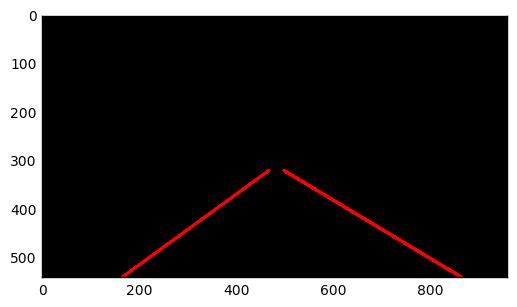

In [34]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

I think that I could make this algorithm more robust by getting rid of the outliers that are used in the linear regression. This would avoid a large change in the gradient of the line as linear regression is very susceptible to outliers. Another way to make it more robust would be to use a robust linear regression such as the Theil-Sen estimator which takes the median slope for all the data points in the data set. 

My current algorithm will be likely to fail in the case where there is a S-bend in the road, this is a result of the linear regresion that is used for the extrapolation.

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [1]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

NameError: name 'VideoFileClip' is not defined

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))